# A Cognitive Model or Harmonic Types (Simplified Amortization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

gpu_n = 0

torch.set_default_dtype(torch.float64)

#torch.autograd.set_detect_anomaly(True)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Amortization**



## Step 1: Model

**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

In [7]:
def simplified_chord_model(npcs, nharmonies, data, subsamples=500, **kwargs):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', dist.Dirichlet(0.8 * torch.ones(nharmonies, device=device)))
    # distribution of notes in the harmonies (chord profiles)
    with pyro.plate('harmonies', nharmonies):
        chord_profiles = pyro.sample('chord_profiles', dist.Dirichlet(0.8 * torch.ones(npcs, device=device)))

    # Sampling the data:
    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # sample a chord type based on the harmony distribution (to be inferred)
        c = pyro.sample('c', dist.Categorical(p_harmony))

        # sampling pitches for the chord based on the selected chord type profile
        pitches = pyro.sample('pitches', dist.Multinomial(1, probs=chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    return {"p_harmony": p_harmony, "chord_profiles": chord_profiles, "c": c, "pitches": pitches}

## Step 2: Amortization Guide for Inference


In [8]:
# simpler
class AmortizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [9]:
# # with regulation
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         x = self.dropout(x)
#         x = torch.softmax(self.fc2(x), dim=-1)
#         return x

In [10]:
# # more complex
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim1)
#         self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
#         self.fc3 = nn.Linear(hidden_dim2, output_dim)
#         # self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         # x = self.dropout(x)
#         x = torch.softmax(self.fc3(x), dim=-1)
#         return x

In [11]:
def amortization_guide(npcs, nharmonies, data, subsamples=500, **kwargs):
    # for the distribution of the harmonies
    # initialize alpha parameters with more information, assuming some harmonies might be more probable
    alpha_h = pyro.param('alpha_h', (torch.ones(nharmonies, device=device) * 0.8), constraint=constraints.positive)
    pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

    # for the chord profiles
    with pyro.plate('harmonies', nharmonies):
        alpha_phi = pyro.param('alpha_phi', (torch.ones([nharmonies, npcs], device=device) * 0.8), constraint=constraints.positive)
        pyro.sample('chord_profiles', dist.Dirichlet(alpha_phi))

    # for chord types
    net = AmortizationNetwork(input_dim=npcs, hidden_dim=128, output_dim=nharmonies)
    # net = AmortizationNetwork(input_dim=npcs, hidden_dim1=128, hidden_dim2=64, output_dim=nharmonies)
    net.to(device)
    pyro.module("net", net)

    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # Use NN to predict parameters for the chord types
        chord_features = data['pitches']
        chord_type_params = net(chord_features[ind])
        pyro.sample('c', dist.Categorical(probs=chord_type_params))

## Step 3: Data and Conditioning
**Data Format**


In [12]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    chord = torch.zeros(npcs, device=device)
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [13]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [14]:
def get_init_params(df, nharms, npcs):
    init = dict()

    # initialize params for harmonies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False), device=device) + 0.5

    # initialize params for chord profiles
    init['chord_profiles'] = torch.zeros([nharms, npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df.groupby(['numlabel', 'fifth']):
        init['chord_profiles'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    chord_sizes = df.groupby('chordid').size()
    init['sum_chords'] = torch.tensor(sum(chord_sizes), device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes), device=device)
    return init

After inferring the parameters we save them for easier inspection and reuse.



In [15]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

In [16]:
def infer_amortized_posteriors(npcs, nharmonies, data, nsteps=5000, lr=0.01, step_size=100, clip_grad=0.1, plot_loss=True, save_as=None, collect_history=False):
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=lambda npcs, nharmonies, data: amortization_guide(npcs, nharmonies, data),
                         optim=pyro.optim.Adam({"lr": lr, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []
    alpha_h_history = []
    alpha_phi_history = []

    for step in tqdm.trange(nsteps):
        loss = svi.step(npcs, nharmonies, data)

        # check for NaNs and infs in gradients
        for name, param in pyro.get_param_store().items():
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    raise ValueError(f'Gradient for {name} has NaN/inf values.')

        # apply gradient clipping
        for p in pyro.get_param_store().values():
            p.register_hook(lambda grad: torch.clamp(grad, -clip_grad, clip_grad))

        losses.append(loss)

        if collect_history:
            # collect parameter histories
            alpha_h_history.append(pyro.param('alpha_h').detach().cpu().numpy())
            alpha_phi_history.append(pyro.param('alpha_phi').detach().cpu().numpy())

        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save inferred parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, (alpha_h_history, alpha_phi_history) if collect_history else params

## Step 5: Plotting

In [17]:
def plot_param_histories(alpha_h_history, alpha_phi_history):
    # Plot alpha_h history
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_h_history)
    plt.title('Alpha_h parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha_h values')
    plt.show()

    # Plot alpha_phi history (for simplicity, here we just plot the mean over the pitch classes)
    alpha_phi_mean_history = np.mean(alpha_phi_history, axis=-1)  # Compute the mean over pitch classes
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_phi_mean_history)
    plt.title('Mean Alpha_phi parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Alpha_phi values')
    plt.show()

In [18]:
def plot_amortized_inference_results(params, nharmonies, npcs, save_as=None):
    # Extract harmony and chord profile parameters
    harmony_params = params['alpha_h']
    chord_profile_params = params['alpha_phi']

    # Normalize the parameters
    harmony_normalized = harmony_params / np.sum(harmony_params)
    chord_profile_normalized = np.array([cp / np.sum(cp) for cp in chord_profile_params])

    num_subplots = nharmonies + 1

    fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 3 * num_subplots))

    # Plot harmony distribution
    axs[0].bar(np.arange(len(harmony_normalized)), harmony_normalized)
    axs[0].set_title('Harmony Distribution')
    axs[0].set_xlabel('Harmony Types')
    axs[0].set_ylabel('Probability')

    # Plot chord profile parameters for each harmony
    for i in range(nharmonies):
        axs[i + 1].bar(np.arange(npcs), chord_profile_normalized[i])
        axs[i + 1].set_title(f'Chord Profile for Harmony {i}')
        axs[i + 1].set_xlabel('Pitches')
        axs[i + 1].set_ylabel('Probability')

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

# **2. Experiment**

In [19]:
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


  0%|          | 0/500000 [00:00<?, ?it/s]<ipython-input-16-390aaa289ab3>:19: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if param.grad is not None:
  0%|          | 8/500000 [00:02<32:37:55,  4.26it/s] 

Step 0 : loss = 3727527.740960735


  0%|          | 103/500000 [00:06<9:22:58, 14.80it/s]

Step 100 : loss = 2071933.944737635


  0%|          | 207/500000 [00:11<4:52:29, 28.48it/s]

Step 200 : loss = 1978715.4471692573


  0%|          | 308/500000 [00:15<4:34:23, 30.35it/s]

Step 300 : loss = 1851439.7029843738


  0%|          | 407/500000 [00:18<4:24:23, 31.49it/s]

Step 400 : loss = 1880672.5659554978


  0%|          | 502/500000 [00:22<9:53:14, 14.03it/s]

Step 500 : loss = 1825208.8112703902


  0%|          | 604/500000 [00:28<4:03:12, 34.22it/s]

Step 600 : loss = 1829049.2872990898


  0%|          | 713/500000 [00:31<2:22:26, 58.42it/s]

Step 700 : loss = 1835181.5407065782


  0%|          | 811/500000 [00:33<2:11:46, 63.14it/s]

Step 800 : loss = 1814995.5519945696


  0%|          | 909/500000 [00:34<2:13:34, 62.27it/s]

Step 900 : loss = 1810154.2771893363


  0%|          | 1011/500000 [00:36<2:21:24, 58.81it/s]

Step 1000 : loss = 1824022.8407580145


  0%|          | 1107/500000 [00:38<2:57:52, 46.74it/s]

Step 1100 : loss = 1800449.36022266


  0%|          | 1207/500000 [00:40<3:18:14, 41.93it/s]

Step 1200 : loss = 1805360.54711683


  0%|          | 1307/500000 [00:42<3:12:08, 43.26it/s]

Step 1300 : loss = 1814329.616216244


  0%|          | 1407/500000 [00:44<2:18:02, 60.20it/s]

Step 1400 : loss = 1807967.2637972115


  0%|          | 1510/500000 [00:46<2:19:22, 59.61it/s]

Step 1500 : loss = 1798709.6083362491


  0%|          | 1607/500000 [00:47<2:10:59, 63.42it/s]

Step 1600 : loss = 1814924.6943554427


  0%|          | 1712/500000 [00:49<2:11:41, 63.06it/s]

Step 1700 : loss = 1808274.9743758503


  0%|          | 1810/500000 [00:51<2:20:23, 59.14it/s]

Step 1800 : loss = 1806258.6510313363


  0%|          | 1908/500000 [00:52<2:13:28, 62.20it/s]

Step 1900 : loss = 1788171.1860715852


  0%|          | 2006/500000 [00:54<3:04:29, 44.99it/s]

Step 2000 : loss = 1804047.0789330842


  0%|          | 2106/500000 [00:57<3:09:24, 43.81it/s]

Step 2100 : loss = 1808981.313356268


  0%|          | 2207/500000 [00:59<2:26:40, 56.56it/s]

Step 2200 : loss = 1794867.0531319603


  0%|          | 2307/500000 [01:01<2:19:01, 59.66it/s]

Step 2300 : loss = 1804528.8198739265


  0%|          | 2412/500000 [01:02<2:16:33, 60.73it/s]

Step 2400 : loss = 1797031.0405444498


  1%|          | 2510/500000 [01:04<2:16:10, 60.89it/s]

Step 2500 : loss = 1795887.942225872


  1%|          | 2612/500000 [01:06<2:22:09, 58.31it/s]

Step 2600 : loss = 1795794.1312274612


  1%|          | 2712/500000 [01:07<2:13:52, 61.91it/s]

Step 2700 : loss = 1793351.51276785


  1%|          | 2806/500000 [01:09<2:56:15, 47.01it/s]

Step 2800 : loss = 1801939.7541897227


  1%|          | 2906/500000 [01:11<3:07:30, 44.18it/s]

Step 2900 : loss = 1800988.7770106832


  1%|          | 3006/500000 [01:14<3:11:58, 43.15it/s]

Step 3000 : loss = 1792045.0900567449


  1%|          | 3108/500000 [01:16<2:21:04, 58.71it/s]

Step 3100 : loss = 1805006.7814325436


  1%|          | 3214/500000 [01:17<2:12:18, 62.58it/s]

Step 3200 : loss = 1795641.4943809991


  1%|          | 3312/500000 [01:19<2:20:56, 58.74it/s]

Step 3300 : loss = 1781107.8435126853


  1%|          | 3410/500000 [01:20<2:11:28, 62.95it/s]

Step 3400 : loss = 1803108.8156361831


  1%|          | 3508/500000 [01:22<2:16:39, 60.55it/s]

Step 3500 : loss = 1793658.3604314355


  1%|          | 3613/500000 [01:24<2:09:33, 63.86it/s]

Step 3600 : loss = 1794945.9535551574


  1%|          | 3706/500000 [01:26<3:10:03, 43.52it/s]

Step 3700 : loss = 1806034.5338914227


  1%|          | 3806/500000 [01:28<3:22:22, 40.87it/s]

Step 3800 : loss = 1802491.1143753948


  1%|          | 3912/500000 [01:30<2:31:23, 54.61it/s]

Step 3900 : loss = 1793304.5233833073


  1%|          | 4008/500000 [01:32<2:20:28, 58.85it/s]

Step 4000 : loss = 1795152.7236506727


  1%|          | 4112/500000 [01:34<2:19:51, 59.09it/s]

Step 4100 : loss = 1801904.8005473749


  1%|          | 4208/500000 [01:35<2:16:03, 60.73it/s]

Step 4200 : loss = 1806597.174281395


  1%|          | 4309/500000 [01:37<2:19:11, 59.35it/s]

Step 4300 : loss = 1807195.4563355579


  1%|          | 4408/500000 [01:39<2:22:04, 58.14it/s]

Step 4400 : loss = 1801620.4404995844


  1%|          | 4510/500000 [01:41<2:57:21, 46.56it/s]

Step 4500 : loss = 1789895.3077512553


  1%|          | 4605/500000 [01:43<3:08:29, 43.80it/s]

Step 4600 : loss = 1785428.3632212428


  1%|          | 4705/500000 [01:45<3:25:52, 40.10it/s]

Step 4700 : loss = 1784665.8433977743


  1%|          | 4811/500000 [01:47<2:24:12, 57.23it/s]

Step 4800 : loss = 1804434.5311764563


  1%|          | 4913/500000 [01:49<2:15:06, 61.08it/s]

Step 4900 : loss = 1789345.5305290595


  1%|          | 5013/500000 [01:51<2:23:34, 57.46it/s]

Step 5000 : loss = 1796071.588668215


  1%|          | 5110/500000 [01:52<2:15:48, 60.73it/s]

Step 5100 : loss = 1786429.286474463


  1%|          | 5207/500000 [01:54<2:16:06, 60.59it/s]

Step 5200 : loss = 1791377.3166273355


  1%|          | 5308/500000 [01:55<2:25:43, 56.58it/s]

Step 5300 : loss = 1805320.3680763403


  1%|          | 5409/500000 [01:58<3:03:26, 44.94it/s]

Step 5400 : loss = 1803714.331570997


  1%|          | 5509/500000 [02:00<3:20:24, 41.12it/s]

Step 5500 : loss = 1789077.8198725418


  1%|          | 5611/500000 [02:02<2:20:33, 58.62it/s]

Step 5600 : loss = 1794136.3772708578


  1%|          | 5706/500000 [02:03<2:16:21, 60.42it/s]

Step 5700 : loss = 1801271.683154463


  1%|          | 5810/500000 [02:05<2:19:33, 59.02it/s]

Step 5800 : loss = 1796646.5278172991


  1%|          | 5908/500000 [02:07<2:19:10, 59.17it/s]

Step 5900 : loss = 1794875.875149154


  1%|          | 6012/500000 [02:09<2:11:38, 62.54it/s]

Step 6000 : loss = 1789129.0861777423


  1%|          | 6110/500000 [02:10<2:14:21, 61.26it/s]

Step 6100 : loss = 1792201.2476540685


  1%|          | 6206/500000 [02:12<2:55:02, 47.02it/s]

Step 6200 : loss = 1786121.6009389856


  1%|▏         | 6306/500000 [02:14<3:08:24, 43.67it/s]

Step 6300 : loss = 1798558.2383334616


  1%|▏         | 6412/500000 [02:16<2:16:05, 60.45it/s]

Step 6400 : loss = 1801343.395936867


  1%|▏         | 6510/500000 [02:18<2:11:36, 62.49it/s]

Step 6500 : loss = 1803263.167181733


  1%|▏         | 6608/500000 [02:20<2:13:00, 61.83it/s]

Step 6600 : loss = 1791121.9924318008


  1%|▏         | 6713/500000 [02:21<2:09:27, 63.51it/s]

Step 6700 : loss = 1792647.4118065436


  1%|▏         | 6811/500000 [02:23<2:12:19, 62.12it/s]

Step 6800 : loss = 1789998.5170163573


  1%|▏         | 6908/500000 [02:25<2:23:23, 57.31it/s]

Step 6900 : loss = 1796266.2663841737


  1%|▏         | 7008/500000 [02:27<3:06:31, 44.05it/s]

Step 7000 : loss = 1802120.5536557166


  1%|▏         | 7108/500000 [02:29<3:10:15, 43.18it/s]

Step 7100 : loss = 1786482.2602025494


  1%|▏         | 7210/500000 [02:31<2:24:54, 56.68it/s]

Step 7200 : loss = 1793990.6717423613


  1%|▏         | 7307/500000 [02:32<2:15:05, 60.79it/s]

Step 7300 : loss = 1787780.4324288967


  1%|▏         | 7408/500000 [02:34<2:19:39, 58.78it/s]

Step 7400 : loss = 1792470.6843630585


  2%|▏         | 7509/500000 [02:36<2:13:55, 61.29it/s]

Step 7500 : loss = 1794584.6886186576


  2%|▏         | 7612/500000 [02:38<2:14:52, 60.85it/s]

Step 7600 : loss = 1797493.6812527787


  2%|▏         | 7708/500000 [02:39<2:16:51, 59.95it/s]

Step 7700 : loss = 1784491.3523600805


  2%|▏         | 7805/500000 [02:41<3:08:49, 43.44it/s]

Step 7800 : loss = 1801395.4678232656


  2%|▏         | 7910/500000 [02:44<3:03:31, 44.69it/s]

Step 7900 : loss = 1800155.9978500223


  2%|▏         | 8008/500000 [02:45<2:27:34, 55.56it/s]

Step 8000 : loss = 1794373.5490455474


  2%|▏         | 8109/500000 [02:47<2:16:44, 59.95it/s]

Step 8100 : loss = 1797493.5457728668


  2%|▏         | 8209/500000 [02:49<2:19:22, 58.81it/s]

Step 8200 : loss = 1796623.1930454618


  2%|▏         | 8312/500000 [02:51<2:13:26, 61.41it/s]

Step 8300 : loss = 1785070.6637500997


  2%|▏         | 8410/500000 [02:52<2:12:25, 61.87it/s]

Step 8400 : loss = 1797244.6645000721


  2%|▏         | 8507/500000 [02:54<2:15:49, 60.31it/s]

Step 8500 : loss = 1795166.7739763216


  2%|▏         | 8607/500000 [02:56<3:05:20, 44.19it/s]

Step 8600 : loss = 1795316.6802820517


  2%|▏         | 8707/500000 [02:58<3:15:29, 41.89it/s]

Step 8700 : loss = 1795168.4793231548


  2%|▏         | 8810/500000 [03:01<2:23:12, 57.16it/s]

Step 8800 : loss = 1778720.4869564814


  2%|▏         | 8910/500000 [03:02<2:18:04, 59.28it/s]

Step 8900 : loss = 1805020.4068446048


  2%|▏         | 9013/500000 [03:04<2:13:29, 61.30it/s]

Step 9000 : loss = 1789725.1538277066


  2%|▏         | 9109/500000 [03:06<2:18:27, 59.09it/s]

Step 9100 : loss = 1806722.4899010786


  2%|▏         | 9212/500000 [03:07<2:13:08, 61.44it/s]

Step 9200 : loss = 1789103.203404798


  2%|▏         | 9308/500000 [03:09<2:14:48, 60.67it/s]

Step 9300 : loss = 1796146.7158319012


  2%|▏         | 9406/500000 [03:11<2:59:26, 45.57it/s]

Step 9400 : loss = 1795648.6148509518


  2%|▏         | 9506/500000 [03:13<3:16:59, 41.50it/s]

Step 9500 : loss = 1790080.2273727455


  2%|▏         | 9610/500000 [03:15<2:19:57, 58.40it/s]

Step 9600 : loss = 1790741.751208743


  2%|▏         | 9713/500000 [03:17<2:15:43, 60.20it/s]

Step 9700 : loss = 1787162.7018419418


  2%|▏         | 9812/500000 [03:19<2:15:02, 60.50it/s]

Step 9800 : loss = 1810430.6434459954


  2%|▏         | 9911/500000 [03:20<2:14:12, 60.86it/s]

Step 9900 : loss = 1795393.6491877371


  2%|▏         | 10009/500000 [03:22<2:14:39, 60.65it/s]

Step 10000 : loss = 1791909.1077469857


  2%|▏         | 10111/500000 [03:24<2:16:24, 59.86it/s]

Step 10100 : loss = 1785327.3084497955


  2%|▏         | 10205/500000 [03:26<3:05:13, 44.07it/s]

Step 10200 : loss = 1800820.455648162


  2%|▏         | 10305/500000 [03:28<3:02:13, 44.79it/s]

Step 10300 : loss = 1787035.4604043756


  2%|▏         | 10411/500000 [03:30<2:14:56, 60.47it/s]

Step 10400 : loss = 1784092.4677889373


  2%|▏         | 10513/500000 [03:32<2:14:18, 60.74it/s]

Step 10500 : loss = 1793711.4872773835


  2%|▏         | 10611/500000 [03:33<2:11:11, 62.17it/s]

Step 10600 : loss = 1797914.6288507737


  2%|▏         | 10711/500000 [03:35<2:18:42, 58.79it/s]

Step 10700 : loss = 1796761.2402203875


  2%|▏         | 10810/500000 [03:37<2:18:53, 58.70it/s]

Step 10800 : loss = 1789371.4267592924


  2%|▏         | 10910/500000 [03:38<2:19:04, 58.61it/s]

Step 10900 : loss = 1792697.967551332


  2%|▏         | 11005/500000 [03:40<3:03:45, 44.35it/s]

Step 11000 : loss = 1797109.3652906322


  2%|▏         | 11105/500000 [03:43<3:04:56, 44.06it/s]

Step 11100 : loss = 1789110.251985873


  2%|▏         | 11208/500000 [03:45<2:18:57, 58.62it/s]

Step 11200 : loss = 1793196.8296741769


  2%|▏         | 11312/500000 [03:46<2:17:38, 59.17it/s]

Step 11300 : loss = 1785847.5216572364


  2%|▏         | 11406/500000 [03:48<2:13:00, 61.22it/s]

Step 11400 : loss = 1790751.6153778532


  2%|▏         | 11513/500000 [03:50<2:14:56, 60.33it/s]

Step 11500 : loss = 1780598.9916684171


  2%|▏         | 11611/500000 [03:51<2:13:09, 61.13it/s]

Step 11600 : loss = 1788726.9708617115


  2%|▏         | 11709/500000 [03:53<2:14:39, 60.44it/s]

Step 11700 : loss = 1786937.272222402


  2%|▏         | 11809/500000 [03:55<3:13:14, 42.11it/s]

Step 11800 : loss = 1794665.6140523423


  2%|▏         | 11909/500000 [03:58<3:08:51, 43.07it/s]

Step 11900 : loss = 1799398.3228469682


  2%|▏         | 12007/500000 [03:59<2:17:37, 59.09it/s]

Step 12000 : loss = 1793441.5502937739


  2%|▏         | 12112/500000 [04:01<2:15:56, 59.81it/s]

Step 12100 : loss = 1792460.5734087282


  2%|▏         | 12208/500000 [04:03<2:20:26, 57.89it/s]

Step 12200 : loss = 1795455.775190721


  2%|▏         | 12307/500000 [04:04<2:18:28, 58.70it/s]

Step 12300 : loss = 1801264.7936115158


  2%|▏         | 12411/500000 [04:06<2:19:54, 58.09it/s]

Step 12400 : loss = 1790127.9430902048


  3%|▎         | 12511/500000 [04:08<2:25:26, 55.87it/s]

Step 12500 : loss = 1797151.712892253


  3%|▎         | 12608/500000 [04:10<3:11:14, 42.48it/s]

Step 12600 : loss = 1794506.5627089243


  3%|▎         | 12708/500000 [04:12<3:01:27, 44.76it/s]

Step 12700 : loss = 1793655.8069595154


  3%|▎         | 12810/500000 [04:14<2:36:46, 51.80it/s]

Step 12800 : loss = 1791903.4566647108


  3%|▎         | 12907/500000 [04:16<2:26:17, 55.50it/s]

Step 12900 : loss = 1785623.918325344


  3%|▎         | 13011/500000 [04:18<2:16:01, 59.67it/s]

Step 13000 : loss = 1791363.9604750075


  3%|▎         | 13112/500000 [04:20<2:17:38, 58.96it/s]

Step 13100 : loss = 1789337.9781841645


  3%|▎         | 13212/500000 [04:21<2:21:03, 57.52it/s]

Step 13200 : loss = 1795731.287447451


  3%|▎         | 13304/500000 [04:23<2:34:05, 52.64it/s]

Step 13300 : loss = 1790257.644040024


  3%|▎         | 13405/500000 [04:25<3:27:12, 39.14it/s]

Step 13400 : loss = 1801034.5152313248


  3%|▎         | 13508/500000 [04:28<2:38:17, 51.22it/s]

Step 13500 : loss = 1793516.5379786056


  3%|▎         | 13610/500000 [04:30<2:30:35, 53.83it/s]

Step 13600 : loss = 1791762.7068415857


  3%|▎         | 13709/500000 [04:31<2:23:16, 56.57it/s]

Step 13700 : loss = 1796748.9854327952


  3%|▎         | 13809/500000 [04:33<2:20:13, 57.79it/s]

Step 13800 : loss = 1796709.7785956091


  3%|▎         | 13908/500000 [04:35<2:25:07, 55.82it/s]

Step 13900 : loss = 1785737.7354941308


  3%|▎         | 14011/500000 [04:37<2:23:05, 56.60it/s]

Step 14000 : loss = 1788169.2462646617


  3%|▎         | 14108/500000 [04:39<3:01:37, 44.59it/s]

Step 14100 : loss = 1797868.381043512


  3%|▎         | 14207/500000 [04:41<3:06:46, 43.35it/s]

Step 14200 : loss = 1789738.3552805672


  3%|▎         | 14311/500000 [04:43<2:22:16, 56.90it/s]

Step 14300 : loss = 1793183.739683257


  3%|▎         | 14408/500000 [04:45<2:31:47, 53.32it/s]

Step 14400 : loss = 1789652.9716031293


  3%|▎         | 14512/500000 [04:47<2:23:37, 56.34it/s]

Step 14500 : loss = 1794103.6987515579


  3%|▎         | 14610/500000 [04:49<2:20:18, 57.66it/s]

Step 14600 : loss = 1785922.0893739446


  3%|▎         | 14708/500000 [04:50<2:23:01, 56.55it/s]

Step 14700 : loss = 1789318.4901492822


  3%|▎         | 14807/500000 [04:52<2:20:12, 57.68it/s]

Step 14800 : loss = 1795736.504448394


  3%|▎         | 14908/500000 [04:54<3:01:50, 44.46it/s]

Step 14900 : loss = 1789813.1215462165


  3%|▎         | 15007/500000 [04:57<3:14:56, 41.47it/s]

Step 15000 : loss = 1791441.270296663


  3%|▎         | 15111/500000 [04:59<2:20:34, 57.49it/s]

Step 15100 : loss = 1783020.1167120968


  3%|▎         | 15209/500000 [05:00<2:29:11, 54.15it/s]

Step 15200 : loss = 1789972.1413974063


  3%|▎         | 15309/500000 [05:02<2:20:46, 57.38it/s]

Step 15300 : loss = 1786937.6723154453


  3%|▎         | 15413/500000 [05:04<2:20:13, 57.59it/s]

Step 15400 : loss = 1793436.3580420762


  3%|▎         | 15509/500000 [05:06<2:28:44, 54.29it/s]

Step 15500 : loss = 1798388.4065992609


  3%|▎         | 15610/500000 [05:08<3:02:29, 44.24it/s]

Step 15600 : loss = 1785449.1086064773


  3%|▎         | 15705/500000 [05:10<3:15:41, 41.25it/s]

Step 15700 : loss = 1793060.2669578395


  3%|▎         | 15812/500000 [05:12<2:37:57, 51.09it/s]

Step 15800 : loss = 1795081.2286956687


  3%|▎         | 15909/500000 [05:14<2:29:54, 53.82it/s]

Step 15900 : loss = 1789925.4898297759


  3%|▎         | 16012/500000 [05:16<2:24:25, 55.86it/s]

Step 16000 : loss = 1805145.0027080101


  3%|▎         | 16108/500000 [05:18<2:28:23, 54.35it/s]

Step 16100 : loss = 1788818.024464292


  3%|▎         | 16211/500000 [05:20<2:20:50, 57.25it/s]

Step 16200 : loss = 1789854.3677015149


  3%|▎         | 16312/500000 [05:21<2:12:41, 60.75it/s]

Step 16300 : loss = 1796221.5533138148


  3%|▎         | 16409/500000 [05:23<3:03:40, 43.88it/s]

Step 16400 : loss = 1799560.780700204


  3%|▎         | 16509/500000 [05:26<3:10:44, 42.24it/s]

Step 16500 : loss = 1791509.9733175384


  3%|▎         | 16609/500000 [05:28<2:16:51, 58.87it/s]

Step 16600 : loss = 1810997.1797261043


  3%|▎         | 16711/500000 [05:30<2:14:35, 59.84it/s]

Step 16700 : loss = 1798809.7069084437


  3%|▎         | 16811/500000 [05:31<2:24:40, 55.66it/s]

Step 16800 : loss = 1781632.7214216045


  3%|▎         | 16913/500000 [05:33<2:13:17, 60.41it/s]

Step 16900 : loss = 1801410.65224067


  3%|▎         | 17010/500000 [05:35<2:23:10, 56.23it/s]

Step 17000 : loss = 1803218.4604977844


  3%|▎         | 17109/500000 [05:36<2:13:50, 60.13it/s]

Step 17100 : loss = 1790617.8889736193


  3%|▎         | 17205/500000 [05:38<3:06:28, 43.15it/s]

Step 17200 : loss = 1783070.09046268


  3%|▎         | 17305/500000 [05:41<3:11:37, 41.98it/s]

Step 17300 : loss = 1793836.41962856


  3%|▎         | 17408/500000 [05:43<2:13:23, 60.30it/s]

Step 17400 : loss = 1798413.641294018


  4%|▎         | 17509/500000 [05:44<2:18:42, 57.97it/s]

Step 17500 : loss = 1790879.3934878614


  4%|▎         | 17612/500000 [05:46<2:15:11, 59.47it/s]

Step 17600 : loss = 1790545.265733398


  4%|▎         | 17712/500000 [05:48<2:19:51, 57.48it/s]

Step 17700 : loss = 1790587.8865985465


  4%|▎         | 17807/500000 [05:50<2:11:11, 61.26it/s]

Step 17800 : loss = 1788508.9498265071


  4%|▎         | 17911/500000 [05:51<2:24:17, 55.69it/s]

Step 17900 : loss = 1796328.8291671416


  4%|▎         | 18008/500000 [05:54<3:05:42, 43.26it/s]

Step 18000 : loss = 1789028.0927131297


  4%|▎         | 18109/500000 [05:56<2:52:42, 46.50it/s]

Step 18100 : loss = 1789013.8681474563


  4%|▎         | 18210/500000 [05:58<2:15:33, 59.23it/s]

Step 18200 : loss = 1783627.890297608


  4%|▎         | 18310/500000 [05:59<2:22:35, 56.30it/s]

Step 18300 : loss = 1784653.4000794005


  4%|▎         | 18411/500000 [06:01<2:20:16, 57.22it/s]

Step 18400 : loss = 1780097.6517397652


  4%|▎         | 18511/500000 [06:03<2:14:26, 59.69it/s]

Step 18500 : loss = 1786018.6178220897


  4%|▎         | 18604/500000 [06:05<3:37:44, 36.85it/s]

Step 18600 : loss = 1791612.522645336


  4%|▎         | 18709/500000 [06:07<3:08:16, 42.61it/s]

Step 18700 : loss = 1797319.3991460728


  4%|▍         | 18809/500000 [06:09<3:01:46, 44.12it/s]

Step 18800 : loss = 1792601.4807109418


  4%|▍         | 18911/500000 [06:11<2:14:11, 59.75it/s]

Step 18900 : loss = 1793883.5060855066


  4%|▍         | 19011/500000 [06:13<2:16:07, 58.89it/s]

Step 19000 : loss = 1793686.6071194056


  4%|▍         | 19110/500000 [06:15<2:17:22, 58.34it/s]

Step 19100 : loss = 1803682.5345175387


  4%|▍         | 19209/500000 [06:16<2:14:20, 59.65it/s]

Step 19200 : loss = 1806280.0135928683


  4%|▍         | 19310/500000 [06:18<2:20:49, 56.89it/s]

Step 19300 : loss = 1791236.0741928136


  4%|▍         | 19408/500000 [06:20<2:15:11, 59.24it/s]

Step 19400 : loss = 1780249.4346227492


  4%|▍         | 19507/500000 [06:22<2:55:42, 45.58it/s]

Step 19500 : loss = 1792657.137168348


  4%|▍         | 19607/500000 [06:24<2:56:23, 45.39it/s]

Step 19600 : loss = 1791959.0480711749


  4%|▍         | 19709/500000 [06:26<2:15:20, 59.14it/s]

Step 19700 : loss = 1796275.7390574268


  4%|▍         | 19810/500000 [06:28<2:13:34, 59.91it/s]

Step 19800 : loss = 1803707.9236077932


  4%|▍         | 19911/500000 [06:30<2:21:19, 56.62it/s]

Step 19900 : loss = 1792409.5175715673


  4%|▍         | 20010/500000 [06:31<2:19:00, 57.55it/s]

Step 20000 : loss = 1800371.2687797244


  4%|▍         | 20110/500000 [06:33<2:15:49, 58.89it/s]

Step 20100 : loss = 1782412.6875814137


  4%|▍         | 20208/500000 [06:35<2:30:03, 53.29it/s]

Step 20200 : loss = 1787962.748262902


  4%|▍         | 20309/500000 [06:37<3:03:22, 43.60it/s]

Step 20300 : loss = 1802566.2624108223


  4%|▍         | 20409/500000 [06:40<3:06:19, 42.90it/s]

Step 20400 : loss = 1793919.791711591


  4%|▍         | 20512/500000 [06:42<2:14:37, 59.36it/s]

Step 20500 : loss = 1791641.2403532164


  4%|▍         | 20611/500000 [06:43<2:18:16, 57.78it/s]

Step 20600 : loss = 1786256.087766435


  4%|▍         | 20710/500000 [06:45<2:20:18, 56.93it/s]

Step 20700 : loss = 1802348.555014663


  4%|▍         | 20812/500000 [06:47<2:21:34, 56.41it/s]

Step 20800 : loss = 1788825.7103987425


  4%|▍         | 20908/500000 [06:48<2:16:51, 58.35it/s]

Step 20900 : loss = 1799886.3090295726


  4%|▍         | 21007/500000 [06:50<2:46:35, 47.92it/s]

Step 21000 : loss = 1794120.3191624735


  4%|▍         | 21107/500000 [06:53<3:14:19, 41.07it/s]

Step 21100 : loss = 1798200.9295772323


  4%|▍         | 21208/500000 [06:55<2:57:34, 44.94it/s]

Step 21200 : loss = 1792775.076418538


  4%|▍         | 21312/500000 [06:57<2:20:58, 56.59it/s]

Step 21300 : loss = 1794659.9369912716


  4%|▍         | 21411/500000 [06:58<2:20:36, 56.73it/s]

Step 21400 : loss = 1800408.7889018892


  4%|▍         | 21510/500000 [07:00<2:18:22, 57.63it/s]

Step 21500 : loss = 1788455.7285872349


  4%|▍         | 21609/500000 [07:02<2:19:36, 57.11it/s]

Step 21600 : loss = 1796640.6410274298


  4%|▍         | 21712/500000 [07:04<2:19:09, 57.28it/s]

Step 21700 : loss = 1800976.8846841722


  4%|▍         | 21809/500000 [07:06<3:06:57, 42.63it/s]

Step 21800 : loss = 1792665.5688230786


  4%|▍         | 21909/500000 [07:08<3:05:43, 42.90it/s]

Step 21900 : loss = 1796230.0261417641


  4%|▍         | 22012/500000 [07:10<2:26:40, 54.31it/s]

Step 22000 : loss = 1783041.0491645928


  4%|▍         | 22108/500000 [07:12<2:20:40, 56.62it/s]

Step 22100 : loss = 1781337.8133366136


  4%|▍         | 22213/500000 [07:14<2:16:32, 58.32it/s]

Step 22200 : loss = 1797377.8907398211


  4%|▍         | 22311/500000 [07:16<2:24:22, 55.14it/s]

Step 22300 : loss = 1786616.5052955286


  4%|▍         | 22413/500000 [07:17<2:13:01, 59.83it/s]

Step 22400 : loss = 1793585.5889073806


  5%|▍         | 22508/500000 [07:19<2:12:55, 59.87it/s]

Step 22500 : loss = 1793048.413667344


  5%|▍         | 22608/500000 [07:21<2:58:20, 44.61it/s]

Step 22600 : loss = 1812552.3888792177


  5%|▍         | 22708/500000 [07:23<2:52:26, 46.13it/s]

Step 22700 : loss = 1794159.3916091463


  5%|▍         | 22807/500000 [07:25<2:26:55, 54.13it/s]

Step 22800 : loss = 1794243.0874841805


  5%|▍         | 22911/500000 [07:27<2:17:19, 57.90it/s]

Step 22900 : loss = 1796589.5968257505


  5%|▍         | 23009/500000 [07:29<2:25:41, 54.57it/s]

Step 23000 : loss = 1797790.0735950416


  5%|▍         | 23112/500000 [07:31<2:17:54, 57.63it/s]

Step 23100 : loss = 1790816.7152736166


  5%|▍         | 23212/500000 [07:32<2:15:50, 58.50it/s]

Step 23200 : loss = 1794194.5503323702


  5%|▍         | 23308/500000 [07:34<2:17:17, 57.87it/s]

Step 23300 : loss = 1795559.2452318557


  5%|▍         | 23407/500000 [07:36<3:02:15, 43.58it/s]

Step 23400 : loss = 1799376.5455506672


  5%|▍         | 23507/500000 [07:39<3:08:16, 42.18it/s]

Step 23500 : loss = 1784451.1615519724


  5%|▍         | 23613/500000 [07:41<2:16:11, 58.30it/s]

Step 23600 : loss = 1802265.835854186


  5%|▍         | 23708/500000 [07:42<2:13:02, 59.67it/s]

Step 23700 : loss = 1790584.529895028


  5%|▍         | 23807/500000 [07:44<2:20:31, 56.48it/s]

Step 23800 : loss = 1797397.3540082022


  5%|▍         | 23909/500000 [07:46<2:21:31, 56.07it/s]

Step 23900 : loss = 1799189.360639854


  5%|▍         | 24012/500000 [07:48<2:18:23, 57.33it/s]

Step 24000 : loss = 1793178.4951874


  5%|▍         | 24107/500000 [07:49<2:14:46, 58.85it/s]

Step 24100 : loss = 1789687.7704572112


  5%|▍         | 24205/500000 [07:51<2:56:11, 45.01it/s]

Step 24200 : loss = 1798901.6586501002


  5%|▍         | 24305/500000 [07:54<3:12:02, 41.28it/s]

Step 24300 : loss = 1805096.513545418


  5%|▍         | 24412/500000 [07:56<2:20:28, 56.43it/s]

Step 24400 : loss = 1801768.3862956031


  5%|▍         | 24511/500000 [07:58<2:16:14, 58.17it/s]

Step 24500 : loss = 1789838.7866766658


  5%|▍         | 24610/500000 [07:59<2:20:58, 56.20it/s]

Step 24600 : loss = 1798025.5278441794


  5%|▍         | 24707/500000 [08:01<2:18:45, 57.09it/s]

Step 24700 : loss = 1783502.4901603747


  5%|▍         | 24809/500000 [08:03<2:20:12, 56.49it/s]

Step 24800 : loss = 1790015.716948627


  5%|▍         | 24909/500000 [08:05<3:06:43, 42.40it/s]

Step 24900 : loss = 1792714.5332924938


  5%|▌         | 25009/500000 [08:07<3:09:30, 41.77it/s]

Step 25000 : loss = 1794253.7063661749


  5%|▌         | 25109/500000 [08:09<2:26:56, 53.87it/s]

Step 25100 : loss = 1794396.1738315932


  5%|▌         | 25208/500000 [08:11<2:15:18, 58.48it/s]

Step 25200 : loss = 1795053.9490118031


  5%|▌         | 25312/500000 [08:13<2:16:28, 57.97it/s]

Step 25300 : loss = 1786076.355649585


  5%|▌         | 25410/500000 [08:15<2:16:47, 57.83it/s]

Step 25400 : loss = 1789768.666108748


  5%|▌         | 25510/500000 [08:16<2:10:56, 60.40it/s]

Step 25500 : loss = 1794453.3880282328


  5%|▌         | 25611/500000 [08:18<2:18:05, 57.25it/s]

Step 25600 : loss = 1788334.314773424


  5%|▌         | 25706/500000 [08:20<2:57:12, 44.61it/s]

Step 25700 : loss = 1786611.17529028


  5%|▌         | 25806/500000 [08:22<3:09:28, 41.71it/s]

Step 25800 : loss = 1795264.8904014132


  5%|▌         | 25910/500000 [08:25<2:26:09, 54.06it/s]

Step 25900 : loss = 1777123.9446387996


  5%|▌         | 26010/500000 [08:26<2:16:58, 57.67it/s]

Step 26000 : loss = 1791749.6850905155


  5%|▌         | 26112/500000 [08:28<2:11:51, 59.89it/s]

Step 26100 : loss = 1785097.9237341848


  5%|▌         | 26212/500000 [08:30<2:14:01, 58.92it/s]

Step 26200 : loss = 1790499.04454525


  5%|▌         | 26307/500000 [08:31<2:13:21, 59.20it/s]

Step 26300 : loss = 1788512.864539952


  5%|▌         | 26408/500000 [08:33<2:15:22, 58.31it/s]

Step 26400 : loss = 1789752.4659904032


  5%|▌         | 26509/500000 [08:35<3:04:27, 42.78it/s]

Step 26500 : loss = 1792882.6262539644


  5%|▌         | 26604/500000 [08:38<3:11:01, 41.30it/s]

Step 26600 : loss = 1796567.433131977


  5%|▌         | 26712/500000 [08:40<2:17:55, 57.19it/s]

Step 26700 : loss = 1789532.3483316458


  5%|▌         | 26812/500000 [08:42<2:14:41, 58.55it/s]

Step 26800 : loss = 1793473.5786925496


  5%|▌         | 26907/500000 [08:43<2:19:49, 56.39it/s]

Step 26900 : loss = 1796762.1163585824


  5%|▌         | 27010/500000 [08:45<2:21:16, 55.80it/s]

Step 27000 : loss = 1793550.1025789268


  5%|▌         | 27109/500000 [08:47<2:19:08, 56.64it/s]

Step 27100 : loss = 1794347.6648848522


  5%|▌         | 27210/500000 [08:49<2:30:59, 52.19it/s]

Step 27200 : loss = 1797603.6876616473


  5%|▌         | 27306/500000 [08:51<3:05:56, 42.37it/s]

Step 27300 : loss = 1778078.5866914876


  5%|▌         | 27406/500000 [08:53<3:13:27, 40.71it/s]

Step 27400 : loss = 1798801.081344619


  6%|▌         | 27507/500000 [08:55<2:19:02, 56.64it/s]

Step 27500 : loss = 1804127.171710699


  6%|▌         | 27611/500000 [08:57<2:18:14, 56.95it/s]

Step 27600 : loss = 1789736.518175139


  6%|▌         | 27708/500000 [08:59<2:24:49, 54.35it/s]

Step 27700 : loss = 1795915.389818167


  6%|▌         | 27811/500000 [09:00<2:18:51, 56.68it/s]

Step 27800 : loss = 1795541.7590501164


  6%|▌         | 27905/500000 [09:02<3:58:12, 33.03it/s]

Step 27900 : loss = 1798674.0340945404


  6%|▌         | 28003/500000 [09:06<4:46:08, 27.49it/s]

Step 28000 : loss = 1792661.2764219139


  6%|▌         | 28109/500000 [09:10<4:09:46, 31.49it/s]

Step 28100 : loss = 1789780.8134720079


  6%|▌         | 28210/500000 [09:13<2:50:27, 46.13it/s]

Step 28200 : loss = 1790209.141588377


  6%|▌         | 28306/500000 [09:15<2:57:41, 44.24it/s]

Step 28300 : loss = 1789917.5897976104


  6%|▌         | 28407/500000 [09:17<3:15:24, 40.22it/s]

Step 28400 : loss = 1786887.0241327044


  6%|▌         | 28507/500000 [09:19<2:14:55, 58.24it/s]

Step 28500 : loss = 1786731.3454613364


  6%|▌         | 28605/500000 [09:21<3:00:57, 43.42it/s]

Step 28600 : loss = 1793013.342350964


  6%|▌         | 28705/500000 [09:24<3:02:09, 43.12it/s]

Step 28700 : loss = 1798266.733231477


  6%|▌         | 28807/500000 [09:26<2:24:53, 54.20it/s]

Step 28800 : loss = 1792038.6350326205


  6%|▌         | 28908/500000 [09:28<2:12:34, 59.23it/s]

Step 28900 : loss = 1795179.3346609464


  6%|▌         | 29007/500000 [09:29<2:14:29, 58.36it/s]

Step 29000 : loss = 1793318.7777551026


  6%|▌         | 29111/500000 [09:31<2:14:28, 58.36it/s]

Step 29100 : loss = 1796604.1854293612


  6%|▌         | 29211/500000 [09:33<2:16:10, 57.62it/s]

Step 29200 : loss = 1792286.9028319488


  6%|▌         | 29310/500000 [09:35<2:28:00, 53.00it/s]

Step 29300 : loss = 1796476.41196749


  6%|▌         | 29406/500000 [09:37<2:58:21, 43.98it/s]

Step 29400 : loss = 1790575.198299299


  6%|▌         | 29506/500000 [09:39<3:03:25, 42.75it/s]

Step 29500 : loss = 1801956.7558603245


  6%|▌         | 29610/500000 [09:41<2:18:47, 56.49it/s]

Step 29600 : loss = 1796586.8970196988


  6%|▌         | 29709/500000 [09:43<2:20:44, 55.70it/s]

Step 29700 : loss = 1803961.3792507825


  6%|▌         | 29807/500000 [09:45<2:18:18, 56.66it/s]

Step 29800 : loss = 1796406.3254004


  6%|▌         | 29911/500000 [09:47<2:15:01, 58.03it/s]

Step 29900 : loss = 1789650.7911037288


  6%|▌         | 30010/500000 [09:48<2:14:35, 58.20it/s]

Step 30000 : loss = 1792597.741564528


  6%|▌         | 30106/500000 [09:50<2:24:07, 54.34it/s]

Step 30100 : loss = 1790318.0722019293


  6%|▌         | 30210/500000 [09:52<2:53:29, 45.13it/s]

Step 30200 : loss = 1794600.0180009585


  6%|▌         | 30305/500000 [09:54<3:05:19, 42.24it/s]

Step 30300 : loss = 1799726.8819031208


  6%|▌         | 30409/500000 [09:56<2:16:32, 57.32it/s]

Step 30400 : loss = 1795777.911090646


  6%|▌         | 30511/500000 [09:58<2:18:11, 56.63it/s]

Step 30500 : loss = 1785683.441875978


  6%|▌         | 30612/500000 [10:00<2:13:52, 58.44it/s]

Step 30600 : loss = 1788718.8404908609


  6%|▌         | 30710/500000 [10:02<2:23:21, 54.56it/s]

Step 30700 : loss = 1784542.0880974515


  6%|▌         | 30809/500000 [10:03<2:18:28, 56.47it/s]

Step 30800 : loss = 1799174.0115929272


  6%|▌         | 30909/500000 [10:05<2:40:01, 48.86it/s]

Step 30900 : loss = 1789868.353956914


  6%|▌         | 31009/500000 [10:08<3:11:09, 40.89it/s]

Step 31000 : loss = 1788160.3647823322


  6%|▌         | 31107/500000 [10:10<3:18:14, 39.42it/s]

Step 31100 : loss = 1783074.4894226375


  6%|▌         | 31209/500000 [10:12<2:20:36, 55.56it/s]

Step 31200 : loss = 1781192.8251448134


  6%|▋         | 31310/500000 [10:14<2:13:33, 58.49it/s]

Step 31300 : loss = 1788832.6612696312


  6%|▋         | 31408/500000 [10:15<2:20:50, 55.45it/s]

Step 31400 : loss = 1804850.068662712


  6%|▋         | 31507/500000 [10:17<2:15:18, 57.71it/s]

Step 31500 : loss = 1787992.7476819814


  6%|▋         | 31612/500000 [10:19<2:15:50, 57.47it/s]

Step 31600 : loss = 1785633.62095858


  6%|▋         | 31708/500000 [10:21<2:58:24, 43.75it/s]

Step 31700 : loss = 1794535.8136370294


  6%|▋         | 31808/500000 [10:23<3:01:07, 43.08it/s]

Step 31800 : loss = 1794199.018163147


  6%|▋         | 31912/500000 [10:25<2:31:09, 51.61it/s]

Step 31900 : loss = 1799096.0610272093


  6%|▋         | 32008/500000 [10:27<2:18:32, 56.30it/s]

Step 32000 : loss = 1792304.7501724367


  6%|▋         | 32110/500000 [10:29<2:20:18, 55.58it/s]

Step 32100 : loss = 1797519.9982346115


  6%|▋         | 32207/500000 [10:31<2:22:27, 54.73it/s]

Step 32200 : loss = 1788023.8449057364


  6%|▋         | 32310/500000 [10:32<2:26:41, 53.14it/s]

Step 32300 : loss = 1785243.2868299847


  6%|▋         | 32408/500000 [10:34<2:20:28, 55.48it/s]

Step 32400 : loss = 1793648.2022481188


  7%|▋         | 32506/500000 [10:36<2:56:11, 44.22it/s]

Step 32500 : loss = 1778973.6805267313


  7%|▋         | 32606/500000 [10:39<2:55:37, 44.35it/s]

Step 32600 : loss = 1794753.9868350914


  7%|▋         | 32710/500000 [10:41<2:17:26, 56.66it/s]

Step 32700 : loss = 1782914.6291620634


  7%|▋         | 32809/500000 [10:42<2:12:35, 58.73it/s]

Step 32800 : loss = 1797835.2271565702


  7%|▋         | 32911/500000 [10:44<2:23:50, 54.12it/s]

Step 32900 : loss = 1780552.2610021457


  7%|▋         | 33007/500000 [10:46<2:16:33, 57.00it/s]

Step 33000 : loss = 1785346.1442210558


  7%|▋         | 33110/500000 [10:48<2:13:21, 58.35it/s]

Step 33100 : loss = 1782330.0276925687


  7%|▋         | 33209/500000 [10:50<2:13:37, 58.22it/s]

Step 33200 : loss = 1790019.8961807191


  7%|▋         | 33306/500000 [10:52<2:50:44, 45.56it/s]

Step 33300 : loss = 1789239.7370178462


  7%|▋         | 33406/500000 [10:54<2:49:33, 45.86it/s]

Step 33400 : loss = 1791237.033143316


  7%|▋         | 33512/500000 [10:56<2:14:59, 57.59it/s]

Step 33500 : loss = 1798368.17207541


  7%|▋         | 33609/500000 [10:58<2:16:54, 56.78it/s]

Step 33600 : loss = 1787016.2271758742


  7%|▋         | 33708/500000 [10:59<2:16:04, 57.11it/s]

Step 33700 : loss = 1785278.7606599745


  7%|▋         | 33811/500000 [11:01<2:15:55, 57.16it/s]

Step 33800 : loss = 1791722.6155314283


  7%|▋         | 33910/500000 [11:03<2:17:26, 56.52it/s]

Step 33900 : loss = 1790800.4625633787


  7%|▋         | 34008/500000 [11:05<2:14:40, 57.67it/s]

Step 34000 : loss = 1790865.2680177842


  7%|▋         | 34107/500000 [11:07<3:00:59, 42.90it/s]

Step 34100 : loss = 1791160.0356383156


  7%|▋         | 34207/500000 [11:09<3:07:58, 41.30it/s]

Step 34200 : loss = 1783707.6242645406


  7%|▋         | 34312/500000 [11:11<2:14:34, 57.67it/s]

Step 34300 : loss = 1805517.8454099682


  7%|▋         | 34409/500000 [11:13<2:33:53, 50.42it/s]

Step 34400 : loss = 1807256.1399399666


  7%|▋         | 34512/500000 [11:15<2:18:22, 56.06it/s]

Step 34500 : loss = 1794765.642767735


  7%|▋         | 34608/500000 [11:17<2:19:26, 55.63it/s]

Step 34600 : loss = 1789639.6425252804


  7%|▋         | 34710/500000 [11:19<2:18:44, 55.89it/s]

Step 34700 : loss = 1790639.9910378223


  7%|▋         | 34808/500000 [11:21<3:06:50, 41.50it/s]

Step 34800 : loss = 1795717.7135163285


  7%|▋         | 34909/500000 [11:23<3:04:54, 41.92it/s]

Step 34900 : loss = 1797904.7919961023


  7%|▋         | 35008/500000 [11:26<2:45:01, 46.96it/s]

Step 35000 : loss = 1793460.8344298624


  7%|▋         | 35112/500000 [11:27<2:14:07, 57.77it/s]

Step 35100 : loss = 1792768.3903743457


  7%|▋         | 35209/500000 [11:29<2:19:51, 55.39it/s]

Step 35200 : loss = 1794884.2340183475


  7%|▋         | 35312/500000 [11:31<2:16:53, 56.58it/s]

Step 35300 : loss = 1792471.824484324


  7%|▋         | 35409/500000 [11:33<2:17:35, 56.28it/s]

Step 35400 : loss = 1792584.3440327328


  7%|▋         | 35512/500000 [11:35<2:18:55, 55.72it/s]

Step 35500 : loss = 1789077.9577624253


  7%|▋         | 35607/500000 [11:37<2:59:54, 43.02it/s]

Step 35600 : loss = 1793524.1658225078


  7%|▋         | 35707/500000 [11:39<2:57:48, 43.52it/s]

Step 35700 : loss = 1794540.5287989054


  7%|▋         | 35807/500000 [11:41<2:20:25, 55.10it/s]

Step 35800 : loss = 1802740.841686692


  7%|▋         | 35912/500000 [11:43<2:17:52, 56.10it/s]

Step 35900 : loss = 1788750.3781165322


  7%|▋         | 36011/500000 [11:45<2:15:41, 56.99it/s]

Step 36000 : loss = 1781759.4956848752


  7%|▋         | 36108/500000 [11:46<2:11:30, 58.79it/s]

Step 36100 : loss = 1789564.3601626754


  7%|▋         | 36207/500000 [11:48<2:12:35, 58.30it/s]

Step 36200 : loss = 1795671.0716222909


  7%|▋         | 36311/500000 [11:50<2:14:35, 57.42it/s]

Step 36300 : loss = 1797088.42355482


  7%|▋         | 36409/500000 [11:52<2:56:39, 43.74it/s]

Step 36400 : loss = 1783967.9856402932


  7%|▋         | 36509/500000 [11:54<2:56:47, 43.69it/s]

Step 36500 : loss = 1789169.6622940511


  7%|▋         | 36607/500000 [11:56<2:25:49, 52.96it/s]

Step 36600 : loss = 1785864.8067195192


  7%|▋         | 36709/500000 [11:58<2:17:23, 56.20it/s]

Step 36700 : loss = 1793645.395157401


  7%|▋         | 36812/500000 [12:00<2:16:38, 56.50it/s]

Step 36800 : loss = 1798561.3007121324


  7%|▋         | 36909/500000 [12:02<2:17:23, 56.18it/s]

Step 36900 : loss = 1784616.221051569


  7%|▋         | 37006/500000 [12:03<2:17:42, 56.04it/s]

Step 37000 : loss = 1795452.792791419


  7%|▋         | 37110/500000 [12:05<2:19:41, 55.23it/s]

Step 37100 : loss = 1793217.4820837243


  7%|▋         | 37207/500000 [12:08<3:10:18, 40.53it/s]

Step 37200 : loss = 1800128.5799225355


  7%|▋         | 37306/500000 [12:10<3:15:27, 39.45it/s]

Step 37300 : loss = 1795557.6567928395


  7%|▋         | 37411/500000 [12:12<2:16:44, 56.38it/s]

Step 37400 : loss = 1799002.705946501


  8%|▊         | 37509/500000 [12:14<2:13:32, 57.72it/s]

Step 37500 : loss = 1790422.743445905


  8%|▊         | 37612/500000 [12:16<2:18:27, 55.66it/s]

Step 37600 : loss = 1793253.0118059006


  8%|▊         | 37710/500000 [12:17<2:15:39, 56.80it/s]

Step 37700 : loss = 1803554.7490906543


  8%|▊         | 37808/500000 [12:19<2:14:46, 57.15it/s]

Step 37800 : loss = 1794010.092377427


  8%|▊         | 37909/500000 [12:21<3:01:56, 42.33it/s]

Step 37900 : loss = 1796273.9705948473


  8%|▊         | 38009/500000 [12:23<3:10:51, 40.34it/s]

Step 38000 : loss = 1799364.895910874


  8%|▊         | 38109/500000 [12:26<2:25:05, 53.06it/s]

Step 38100 : loss = 1795982.5282127594


  8%|▊         | 38210/500000 [12:27<2:13:04, 57.83it/s]

Step 38200 : loss = 1798498.264153357


  8%|▊         | 38309/500000 [12:29<2:11:32, 58.50it/s]

Step 38300 : loss = 1800830.7197131084


  8%|▊         | 38409/500000 [12:31<2:12:48, 57.93it/s]

Step 38400 : loss = 1788258.3753301883


  8%|▊         | 38511/500000 [12:33<2:20:54, 54.58it/s]

Step 38500 : loss = 1790329.540012091


  8%|▊         | 38610/500000 [12:34<2:10:54, 58.74it/s]

Step 38600 : loss = 1786597.6993854041


  8%|▊         | 38709/500000 [12:36<2:57:30, 43.31it/s]

Step 38700 : loss = 1802285.0481464383


  8%|▊         | 38809/500000 [12:39<3:05:58, 41.33it/s]

Step 38800 : loss = 1800551.6420055097


  8%|▊         | 38913/500000 [12:41<2:13:21, 57.63it/s]

Step 38900 : loss = 1782556.4271874998


  8%|▊         | 39007/500000 [12:43<2:12:32, 57.97it/s]

Step 39000 : loss = 1791381.642139361


  8%|▊         | 39112/500000 [12:44<2:15:54, 56.52it/s]

Step 39100 : loss = 1785460.3950357966


  8%|▊         | 39209/500000 [12:46<2:21:46, 54.17it/s]

Step 39200 : loss = 1792468.885681755


  8%|▊         | 39311/500000 [12:48<2:15:55, 56.49it/s]

Step 39300 : loss = 1784707.5368244275


  8%|▊         | 39408/500000 [12:50<2:13:38, 57.44it/s]

Step 39400 : loss = 1788139.7608576724


  8%|▊         | 39508/500000 [12:52<3:01:22, 42.32it/s]

Step 39500 : loss = 1795751.72192801


  8%|▊         | 39608/500000 [12:54<2:59:42, 42.70it/s]

Step 39600 : loss = 1796228.0469509624


  8%|▊         | 39711/500000 [12:56<2:12:03, 58.09it/s]

Step 39700 : loss = 1791039.2848360986


  8%|▊         | 39810/500000 [12:58<2:09:12, 59.36it/s]

Step 39800 : loss = 1793244.8042376922


  8%|▊         | 39908/500000 [13:00<2:14:39, 56.94it/s]

Step 39900 : loss = 1794619.0411993088


  8%|▊         | 40012/500000 [13:02<2:13:22, 57.48it/s]

Step 40000 : loss = 1787866.7559421891


  8%|▊         | 40112/500000 [13:03<2:11:33, 58.26it/s]

Step 40100 : loss = 1793365.4169564168


  8%|▊         | 40211/500000 [13:05<2:17:06, 55.89it/s]

Step 40200 : loss = 1792671.0665464844


  8%|▊         | 40308/500000 [13:07<2:58:28, 42.93it/s]

Step 40300 : loss = 1786968.1735484656


  8%|▊         | 40408/500000 [13:10<3:03:42, 41.70it/s]

Step 40400 : loss = 1787592.5491559207


  8%|▊         | 40508/500000 [13:12<2:16:30, 56.10it/s]

Step 40500 : loss = 1796002.442623178


  8%|▊         | 40607/500000 [13:13<2:10:48, 58.53it/s]

Step 40600 : loss = 1797942.777617014


  8%|▊         | 40712/500000 [13:15<2:12:11, 57.91it/s]

Step 40700 : loss = 1795940.1920099887


  8%|▊         | 40811/500000 [13:17<2:18:23, 55.30it/s]

Step 40800 : loss = 1792723.1865716057


  8%|▊         | 40912/500000 [13:19<2:14:39, 56.82it/s]

Step 40900 : loss = 1797492.2152544765


  8%|▊         | 41005/500000 [13:20<2:36:35, 48.85it/s]

Step 41000 : loss = 1802405.059520111


  8%|▊         | 41106/500000 [13:23<2:58:01, 42.96it/s]

Step 41100 : loss = 1786257.9567127936


  8%|▊         | 41207/500000 [13:25<2:54:40, 43.78it/s]

Step 41200 : loss = 1792112.6446420378


  8%|▊         | 41308/500000 [13:27<2:13:11, 57.40it/s]

Step 41300 : loss = 1786941.5655570494


  8%|▊         | 41407/500000 [13:29<2:20:14, 54.50it/s]

Step 41400 : loss = 1800368.4959915292


  8%|▊         | 41508/500000 [13:30<2:10:09, 58.71it/s]

Step 41500 : loss = 1791046.4232759404


  8%|▊         | 41611/500000 [13:32<2:11:45, 57.98it/s]

Step 41600 : loss = 1791670.1737325718


  8%|▊         | 41709/500000 [13:34<2:09:58, 58.76it/s]

Step 41700 : loss = 1784943.7181495493


  8%|▊         | 41808/500000 [13:36<2:51:43, 44.47it/s]

Step 41800 : loss = 1799886.7193856407


  8%|▊         | 41908/500000 [13:38<2:57:42, 42.96it/s]

Step 41900 : loss = 1791523.7055513116


  8%|▊         | 42011/500000 [13:40<2:15:39, 56.27it/s]

Step 42000 : loss = 1792387.4892773037


  8%|▊         | 42111/500000 [13:42<2:06:09, 60.49it/s]

Step 42100 : loss = 1795983.130325751


  8%|▊         | 42212/500000 [13:44<2:13:49, 57.02it/s]

Step 42200 : loss = 1796492.565154891


  8%|▊         | 42308/500000 [13:46<2:15:57, 56.11it/s]

Step 42300 : loss = 1791152.6958224745


  8%|▊         | 42407/500000 [13:47<2:17:21, 55.52it/s]

Step 42400 : loss = 1799528.6555946656


  9%|▊         | 42509/500000 [13:49<2:14:43, 56.60it/s]

Step 42500 : loss = 1780535.5778575416


  9%|▊         | 42609/500000 [13:51<2:53:48, 43.86it/s]

Step 42600 : loss = 1797912.3972174358


  9%|▊         | 42709/500000 [13:54<3:00:34, 42.21it/s]

Step 42700 : loss = 1788062.9138295571


  9%|▊         | 42807/500000 [13:56<2:18:46, 54.91it/s]

Step 42800 : loss = 1785952.9038685411


  9%|▊         | 42910/500000 [13:57<2:16:06, 55.97it/s]

Step 42900 : loss = 1798018.4131500497


  9%|▊         | 43007/500000 [13:59<2:13:22, 57.10it/s]

Step 43000 : loss = 1806362.450319292


  9%|▊         | 43112/500000 [14:01<2:10:35, 58.31it/s]

Step 43100 : loss = 1792301.0473587243


  9%|▊         | 43210/500000 [14:03<2:14:56, 56.42it/s]

Step 43200 : loss = 1797354.8048134637


  9%|▊         | 43309/500000 [14:05<2:16:46, 55.65it/s]

Step 43300 : loss = 1792362.690683326


  9%|▊         | 43408/500000 [14:07<2:57:55, 42.77it/s]

Step 43400 : loss = 1782882.2196163882


  9%|▊         | 43508/500000 [14:09<3:09:06, 40.23it/s]

Step 43500 : loss = 1789571.3199863918


  9%|▊         | 43612/500000 [14:11<2:13:41, 56.89it/s]

Step 43600 : loss = 1787138.5427694675


  9%|▊         | 43709/500000 [14:13<2:22:01, 53.55it/s]

Step 43700 : loss = 1793872.3499898906


  9%|▉         | 43811/500000 [14:15<2:15:46, 56.00it/s]

Step 43800 : loss = 1794034.0298087932


  9%|▉         | 43907/500000 [14:16<2:13:34, 56.91it/s]

Step 43900 : loss = 1785314.559258126


  9%|▉         | 44011/500000 [14:18<2:16:55, 55.50it/s]

Step 44000 : loss = 1790273.418078731


  9%|▉         | 44107/500000 [14:20<2:46:57, 45.51it/s]

Step 44100 : loss = 1793834.13616919


  9%|▉         | 44207/500000 [14:22<3:04:46, 41.11it/s]

Step 44200 : loss = 1779673.993785274


  9%|▉         | 44309/500000 [14:25<2:35:18, 48.90it/s]

Step 44300 : loss = 1781397.8194211721


  9%|▉         | 44407/500000 [14:27<2:12:15, 57.42it/s]

Step 44400 : loss = 1790969.5506908116


  9%|▉         | 44508/500000 [14:28<2:06:36, 59.96it/s]

Step 44500 : loss = 1797482.388776894


  9%|▉         | 44608/500000 [14:30<2:10:10, 58.31it/s]

Step 44600 : loss = 1788778.158764354


  9%|▉         | 44711/500000 [14:32<2:09:51, 58.44it/s]

Step 44700 : loss = 1799085.9154804328


  9%|▉         | 44809/500000 [14:34<2:19:42, 54.30it/s]

Step 44800 : loss = 1799589.622228496


  9%|▉         | 44906/500000 [14:36<2:55:50, 43.13it/s]

Step 44900 : loss = 1788710.5093700173


  9%|▉         | 45006/500000 [14:38<3:04:52, 41.02it/s]

Step 45000 : loss = 1777162.284714946


  9%|▉         | 45112/500000 [14:40<2:19:42, 54.26it/s]

Step 45100 : loss = 1789254.893889404


  9%|▉         | 45209/500000 [14:42<2:20:41, 53.87it/s]

Step 45200 : loss = 1796680.6156997525


  9%|▉         | 45312/500000 [14:44<2:18:05, 54.88it/s]

Step 45300 : loss = 1791937.71299918


  9%|▉         | 45408/500000 [14:46<2:24:12, 52.54it/s]

Step 45400 : loss = 1791568.8318412923


  9%|▉         | 45510/500000 [14:48<2:13:43, 56.64it/s]

Step 45500 : loss = 1785798.665285004


  9%|▉         | 45606/500000 [14:49<2:19:31, 54.28it/s]

Step 45600 : loss = 1786164.723272527


  9%|▉         | 45705/500000 [14:52<3:02:49, 41.41it/s]

Step 45700 : loss = 1795403.9674926559


  9%|▉         | 45805/500000 [14:54<3:07:58, 40.27it/s]

Step 45800 : loss = 1793815.1383841373


  9%|▉         | 45907/500000 [14:56<2:19:06, 54.40it/s]

Step 45900 : loss = 1788728.508323289


  9%|▉         | 46009/500000 [14:58<2:16:40, 55.36it/s]

Step 46000 : loss = 1802960.6527906412


  9%|▉         | 46111/500000 [15:00<2:26:04, 51.79it/s]

Step 46100 : loss = 1799839.5521545704


  9%|▉         | 46207/500000 [15:02<2:18:38, 54.55it/s]

Step 46200 : loss = 1789433.1595335149


  9%|▉         | 46310/500000 [15:03<2:11:49, 57.36it/s]

Step 46300 : loss = 1793718.5787061884


  9%|▉         | 46406/500000 [15:05<2:52:23, 43.86it/s]

Step 46400 : loss = 1783507.0517686699


  9%|▉         | 46507/500000 [15:08<3:07:15, 40.36it/s]

Step 46500 : loss = 1788977.6077575386


  9%|▉         | 46609/500000 [15:10<2:26:23, 51.62it/s]

Step 46600 : loss = 1790715.85902228


  9%|▉         | 46712/500000 [15:12<2:17:20, 55.01it/s]

Step 46700 : loss = 1794919.9628092507


  9%|▉         | 46809/500000 [15:14<2:14:25, 56.19it/s]

Step 46800 : loss = 1789441.585473292


  9%|▉         | 46907/500000 [15:16<2:16:52, 55.17it/s]

Step 46900 : loss = 1788231.1807046807


  9%|▉         | 47011/500000 [15:17<2:13:07, 56.71it/s]

Step 47000 : loss = 1785589.6251037144


  9%|▉         | 47110/500000 [15:19<2:07:46, 59.08it/s]

Step 47100 : loss = 1793262.0665502541


  9%|▉         | 47208/500000 [15:21<2:46:23, 45.35it/s]

Step 47200 : loss = 1798612.2254700416


  9%|▉         | 47308/500000 [15:24<2:47:47, 44.96it/s]

Step 47300 : loss = 1785802.6884256266


  9%|▉         | 47411/500000 [15:26<2:15:34, 55.64it/s]

Step 47400 : loss = 1789339.2133211386


 10%|▉         | 47512/500000 [15:27<2:09:57, 58.03it/s]

Step 47500 : loss = 1788130.48463938


 10%|▉         | 47611/500000 [15:29<2:12:30, 56.90it/s]

Step 47600 : loss = 1790704.7152539515


 10%|▉         | 47712/500000 [15:31<2:09:09, 58.37it/s]

Step 47700 : loss = 1791846.8008406945


 10%|▉         | 47808/500000 [15:33<2:12:17, 56.97it/s]

Step 47800 : loss = 1791920.9490643595


 10%|▉         | 47912/500000 [15:34<2:09:49, 58.04it/s]

Step 47900 : loss = 1784603.3490845668


 10%|▉         | 48007/500000 [15:36<3:05:43, 40.56it/s]

Step 48000 : loss = 1788263.1938716979


 10%|▉         | 48107/500000 [15:39<3:05:21, 40.63it/s]

Step 48100 : loss = 1796355.8670874205


 10%|▉         | 48209/500000 [15:41<2:10:49, 57.56it/s]

Step 48200 : loss = 1810260.4031048142


 10%|▉         | 48312/500000 [15:43<2:13:52, 56.24it/s]

Step 48300 : loss = 1794832.8764039564


 10%|▉         | 48410/500000 [15:44<2:14:13, 56.07it/s]

Step 48400 : loss = 1792383.2212447445


 10%|▉         | 48507/500000 [15:46<2:15:25, 55.57it/s]

Step 48500 : loss = 1783667.6795579647


 10%|▉         | 48610/500000 [15:48<2:12:42, 56.69it/s]

Step 48600 : loss = 1796067.3702956107


 10%|▉         | 48710/500000 [15:50<2:18:11, 54.43it/s]

Step 48700 : loss = 1795212.465606466


 10%|▉         | 48807/500000 [15:52<2:51:22, 43.88it/s]

Step 48800 : loss = 1797807.23534923


 10%|▉         | 48907/500000 [15:54<3:08:47, 39.82it/s]

Step 48900 : loss = 1791229.2912081701


 10%|▉         | 49010/500000 [15:56<2:16:05, 55.23it/s]

Step 49000 : loss = 1802789.4862051292


 10%|▉         | 49109/500000 [15:58<2:12:45, 56.61it/s]

Step 49100 : loss = 1791772.9296234616


 10%|▉         | 49211/500000 [16:00<2:13:24, 56.32it/s]

Step 49200 : loss = 1789047.153338674


 10%|▉         | 49307/500000 [16:02<2:15:38, 55.38it/s]

Step 49300 : loss = 1787466.7403381588


 10%|▉         | 49411/500000 [16:04<2:15:00, 55.62it/s]

Step 49400 : loss = 1794632.8612305734


 10%|▉         | 49505/500000 [16:05<2:53:00, 43.40it/s]

Step 49500 : loss = 1791678.5434553537


 10%|▉         | 49609/500000 [16:08<2:56:21, 42.57it/s]

Step 49600 : loss = 1795607.829133744


 10%|▉         | 49708/500000 [16:10<2:22:16, 52.75it/s]

Step 49700 : loss = 1795588.3017501067


 10%|▉         | 49812/500000 [16:12<2:10:39, 57.43it/s]

Step 49800 : loss = 1807560.1835172994


 10%|▉         | 49911/500000 [16:14<2:13:34, 56.16it/s]

Step 49900 : loss = 1800099.0911999044


 10%|█         | 50007/500000 [16:15<2:20:21, 53.44it/s]

Step 50000 : loss = 1798237.467887364


 10%|█         | 50109/500000 [16:17<2:19:50, 53.62it/s]

Step 50100 : loss = 1804904.6371256835


 10%|█         | 50212/500000 [16:19<2:15:02, 55.51it/s]

Step 50200 : loss = 1795094.9151093187


 10%|█         | 50309/500000 [16:21<2:46:26, 45.03it/s]

Step 50300 : loss = 1800785.6359365245


 10%|█         | 50409/500000 [16:24<2:56:00, 42.57it/s]

Step 50400 : loss = 1786516.4792564807


 10%|█         | 50511/500000 [16:26<2:19:47, 53.59it/s]

Step 50500 : loss = 1796172.2796852868


 10%|█         | 50607/500000 [16:27<2:13:59, 55.90it/s]

Step 50600 : loss = 1789895.268165151


 10%|█         | 50709/500000 [16:29<2:18:16, 54.15it/s]

Step 50700 : loss = 1797508.2803632289


 10%|█         | 50812/500000 [16:31<2:13:43, 55.98it/s]

Step 50800 : loss = 1788754.5121235587


 10%|█         | 50909/500000 [16:33<2:17:49, 54.31it/s]

Step 50900 : loss = 1785914.599187788


 10%|█         | 51007/500000 [16:35<2:15:56, 55.05it/s]

Step 51000 : loss = 1797106.8400226885


 10%|█         | 51110/500000 [16:37<2:44:20, 45.52it/s]

Step 51100 : loss = 1786344.3463680784


 10%|█         | 51206/500000 [16:39<3:19:58, 37.40it/s]

Step 51200 : loss = 1781838.978246231


 10%|█         | 51311/500000 [16:41<2:09:41, 57.66it/s]

Step 51300 : loss = 1786761.1447180407


 10%|█         | 51407/500000 [16:43<2:15:14, 55.29it/s]

Step 51400 : loss = 1791009.8967563785


 10%|█         | 51509/500000 [16:45<2:14:47, 55.45it/s]

Step 51500 : loss = 1791620.8839289255


 10%|█         | 51611/500000 [16:47<2:14:45, 55.45it/s]

Step 51600 : loss = 1785932.0506666345


 10%|█         | 51708/500000 [16:49<2:14:22, 55.61it/s]

Step 51700 : loss = 1786080.001769282


 10%|█         | 51806/500000 [16:51<2:52:30, 43.30it/s]

Step 51800 : loss = 1796375.3752893417


 10%|█         | 51906/500000 [16:53<3:04:05, 40.57it/s]

Step 51900 : loss = 1791971.0883648526


 10%|█         | 52007/500000 [16:55<2:29:31, 49.93it/s]

Step 52000 : loss = 1789862.5518827036


 10%|█         | 52111/500000 [16:57<2:11:15, 56.87it/s]

Step 52100 : loss = 1788877.600163641


 10%|█         | 52212/500000 [16:59<2:53:45, 42.95it/s]

Step 52200 : loss = 1788195.8270637516


 10%|█         | 52310/500000 [17:01<2:07:24, 58.56it/s]

Step 52300 : loss = 1796654.7783282476


 10%|█         | 52406/500000 [17:03<2:15:07, 55.21it/s]

Step 52400 : loss = 1785209.2282094867


 11%|█         | 52509/500000 [17:05<2:16:29, 54.64it/s]

Step 52500 : loss = 1792046.2630692197


 11%|█         | 52607/500000 [17:07<2:52:58, 43.11it/s]

Step 52600 : loss = 1798058.506460052


 11%|█         | 52707/500000 [17:09<3:03:41, 40.58it/s]

Step 52700 : loss = 1796018.5134920543


 11%|█         | 52811/500000 [17:11<2:13:52, 55.67it/s]

Step 52800 : loss = 1785137.2379001419


 11%|█         | 52907/500000 [17:13<2:13:03, 56.00it/s]

Step 52900 : loss = 1794781.0750373192


 11%|█         | 53010/500000 [17:15<2:13:46, 55.69it/s]

Step 53000 : loss = 1786167.4496185132


 11%|█         | 53112/500000 [17:17<2:15:03, 55.15it/s]

Step 53100 : loss = 1786113.2900183685


 11%|█         | 53207/500000 [17:19<2:24:26, 51.56it/s]

Step 53200 : loss = 1798297.1951050437


 11%|█         | 53306/500000 [17:21<2:48:09, 44.27it/s]

Step 53300 : loss = 1793833.6687343777


 11%|█         | 53406/500000 [17:23<3:00:21, 41.27it/s]

Step 53400 : loss = 1795831.5277797526


 11%|█         | 53507/500000 [17:25<2:40:12, 46.45it/s]

Step 53500 : loss = 1792513.8872356564


 11%|█         | 53613/500000 [17:27<2:04:14, 59.88it/s]

Step 53600 : loss = 1795224.8390035173


 11%|█         | 53707/500000 [17:29<2:11:19, 56.64it/s]

Step 53700 : loss = 1781528.9022358425


 11%|█         | 53809/500000 [17:31<2:11:37, 56.50it/s]

Step 53800 : loss = 1789592.577124307


 11%|█         | 53907/500000 [17:32<2:09:40, 57.33it/s]

Step 53900 : loss = 1799252.7454794592


 11%|█         | 54009/500000 [17:34<2:09:23, 57.45it/s]

Step 54000 : loss = 1801518.7695060882


 11%|█         | 54109/500000 [17:36<2:55:31, 42.34it/s]

Step 54100 : loss = 1796342.2457671422


 11%|█         | 54204/500000 [17:39<3:03:55, 40.40it/s]

Step 54200 : loss = 1799345.7218850192


 11%|█         | 54310/500000 [17:41<2:16:32, 54.40it/s]

Step 54300 : loss = 1794174.3104572736


 11%|█         | 54409/500000 [17:43<2:08:18, 57.88it/s]

Step 54400 : loss = 1802573.624607056


 11%|█         | 54507/500000 [17:44<2:15:30, 54.79it/s]

Step 54500 : loss = 1790019.7469006106


 11%|█         | 54609/500000 [17:46<2:16:32, 54.36it/s]

Step 54600 : loss = 1795264.8543806768


 11%|█         | 54708/500000 [17:48<2:08:05, 57.94it/s]

Step 54700 : loss = 1790615.7189086932


 11%|█         | 54807/500000 [17:50<2:10:34, 56.83it/s]

Step 54800 : loss = 1800102.8714269113


 11%|█         | 54909/500000 [17:52<2:44:20, 45.14it/s]

Step 54900 : loss = 1797120.769218104


 11%|█         | 55009/500000 [17:54<2:43:45, 45.29it/s]

Step 55000 : loss = 1801688.4544596523


 11%|█         | 55112/500000 [17:56<2:16:48, 54.20it/s]

Step 55100 : loss = 1785202.6532741836


 11%|█         | 55209/500000 [17:58<2:08:42, 57.60it/s]

Step 55200 : loss = 1783133.1422844771


 11%|█         | 55307/500000 [18:00<2:15:27, 54.72it/s]

Step 55300 : loss = 1799900.225108053


 11%|█         | 55411/500000 [18:02<2:07:34, 58.08it/s]

Step 55400 : loss = 1790425.319248477


 11%|█         | 55511/500000 [18:03<2:10:54, 56.59it/s]

Step 55500 : loss = 1792609.128209332


 11%|█         | 55607/500000 [18:05<2:12:23, 55.94it/s]

Step 55600 : loss = 1794095.2816519798


 11%|█         | 55707/500000 [18:07<2:48:38, 43.91it/s]

Step 55700 : loss = 1801552.2796539715


 11%|█         | 55807/500000 [18:10<3:03:29, 40.35it/s]

Step 55800 : loss = 1791170.9842742132


 11%|█         | 55910/500000 [18:12<2:06:29, 58.51it/s]

Step 55900 : loss = 1791985.8211145964


 11%|█         | 56011/500000 [18:13<2:11:04, 56.45it/s]

Step 56000 : loss = 1798878.5779249708


 11%|█         | 56109/500000 [18:15<2:11:32, 56.24it/s]

Step 56100 : loss = 1790138.0908595969


 11%|█         | 56212/500000 [18:17<2:09:38, 57.05it/s]

Step 56200 : loss = 1797196.5463706024


 11%|█▏        | 56310/500000 [18:19<2:13:54, 55.22it/s]

Step 56300 : loss = 1799761.52631773


 11%|█▏        | 56409/500000 [18:20<2:08:12, 57.67it/s]

Step 56400 : loss = 1793650.7439198818


 11%|█▏        | 56506/500000 [18:23<3:04:23, 40.09it/s]

Step 56500 : loss = 1788198.7084351312


 11%|█▏        | 56606/500000 [18:25<2:58:28, 41.41it/s]

Step 56600 : loss = 1789785.8510266566


 11%|█▏        | 56707/500000 [18:27<2:07:58, 57.74it/s]

Step 56700 : loss = 1790289.354633242


 11%|█▏        | 56811/500000 [18:29<2:07:56, 57.73it/s]

Step 56800 : loss = 1806085.5227493132


 11%|█▏        | 56908/500000 [18:30<2:12:05, 55.91it/s]

Step 56900 : loss = 1795756.4398684734


 11%|█▏        | 57010/500000 [18:32<2:13:27, 55.32it/s]

Step 57000 : loss = 1797993.7826583725


 11%|█▏        | 57107/500000 [18:34<2:12:50, 55.57it/s]

Step 57100 : loss = 1785564.8035880062


 11%|█▏        | 57206/500000 [18:36<2:51:16, 43.09it/s]

Step 57200 : loss = 1791748.7458832224


 11%|█▏        | 57306/500000 [18:38<3:06:47, 39.50it/s]

Step 57300 : loss = 1792560.3310119407


 11%|█▏        | 57411/500000 [18:41<2:22:37, 51.72it/s]

Step 57400 : loss = 1795852.534313655


 12%|█▏        | 57509/500000 [18:43<2:10:38, 56.45it/s]

Step 57500 : loss = 1796645.2179559025


 12%|█▏        | 57611/500000 [18:44<2:21:19, 52.17it/s]

Step 57600 : loss = 1793082.9598500573


 12%|█▏        | 57707/500000 [18:46<2:13:40, 55.15it/s]

Step 57700 : loss = 1796178.88027146


 12%|█▏        | 57809/500000 [18:48<2:11:54, 55.87it/s]

Step 57800 : loss = 1788405.2767335563


 12%|█▏        | 57907/500000 [18:50<2:13:34, 55.16it/s]

Step 57900 : loss = 1790292.6133538617


 12%|█▏        | 58004/500000 [18:52<2:55:39, 41.94it/s]

Step 58000 : loss = 1789513.868586252


 12%|█▏        | 58109/500000 [18:54<2:44:32, 44.76it/s]

Step 58100 : loss = 1802560.270935609


 12%|█▏        | 58207/500000 [18:56<2:11:38, 55.93it/s]

Step 58200 : loss = 1785949.7905822129


 12%|█▏        | 58310/500000 [18:58<2:12:28, 55.57it/s]

Step 58300 : loss = 1783841.4559826204


 12%|█▏        | 58413/500000 [19:00<2:09:09, 56.98it/s]

Step 58400 : loss = 1798000.9406262522


 12%|█▏        | 58510/500000 [19:02<2:08:20, 57.34it/s]

Step 58500 : loss = 1797133.9290020608


 12%|█▏        | 58608/500000 [19:04<2:12:51, 55.37it/s]

Step 58600 : loss = 1803403.5945130917


 12%|█▏        | 58712/500000 [19:05<2:15:19, 54.35it/s]

Step 58700 : loss = 1786016.2043732535


 12%|█▏        | 58808/500000 [19:08<2:48:18, 43.69it/s]

Step 58800 : loss = 1795086.9192368106


 12%|█▏        | 58908/500000 [19:10<2:59:13, 41.02it/s]

Step 58900 : loss = 1791508.933249752


 12%|█▏        | 59010/500000 [19:12<2:12:36, 55.42it/s]

Step 59000 : loss = 1780540.7525823163


 12%|█▏        | 59112/500000 [19:14<2:11:14, 55.99it/s]

Step 59100 : loss = 1798982.2000340987


 12%|█▏        | 59208/500000 [19:16<2:12:05, 55.62it/s]

Step 59200 : loss = 1801981.3593791032


 12%|█▏        | 59312/500000 [19:18<2:09:34, 56.68it/s]

Step 59300 : loss = 1785374.8397915617


 12%|█▏        | 59408/500000 [19:19<2:16:21, 53.85it/s]

Step 59400 : loss = 1786945.4745240342


 12%|█▏        | 59509/500000 [19:21<2:45:09, 44.45it/s]

Step 59500 : loss = 1790721.9621838145


 12%|█▏        | 59609/500000 [19:24<2:55:41, 41.78it/s]

Step 59600 : loss = 1795444.3873188328


 12%|█▏        | 59711/500000 [19:26<2:37:05, 46.71it/s]

Step 59700 : loss = 1792269.9096921473


 12%|█▏        | 59807/500000 [19:28<2:09:54, 56.48it/s]

Step 59800 : loss = 1804061.924163741


 12%|█▏        | 59909/500000 [19:30<2:10:27, 56.23it/s]

Step 59900 : loss = 1795463.7414605801


 12%|█▏        | 60007/500000 [19:31<2:10:35, 56.16it/s]

Step 60000 : loss = 1787406.3393340958


 12%|█▏        | 60109/500000 [19:33<2:18:22, 52.99it/s]

Step 60100 : loss = 1788025.0883069807


 12%|█▏        | 60212/500000 [19:35<2:12:07, 55.48it/s]

Step 60200 : loss = 1789465.296903864


 12%|█▏        | 60305/500000 [19:37<2:53:49, 42.16it/s]

Step 60300 : loss = 1800402.052749359


 12%|█▏        | 60405/500000 [19:39<3:02:14, 40.20it/s]

Step 60400 : loss = 1803270.6944551936


 12%|█▏        | 60510/500000 [19:42<2:13:32, 54.85it/s]

Step 60500 : loss = 1810606.8060482652


 12%|█▏        | 60610/500000 [19:43<2:04:56, 58.62it/s]

Step 60600 : loss = 1798058.842204457


 12%|█▏        | 60706/500000 [19:45<2:17:15, 53.34it/s]

Step 60700 : loss = 1794295.8693271033


 12%|█▏        | 60808/500000 [19:47<2:18:30, 52.85it/s]

Step 60800 : loss = 1781488.171261523


 12%|█▏        | 60910/500000 [19:49<2:09:57, 56.31it/s]

Step 60900 : loss = 1796892.710218757


 12%|█▏        | 61007/500000 [19:51<2:13:11, 54.93it/s]

Step 61000 : loss = 1786073.9657576212


 12%|█▏        | 61108/500000 [19:53<3:06:12, 39.28it/s]

Step 61100 : loss = 1790519.2993941538


 12%|█▏        | 61207/500000 [19:55<2:57:06, 41.29it/s]

Step 61200 : loss = 1783287.5260701976


 12%|█▏        | 61309/500000 [19:57<2:12:29, 55.19it/s]

Step 61300 : loss = 1783019.5168626055


 12%|█▏        | 61411/500000 [19:59<2:12:59, 54.96it/s]

Step 61400 : loss = 1795620.973903121


 12%|█▏        | 61507/500000 [20:01<2:15:10, 54.07it/s]

Step 61500 : loss = 1795732.8856747034


 12%|█▏        | 61609/500000 [20:03<2:19:20, 52.44it/s]

Step 61600 : loss = 1783995.1486934402


 12%|█▏        | 61711/500000 [20:05<2:10:44, 55.87it/s]

Step 61700 : loss = 1786272.1077954879


 12%|█▏        | 61807/500000 [20:07<2:51:56, 42.48it/s]

Step 61800 : loss = 1798812.4321922765


 12%|█▏        | 61906/500000 [20:09<3:00:43, 40.40it/s]

Step 61900 : loss = 1790000.157373452


 12%|█▏        | 62012/500000 [20:12<2:18:10, 52.83it/s]

Step 62000 : loss = 1787719.2112031747


 12%|█▏        | 62108/500000 [20:13<2:13:55, 54.49it/s]

Step 62100 : loss = 1792551.974074065


 12%|█▏        | 62210/500000 [20:15<2:15:21, 53.90it/s]

Step 62200 : loss = 1798314.2897633552


 12%|█▏        | 62312/500000 [20:17<2:10:36, 55.85it/s]

Step 62300 : loss = 1795144.6734363874


 12%|█▏        | 62408/500000 [20:19<2:12:19, 55.11it/s]

Step 62400 : loss = 1799064.9422985509


 13%|█▎        | 62510/500000 [20:21<2:12:39, 54.96it/s]

Step 62500 : loss = 1796386.3638414263


 13%|█▎        | 62609/500000 [20:23<2:45:52, 43.95it/s]

Step 62600 : loss = 1802893.5768485358


 13%|█▎        | 62709/500000 [20:25<2:43:27, 44.59it/s]

Step 62700 : loss = 1797741.9111249098


 13%|█▎        | 62811/500000 [20:27<2:06:53, 57.42it/s]

Step 62800 : loss = 1788843.0866633614


 13%|█▎        | 62909/500000 [20:29<2:09:28, 56.27it/s]

Step 62900 : loss = 1799427.359242152


 13%|█▎        | 63007/500000 [20:31<2:09:09, 56.39it/s]

Step 63000 : loss = 1793380.0381363495


 13%|█▎        | 63107/500000 [20:33<2:05:31, 58.01it/s]

Step 63100 : loss = 1794516.083421969


 13%|█▎        | 63209/500000 [20:34<2:11:09, 55.50it/s]

Step 63200 : loss = 1801890.26311151


 13%|█▎        | 63312/500000 [20:36<2:09:50, 56.05it/s]

Step 63300 : loss = 1782895.233919247


 13%|█▎        | 63408/500000 [20:38<2:44:06, 44.34it/s]

Step 63400 : loss = 1797000.6605131803


 13%|█▎        | 63508/500000 [20:41<2:51:27, 42.43it/s]

Step 63500 : loss = 1798966.3121995814


 13%|█▎        | 63610/500000 [20:43<2:11:07, 55.46it/s]

Step 63600 : loss = 1788797.5112303314


 13%|█▎        | 63707/500000 [20:45<2:15:47, 53.55it/s]

Step 63700 : loss = 1795589.4765769062


 13%|█▎        | 63810/500000 [20:46<2:09:42, 56.05it/s]

Step 63800 : loss = 1794256.0983158571


 13%|█▎        | 63907/500000 [20:48<2:10:09, 55.84it/s]

Step 63900 : loss = 1792998.5006107632


 13%|█▎        | 64011/500000 [20:50<2:08:22, 56.61it/s]

Step 64000 : loss = 1797663.679548773


 13%|█▎        | 64109/500000 [20:52<2:28:35, 48.89it/s]

Step 64100 : loss = 1784792.7138698297


 13%|█▎        | 64209/500000 [20:54<2:57:11, 40.99it/s]

Step 64200 : loss = 1794635.5014168255


 13%|█▎        | 64309/500000 [20:57<2:58:44, 40.63it/s]

Step 64300 : loss = 1788801.9827837797


 13%|█▎        | 64411/500000 [20:58<2:17:27, 52.81it/s]

Step 64400 : loss = 1793094.8755375138


 13%|█▎        | 64507/500000 [21:00<2:08:32, 56.46it/s]

Step 64500 : loss = 1786358.1441207067


 13%|█▎        | 64607/500000 [21:02<2:06:46, 57.24it/s]

Step 64600 : loss = 1793016.967546157


 13%|█▎        | 64711/500000 [21:04<2:11:29, 55.18it/s]

Step 64700 : loss = 1796715.3669396113


 13%|█▎        | 64808/500000 [21:06<2:13:30, 54.32it/s]

Step 64800 : loss = 1792797.3722960742


 13%|█▎        | 64910/500000 [21:08<2:42:27, 44.63it/s]

Step 64900 : loss = 1785673.877507637


 13%|█▎        | 65007/500000 [21:10<3:08:57, 38.37it/s]

Step 65000 : loss = 1794068.1347645293


 13%|█▎        | 65112/500000 [21:12<2:12:38, 54.64it/s]

Step 65100 : loss = 1786907.5296750762


 13%|█▎        | 65209/500000 [21:14<2:12:13, 54.80it/s]

Step 65200 : loss = 1789681.3994167112


 13%|█▎        | 65311/500000 [21:16<2:10:26, 55.54it/s]

Step 65300 : loss = 1791349.636234134


 13%|█▎        | 65407/500000 [21:18<2:07:47, 56.68it/s]

Step 65400 : loss = 1802397.553466464


 13%|█▎        | 65510/500000 [21:20<2:18:09, 52.41it/s]

Step 65500 : loss = 1790848.1040431662


 13%|█▎        | 65608/500000 [21:21<2:08:36, 56.29it/s]

Step 65600 : loss = 1785360.0966055244


 13%|█▎        | 65707/500000 [21:24<2:48:48, 42.88it/s]

Step 65700 : loss = 1789670.8032300156


 13%|█▎        | 65807/500000 [21:26<2:47:40, 43.16it/s]

Step 65800 : loss = 1786530.5491477747


 13%|█▎        | 65909/500000 [21:28<2:06:30, 57.19it/s]

Step 65900 : loss = 1789167.0953243077


 13%|█▎        | 66012/500000 [21:30<2:06:52, 57.01it/s]

Step 66000 : loss = 1789507.8933235873


 13%|█▎        | 66110/500000 [21:32<2:05:25, 57.66it/s]

Step 66100 : loss = 1792110.6717035274


 13%|█▎        | 66209/500000 [21:33<2:05:26, 57.64it/s]

Step 66200 : loss = 1795950.1017005867


 13%|█▎        | 66306/500000 [21:35<2:07:49, 56.55it/s]

Step 66300 : loss = 1793235.3306590696


 13%|█▎        | 66409/500000 [21:37<2:05:55, 57.39it/s]

Step 66400 : loss = 1796305.2176745434


 13%|█▎        | 66506/500000 [21:39<2:44:15, 43.99it/s]

Step 66500 : loss = 1791372.4595406398


 13%|█▎        | 66606/500000 [21:41<2:55:28, 41.17it/s]

Step 66600 : loss = 1790692.8265173966


 13%|█▎        | 66711/500000 [21:43<2:07:32, 56.62it/s]

Step 66700 : loss = 1789459.1818461525


 13%|█▎        | 66807/500000 [21:45<2:11:48, 54.78it/s]

Step 66800 : loss = 1791421.1818093439


 13%|█▎        | 66908/500000 [21:47<2:02:32, 58.90it/s]

Step 66900 : loss = 1792691.0331195593


 13%|█▎        | 67007/500000 [21:49<2:07:34, 56.57it/s]

Step 67000 : loss = 1798392.276638538


 13%|█▎        | 67107/500000 [21:50<2:08:00, 56.37it/s]

Step 67100 : loss = 1790623.5561259717


 13%|█▎        | 67210/500000 [21:52<2:35:56, 46.26it/s]

Step 67200 : loss = 1788180.4202429056


 13%|█▎        | 67305/500000 [21:55<3:02:30, 39.51it/s]

Step 67300 : loss = 1780504.602554945


 13%|█▎        | 67405/500000 [21:57<2:57:44, 40.57it/s]

Step 67400 : loss = 1799250.0891387893


 14%|█▎        | 67506/500000 [21:59<2:09:25, 55.70it/s]

Step 67500 : loss = 1792073.2047953564


 14%|█▎        | 67608/500000 [22:01<2:15:21, 53.24it/s]

Step 67600 : loss = 1805157.1205655911


 14%|█▎        | 67711/500000 [22:03<2:12:22, 54.43it/s]

Step 67700 : loss = 1789780.1273250426


 14%|█▎        | 67808/500000 [22:05<2:11:24, 54.81it/s]

Step 67800 : loss = 1791301.5986663266


 14%|█▎        | 67910/500000 [22:06<2:09:02, 55.81it/s]

Step 67900 : loss = 1790462.8277905541


 14%|█▎        | 68005/500000 [22:08<2:57:04, 40.66it/s]

Step 68000 : loss = 1791893.996727429


 14%|█▎        | 68109/500000 [22:11<2:50:31, 42.21it/s]

Step 68100 : loss = 1791483.0160585402


 14%|█▎        | 68207/500000 [22:13<2:09:51, 55.42it/s]

Step 68200 : loss = 1790106.8855478403


 14%|█▎        | 68310/500000 [22:15<2:15:13, 53.21it/s]

Step 68300 : loss = 1788011.8504768573


 14%|█▎        | 68412/500000 [22:17<2:13:02, 54.07it/s]

Step 68400 : loss = 1791713.361863133


 14%|█▎        | 68508/500000 [22:19<2:08:02, 56.17it/s]

Step 68500 : loss = 1797515.1332490724


 14%|█▎        | 68611/500000 [22:20<2:05:48, 57.15it/s]

Step 68600 : loss = 1785572.6761458972


 14%|█▎        | 68707/500000 [22:22<2:13:38, 53.79it/s]

Step 68700 : loss = 1790744.5087878976


 14%|█▍        | 68804/500000 [22:24<2:52:41, 41.62it/s]

Step 68800 : loss = 1795042.7979923072


 14%|█▍        | 68907/500000 [22:27<2:54:37, 41.14it/s]

Step 68900 : loss = 1797062.433200061


 14%|█▍        | 69007/500000 [22:29<2:10:21, 55.10it/s]

Step 69000 : loss = 1799948.267769266


 14%|█▍        | 69110/500000 [22:31<2:06:35, 56.73it/s]

Step 69100 : loss = 1790557.7726750295


 14%|█▍        | 69210/500000 [22:33<2:08:16, 55.97it/s]

Step 69200 : loss = 1806925.7242998176


 14%|█▍        | 69309/500000 [22:34<2:05:59, 56.98it/s]

Step 69300 : loss = 1786472.5636918857


 14%|█▍        | 69412/500000 [22:36<2:06:44, 56.62it/s]

Step 69400 : loss = 1798465.381322181


 14%|█▍        | 69507/500000 [22:38<2:38:46, 45.19it/s]

Step 69500 : loss = 1799528.8442646258


 14%|█▍        | 69607/500000 [22:40<2:57:49, 40.34it/s]

Step 69600 : loss = 1795208.0304482565


 14%|█▍        | 69706/500000 [22:43<2:59:39, 39.92it/s]

Step 69700 : loss = 1797628.6659871216


 14%|█▍        | 69810/500000 [22:44<2:06:19, 56.76it/s]

Step 69800 : loss = 1796129.8212725557


 14%|█▍        | 69907/500000 [22:46<2:08:52, 55.62it/s]

Step 69900 : loss = 1787069.7560822791


 14%|█▍        | 70011/500000 [22:48<2:06:41, 56.57it/s]

Step 70000 : loss = 1790774.1128773475


 14%|█▍        | 70112/500000 [22:50<2:05:01, 57.31it/s]

Step 70100 : loss = 1805046.6700658186


 14%|█▍        | 70211/500000 [22:51<2:02:53, 58.29it/s]

Step 70200 : loss = 1797336.6160400636


 14%|█▍        | 70305/500000 [22:53<2:51:38, 41.73it/s]

Step 70300 : loss = 1792241.3546236688


 14%|█▍        | 70410/500000 [22:56<2:46:18, 43.05it/s]

Step 70400 : loss = 1798602.3921371936


 14%|█▍        | 70508/500000 [22:58<2:24:05, 49.68it/s]

Step 70500 : loss = 1782872.6431587967


 14%|█▍        | 70610/500000 [23:00<2:07:15, 56.23it/s]

Step 70600 : loss = 1804609.5069908272


 14%|█▍        | 70707/500000 [23:02<2:06:07, 56.73it/s]

Step 70700 : loss = 1799384.6567119423


 14%|█▍        | 70810/500000 [23:03<2:04:08, 57.62it/s]

Step 70800 : loss = 1784744.2128054735


 14%|█▍        | 70907/500000 [23:05<2:09:50, 55.08it/s]

Step 70900 : loss = 1793610.2051839244


 14%|█▍        | 71009/500000 [23:07<2:07:28, 56.09it/s]

Step 71000 : loss = 1801684.025204707


 14%|█▍        | 71109/500000 [23:09<2:42:47, 43.91it/s]

Step 71100 : loss = 1786545.1844245098


 14%|█▍        | 71209/500000 [23:11<2:44:50, 43.35it/s]

Step 71200 : loss = 1786978.2406908835


 14%|█▍        | 71306/500000 [23:14<2:22:06, 50.28it/s]

Step 71300 : loss = 1787127.079142397


 14%|█▍        | 71409/500000 [23:16<2:09:48, 55.03it/s]

Step 71400 : loss = 1789246.134521894


 14%|█▍        | 71512/500000 [23:17<2:07:39, 55.94it/s]

Step 71500 : loss = 1793523.4918463617


 14%|█▍        | 71611/500000 [23:19<2:01:08, 58.94it/s]

Step 71600 : loss = 1794991.8406022382


 14%|█▍        | 71708/500000 [23:21<2:06:52, 56.26it/s]

Step 71700 : loss = 1799736.7099959536


 14%|█▍        | 71806/500000 [23:23<2:11:48, 54.15it/s]

Step 71800 : loss = 1798551.2991191489


 14%|█▍        | 71907/500000 [23:25<2:54:48, 40.82it/s]

Step 71900 : loss = 1784338.8920723507


 14%|█▍        | 72009/500000 [23:27<2:49:29, 42.08it/s]

Step 72000 : loss = 1787771.0238320702


 14%|█▍        | 72110/500000 [23:29<2:11:12, 54.35it/s]

Step 72100 : loss = 1792264.7412366583


 14%|█▍        | 72207/500000 [23:31<2:07:26, 55.95it/s]

Step 72200 : loss = 1799713.7411691372


 14%|█▍        | 72309/500000 [23:33<2:06:14, 56.46it/s]

Step 72300 : loss = 1799957.179855


 14%|█▍        | 72411/500000 [23:35<2:11:04, 54.37it/s]

Step 72400 : loss = 1790720.1059218685


 15%|█▍        | 72507/500000 [23:37<2:09:06, 55.18it/s]

Step 72500 : loss = 1797690.8159642653


 15%|█▍        | 72608/500000 [23:39<2:42:00, 43.97it/s]

Step 72600 : loss = 1792922.1384455757


 15%|█▍        | 72708/500000 [23:41<2:53:33, 41.03it/s]

Step 72700 : loss = 1790951.9172426811


 15%|█▍        | 72808/500000 [23:43<2:49:28, 42.01it/s]

Step 72800 : loss = 1785558.4110787066


 15%|█▍        | 72908/500000 [23:45<2:09:21, 55.03it/s]

Step 72900 : loss = 1790130.0225040754


 15%|█▍        | 73011/500000 [23:47<2:08:04, 55.56it/s]

Step 73000 : loss = 1794500.0249165273


 15%|█▍        | 73107/500000 [23:49<2:10:20, 54.59it/s]

Step 73100 : loss = 1785720.4478470732


 15%|█▍        | 73211/500000 [23:51<2:09:48, 54.80it/s]

Step 73200 : loss = 1796479.666528951


 15%|█▍        | 73312/500000 [23:52<2:00:13, 59.15it/s]

Step 73300 : loss = 1787251.6058970538


 15%|█▍        | 73409/500000 [23:54<2:40:00, 44.43it/s]

Step 73400 : loss = 1787346.4842581763


 15%|█▍        | 73504/500000 [23:57<2:53:52, 40.88it/s]

Step 73500 : loss = 1791849.946227702


 15%|█▍        | 73612/500000 [23:59<2:20:47, 50.47it/s]

Step 73600 : loss = 1796545.5337758304


 15%|█▍        | 73709/500000 [24:01<2:09:57, 54.67it/s]

Step 73700 : loss = 1790646.5965095176


 15%|█▍        | 73811/500000 [24:03<2:09:49, 54.71it/s]

Step 73800 : loss = 1783788.1439760025


 15%|█▍        | 73907/500000 [24:04<2:04:40, 56.96it/s]

Step 73900 : loss = 1801242.6255325354


 15%|█▍        | 74009/500000 [24:06<2:09:50, 54.68it/s]

Step 74000 : loss = 1788250.4756851445


 15%|█▍        | 74111/500000 [24:09<2:30:51, 47.05it/s]

Step 74100 : loss = 1797173.5719994595


 15%|█▍        | 74209/500000 [24:11<2:50:39, 41.58it/s]

Step 74200 : loss = 1794575.325998163


 15%|█▍        | 74309/500000 [24:13<2:50:36, 41.58it/s]

Step 74300 : loss = 1793870.2752407263


 15%|█▍        | 74407/500000 [24:15<2:12:44, 53.44it/s]

Step 74400 : loss = 1795218.107013675


 15%|█▍        | 74509/500000 [24:17<2:06:08, 56.22it/s]

Step 74500 : loss = 1794078.9190946352


 15%|█▍        | 74611/500000 [24:19<2:03:36, 57.36it/s]

Step 74600 : loss = 1790717.3590822048


 15%|█▍        | 74707/500000 [24:21<2:05:31, 56.47it/s]

Step 74700 : loss = 1788908.081333558


 15%|█▍        | 74809/500000 [24:23<2:06:55, 55.83it/s]

Step 74800 : loss = 1794868.1027724724


 15%|█▍        | 74905/500000 [24:24<2:40:14, 44.21it/s]

Step 74900 : loss = 1787921.4347452945


 15%|█▌        | 75009/500000 [24:27<2:52:51, 40.98it/s]

Step 75000 : loss = 1794736.2434103596


 15%|█▌        | 75108/500000 [24:29<2:28:28, 47.70it/s]

Step 75100 : loss = 1791274.1173814395


 15%|█▌        | 75210/500000 [24:31<2:08:52, 54.93it/s]

Step 75200 : loss = 1794375.030093725


 15%|█▌        | 75312/500000 [24:33<2:08:00, 55.29it/s]

Step 75300 : loss = 1790531.7175644916


 15%|█▌        | 75408/500000 [24:35<2:10:31, 54.22it/s]

Step 75400 : loss = 1797382.9509006338


 15%|█▌        | 75510/500000 [24:37<2:10:14, 54.32it/s]

Step 75500 : loss = 1785639.1358734288


 15%|█▌        | 75612/500000 [24:38<2:06:00, 56.14it/s]

Step 75600 : loss = 1790164.4269052194


 15%|█▌        | 75705/500000 [24:41<2:59:48, 39.33it/s]

Step 75700 : loss = 1786850.5120829074


 15%|█▌        | 75810/500000 [24:43<2:44:34, 42.96it/s]

Step 75800 : loss = 1786719.1713337342


 15%|█▌        | 75911/500000 [24:45<2:14:03, 52.73it/s]

Step 75900 : loss = 1794510.16090322


 15%|█▌        | 76007/500000 [24:47<2:05:44, 56.20it/s]

Step 76000 : loss = 1783003.476855648


 15%|█▌        | 76109/500000 [24:49<2:11:25, 53.75it/s]

Step 76100 : loss = 1785174.2371885902


 15%|█▌        | 76207/500000 [24:51<2:12:18, 53.38it/s]

Step 76200 : loss = 1785639.3670845355


 15%|█▌        | 76309/500000 [24:53<2:10:17, 54.20it/s]

Step 76300 : loss = 1801603.18772966


 15%|█▌        | 76405/500000 [24:55<2:35:06, 45.52it/s]

Step 76400 : loss = 1793517.118623647


 15%|█▌        | 76508/500000 [24:57<2:56:37, 39.96it/s]

Step 76500 : loss = 1791165.709400551


 15%|█▌        | 76607/500000 [25:00<2:57:13, 39.82it/s]

Step 76600 : loss = 1797687.516368534


 15%|█▌        | 76708/500000 [25:01<2:07:30, 55.33it/s]

Step 76700 : loss = 1792651.9360779263


 15%|█▌        | 76810/500000 [25:03<2:09:33, 54.44it/s]

Step 76800 : loss = 1791746.621875341


 15%|█▌        | 76906/500000 [25:05<2:11:54, 53.46it/s]

Step 76900 : loss = 1794227.1417468444


 15%|█▌        | 77008/500000 [25:07<2:12:47, 53.09it/s]

Step 77000 : loss = 1801113.5130935353


 15%|█▌        | 77110/500000 [25:09<2:10:18, 54.09it/s]

Step 77100 : loss = 1797141.1228348124


 15%|█▌        | 77206/500000 [25:11<2:43:01, 43.22it/s]

Step 77200 : loss = 1801724.6023983345


 15%|█▌        | 77307/500000 [25:14<2:45:12, 42.64it/s]

Step 77300 : loss = 1807157.2785131468


 15%|█▌        | 77408/500000 [25:16<2:06:16, 55.78it/s]

Step 77400 : loss = 1783329.7853182289


 16%|█▌        | 77511/500000 [25:18<2:02:54, 57.29it/s]

Step 77500 : loss = 1797827.046283573


 16%|█▌        | 77607/500000 [25:19<2:08:43, 54.69it/s]

Step 77600 : loss = 1797459.851754893


 16%|█▌        | 77711/500000 [25:21<2:06:58, 55.43it/s]

Step 77700 : loss = 1792691.1463317177


 16%|█▌        | 77807/500000 [25:23<2:02:37, 57.38it/s]

Step 77800 : loss = 1793533.5645057443


 16%|█▌        | 77912/500000 [25:25<2:06:36, 55.56it/s]

Step 77900 : loss = 1790873.1075567787


 16%|█▌        | 78005/500000 [25:27<2:43:00, 43.15it/s]

Step 78000 : loss = 1790871.2241130304


 16%|█▌        | 78106/500000 [25:30<2:55:23, 40.09it/s]

Step 78100 : loss = 1803125.4850777313


 16%|█▌        | 78209/500000 [25:32<2:10:35, 53.83it/s]

Step 78200 : loss = 1793016.6849604896


 16%|█▌        | 78311/500000 [25:33<2:09:31, 54.26it/s]

Step 78300 : loss = 1792129.761739496


 16%|█▌        | 78407/500000 [25:35<2:07:25, 55.14it/s]

Step 78400 : loss = 1793758.6920737852


 16%|█▌        | 78509/500000 [25:37<2:04:55, 56.23it/s]

Step 78500 : loss = 1786475.0574828729


 16%|█▌        | 78611/500000 [25:39<2:07:36, 55.04it/s]

Step 78600 : loss = 1788044.6672599958


 16%|█▌        | 78708/500000 [25:41<2:41:20, 43.52it/s]

Step 78700 : loss = 1792383.8675242187


 16%|█▌        | 78806/500000 [25:43<2:59:34, 39.09it/s]

Step 78800 : loss = 1792939.0707797112


 16%|█▌        | 78911/500000 [25:46<2:17:41, 50.97it/s]

Step 78900 : loss = 1793151.2831347205


 16%|█▌        | 79008/500000 [25:47<2:04:07, 56.53it/s]

Step 79000 : loss = 1791378.1013951888


 16%|█▌        | 79112/500000 [25:49<2:06:54, 55.28it/s]

Step 79100 : loss = 1795604.4906250257


 16%|█▌        | 79208/500000 [25:51<2:05:52, 55.72it/s]

Step 79200 : loss = 1796030.4629495936


 16%|█▌        | 79310/500000 [25:53<2:04:48, 56.18it/s]

Step 79300 : loss = 1785840.51898531


 16%|█▌        | 79407/500000 [25:55<2:07:26, 55.00it/s]

Step 79400 : loss = 1780246.6035417449


 16%|█▌        | 79505/500000 [25:57<2:51:45, 40.80it/s]

Step 79500 : loss = 1797340.469209958


 16%|█▌        | 79608/500000 [25:59<2:44:20, 42.63it/s]

Step 79600 : loss = 1781494.5364772493


 16%|█▌        | 79711/500000 [26:02<2:09:28, 54.10it/s]

Step 79700 : loss = 1786091.7052526418


 16%|█▌        | 79808/500000 [26:03<2:05:46, 55.68it/s]

Step 79800 : loss = 1802035.2041475063


 16%|█▌        | 79910/500000 [26:05<2:09:19, 54.14it/s]

Step 79900 : loss = 1788573.6508284009


 16%|█▌        | 80006/500000 [26:07<2:04:10, 56.37it/s]

Step 80000 : loss = 1797470.2209857297


 16%|█▌        | 80108/500000 [26:09<2:05:34, 55.73it/s]

Step 80100 : loss = 1792860.0592894321


 16%|█▌        | 80204/500000 [26:11<2:02:11, 57.26it/s]

Step 80200 : loss = 1788356.0878789918


 16%|█▌        | 80306/500000 [26:13<2:41:01, 43.44it/s]

Step 80300 : loss = 1787998.537841118


 16%|█▌        | 80404/500000 [26:15<2:54:57, 39.97it/s]

Step 80400 : loss = 1794543.7295822753


 16%|█▌        | 80512/500000 [26:17<2:03:04, 56.81it/s]

Step 80500 : loss = 1793196.5422014995


 16%|█▌        | 80610/500000 [26:19<2:14:23, 52.01it/s]

Step 80600 : loss = 1797084.9961587419


 16%|█▌        | 80712/500000 [26:21<2:04:26, 56.16it/s]

Step 80700 : loss = 1791730.428268141


 16%|█▌        | 80808/500000 [26:23<2:09:34, 53.92it/s]

Step 80800 : loss = 1788039.0237088548


 16%|█▌        | 80912/500000 [26:25<2:00:22, 58.03it/s]

Step 80900 : loss = 1792004.3388470728


 16%|█▌        | 81005/500000 [26:26<2:34:37, 45.16it/s]

Step 81000 : loss = 1788138.140457466


 16%|█▌        | 81105/500000 [26:29<2:43:21, 42.74it/s]

Step 81100 : loss = 1786520.5066740792


 16%|█▌        | 81205/500000 [26:31<2:41:55, 43.11it/s]

Step 81200 : loss = 1810640.1480757813


 16%|█▋        | 81310/500000 [26:33<2:04:12, 56.18it/s]

Step 81300 : loss = 1804014.5243561976


 16%|█▋        | 81412/500000 [26:35<2:05:55, 55.40it/s]

Step 81400 : loss = 1793904.1548502506


 16%|█▋        | 81509/500000 [26:37<2:02:41, 56.85it/s]

Step 81500 : loss = 1788524.5719580299


 16%|█▋        | 81609/500000 [26:38<2:05:35, 55.52it/s]

Step 81600 : loss = 1786002.42634467


 16%|█▋        | 81711/500000 [26:40<2:06:05, 55.29it/s]

Step 81700 : loss = 1786929.752528708


 16%|█▋        | 81808/500000 [26:42<2:39:03, 43.82it/s]

Step 81800 : loss = 1797958.3807014748


 16%|█▋        | 81908/500000 [26:45<2:47:46, 41.53it/s]

Step 81900 : loss = 1784923.5042418507


 16%|█▋        | 82008/500000 [26:47<2:15:08, 51.55it/s]

Step 82000 : loss = 1789941.2702759134


 16%|█▋        | 82111/500000 [26:49<2:02:49, 56.71it/s]

Step 82100 : loss = 1803201.1854220466


 16%|█▋        | 82207/500000 [26:51<2:00:54, 57.59it/s]

Step 82200 : loss = 1795207.7125145213


 16%|█▋        | 82309/500000 [26:52<2:05:15, 55.58it/s]

Step 82300 : loss = 1802551.3735039239


 16%|█▋        | 82411/500000 [26:54<2:13:15, 52.23it/s]

Step 82400 : loss = 1794156.3949556826


 17%|█▋        | 82507/500000 [26:56<2:07:37, 54.52it/s]

Step 82500 : loss = 1795050.3646149728


 17%|█▋        | 82607/500000 [26:58<2:56:40, 39.38it/s]

Step 82600 : loss = 1782617.5630627929


 17%|█▋        | 82705/500000 [27:01<2:41:35, 43.04it/s]

Step 82700 : loss = 1799351.6495366942


 17%|█▋        | 82810/500000 [27:03<2:03:43, 56.20it/s]

Step 82800 : loss = 1796124.7228994956


 17%|█▋        | 82908/500000 [27:05<2:09:30, 53.67it/s]

Step 82900 : loss = 1797681.950215585


 17%|█▋        | 83010/500000 [27:07<2:06:28, 54.95it/s]

Step 83000 : loss = 1788740.3046404915


 17%|█▋        | 83107/500000 [27:08<2:00:58, 57.43it/s]

Step 83100 : loss = 1786651.634685927


 17%|█▋        | 83210/500000 [27:10<2:06:09, 55.06it/s]

Step 83200 : loss = 1790112.5742126803


 17%|█▋        | 83307/500000 [27:12<2:24:43, 47.99it/s]

Step 83300 : loss = 1793903.4386416706


 17%|█▋        | 83407/500000 [27:14<2:46:18, 41.75it/s]

Step 83400 : loss = 1780285.5427830142


 17%|█▋        | 83507/500000 [27:17<2:46:07, 41.79it/s]

Step 83500 : loss = 1791532.9945574638


 17%|█▋        | 83612/500000 [27:19<2:04:44, 55.64it/s]

Step 83600 : loss = 1788037.8641137457


 17%|█▋        | 83708/500000 [27:20<2:10:44, 53.06it/s]

Step 83700 : loss = 1794881.5280871007


 17%|█▋        | 83812/500000 [27:22<1:57:37, 58.97it/s]

Step 83800 : loss = 1787955.0374327349


 17%|█▋        | 83909/500000 [27:24<2:01:17, 57.17it/s]

Step 83900 : loss = 1800002.4657083957


 17%|█▋        | 84012/500000 [27:26<2:00:07, 57.71it/s]

Step 84000 : loss = 1794051.6886253222


 17%|█▋        | 84106/500000 [27:28<2:40:44, 43.12it/s]

Step 84100 : loss = 1796760.447090417


 17%|█▋        | 84208/500000 [27:30<2:58:48, 38.76it/s]

Step 84200 : loss = 1794668.969227544


 17%|█▋        | 84308/500000 [27:32<2:22:47, 48.52it/s]

Step 84300 : loss = 1784667.2788076885


 17%|█▋        | 84410/500000 [27:34<2:11:50, 52.54it/s]

Step 84400 : loss = 1795490.814727703


 17%|█▋        | 84512/500000 [27:36<2:04:39, 55.55it/s]

Step 84500 : loss = 1797630.223167371


 17%|█▋        | 84609/500000 [27:38<2:01:21, 57.05it/s]

Step 84600 : loss = 1796931.6527850376


 17%|█▋        | 84712/500000 [27:40<2:02:04, 56.70it/s]

Step 84700 : loss = 1790578.1397834253


 17%|█▋        | 84808/500000 [27:41<2:04:58, 55.37it/s]

Step 84800 : loss = 1797144.2801309056


 17%|█▋        | 84908/500000 [27:43<2:36:09, 44.30it/s]

Step 84900 : loss = 1797135.5402563727


 17%|█▋        | 85007/500000 [27:46<2:58:39, 38.71it/s]

Step 85000 : loss = 1796465.2183521474


 17%|█▋        | 85107/500000 [27:48<2:06:16, 54.76it/s]

Step 85100 : loss = 1796239.3322833932


 17%|█▋        | 85210/500000 [27:50<2:02:46, 56.31it/s]

Step 85200 : loss = 1794793.4200026237


 17%|█▋        | 85308/500000 [27:52<2:08:10, 53.92it/s]

Step 85300 : loss = 1795835.272921719


 17%|█▋        | 85407/500000 [27:53<1:59:53, 57.63it/s]

Step 85400 : loss = 1801294.0976176145


 17%|█▋        | 85510/500000 [27:55<2:01:33, 56.83it/s]

Step 85500 : loss = 1795699.8412555554


 17%|█▋        | 85607/500000 [27:57<2:02:53, 56.20it/s]

Step 85600 : loss = 1788643.0987008198


 17%|█▋        | 85709/500000 [27:59<2:45:44, 41.66it/s]

Step 85700 : loss = 1792192.6290214474


 17%|█▋        | 85809/500000 [28:02<2:38:59, 43.42it/s]

Step 85800 : loss = 1790212.225546333


 17%|█▋        | 85907/500000 [28:04<2:04:08, 55.59it/s]

Step 85900 : loss = 1795110.8423379443


 17%|█▋        | 86010/500000 [28:06<2:11:10, 52.60it/s]

Step 86000 : loss = 1792180.5624299268


 17%|█▋        | 86107/500000 [28:07<2:01:39, 56.70it/s]

Step 86100 : loss = 1792628.419524597


 17%|█▋        | 86210/500000 [28:09<2:01:45, 56.64it/s]

Step 86200 : loss = 1779972.7437974594


 17%|█▋        | 86309/500000 [28:11<1:59:22, 57.76it/s]

Step 86300 : loss = 1787420.453420487


 17%|█▋        | 86411/500000 [28:13<2:03:20, 55.89it/s]

Step 86400 : loss = 1796908.6973304388


 17%|█▋        | 86508/500000 [28:15<2:36:06, 44.14it/s]

Step 86500 : loss = 1791251.5654805258


 17%|█▋        | 86608/500000 [28:17<2:51:24, 40.19it/s]

Step 86600 : loss = 1795714.2324818382


 17%|█▋        | 86709/500000 [28:19<2:05:16, 54.98it/s]

Step 86700 : loss = 1788446.8939095142


 17%|█▋        | 86807/500000 [28:21<2:04:59, 55.09it/s]

Step 86800 : loss = 1797883.5610533897


 17%|█▋        | 86911/500000 [28:23<1:58:09, 58.27it/s]

Step 86900 : loss = 1795242.5665773908


 17%|█▋        | 87007/500000 [28:25<2:02:02, 56.40it/s]

Step 87000 : loss = 1790536.0193051551


 17%|█▋        | 87109/500000 [28:26<2:06:00, 54.61it/s]

Step 87100 : loss = 1791869.313531594


 17%|█▋        | 87206/500000 [28:28<2:10:03, 52.90it/s]

Step 87200 : loss = 1791843.4991102354


 17%|█▋        | 87307/500000 [28:31<2:37:59, 43.53it/s]

Step 87300 : loss = 1789935.6523915548


 17%|█▋        | 87406/500000 [28:33<2:49:16, 40.62it/s]

Step 87400 : loss = 1790879.0589223448


 18%|█▊        | 87508/500000 [28:35<2:06:17, 54.44it/s]

Step 87500 : loss = 1785786.5949466224


 18%|█▊        | 87610/500000 [28:37<2:05:09, 54.92it/s]

Step 87600 : loss = 1791651.4583117703


 18%|█▊        | 87708/500000 [28:39<2:06:40, 54.24it/s]

Step 87700 : loss = 1786384.2055200504


 18%|█▊        | 87810/500000 [28:41<2:05:26, 54.76it/s]

Step 87800 : loss = 1789059.8880111766


 18%|█▊        | 87912/500000 [28:42<1:58:43, 57.85it/s]

Step 87900 : loss = 1785553.324969831


 18%|█▊        | 88006/500000 [28:44<2:33:09, 44.83it/s]

Step 88000 : loss = 1791652.9174187677


 18%|█▊        | 88106/500000 [28:47<2:41:47, 42.43it/s]

Step 88100 : loss = 1785537.877411857


 18%|█▊        | 88206/500000 [28:49<2:48:27, 40.74it/s]

Step 88200 : loss = 1786270.8115701405


 18%|█▊        | 88309/500000 [28:51<2:00:56, 56.74it/s]

Step 88300 : loss = 1794702.176085063


 18%|█▊        | 88407/500000 [28:53<2:00:50, 56.77it/s]

Step 88400 : loss = 1795096.0382375445


 18%|█▊        | 88509/500000 [28:54<2:01:45, 56.32it/s]

Step 88500 : loss = 1797631.4858674225


 18%|█▊        | 88611/500000 [28:56<2:01:45, 56.31it/s]

Step 88600 : loss = 1788707.9625233742


 18%|█▊        | 88709/500000 [28:58<2:00:39, 56.81it/s]

Step 88700 : loss = 1794602.9555162075


 18%|█▊        | 88805/500000 [29:00<2:41:56, 42.32it/s]

Step 88800 : loss = 1790192.0943278102


 18%|█▊        | 88905/500000 [29:02<2:36:29, 43.78it/s]

Step 88900 : loss = 1787701.2769290782


 18%|█▊        | 89007/500000 [29:05<2:21:50, 48.29it/s]

Step 89000 : loss = 1795631.6480744865


 18%|█▊        | 89108/500000 [29:07<2:07:16, 53.80it/s]

Step 89100 : loss = 1799270.000653654


 18%|█▊        | 89210/500000 [29:08<2:01:06, 56.54it/s]

Step 89200 : loss = 1790658.5572984482


 18%|█▊        | 89312/500000 [29:10<2:03:09, 55.58it/s]

Step 89300 : loss = 1792342.1964564486


 18%|█▊        | 89408/500000 [29:12<2:07:44, 53.57it/s]

Step 89400 : loss = 1796784.2148282076


 18%|█▊        | 89511/500000 [29:14<2:02:22, 55.90it/s]

Step 89500 : loss = 1789815.5401664628


 18%|█▊        | 89609/500000 [29:16<2:33:43, 44.49it/s]

Step 89600 : loss = 1785941.962461623


 18%|█▊        | 89709/500000 [29:18<2:46:33, 41.06it/s]

Step 89700 : loss = 1788644.1673802177


 18%|█▊        | 89809/500000 [29:21<2:18:48, 49.25it/s]

Step 89800 : loss = 1786094.7889944112


 18%|█▊        | 89908/500000 [29:22<1:57:57, 57.94it/s]

Step 89900 : loss = 1784830.9546627286


 18%|█▊        | 90011/500000 [29:24<1:58:48, 57.51it/s]

Step 90000 : loss = 1788858.9633940286


 18%|█▊        | 90107/500000 [29:26<2:03:02, 55.52it/s]

Step 90100 : loss = 1797101.3701777868


 18%|█▊        | 90209/500000 [29:28<1:58:50, 57.47it/s]

Step 90200 : loss = 1787102.7705398593


 18%|█▊        | 90311/500000 [29:30<1:57:33, 58.08it/s]

Step 90300 : loss = 1789981.0970670904


 18%|█▊        | 90406/500000 [29:32<2:37:44, 43.28it/s]

Step 90400 : loss = 1785883.4296969348


 18%|█▊        | 90505/500000 [29:34<2:38:37, 43.02it/s]

Step 90500 : loss = 1790385.1502683458


 18%|█▊        | 90610/500000 [29:36<2:00:04, 56.82it/s]

Step 90600 : loss = 1790015.9411888728


 18%|█▊        | 90712/500000 [29:38<2:00:40, 56.53it/s]

Step 90700 : loss = 1793363.7285487056


 18%|█▊        | 90809/500000 [29:40<1:57:46, 57.91it/s]

Step 90800 : loss = 1793547.4979906436


 18%|█▊        | 90912/500000 [29:42<2:01:08, 56.28it/s]

Step 90900 : loss = 1792514.7397655852


 18%|█▊        | 91011/500000 [29:43<2:05:27, 54.33it/s]

Step 91000 : loss = 1788785.2817817873


 18%|█▊        | 91107/500000 [29:45<2:09:03, 52.80it/s]

Step 91100 : loss = 1783343.8957242763


 18%|█▊        | 91208/500000 [29:48<2:41:00, 42.32it/s]

Step 91200 : loss = 1791869.3894583117


 18%|█▊        | 91307/500000 [29:50<2:44:04, 41.51it/s]

Step 91300 : loss = 1798827.8335444657


 18%|█▊        | 91409/500000 [29:52<1:57:44, 57.84it/s]

Step 91400 : loss = 1788729.3905585937


 18%|█▊        | 91512/500000 [29:54<2:01:34, 56.00it/s]

Step 91500 : loss = 1796845.8223882206


 18%|█▊        | 91608/500000 [29:56<2:06:39, 53.74it/s]

Step 91600 : loss = 1801134.4095728518


 18%|█▊        | 91710/500000 [29:57<2:01:30, 56.00it/s]

Step 91700 : loss = 1792274.97325898


 18%|█▊        | 91812/500000 [29:59<2:04:12, 54.77it/s]

Step 91800 : loss = 1801694.0338502857


 18%|█▊        | 91906/500000 [30:01<2:39:40, 42.60it/s]

Step 91900 : loss = 1799459.336077706


 18%|█▊        | 92006/500000 [30:04<2:44:00, 41.46it/s]

Step 92000 : loss = 1793393.1544155618


 18%|█▊        | 92106/500000 [30:06<2:46:02, 40.94it/s]

Step 92100 : loss = 1796973.0721183987


 18%|█▊        | 92209/500000 [30:08<1:58:18, 57.45it/s]

Step 92200 : loss = 1791589.9212523815


 18%|█▊        | 92311/500000 [30:09<1:59:04, 57.06it/s]

Step 92300 : loss = 1787583.2031279034


 18%|█▊        | 92409/500000 [30:11<1:58:00, 57.56it/s]

Step 92400 : loss = 1797320.7409926432


 19%|█▊        | 92512/500000 [30:13<2:02:36, 55.39it/s]

Step 92500 : loss = 1789996.6050075255


 19%|█▊        | 92609/500000 [30:15<2:02:01, 55.64it/s]

Step 92600 : loss = 1790904.701962532


 19%|█▊        | 92710/500000 [30:17<2:28:35, 45.68it/s]

Step 92700 : loss = 1797462.1377576403


 19%|█▊        | 92805/500000 [30:19<2:42:57, 41.65it/s]

Step 92800 : loss = 1792343.837276036


 19%|█▊        | 92907/500000 [30:21<2:20:50, 48.17it/s]

Step 92900 : loss = 1781609.930198672


 19%|█▊        | 93010/500000 [30:23<1:58:55, 57.04it/s]

Step 93000 : loss = 1793142.1276208698


 19%|█▊        | 93112/500000 [30:25<2:02:36, 55.31it/s]

Step 93100 : loss = 1792229.4863332093


 19%|█▊        | 93208/500000 [30:27<2:00:42, 56.17it/s]

Step 93200 : loss = 1785939.9900431584


 19%|█▊        | 93312/500000 [30:29<2:00:43, 56.14it/s]

Step 93300 : loss = 1791778.8379730887


 19%|█▊        | 93408/500000 [30:30<1:58:57, 56.96it/s]

Step 93400 : loss = 1793994.9286912787


 19%|█▊        | 93508/500000 [30:32<2:29:29, 45.32it/s]

Step 93500 : loss = 1796014.327207095


 19%|█▊        | 93605/500000 [30:35<2:44:52, 41.08it/s]

Step 93600 : loss = 1791468.7157037323


 19%|█▊        | 93711/500000 [30:37<2:03:33, 54.81it/s]

Step 93700 : loss = 1791723.0281946533


 19%|█▉        | 93807/500000 [30:39<1:59:06, 56.84it/s]

Step 93800 : loss = 1793152.5845630076


 19%|█▉        | 93909/500000 [30:41<1:58:38, 57.05it/s]

Step 93900 : loss = 1791782.0193072907


 19%|█▉        | 94006/500000 [30:42<2:00:10, 56.31it/s]

Step 94000 : loss = 1786954.2043835646


 19%|█▉        | 94110/500000 [30:44<2:00:26, 56.17it/s]

Step 94100 : loss = 1792023.7246451448


 19%|█▉        | 94212/500000 [30:46<2:04:17, 54.41it/s]

Step 94200 : loss = 1804331.522308398


 19%|█▉        | 94307/500000 [30:48<2:37:20, 42.97it/s]

Step 94300 : loss = 1793135.3323644928


 19%|█▉        | 94407/500000 [30:51<2:37:51, 42.82it/s]

Step 94400 : loss = 1799418.915532088


 19%|█▉        | 94506/500000 [30:53<2:03:43, 54.62it/s]

Step 94500 : loss = 1796243.2108510172


 19%|█▉        | 94608/500000 [30:55<2:03:56, 54.51it/s]

Step 94600 : loss = 1784851.5501533346


 19%|█▉        | 94712/500000 [30:56<1:57:46, 57.36it/s]

Step 94700 : loss = 1791209.7533098857


 19%|█▉        | 94809/500000 [30:58<2:01:33, 55.55it/s]

Step 94800 : loss = 1790004.4369308008


 19%|█▉        | 94911/500000 [31:00<2:05:15, 53.90it/s]

Step 94900 : loss = 1789995.0365792573


 19%|█▉        | 95007/500000 [31:02<2:01:08, 55.72it/s]

Step 95000 : loss = 1789180.9568610503


 19%|█▉        | 95109/500000 [31:04<2:38:57, 42.45it/s]

Step 95100 : loss = 1786636.710250074


 19%|█▉        | 95207/500000 [31:07<2:53:21, 38.92it/s]

Step 95200 : loss = 1768241.12871751


 19%|█▉        | 95311/500000 [31:09<2:05:32, 53.72it/s]

Step 95300 : loss = 1797568.2640210632


 19%|█▉        | 95407/500000 [31:10<2:01:50, 55.34it/s]

Step 95400 : loss = 1789293.236588084


 19%|█▉        | 95510/500000 [31:12<1:59:04, 56.62it/s]

Step 95500 : loss = 1797804.741982529


 19%|█▉        | 95612/500000 [31:14<2:00:45, 55.81it/s]

Step 95600 : loss = 1798851.432404806


 19%|█▉        | 95708/500000 [31:16<2:04:55, 53.94it/s]

Step 95700 : loss = 1795038.0368276243


 19%|█▉        | 95806/500000 [31:18<2:44:16, 41.01it/s]

Step 95800 : loss = 1790250.7279595092


 19%|█▉        | 95906/500000 [31:20<2:45:24, 40.72it/s]

Step 95900 : loss = 1791075.1000441452


 19%|█▉        | 96008/500000 [31:23<2:23:29, 46.93it/s]

Step 96000 : loss = 1786148.87890668


 19%|█▉        | 96110/500000 [31:24<2:06:08, 53.36it/s]

Step 96100 : loss = 1792825.0423148435


 19%|█▉        | 96207/500000 [31:26<2:02:09, 55.09it/s]

Step 96200 : loss = 1795731.096563181


 19%|█▉        | 96313/500000 [31:28<1:53:00, 59.54it/s]

Step 96300 : loss = 1803134.1719385765


 19%|█▉        | 96410/500000 [31:30<2:00:02, 56.04it/s]

Step 96400 : loss = 1790514.7198153397


 19%|█▉        | 96507/500000 [31:31<1:59:45, 56.16it/s]

Step 96500 : loss = 1788647.096629679


 19%|█▉        | 96607/500000 [31:34<2:27:23, 45.62it/s]

Step 96600 : loss = 1792170.5564524627


 19%|█▉        | 96707/500000 [31:36<2:43:46, 41.04it/s]

Step 96700 : loss = 1797823.2498648895


 19%|█▉        | 96809/500000 [31:38<2:10:57, 51.32it/s]

Step 96800 : loss = 1800299.9005415174


 19%|█▉        | 96912/500000 [31:40<2:00:56, 55.54it/s]

Step 96900 : loss = 1800593.7869534735


 19%|█▉        | 97008/500000 [31:42<2:01:24, 55.32it/s]

Step 97000 : loss = 1794097.0470076953


 19%|█▉        | 97112/500000 [31:44<1:58:49, 56.51it/s]

Step 97100 : loss = 1786432.8293872615


 19%|█▉        | 97208/500000 [31:45<2:04:34, 53.89it/s]

Step 97200 : loss = 1799665.3631177475


 19%|█▉        | 97310/500000 [31:47<2:05:28, 53.49it/s]

Step 97300 : loss = 1796768.1257435728


 19%|█▉        | 97408/500000 [31:49<2:36:29, 42.88it/s]

Step 97400 : loss = 1797052.4321481118


 20%|█▉        | 97508/500000 [31:52<2:36:46, 42.79it/s]

Step 97500 : loss = 1800469.0576952992


 20%|█▉        | 97609/500000 [31:54<2:03:37, 54.25it/s]

Step 97600 : loss = 1793582.5692957598


 20%|█▉        | 97712/500000 [31:56<1:59:05, 56.30it/s]

Step 97700 : loss = 1790415.6295759138


 20%|█▉        | 97809/500000 [31:58<1:57:57, 56.82it/s]

Step 97800 : loss = 1785513.1670933566


 20%|█▉        | 97911/500000 [31:59<2:01:28, 55.17it/s]

Step 97900 : loss = 1794901.3170669097


 20%|█▉        | 98008/500000 [32:01<2:02:51, 54.53it/s]

Step 98000 : loss = 1801166.7172668197


 20%|█▉        | 98111/500000 [32:03<2:01:16, 55.23it/s]

Step 98100 : loss = 1797333.4492549247


 20%|█▉        | 98205/500000 [32:05<2:43:17, 41.01it/s]

Step 98200 : loss = 1793306.759129258


 20%|█▉        | 98305/500000 [32:08<2:38:25, 42.26it/s]

Step 98300 : loss = 1793867.826285368


 20%|█▉        | 98407/500000 [32:10<1:57:49, 56.80it/s]

Step 98400 : loss = 1790206.424613229


 20%|█▉        | 98511/500000 [32:11<2:00:33, 55.51it/s]

Step 98500 : loss = 1790682.7461734714


 20%|█▉        | 98608/500000 [32:13<1:56:33, 57.39it/s]

Step 98600 : loss = 1786756.2005295008


 20%|█▉        | 98710/500000 [32:15<1:57:51, 56.75it/s]

Step 98700 : loss = 1789335.1528993559


 20%|█▉        | 98809/500000 [32:17<2:01:06, 55.21it/s]

Step 98800 : loss = 1789724.8366827592


 20%|█▉        | 98906/500000 [32:19<2:10:03, 51.40it/s]

Step 98900 : loss = 1798750.9631204694


 20%|█▉        | 99007/500000 [32:21<2:29:58, 44.56it/s]

Step 99000 : loss = 1792818.1279072284


 20%|█▉        | 99105/500000 [32:23<2:49:04, 39.52it/s]

Step 99100 : loss = 1786601.89446182


 20%|█▉        | 99211/500000 [32:25<2:02:50, 54.38it/s]

Step 99200 : loss = 1788529.7569591326


 20%|█▉        | 99310/500000 [32:27<1:53:44, 58.71it/s]

Step 99300 : loss = 1791292.183128404


 20%|█▉        | 99407/500000 [32:29<2:03:00, 54.28it/s]

Step 99400 : loss = 1797740.1165684771


 20%|█▉        | 99511/500000 [32:31<2:00:16, 55.50it/s]

Step 99500 : loss = 1795378.5604000257


 20%|█▉        | 99608/500000 [32:32<2:00:07, 55.55it/s]

Step 99600 : loss = 1798592.8186099518


 20%|█▉        | 99706/500000 [32:34<2:18:15, 48.25it/s]

Step 99700 : loss = 1791636.7270983069


 20%|█▉        | 99806/500000 [32:36<2:34:51, 43.07it/s]

Step 99800 : loss = 1796925.3656632474


 20%|█▉        | 99906/500000 [32:39<2:39:53, 41.70it/s]

Step 99900 : loss = 1795219.4064074215


 20%|██        | 100010/500000 [32:41<1:58:43, 56.15it/s]

Step 100000 : loss = 1787641.9114940187


 20%|██        | 100109/500000 [32:43<1:59:37, 55.72it/s]

Step 100100 : loss = 1788599.3448164603


 20%|██        | 100212/500000 [32:44<1:58:17, 56.33it/s]

Step 100200 : loss = 1799108.8967477398


 20%|██        | 100308/500000 [32:46<1:59:56, 55.54it/s]

Step 100300 : loss = 1803509.331619877


 20%|██        | 100410/500000 [32:48<2:00:00, 55.49it/s]

Step 100400 : loss = 1796599.1419415358


 20%|██        | 100508/500000 [32:50<2:23:46, 46.31it/s]

Step 100500 : loss = 1784785.4685460725


 20%|██        | 100608/500000 [32:52<2:44:56, 40.36it/s]

Step 100600 : loss = 1796630.8272597617


 20%|██        | 100707/500000 [32:55<2:42:55, 40.85it/s]

Step 100700 : loss = 1783742.67189379


 20%|██        | 100808/500000 [32:57<2:00:12, 55.34it/s]

Step 100800 : loss = 1788314.7198015684


 20%|██        | 100910/500000 [32:58<2:02:43, 54.19it/s]

Step 100900 : loss = 1803382.024563605


 20%|██        | 101000/500000 [33:00<1:54:36, 58.02it/s]

Step 101000 : loss = 1796090.5718055833


 20%|██        | 101109/500000 [33:03<2:00:36, 55.12it/s]

Step 101100 : loss = 1787405.7966122485


 20%|██        | 101212/500000 [33:04<1:58:53, 55.90it/s]

Step 101200 : loss = 1790572.846383092


 20%|██        | 101306/500000 [33:07<2:39:59, 41.53it/s]

Step 101300 : loss = 1790597.7960389392


 20%|██        | 101406/500000 [33:09<2:27:18, 45.10it/s]

Step 101400 : loss = 1788990.9954549673


 20%|██        | 101509/500000 [33:11<2:01:45, 54.55it/s]

Step 101500 : loss = 1791903.6387630654


 20%|██        | 101608/500000 [33:13<1:57:32, 56.49it/s]

Step 101600 : loss = 1786017.8896180494


 20%|██        | 101710/500000 [33:15<2:01:03, 54.84it/s]

Step 101700 : loss = 1798565.537747858


 20%|██        | 101812/500000 [33:17<1:59:19, 55.62it/s]

Step 101800 : loss = 1790370.69234675


 20%|██        | 101909/500000 [33:18<1:55:28, 57.45it/s]

Step 101900 : loss = 1793518.0957552101


 20%|██        | 102007/500000 [33:20<1:56:27, 56.96it/s]

Step 102000 : loss = 1790715.9848776173


 20%|██        | 102110/500000 [33:22<2:33:26, 43.22it/s]

Step 102100 : loss = 1789303.2409033438


 20%|██        | 102205/500000 [33:25<2:29:05, 44.47it/s]

Step 102200 : loss = 1770749.828487837


 20%|██        | 102311/500000 [33:27<1:55:51, 57.21it/s]

Step 102300 : loss = 1802000.5303328938


 20%|██        | 102408/500000 [33:28<1:59:30, 55.45it/s]

Step 102400 : loss = 1797193.55196402


 21%|██        | 102510/500000 [33:30<1:58:57, 55.69it/s]

Step 102500 : loss = 1785750.1220200018


 21%|██        | 102607/500000 [33:32<1:54:34, 57.81it/s]

Step 102600 : loss = 1785938.530483956


 21%|██        | 102712/500000 [33:34<1:54:14, 57.96it/s]

Step 102700 : loss = 1788020.0631298888


 21%|██        | 102809/500000 [33:36<2:08:11, 51.64it/s]

Step 102800 : loss = 1796037.456595212


 21%|██        | 102910/500000 [33:38<2:31:04, 43.81it/s]

Step 102900 : loss = 1791492.8124811025


 21%|██        | 103005/500000 [33:40<2:32:31, 43.38it/s]

Step 103000 : loss = 1793566.668084437


 21%|██        | 103108/500000 [33:42<2:02:04, 54.19it/s]

Step 103100 : loss = 1799924.1757700932


 21%|██        | 103211/500000 [33:44<1:58:33, 55.78it/s]

Step 103200 : loss = 1790713.390169038


 21%|██        | 103307/500000 [33:46<2:03:13, 53.65it/s]

Step 103300 : loss = 1786989.199145528


 21%|██        | 103409/500000 [33:48<1:57:48, 56.11it/s]

Step 103400 : loss = 1798726.8851970956


 21%|██        | 103507/500000 [33:49<1:57:38, 56.17it/s]

Step 103500 : loss = 1793494.8613139791


 21%|██        | 103608/500000 [33:51<2:20:19, 47.08it/s]

Step 103600 : loss = 1789001.8954515173


 21%|██        | 103708/500000 [33:54<2:33:50, 42.93it/s]

Step 103700 : loss = 1793781.5531246106


 21%|██        | 103807/500000 [33:56<2:40:29, 41.15it/s]

Step 103800 : loss = 1798127.1129528824


 21%|██        | 103912/500000 [33:58<1:59:31, 55.23it/s]

Step 103900 : loss = 1791955.68464608


 21%|██        | 104009/500000 [34:00<2:01:57, 54.11it/s]

Step 104000 : loss = 1790740.0261260362


 21%|██        | 104107/500000 [34:02<1:54:47, 57.48it/s]

Step 104100 : loss = 1793543.492092137


 21%|██        | 104211/500000 [34:03<1:53:32, 58.10it/s]

Step 104200 : loss = 1783283.5009557044


 21%|██        | 104307/500000 [34:05<2:01:00, 54.50it/s]

Step 104300 : loss = 1794470.4666498608


 21%|██        | 104406/500000 [34:07<2:25:46, 45.23it/s]

Step 104400 : loss = 1788554.4871894568


 21%|██        | 104506/500000 [34:09<2:41:23, 40.84it/s]

Step 104500 : loss = 1795217.290309707


 21%|██        | 104606/500000 [34:12<2:37:31, 41.83it/s]

Step 104600 : loss = 1801896.7564088206


 21%|██        | 104707/500000 [34:14<1:57:53, 55.89it/s]

Step 104700 : loss = 1794508.9795006416


 21%|██        | 104809/500000 [34:15<1:58:07, 55.76it/s]

Step 104800 : loss = 1792106.5131842182


 21%|██        | 104912/500000 [34:17<1:58:18, 55.66it/s]

Step 104900 : loss = 1792527.3539050524


 21%|██        | 105008/500000 [34:19<2:01:07, 54.35it/s]

Step 105000 : loss = 1791082.3068725653


 21%|██        | 105111/500000 [34:21<1:57:59, 55.78it/s]

Step 105100 : loss = 1787440.1055776337


 21%|██        | 105207/500000 [34:23<2:36:29, 42.04it/s]

Step 105200 : loss = 1789690.8599933777


 21%|██        | 105309/500000 [34:25<2:38:50, 41.41it/s]

Step 105300 : loss = 1788954.7994507137


 21%|██        | 105408/500000 [34:28<2:07:05, 51.74it/s]

Step 105400 : loss = 1789549.5551757198


 21%|██        | 105510/500000 [34:30<1:57:17, 56.06it/s]

Step 105500 : loss = 1796471.5131713129


 21%|██        | 105606/500000 [34:31<2:05:41, 52.30it/s]

Step 105600 : loss = 1790357.5223316273


 21%|██        | 105710/500000 [34:33<1:57:00, 56.16it/s]

Step 105700 : loss = 1786298.3684858005


 21%|██        | 105806/500000 [34:35<1:57:55, 55.72it/s]

Step 105800 : loss = 1784965.9487795816


 21%|██        | 105908/500000 [34:37<1:54:10, 57.52it/s]

Step 105900 : loss = 1788976.9552025602


 21%|██        | 106009/500000 [34:39<2:43:09, 40.25it/s]

Step 106000 : loss = 1796900.2027669577


 21%|██        | 106108/500000 [34:41<2:34:58, 42.36it/s]

Step 106100 : loss = 1804621.0304563409


 21%|██        | 106208/500000 [34:43<1:57:30, 55.85it/s]

Step 106200 : loss = 1791781.711574877


 21%|██▏       | 106310/500000 [34:45<1:59:48, 54.77it/s]

Step 106300 : loss = 1794043.5250411485


 21%|██▏       | 106412/500000 [34:47<1:56:00, 56.55it/s]

Step 106400 : loss = 1792734.6394935062


 21%|██▏       | 106508/500000 [34:49<1:57:33, 55.79it/s]

Step 106500 : loss = 1786353.6650470225


 21%|██▏       | 106610/500000 [34:51<2:01:10, 54.11it/s]

Step 106600 : loss = 1783176.0549793541


 21%|██▏       | 106707/500000 [34:52<1:54:25, 57.28it/s]

Step 106700 : loss = 1798700.1622816152


 21%|██▏       | 106809/500000 [34:55<2:43:54, 39.98it/s]

Step 106800 : loss = 1799513.7295444503


 21%|██▏       | 106908/500000 [34:57<2:40:08, 40.91it/s]

Step 106900 : loss = 1788629.4133570825


 21%|██▏       | 107009/500000 [34:59<1:57:36, 55.69it/s]

Step 107000 : loss = 1787080.2592959045


 21%|██▏       | 107111/500000 [35:01<1:57:54, 55.54it/s]

Step 107100 : loss = 1789424.8133424176


 21%|██▏       | 107207/500000 [35:03<1:57:34, 55.68it/s]

Step 107200 : loss = 1797028.199630612


 21%|██▏       | 107309/500000 [35:05<1:57:48, 55.56it/s]

Step 107300 : loss = 1789396.2626557178


 21%|██▏       | 107411/500000 [35:07<2:01:20, 53.92it/s]

Step 107400 : loss = 1793392.7536401697


 22%|██▏       | 107507/500000 [35:09<2:37:50, 41.44it/s]

Step 107500 : loss = 1799414.4991387718


 22%|██▏       | 107607/500000 [35:11<2:36:59, 41.66it/s]

Step 107600 : loss = 1797315.705175328


 22%|██▏       | 107709/500000 [35:13<2:11:27, 49.73it/s]

Step 107700 : loss = 1794309.4837665088


 22%|██▏       | 107810/500000 [35:15<2:01:50, 53.64it/s]

Step 107800 : loss = 1795939.9229242858


 22%|██▏       | 107912/500000 [35:17<1:57:50, 55.45it/s]

Step 107900 : loss = 1808076.1416020317


 22%|██▏       | 108011/500000 [35:19<1:55:03, 56.78it/s]

Step 108000 : loss = 1793154.664575283


 22%|██▏       | 108108/500000 [35:21<1:57:54, 55.40it/s]

Step 108100 : loss = 1783364.5427931976


 22%|██▏       | 108210/500000 [35:22<1:57:32, 55.56it/s]

Step 108200 : loss = 1796365.3514458025


 22%|██▏       | 108308/500000 [35:25<2:38:20, 41.23it/s]

Step 108300 : loss = 1791010.3513904673


 22%|██▏       | 108408/500000 [35:27<2:31:32, 43.07it/s]

Step 108400 : loss = 1784164.4376977137


 22%|██▏       | 108512/500000 [35:29<2:01:33, 53.68it/s]

Step 108500 : loss = 1790236.580086962


 22%|██▏       | 108611/500000 [35:31<1:52:23, 58.04it/s]

Step 108600 : loss = 1791218.1462091738


 22%|██▏       | 108708/500000 [35:33<1:55:40, 56.38it/s]

Step 108700 : loss = 1789122.4458917808


 22%|██▏       | 108811/500000 [35:35<2:00:11, 54.24it/s]

Step 108800 : loss = 1794408.2668081075


 22%|██▏       | 108907/500000 [35:36<1:55:24, 56.48it/s]

Step 108900 : loss = 1789282.5030598396


 22%|██▏       | 109012/500000 [35:38<1:52:47, 57.78it/s]

Step 109000 : loss = 1789874.2756487266


 22%|██▏       | 109108/500000 [35:40<2:26:47, 44.38it/s]

Step 109100 : loss = 1799763.3118973998


 22%|██▏       | 109207/500000 [35:43<2:36:49, 41.53it/s]

Step 109200 : loss = 1785312.0868403672


 22%|██▏       | 109309/500000 [35:45<2:01:57, 53.39it/s]

Step 109300 : loss = 1814094.0548458064


 22%|██▏       | 109411/500000 [35:47<1:57:29, 55.40it/s]

Step 109400 : loss = 1788628.5147048223


 22%|██▏       | 109508/500000 [35:48<1:54:30, 56.84it/s]

Step 109500 : loss = 1792507.0995244563


 22%|██▏       | 109613/500000 [35:50<1:52:56, 57.61it/s]

Step 109600 : loss = 1793929.744540432


 22%|██▏       | 109711/500000 [35:52<1:51:25, 58.38it/s]

Step 109700 : loss = 1795351.2571587


 22%|██▏       | 109807/500000 [35:54<1:55:54, 56.11it/s]

Step 109800 : loss = 1795558.0174503399


 22%|██▏       | 109906/500000 [35:56<2:31:35, 42.89it/s]

Step 109900 : loss = 1790046.5866934732


 22%|██▏       | 110010/500000 [35:58<2:26:48, 44.27it/s]

Step 110000 : loss = 1789370.5052471594


 22%|██▏       | 110108/500000 [36:01<1:57:26, 55.33it/s]

Step 110100 : loss = 1795618.2482447457


 22%|██▏       | 110210/500000 [36:02<1:52:50, 57.57it/s]

Step 110200 : loss = 1801469.542296703


 22%|██▏       | 110308/500000 [36:04<1:56:35, 55.71it/s]

Step 110300 : loss = 1802507.5366794693


 22%|██▏       | 110410/500000 [36:06<1:56:48, 55.59it/s]

Step 110400 : loss = 1786365.4845805275


 22%|██▏       | 110507/500000 [36:08<1:54:34, 56.65it/s]

Step 110500 : loss = 1792660.9696468583


 22%|██▏       | 110610/500000 [36:10<1:59:56, 54.11it/s]

Step 110600 : loss = 1789654.8147734301


 22%|██▏       | 110706/500000 [36:12<2:31:10, 42.92it/s]

Step 110700 : loss = 1783844.673197719


 22%|██▏       | 110806/500000 [36:14<2:37:51, 41.09it/s]

Step 110800 : loss = 1789465.1389490387


 22%|██▏       | 110910/500000 [36:16<1:52:30, 57.64it/s]

Step 110900 : loss = 1801137.7401087587


 22%|██▏       | 111012/500000 [36:18<1:56:45, 55.53it/s]

Step 111000 : loss = 1789388.5407836868


 22%|██▏       | 111110/500000 [36:20<1:54:13, 56.74it/s]

Step 111100 : loss = 1793088.6672142036


 22%|██▏       | 111211/500000 [36:22<1:52:03, 57.83it/s]

Step 111200 : loss = 1791751.8428385896


 22%|██▏       | 111309/500000 [36:23<1:59:26, 54.24it/s]

Step 111300 : loss = 1793276.2734027787


 22%|██▏       | 111406/500000 [36:25<2:10:34, 49.60it/s]

Step 111400 : loss = 1800075.3522213926


 22%|██▏       | 111507/500000 [36:28<2:32:02, 42.58it/s]

Step 111500 : loss = 1786708.5402001536


 22%|██▏       | 111606/500000 [36:30<2:36:06, 41.46it/s]

Step 111600 : loss = 1801061.592970496


 22%|██▏       | 111712/500000 [36:32<1:53:44, 56.90it/s]

Step 111700 : loss = 1809435.4050184172


 22%|██▏       | 111809/500000 [36:34<1:57:05, 55.25it/s]

Step 111800 : loss = 1787436.8740089945


 22%|██▏       | 111911/500000 [36:36<2:00:14, 53.79it/s]

Step 111900 : loss = 1790657.2347839791


 22%|██▏       | 112008/500000 [36:37<1:57:57, 54.82it/s]

Step 112000 : loss = 1800596.193117698


 22%|██▏       | 112110/500000 [36:39<1:54:00, 56.70it/s]

Step 112100 : loss = 1794589.2702973916


 22%|██▏       | 112209/500000 [36:41<2:19:28, 46.34it/s]

Step 112200 : loss = 1796403.4903695593


 22%|██▏       | 112309/500000 [36:43<2:32:15, 42.44it/s]

Step 112300 : loss = 1798854.4185756154


 22%|██▏       | 112409/500000 [36:46<2:36:58, 41.15it/s]

Step 112400 : loss = 1792765.9309144628


 23%|██▎       | 112512/500000 [36:48<1:53:33, 56.87it/s]

Step 112500 : loss = 1793677.4829026982


 23%|██▎       | 112609/500000 [36:49<1:54:58, 56.15it/s]

Step 112600 : loss = 1785766.6945536702


 23%|██▎       | 112707/500000 [36:51<1:55:09, 56.05it/s]

Step 112700 : loss = 1785690.9781682133


 23%|██▎       | 112811/500000 [36:53<1:58:36, 54.41it/s]

Step 112800 : loss = 1791184.8931609665


 23%|██▎       | 112908/500000 [36:55<1:55:44, 55.74it/s]

Step 112900 : loss = 1793784.274352576


 23%|██▎       | 113007/500000 [36:57<2:23:07, 45.06it/s]

Step 113000 : loss = 1794370.6820265832


 23%|██▎       | 113107/500000 [36:59<2:36:53, 41.10it/s]

Step 113100 : loss = 1784922.3239138082


 23%|██▎       | 113207/500000 [37:01<2:30:33, 42.82it/s]

Step 113200 : loss = 1796250.1979393838


 23%|██▎       | 113308/500000 [37:03<1:51:24, 57.85it/s]

Step 113300 : loss = 1796872.4107794035


 23%|██▎       | 113407/500000 [37:05<1:58:09, 54.53it/s]

Step 113400 : loss = 1794393.1376638846


 23%|██▎       | 113510/500000 [37:07<1:55:37, 55.71it/s]

Step 113500 : loss = 1789716.2646422884


 23%|██▎       | 113607/500000 [37:09<1:53:03, 56.96it/s]

Step 113600 : loss = 1781353.6448515598


 23%|██▎       | 113711/500000 [37:10<1:53:52, 56.53it/s]

Step 113700 : loss = 1791655.4154708954


 23%|██▎       | 113807/500000 [37:12<2:34:07, 41.76it/s]

Step 113800 : loss = 1788711.4852285055


 23%|██▎       | 113906/500000 [37:15<2:47:00, 38.53it/s]

Step 113900 : loss = 1788513.0671585428


 23%|██▎       | 114007/500000 [37:17<2:18:08, 46.57it/s]

Step 114000 : loss = 1793096.791775176


 23%|██▎       | 114111/500000 [37:19<1:51:18, 57.78it/s]

Step 114100 : loss = 1802033.7140679616


 23%|██▎       | 114209/500000 [37:21<1:54:41, 56.06it/s]

Step 114200 : loss = 1789681.6704934034


 23%|██▎       | 114307/500000 [37:22<1:54:54, 55.94it/s]

Step 114300 : loss = 1796631.9266920302


 23%|██▎       | 114409/500000 [37:24<1:55:17, 55.74it/s]

Step 114400 : loss = 1784898.563335916


 23%|██▎       | 114507/500000 [37:26<1:56:51, 54.98it/s]

Step 114500 : loss = 1796010.6043016857


 23%|██▎       | 114608/500000 [37:28<2:30:34, 42.66it/s]

Step 114600 : loss = 1785493.5301863644


 23%|██▎       | 114708/500000 [37:30<2:27:54, 43.41it/s]

Step 114700 : loss = 1790804.5756208643


 23%|██▎       | 114812/500000 [37:33<2:00:24, 53.32it/s]

Step 114800 : loss = 1789976.8057144142


 23%|██▎       | 114909/500000 [37:34<1:54:53, 55.86it/s]

Step 114900 : loss = 1789818.9804892421


 23%|██▎       | 115011/500000 [37:36<1:55:48, 55.41it/s]

Step 115000 : loss = 1788021.2572262646


 23%|██▎       | 115108/500000 [37:38<1:51:46, 57.39it/s]

Step 115100 : loss = 1790021.60968255


 23%|██▎       | 115212/500000 [37:40<1:54:35, 55.97it/s]

Step 115200 : loss = 1790305.6650961929


 23%|██▎       | 115310/500000 [37:42<1:57:20, 54.64it/s]

Step 115300 : loss = 1798293.0566935698


 23%|██▎       | 115409/500000 [37:44<2:30:49, 42.50it/s]

Step 115400 : loss = 1782857.2750544953


 23%|██▎       | 115508/500000 [37:46<2:27:52, 43.34it/s]

Step 115500 : loss = 1795757.6236119051


 23%|██▎       | 115608/500000 [37:48<2:02:37, 52.24it/s]

Step 115600 : loss = 1796963.2428603854


 23%|██▎       | 115711/500000 [37:50<1:55:51, 55.28it/s]

Step 115700 : loss = 1807821.3840698376


 23%|██▎       | 115807/500000 [37:52<1:54:03, 56.14it/s]

Step 115800 : loss = 1784697.4557063966


 23%|██▎       | 115909/500000 [37:54<1:51:11, 57.57it/s]

Step 115900 : loss = 1805652.8853474134


 23%|██▎       | 116011/500000 [37:56<1:54:05, 56.09it/s]

Step 116000 : loss = 1792923.155201654


 23%|██▎       | 116107/500000 [37:57<1:59:03, 53.74it/s]

Step 116100 : loss = 1799608.4788544232


 23%|██▎       | 116208/500000 [38:00<2:36:18, 40.92it/s]

Step 116200 : loss = 1788667.0908594248


 23%|██▎       | 116308/500000 [38:02<2:36:14, 40.93it/s]

Step 116300 : loss = 1801761.3805024081


 23%|██▎       | 116409/500000 [38:04<1:54:30, 55.83it/s]

Step 116400 : loss = 1797670.562911632


 23%|██▎       | 116511/500000 [38:06<1:54:40, 55.74it/s]

Step 116500 : loss = 1801385.435494123


 23%|██▎       | 116608/500000 [38:08<1:55:16, 55.43it/s]

Step 116600 : loss = 1789432.784904901


 23%|██▎       | 116710/500000 [38:10<1:51:30, 57.29it/s]

Step 116700 : loss = 1788949.8423326886


 23%|██▎       | 116806/500000 [38:11<1:57:25, 54.39it/s]

Step 116800 : loss = 1797064.5518402462


 23%|██▎       | 116908/500000 [38:13<2:07:35, 50.04it/s]

Step 116900 : loss = 1797184.719874555


 23%|██▎       | 117009/500000 [38:16<2:32:59, 41.72it/s]

Step 117000 : loss = 1791026.820296127


 23%|██▎       | 117109/500000 [38:18<2:31:20, 42.17it/s]

Step 117100 : loss = 1792949.3383423623


 23%|██▎       | 117213/500000 [38:20<1:52:38, 56.64it/s]

Step 117200 : loss = 1786954.4109272175


 23%|██▎       | 117310/500000 [38:22<1:52:52, 56.51it/s]

Step 117300 : loss = 1791753.6165626494


 23%|██▎       | 117408/500000 [38:24<1:55:22, 55.27it/s]

Step 117400 : loss = 1789234.1044565486


 24%|██▎       | 117511/500000 [38:25<1:55:11, 55.34it/s]

Step 117500 : loss = 1788227.6209437079


 24%|██▎       | 117608/500000 [38:27<1:50:12, 57.82it/s]

Step 117600 : loss = 1796129.420620145


 24%|██▎       | 117705/500000 [38:29<2:09:44, 49.11it/s]

Step 117700 : loss = 1789655.8311971957


 24%|██▎       | 117806/500000 [38:31<2:26:24, 43.51it/s]

Step 117800 : loss = 1794319.725848713


 24%|██▎       | 117906/500000 [38:34<2:30:53, 42.20it/s]

Step 117900 : loss = 1785721.188622612


 24%|██▎       | 118007/500000 [38:36<1:57:23, 54.23it/s]

Step 118000 : loss = 1782455.9970504472


 24%|██▎       | 118110/500000 [38:38<1:55:07, 55.29it/s]

Step 118100 : loss = 1794294.0644649738


 24%|██▎       | 118207/500000 [38:39<1:54:56, 55.36it/s]

Step 118200 : loss = 1793422.7282226102


 24%|██▎       | 118310/500000 [38:41<1:51:22, 57.12it/s]

Step 118300 : loss = 1799106.6612385297


 24%|██▎       | 118407/500000 [38:43<1:51:18, 57.14it/s]

Step 118400 : loss = 1794207.6939703245


 24%|██▎       | 118508/500000 [38:45<2:19:12, 45.67it/s]

Step 118500 : loss = 1788904.2006797786


 24%|██▎       | 118608/500000 [38:47<2:34:54, 41.03it/s]

Step 118600 : loss = 1794865.839387258


 24%|██▎       | 118707/500000 [38:50<2:25:37, 43.64it/s]

Step 118700 : loss = 1793283.886677038


 24%|██▍       | 118808/500000 [38:51<1:52:45, 56.34it/s]

Step 118800 : loss = 1793611.3641513325


 24%|██▍       | 118910/500000 [38:53<1:52:49, 56.30it/s]

Step 118900 : loss = 1790943.3939079335


 24%|██▍       | 119007/500000 [38:55<1:55:27, 55.00it/s]

Step 119000 : loss = 1782158.9362834424


 24%|██▍       | 119109/500000 [38:57<2:03:43, 51.31it/s]

Step 119100 : loss = 1807098.5557177004


 24%|██▍       | 119212/500000 [38:59<1:57:36, 53.96it/s]

Step 119200 : loss = 1799628.3385258513


 24%|██▍       | 119309/500000 [39:01<2:24:10, 44.01it/s]

Step 119300 : loss = 1798215.296026295


 24%|██▍       | 119406/500000 [39:03<2:37:48, 40.20it/s]

Step 119400 : loss = 1785928.5194700796


 24%|██▍       | 119506/500000 [39:06<2:37:16, 40.32it/s]

Step 119500 : loss = 1792370.089639813


 24%|██▍       | 119608/500000 [39:07<1:52:15, 56.48it/s]

Step 119600 : loss = 1794554.0966641586


 24%|██▍       | 119712/500000 [39:09<1:51:10, 57.01it/s]

Step 119700 : loss = 1789798.8511487176


 24%|██▍       | 119808/500000 [39:11<1:52:30, 56.32it/s]

Step 119800 : loss = 1797467.4419495028


 24%|██▍       | 119910/500000 [39:13<1:55:02, 55.07it/s]

Step 119900 : loss = 1798941.9409817946


 24%|██▍       | 120012/500000 [39:15<1:54:55, 55.11it/s]

Step 120000 : loss = 1785546.9618969252


 24%|██▍       | 120106/500000 [39:17<2:32:39, 41.47it/s]

Step 120100 : loss = 1793872.4215657888


 24%|██▍       | 120206/500000 [39:19<2:21:28, 44.74it/s]

Step 120200 : loss = 1786336.849055013


 24%|██▍       | 120309/500000 [39:21<2:09:31, 48.86it/s]

Step 120300 : loss = 1797760.9575419058


 24%|██▍       | 120407/500000 [39:23<1:57:29, 53.85it/s]

Step 120400 : loss = 1783601.0179676404


 24%|██▍       | 120510/500000 [39:25<1:51:29, 56.73it/s]

Step 120500 : loss = 1787221.6972044639


 24%|██▍       | 120609/500000 [39:27<1:51:14, 56.84it/s]

Step 120600 : loss = 1794105.5918007467


 24%|██▍       | 120707/500000 [39:28<1:50:09, 57.38it/s]

Step 120700 : loss = 1795489.893793555


 24%|██▍       | 120809/500000 [39:30<1:50:16, 57.31it/s]

Step 120800 : loss = 1800665.9409294454


 24%|██▍       | 120907/500000 [39:32<2:22:28, 44.35it/s]

Step 120900 : loss = 1796150.6024328321


 24%|██▍       | 121007/500000 [39:35<2:27:37, 42.79it/s]

Step 121000 : loss = 1789742.6487220742


 24%|██▍       | 121111/500000 [39:37<2:04:10, 50.85it/s]

Step 121100 : loss = 1783580.6808309366


 24%|██▍       | 121207/500000 [39:39<1:52:14, 56.25it/s]

Step 121200 : loss = 1797874.541174896


 24%|██▍       | 121309/500000 [39:41<1:59:45, 52.71it/s]

Step 121300 : loss = 1796455.579000041


 24%|██▍       | 121411/500000 [39:43<1:55:21, 54.70it/s]

Step 121400 : loss = 1792652.7235587968


 24%|██▍       | 121507/500000 [39:44<1:55:23, 54.67it/s]

Step 121500 : loss = 1800922.4835219276


 24%|██▍       | 121609/500000 [39:46<1:52:31, 56.04it/s]

Step 121600 : loss = 1800071.1094002537


 24%|██▍       | 121709/500000 [39:48<2:25:53, 43.21it/s]

Step 121700 : loss = 1792870.1240893411


 24%|██▍       | 121809/500000 [39:51<2:21:15, 44.62it/s]

Step 121800 : loss = 1789081.5268240694


 24%|██▍       | 121908/500000 [39:53<1:57:31, 53.62it/s]

Step 121900 : loss = 1775579.8388931165


 24%|██▍       | 122007/500000 [39:55<1:55:29, 54.55it/s]

Step 122000 : loss = 1794141.68857049


 24%|██▍       | 122110/500000 [39:57<1:51:07, 56.67it/s]

Step 122100 : loss = 1798468.6419314258


 24%|██▍       | 122209/500000 [39:58<1:48:50, 57.85it/s]

Step 122200 : loss = 1788898.7821340295


 24%|██▍       | 122311/500000 [40:00<1:52:43, 55.84it/s]

Step 122300 : loss = 1788329.084225277


 24%|██▍       | 122408/500000 [40:02<1:50:37, 56.88it/s]

Step 122400 : loss = 1784777.3517197324


 25%|██▍       | 122506/500000 [40:04<2:29:39, 42.04it/s]

Step 122500 : loss = 1786151.0716899342


 25%|██▍       | 122610/500000 [40:07<2:20:18, 44.83it/s]

Step 122600 : loss = 1792829.0352830887


 25%|██▍       | 122707/500000 [40:09<1:51:26, 56.42it/s]

Step 122700 : loss = 1793622.7425583806


 25%|██▍       | 122810/500000 [40:11<1:54:28, 54.92it/s]

Step 122800 : loss = 1790746.5341681202


 25%|██▍       | 122907/500000 [40:12<1:48:33, 57.90it/s]

Step 122900 : loss = 1795162.8538051362


 25%|██▍       | 123010/500000 [40:14<1:51:51, 56.17it/s]

Step 123000 : loss = 1783530.6519704622


 25%|██▍       | 123112/500000 [40:16<1:51:03, 56.56it/s]

Step 123100 : loss = 1795742.4626449568


 25%|██▍       | 123208/500000 [40:18<1:54:15, 54.96it/s]

Step 123200 : loss = 1784720.803630064


 25%|██▍       | 123306/500000 [40:20<2:29:17, 42.05it/s]

Step 123300 : loss = 1794627.9687428297


 25%|██▍       | 123406/500000 [40:22<2:19:54, 44.86it/s]

Step 123400 : loss = 1797162.6970607196


 25%|██▍       | 123510/500000 [40:25<1:58:42, 52.86it/s]

Step 123500 : loss = 1786749.1256304712


 25%|██▍       | 123612/500000 [40:26<1:56:17, 53.95it/s]

Step 123600 : loss = 1791276.110323451


 25%|██▍       | 123708/500000 [40:28<1:56:14, 53.95it/s]

Step 123700 : loss = 1781997.3215765562


 25%|██▍       | 123810/500000 [40:30<1:49:03, 57.49it/s]

Step 123800 : loss = 1784569.3778211074


 25%|██▍       | 123912/500000 [40:32<1:49:55, 57.03it/s]

Step 123900 : loss = 1796300.0521332088


 25%|██▍       | 124008/500000 [40:34<1:55:00, 54.49it/s]

Step 124000 : loss = 1794672.0127942432


 25%|██▍       | 124110/500000 [40:36<2:24:45, 43.28it/s]

Step 124100 : loss = 1792303.4367601408


 25%|██▍       | 124210/500000 [40:38<2:19:52, 44.78it/s]

Step 124200 : loss = 1791874.3877042476


 25%|██▍       | 124308/500000 [40:40<1:50:43, 56.55it/s]

Step 124300 : loss = 1795894.6840762482


 25%|██▍       | 124411/500000 [40:42<1:54:50, 54.51it/s]

Step 124400 : loss = 1794554.6323082717


 25%|██▍       | 124507/500000 [40:44<1:52:14, 55.75it/s]

Step 124500 : loss = 1787463.169692135


 25%|██▍       | 124609/500000 [40:46<1:53:59, 54.89it/s]

Step 124600 : loss = 1797060.2362666095


 25%|██▍       | 124706/500000 [40:48<1:50:20, 56.69it/s]

Step 124700 : loss = 1799594.7144867638


 25%|██▍       | 124808/500000 [40:49<1:54:05, 54.81it/s]

Step 124800 : loss = 1788289.6511677923


 25%|██▍       | 124905/500000 [40:52<2:24:35, 43.23it/s]

Step 124900 : loss = 1787612.883532554


 25%|██▌       | 125005/500000 [40:54<2:16:59, 45.62it/s]

Step 125000 : loss = 1799319.2423736341


 25%|██▌       | 125112/500000 [40:56<1:54:28, 54.58it/s]

Step 125100 : loss = 1794733.7324807092


 25%|██▌       | 125209/500000 [40:58<1:54:20, 54.63it/s]

Step 125200 : loss = 1793273.4279555664


 25%|██▌       | 125311/500000 [41:00<1:54:19, 54.62it/s]

Step 125300 : loss = 1788139.7598977713


 25%|██▌       | 125407/500000 [41:02<1:51:53, 55.80it/s]

Step 125400 : loss = 1787746.3371338432


 25%|██▌       | 125510/500000 [41:03<1:50:36, 56.43it/s]

Step 125500 : loss = 1783584.3213472215


 25%|██▌       | 125606/500000 [41:05<2:02:24, 50.98it/s]

Step 125600 : loss = 1794018.7511373982


 25%|██▌       | 125707/500000 [41:08<2:21:05, 44.21it/s]

Step 125700 : loss = 1793694.797114695


 25%|██▌       | 125807/500000 [41:10<2:28:58, 41.86it/s]

Step 125800 : loss = 1787311.8026880918


 25%|██▌       | 125909/500000 [41:12<1:52:49, 55.26it/s]

Step 125900 : loss = 1795186.4304608211


 25%|██▌       | 126007/500000 [41:14<1:47:56, 57.75it/s]

Step 126000 : loss = 1792358.531911258


 25%|██▌       | 126109/500000 [41:16<1:56:06, 53.67it/s]

Step 126100 : loss = 1790955.776126293


 25%|██▌       | 126207/500000 [41:17<1:54:26, 54.44it/s]

Step 126200 : loss = 1793059.2678349696


 25%|██▌       | 126311/500000 [41:19<1:49:15, 57.00it/s]

Step 126300 : loss = 1793365.9099210305


 25%|██▌       | 126407/500000 [41:21<2:12:57, 46.83it/s]

Step 126400 : loss = 1788448.4891123262


 25%|██▌       | 126507/500000 [41:23<2:19:41, 44.56it/s]

Step 126500 : loss = 1788665.2127090215


 25%|██▌       | 126608/500000 [41:26<2:30:42, 41.29it/s]

Step 126600 : loss = 1805869.7336727278


 25%|██▌       | 126711/500000 [41:28<1:48:35, 57.29it/s]

Step 126700 : loss = 1794442.4210041116


 25%|██▌       | 126808/500000 [41:29<1:49:07, 57.00it/s]

Step 126800 : loss = 1789616.0178804875


 25%|██▌       | 126912/500000 [41:31<1:49:20, 56.87it/s]

Step 126900 : loss = 1788904.4705704525


 25%|██▌       | 127008/500000 [41:33<1:49:42, 56.66it/s]

Step 127000 : loss = 1802824.6559637263


 25%|██▌       | 127110/500000 [41:35<1:53:31, 54.75it/s]

Step 127100 : loss = 1797589.5440156965


 25%|██▌       | 127208/500000 [41:37<2:23:54, 43.17it/s]

Step 127200 : loss = 1790313.5121200252


 25%|██▌       | 127308/500000 [41:39<2:20:49, 44.11it/s]

Step 127300 : loss = 1794087.5672683152


 25%|██▌       | 127408/500000 [41:42<2:36:42, 39.63it/s]

Step 127400 : loss = 1803772.7479014392


 26%|██▌       | 127511/500000 [41:43<1:49:48, 56.54it/s]

Step 127500 : loss = 1792010.003359291


 26%|██▌       | 127607/500000 [41:45<1:55:54, 53.55it/s]

Step 127600 : loss = 1793373.0585542452


 26%|██▌       | 127710/500000 [41:47<1:51:24, 55.69it/s]

Step 127700 : loss = 1785617.9947969168


 26%|██▌       | 127807/500000 [41:49<1:47:08, 57.90it/s]

Step 127800 : loss = 1787602.782560931


 26%|██▌       | 127910/500000 [41:51<1:51:17, 55.72it/s]

Step 127900 : loss = 1795212.8550784877


 26%|██▌       | 128007/500000 [41:53<2:14:17, 46.16it/s]

Step 128000 : loss = 1788625.1220606847


 26%|██▌       | 128107/500000 [41:55<2:36:18, 39.65it/s]

Step 128100 : loss = 1791749.877133625


 26%|██▌       | 128207/500000 [41:57<2:28:35, 41.70it/s]

Step 128200 : loss = 1796034.2116344972


 26%|██▌       | 128311/500000 [41:59<1:51:12, 55.70it/s]

Step 128300 : loss = 1796726.5838556625


 26%|██▌       | 128408/500000 [42:01<1:49:42, 56.45it/s]

Step 128400 : loss = 1784455.1616802698


 26%|██▌       | 128510/500000 [42:03<1:56:16, 53.25it/s]

Step 128500 : loss = 1787574.4155132552


 26%|██▌       | 128612/500000 [42:05<1:51:39, 55.43it/s]

Step 128600 : loss = 1784743.3799675512


 26%|██▌       | 128708/500000 [42:06<1:51:00, 55.75it/s]

Step 128700 : loss = 1783364.486648559


 26%|██▌       | 128806/500000 [42:08<2:18:07, 44.79it/s]

Step 128800 : loss = 1789479.7119624803


 26%|██▌       | 128906/500000 [42:11<2:23:17, 43.16it/s]

Step 128900 : loss = 1790046.7575725205


 26%|██▌       | 129005/500000 [42:13<2:34:48, 39.94it/s]

Step 129000 : loss = 1795560.8309379446


 26%|██▌       | 129111/500000 [42:15<1:51:30, 55.44it/s]

Step 129100 : loss = 1779489.055536419


 26%|██▌       | 129207/500000 [42:17<1:49:54, 56.23it/s]

Step 129200 : loss = 1805560.9981019855


 26%|██▌       | 129309/500000 [42:19<1:52:00, 55.16it/s]

Step 129300 : loss = 1790574.7028659792


 26%|██▌       | 129413/500000 [42:20<1:45:08, 58.74it/s]

Step 129400 : loss = 1788570.239282494


 26%|██▌       | 129511/500000 [42:22<1:48:28, 56.92it/s]

Step 129500 : loss = 1793703.7259293043


 26%|██▌       | 129610/500000 [42:24<2:17:59, 44.73it/s]

Step 129600 : loss = 1788438.1082301834


 26%|██▌       | 129710/500000 [42:26<2:27:50, 41.74it/s]

Step 129700 : loss = 1798485.4019185968


 26%|██▌       | 129810/500000 [42:29<2:23:07, 43.11it/s]

Step 129800 : loss = 1789017.7272052842


 26%|██▌       | 129910/500000 [42:31<1:46:54, 57.70it/s]

Step 129900 : loss = 1790439.1440253095


 26%|██▌       | 130007/500000 [42:32<1:54:21, 53.92it/s]

Step 130000 : loss = 1791442.7173255987


 26%|██▌       | 130110/500000 [42:34<1:54:23, 53.89it/s]

Step 130100 : loss = 1794642.9947445428


 26%|██▌       | 130212/500000 [42:36<1:47:10, 57.50it/s]

Step 130200 : loss = 1791900.629018271


 26%|██▌       | 130309/500000 [42:38<1:48:43, 56.67it/s]

Step 130300 : loss = 1792595.4688839926


 26%|██▌       | 130408/500000 [42:40<2:12:34, 46.47it/s]

Step 130400 : loss = 1797001.6597383446


 26%|██▌       | 130508/500000 [42:42<2:28:28, 41.48it/s]

Step 130500 : loss = 1797835.3515365499


 26%|██▌       | 130607/500000 [42:45<2:44:51, 37.34it/s]

Step 130600 : loss = 1792681.2895284612


 26%|██▌       | 130712/500000 [42:47<1:50:10, 55.86it/s]

Step 130700 : loss = 1800850.889717875


 26%|██▌       | 130808/500000 [42:48<1:50:51, 55.50it/s]

Step 130800 : loss = 1788882.0888112234


 26%|██▌       | 130910/500000 [42:50<1:48:55, 56.47it/s]

Step 130900 : loss = 1791324.017823704


 26%|██▌       | 131006/500000 [42:52<1:55:45, 53.12it/s]

Step 131000 : loss = 1788837.69447668


 26%|██▌       | 131109/500000 [42:54<1:49:18, 56.25it/s]

Step 131100 : loss = 1792897.422420192


 26%|██▌       | 131205/500000 [42:56<2:21:21, 43.48it/s]

Step 131200 : loss = 1790254.8125217133


 26%|██▋       | 131305/500000 [42:58<2:25:19, 42.28it/s]

Step 131300 : loss = 1787196.3129666052


 26%|██▋       | 131405/500000 [43:01<2:23:23, 42.84it/s]

Step 131400 : loss = 1790597.2945150025


 26%|██▋       | 131511/500000 [43:03<1:50:03, 55.80it/s]

Step 131500 : loss = 1787407.6627107423


 26%|██▋       | 131608/500000 [43:04<1:49:22, 56.14it/s]

Step 131600 : loss = 1787053.4755137835


 26%|██▋       | 131710/500000 [43:06<1:48:16, 56.69it/s]

Step 131700 : loss = 1784849.189151199


 26%|██▋       | 131812/500000 [43:08<1:52:23, 54.60it/s]

Step 131800 : loss = 1790546.826642966


 26%|██▋       | 131908/500000 [43:10<1:48:31, 56.53it/s]

Step 131900 : loss = 1789284.9797566244


 26%|██▋       | 132006/500000 [43:12<2:20:20, 43.70it/s]

Step 132000 : loss = 1784070.7769373804


 26%|██▋       | 132106/500000 [43:14<2:16:54, 44.79it/s]

Step 132100 : loss = 1791582.5272469074


 26%|██▋       | 132206/500000 [43:16<2:26:20, 41.89it/s]

Step 132200 : loss = 1783655.4285284695


 26%|██▋       | 132310/500000 [43:18<1:48:12, 56.63it/s]

Step 132300 : loss = 1797192.230797606


 26%|██▋       | 132408/500000 [43:20<1:43:57, 58.93it/s]

Step 132400 : loss = 1787668.5440557315


 27%|██▋       | 132507/500000 [43:22<1:47:43, 56.86it/s]

Step 132500 : loss = 1782155.762301758


 27%|██▋       | 132609/500000 [43:24<1:53:00, 54.18it/s]

Step 132600 : loss = 1787483.8030613486


 27%|██▋       | 132711/500000 [43:26<1:50:24, 55.44it/s]

Step 132700 : loss = 1787341.8922240646


 27%|██▋       | 132806/500000 [43:27<2:14:49, 45.39it/s]

Step 132800 : loss = 1800837.5083776077


 27%|██▋       | 132906/500000 [43:30<2:24:06, 42.45it/s]

Step 132900 : loss = 1789234.7400716438


 27%|██▋       | 133006/500000 [43:32<2:30:37, 40.61it/s]

Step 133000 : loss = 1793792.9127008533


 27%|██▋       | 133112/500000 [43:34<1:48:16, 56.48it/s]

Step 133100 : loss = 1799494.9995871228


 27%|██▋       | 133208/500000 [43:36<1:52:12, 54.48it/s]

Step 133200 : loss = 1792877.8261780385


 27%|██▋       | 133310/500000 [43:38<1:52:51, 54.15it/s]

Step 133300 : loss = 1791561.4786921814


 27%|██▋       | 133407/500000 [43:40<1:51:30, 54.79it/s]

Step 133400 : loss = 1794727.4675400422


 27%|██▋       | 133509/500000 [43:41<1:53:59, 53.58it/s]

Step 133500 : loss = 1801180.1562046036


 27%|██▋       | 133608/500000 [43:43<2:19:40, 43.72it/s]

Step 133600 : loss = 1800882.0909417076


 27%|██▋       | 133705/500000 [43:46<2:38:36, 38.49it/s]

Step 133700 : loss = 1793631.9226981432


 27%|██▋       | 133811/500000 [43:48<2:14:46, 45.28it/s]

Step 133800 : loss = 1803478.8036400012


 27%|██▋       | 133907/500000 [43:50<1:52:52, 54.06it/s]

Step 133900 : loss = 1789988.90716796


 27%|██▋       | 134009/500000 [43:52<1:46:47, 57.12it/s]

Step 134000 : loss = 1790687.2099047224


 27%|██▋       | 134112/500000 [43:54<1:51:01, 54.93it/s]

Step 134100 : loss = 1784161.1247653584


 27%|██▋       | 134208/500000 [43:56<1:50:22, 55.23it/s]

Step 134200 : loss = 1802164.5210908954


 27%|██▋       | 134311/500000 [43:58<1:44:14, 58.47it/s]

Step 134300 : loss = 1803750.8050318481


 27%|██▋       | 134409/500000 [44:00<2:31:49, 40.13it/s]

Step 134400 : loss = 1791044.9428280864


 27%|██▋       | 134507/500000 [44:03<2:28:36, 40.99it/s]

Step 134500 : loss = 1782974.0586116216


 27%|██▋       | 134608/500000 [44:05<1:52:13, 54.27it/s]

Step 134600 : loss = 1784625.8110518737


 27%|██▋       | 134710/500000 [44:07<1:50:28, 55.11it/s]

Step 134700 : loss = 1783663.9730879748


 27%|██▋       | 134812/500000 [44:08<1:50:12, 55.22it/s]

Step 134800 : loss = 1792215.1803161642


 27%|██▋       | 134908/500000 [44:10<1:53:33, 53.59it/s]

Step 134900 : loss = 1786985.5418091943


 27%|██▋       | 135012/500000 [44:12<1:48:49, 55.90it/s]

Step 135000 : loss = 1795240.2267413007


 27%|██▋       | 135107/500000 [44:14<2:15:06, 45.01it/s]

Step 135100 : loss = 1790851.4746916345


 27%|██▋       | 135207/500000 [44:16<2:22:35, 42.64it/s]

Step 135200 : loss = 1806668.399920853


 27%|██▋       | 135307/500000 [44:19<2:21:03, 43.09it/s]

Step 135300 : loss = 1795864.8243920247


 27%|██▋       | 135409/500000 [44:21<1:47:00, 56.78it/s]

Step 135400 : loss = 1787030.7093279422


 27%|██▋       | 135508/500000 [44:22<1:45:39, 57.50it/s]

Step 135500 : loss = 1798704.4664551525


 27%|██▋       | 135611/500000 [44:24<1:52:10, 54.14it/s]

Step 135600 : loss = 1790236.4693523617


 27%|██▋       | 135709/500000 [44:26<1:49:11, 55.60it/s]

Step 135700 : loss = 1796924.7016007183


 27%|██▋       | 135812/500000 [44:28<1:46:49, 56.82it/s]

Step 135800 : loss = 1796757.6153857545


 27%|██▋       | 135908/500000 [44:30<1:55:53, 52.36it/s]

Step 135900 : loss = 1793001.8427981515


 27%|██▋       | 136009/500000 [44:32<2:26:27, 41.42it/s]

Step 136000 : loss = 1788650.5707316515


 27%|██▋       | 136104/500000 [44:34<2:29:50, 40.48it/s]

Step 136100 : loss = 1793285.0572247119


 27%|██▋       | 136211/500000 [44:36<1:48:31, 55.87it/s]

Step 136200 : loss = 1806086.36559976


 27%|██▋       | 136307/500000 [44:38<1:52:35, 53.84it/s]

Step 136300 : loss = 1793101.3565912764


 27%|██▋       | 136409/500000 [44:40<1:46:49, 56.73it/s]

Step 136400 : loss = 1783933.5450673746


 27%|██▋       | 136511/500000 [44:42<1:45:17, 57.53it/s]

Step 136500 : loss = 1794010.9110085245


 27%|██▋       | 136607/500000 [44:43<1:48:08, 56.01it/s]

Step 136600 : loss = 1799581.9290949989


 27%|██▋       | 136703/500000 [44:45<2:03:27, 49.05it/s]

Step 136700 : loss = 1799725.5133452672


 27%|██▋       | 136808/500000 [44:48<2:25:43, 41.54it/s]

Step 136800 : loss = 1794308.190691327


 27%|██▋       | 136908/500000 [44:50<2:23:54, 42.05it/s]

Step 136900 : loss = 1792104.5042640767


 27%|██▋       | 137009/500000 [44:52<1:53:39, 53.23it/s]

Step 137000 : loss = 1791708.3167260112


 27%|██▋       | 137111/500000 [44:54<1:47:56, 56.03it/s]

Step 137100 : loss = 1799363.7906191947


 27%|██▋       | 137207/500000 [44:56<1:48:16, 55.85it/s]

Step 137200 : loss = 1789977.314667776


 27%|██▋       | 137310/500000 [44:58<1:47:15, 56.36it/s]

Step 137300 : loss = 1799630.8653708436


 27%|██▋       | 137412/500000 [45:00<1:50:24, 54.73it/s]

Step 137400 : loss = 1793589.5495983837


 28%|██▊       | 137506/500000 [45:02<2:12:17, 45.67it/s]

Step 137500 : loss = 1792573.4700741093


 28%|██▊       | 137606/500000 [45:04<2:32:02, 39.73it/s]

Step 137600 : loss = 1791383.6035364568


 28%|██▊       | 137708/500000 [45:06<2:27:01, 41.07it/s]

Step 137700 : loss = 1791141.8665183266


 28%|██▊       | 137807/500000 [45:08<1:47:09, 56.34it/s]

Step 137800 : loss = 1790707.9972479101


 28%|██▊       | 137909/500000 [45:10<1:48:32, 55.60it/s]

Step 137900 : loss = 1789779.4148569717


 28%|██▊       | 138012/500000 [45:12<1:48:44, 55.48it/s]

Step 138000 : loss = 1799319.3590715039


 28%|██▊       | 138108/500000 [45:14<1:52:54, 53.42it/s]

Step 138100 : loss = 1787574.825426995


 28%|██▊       | 138210/500000 [45:16<1:55:31, 52.19it/s]

Step 138200 : loss = 1790757.6312264353


 28%|██▊       | 138305/500000 [45:18<2:37:25, 38.29it/s]

Step 138300 : loss = 1788479.8467159155


 28%|██▊       | 138407/500000 [45:21<2:31:51, 39.68it/s]

Step 138400 : loss = 1792037.1842573807


 28%|██▊       | 138511/500000 [45:23<1:48:42, 55.42it/s]

Step 138500 : loss = 1794955.82922906


 28%|██▊       | 138608/500000 [45:25<1:56:38, 51.64it/s]

Step 138600 : loss = 1797030.01389841


 28%|██▊       | 138710/500000 [45:26<1:47:04, 56.24it/s]

Step 138700 : loss = 1784606.9399129497


 28%|██▊       | 138807/500000 [45:28<1:47:19, 56.09it/s]

Step 138800 : loss = 1799936.4060230674


 28%|██▊       | 138910/500000 [45:30<1:47:26, 56.01it/s]

Step 138900 : loss = 1795319.3946337963


 28%|██▊       | 139007/500000 [45:32<1:46:38, 56.42it/s]

Step 139000 : loss = 1784767.6257372475


 28%|██▊       | 139107/500000 [45:34<2:18:59, 43.28it/s]

Step 139100 : loss = 1788293.8182665983


 28%|██▊       | 139207/500000 [45:36<2:14:41, 44.65it/s]

Step 139200 : loss = 1785376.2862568237


 28%|██▊       | 139310/500000 [45:39<1:56:34, 51.57it/s]

Step 139300 : loss = 1782749.2788483524


 28%|██▊       | 139407/500000 [45:40<1:47:00, 56.17it/s]

Step 139400 : loss = 1789858.914198616


 28%|██▊       | 139509/500000 [45:42<1:48:39, 55.29it/s]

Step 139500 : loss = 1793032.603325657


 28%|██▊       | 139611/500000 [45:44<1:53:04, 53.12it/s]

Step 139600 : loss = 1789335.0610298407


 28%|██▊       | 139707/500000 [45:46<1:53:53, 52.72it/s]

Step 139700 : loss = 1790760.2181627576


 28%|██▊       | 139810/500000 [45:48<1:47:39, 55.76it/s]

Step 139800 : loss = 1795000.9680707697


 28%|██▊       | 139907/500000 [45:50<2:22:12, 42.20it/s]

Step 139900 : loss = 1788239.535379477


 28%|██▊       | 140007/500000 [45:52<2:11:50, 45.51it/s]

Step 140000 : loss = 1797237.0176393192


 28%|██▊       | 140110/500000 [45:54<1:58:00, 50.83it/s]

Step 140100 : loss = 1798980.0817929264


 28%|██▊       | 140206/500000 [45:56<1:53:25, 52.87it/s]

Step 140200 : loss = 1790139.293279919


 28%|██▊       | 140308/500000 [45:58<1:46:57, 56.05it/s]

Step 140300 : loss = 1802530.7238059277


 28%|██▊       | 140410/500000 [46:00<1:47:54, 55.54it/s]

Step 140400 : loss = 1791928.1647658544


 28%|██▊       | 140512/500000 [46:02<1:45:10, 56.97it/s]

Step 140500 : loss = 1794125.9034548933


 28%|██▊       | 140609/500000 [46:03<1:46:03, 56.47it/s]

Step 140600 : loss = 1789618.1330359764


 28%|██▊       | 140707/500000 [46:06<2:22:50, 41.92it/s]

Step 140700 : loss = 1794528.6914402924


 28%|██▊       | 140807/500000 [46:08<2:17:19, 43.59it/s]

Step 140800 : loss = 1793171.9895886218


 28%|██▊       | 140910/500000 [46:10<1:59:44, 49.98it/s]

Step 140900 : loss = 1798937.170442562


 28%|██▊       | 141012/500000 [46:12<1:44:03, 57.50it/s]

Step 141000 : loss = 1788633.2918793736


 28%|██▊       | 141111/500000 [46:14<1:44:53, 57.03it/s]

Step 141100 : loss = 1787236.4778038247


 28%|██▊       | 141208/500000 [46:16<1:52:33, 53.13it/s]

Step 141200 : loss = 1799057.519050635


 28%|██▊       | 141310/500000 [46:18<1:51:31, 53.60it/s]

Step 141300 : loss = 1813196.210008869


 28%|██▊       | 141407/500000 [46:19<1:48:28, 55.10it/s]

Step 141400 : loss = 1789271.7705388293


 28%|██▊       | 141506/500000 [46:21<2:08:43, 46.42it/s]

Step 141500 : loss = 1788862.8165011508


 28%|██▊       | 141606/500000 [46:24<2:18:00, 43.28it/s]

Step 141600 : loss = 1796930.4327970883


 28%|██▊       | 141707/500000 [46:26<2:15:41, 44.01it/s]

Step 141700 : loss = 1781766.244825685


 28%|██▊       | 141808/500000 [46:28<1:50:36, 53.98it/s]

Step 141800 : loss = 1795686.1003415547


 28%|██▊       | 141910/500000 [46:30<1:47:40, 55.43it/s]

Step 141900 : loss = 1797463.9241514755


 28%|██▊       | 142012/500000 [46:32<1:46:00, 56.28it/s]

Step 142000 : loss = 1784921.9704559124


 28%|██▊       | 142108/500000 [46:33<1:43:54, 57.40it/s]

Step 142100 : loss = 1793498.3001698067


 28%|██▊       | 142210/500000 [46:35<1:51:41, 53.39it/s]

Step 142200 : loss = 1794113.0064558494


 28%|██▊       | 142309/500000 [46:37<2:14:49, 44.22it/s]

Step 142300 : loss = 1790123.7417594702


 28%|██▊       | 142409/500000 [46:40<2:11:56, 45.17it/s]

Step 142400 : loss = 1783279.4314689126


 29%|██▊       | 142509/500000 [46:42<2:21:24, 42.13it/s]

Step 142500 : loss = 1797644.7646703918


 29%|██▊       | 142609/500000 [46:44<1:45:07, 56.66it/s]

Step 142600 : loss = 1811685.4586645537


 29%|██▊       | 142711/500000 [46:46<1:54:17, 52.10it/s]

Step 142700 : loss = 1790084.7329881429


 29%|██▊       | 142807/500000 [46:47<1:47:52, 55.18it/s]

Step 142800 : loss = 1781397.278168187


 29%|██▊       | 142909/500000 [46:49<1:49:07, 54.54it/s]

Step 142900 : loss = 1798977.7878479334


 29%|██▊       | 143012/500000 [46:51<1:40:43, 59.07it/s]

Step 143000 : loss = 1788902.3319470389


 29%|██▊       | 143110/500000 [46:53<2:09:38, 45.88it/s]

Step 143100 : loss = 1790455.8585527237


 29%|██▊       | 143205/500000 [46:55<2:25:17, 40.93it/s]

Step 143200 : loss = 1798036.960165763


 29%|██▊       | 143304/500000 [46:58<2:29:01, 39.89it/s]

Step 143300 : loss = 1800134.2091047883


 29%|██▊       | 143408/500000 [47:00<1:48:05, 54.98it/s]

Step 143400 : loss = 1790466.938449883


 29%|██▊       | 143510/500000 [47:02<1:43:40, 57.31it/s]

Step 143500 : loss = 1788326.515859428


 29%|██▊       | 143612/500000 [47:03<1:48:44, 54.62it/s]

Step 143600 : loss = 1785452.7696100655


 29%|██▊       | 143708/500000 [47:05<1:51:53, 53.07it/s]

Step 143700 : loss = 1793087.3618019617


 29%|██▉       | 143810/500000 [47:07<1:50:56, 53.51it/s]

Step 143800 : loss = 1792176.1372681723


 29%|██▉       | 143905/500000 [47:09<2:12:36, 44.75it/s]

Step 143900 : loss = 1802276.504665462


 29%|██▉       | 144005/500000 [47:11<2:20:49, 42.13it/s]

Step 144000 : loss = 1796963.5364412665


 29%|██▉       | 144105/500000 [47:14<2:25:25, 40.79it/s]

Step 144100 : loss = 1790552.4128310336


 29%|██▉       | 144207/500000 [47:16<1:51:18, 53.27it/s]

Step 144200 : loss = 1785062.0941482105


 29%|██▉       | 144309/500000 [47:18<1:44:02, 56.98it/s]

Step 144300 : loss = 1789188.5287322316


 29%|██▉       | 144412/500000 [47:19<1:43:25, 57.30it/s]

Step 144400 : loss = 1791858.074100876


 29%|██▉       | 144508/500000 [47:21<1:44:55, 56.47it/s]

Step 144500 : loss = 1788536.5110596644


 29%|██▉       | 144611/500000 [47:23<1:45:38, 56.07it/s]

Step 144600 : loss = 1793914.7304234758


 29%|██▉       | 144707/500000 [47:25<2:12:13, 44.78it/s]

Step 144700 : loss = 1780450.0758657511


 29%|██▉       | 144807/500000 [47:27<2:24:20, 41.01it/s]

Step 144800 : loss = 1793967.047886271


 29%|██▉       | 144907/500000 [47:30<2:18:09, 42.84it/s]

Step 144900 : loss = 1795422.7010047873


 29%|██▉       | 145010/500000 [47:32<1:46:07, 55.75it/s]

Step 145000 : loss = 1798118.5874248962


 29%|██▉       | 145112/500000 [47:33<1:46:11, 55.70it/s]

Step 145100 : loss = 1795098.182855345


 29%|██▉       | 145208/500000 [47:35<1:47:20, 55.09it/s]

Step 145200 : loss = 1782477.966224472


 29%|██▉       | 145310/500000 [47:37<1:49:14, 54.12it/s]

Step 145300 : loss = 1794288.915449001


 29%|██▉       | 145413/500000 [47:39<1:41:50, 58.03it/s]

Step 145400 : loss = 1792592.4807135952


 29%|██▉       | 145507/500000 [47:41<2:11:04, 45.08it/s]

Step 145500 : loss = 1793489.4533758326


 29%|██▉       | 145607/500000 [47:43<2:22:39, 41.40it/s]

Step 145600 : loss = 1800472.2940959332


 29%|██▉       | 145708/500000 [47:46<2:23:03, 41.28it/s]

Step 145700 : loss = 1791424.0174261858


 29%|██▉       | 145810/500000 [47:48<1:49:00, 54.15it/s]

Step 145800 : loss = 1787766.302056903


 29%|██▉       | 145912/500000 [47:49<1:45:08, 56.13it/s]

Step 145900 : loss = 1798344.893629684


 29%|██▉       | 146008/500000 [47:51<1:42:50, 57.37it/s]

Step 146000 : loss = 1791317.6308675874


 29%|██▉       | 146110/500000 [47:53<1:44:50, 56.25it/s]

Step 146100 : loss = 1794191.5462380745


 29%|██▉       | 146212/500000 [47:55<1:45:39, 55.81it/s]

Step 146200 : loss = 1789719.3456059676


 29%|██▉       | 146306/500000 [47:57<2:14:24, 43.86it/s]

Step 146300 : loss = 1789538.224691757


 29%|██▉       | 146406/500000 [47:59<2:33:41, 38.35it/s]

Step 146400 : loss = 1798058.4853079345


 29%|██▉       | 146506/500000 [48:02<2:24:11, 40.86it/s]

Step 146500 : loss = 1787930.9153876607


 29%|██▉       | 146609/500000 [48:04<1:46:53, 55.10it/s]

Step 146600 : loss = 1799645.6787323686


 29%|██▉       | 146706/500000 [48:05<1:43:22, 56.96it/s]

Step 146700 : loss = 1791508.6613510759


 29%|██▉       | 146808/500000 [48:07<1:52:06, 52.51it/s]

Step 146800 : loss = 1791338.941397652


 29%|██▉       | 146910/500000 [48:09<1:45:42, 55.67it/s]

Step 146900 : loss = 1784562.4556330414


 29%|██▉       | 147007/500000 [48:11<1:40:56, 58.28it/s]

Step 147000 : loss = 1798348.6855683646


 29%|██▉       | 147108/500000 [48:13<2:15:09, 43.52it/s]

Step 147100 : loss = 1788898.4167065872


 29%|██▉       | 147208/500000 [48:15<2:20:19, 41.90it/s]

Step 147200 : loss = 1793778.1707093483


 29%|██▉       | 147308/500000 [48:18<2:21:41, 41.49it/s]

Step 147300 : loss = 1789664.3972815275


 29%|██▉       | 147408/500000 [48:20<1:45:39, 55.62it/s]

Step 147400 : loss = 1794868.6311919936


 30%|██▉       | 147510/500000 [48:21<1:41:42, 57.77it/s]

Step 147500 : loss = 1796144.1312535044


 30%|██▉       | 147612/500000 [48:23<1:43:55, 56.51it/s]

Step 147600 : loss = 1793002.874201704


 30%|██▉       | 147709/500000 [48:25<1:49:04, 53.83it/s]

Step 147700 : loss = 1794851.5302853482


 30%|██▉       | 147811/500000 [48:27<1:46:55, 54.89it/s]

Step 147800 : loss = 1791609.8567559733


 30%|██▉       | 147909/500000 [48:29<2:17:38, 42.63it/s]

Step 147900 : loss = 1784797.9683857393


 30%|██▉       | 148004/500000 [48:31<2:15:54, 43.17it/s]

Step 148000 : loss = 1795584.5150342141


 30%|██▉       | 148108/500000 [48:34<2:19:46, 41.96it/s]

Step 148100 : loss = 1797400.363539366


 30%|██▉       | 148208/500000 [48:35<1:45:40, 55.48it/s]

Step 148200 : loss = 1791897.241766119


 30%|██▉       | 148310/500000 [48:37<1:45:07, 55.76it/s]

Step 148300 : loss = 1804208.6581954376


 30%|██▉       | 148408/500000 [48:39<1:41:39, 57.64it/s]

Step 148400 : loss = 1793474.5507069104


 30%|██▉       | 148506/500000 [48:41<1:49:40, 53.41it/s]

Step 148500 : loss = 1789314.9297163272


 30%|██▉       | 148611/500000 [48:43<1:45:16, 55.63it/s]

Step 148600 : loss = 1785001.4716430209


 30%|██▉       | 148706/500000 [48:45<2:16:45, 42.81it/s]

Step 148700 : loss = 1783622.4473657373


 30%|██▉       | 148806/500000 [48:47<2:24:14, 40.58it/s]

Step 148800 : loss = 1790125.88429569


 30%|██▉       | 148905/500000 [48:49<2:39:39, 36.65it/s]

Step 148900 : loss = 1798135.651016396


 30%|██▉       | 149007/500000 [48:51<1:45:17, 55.56it/s]

Step 149000 : loss = 1800058.5583325033


 30%|██▉       | 149109/500000 [48:53<1:45:40, 55.34it/s]

Step 149100 : loss = 1805883.4686380464


 30%|██▉       | 149211/500000 [48:55<1:47:58, 54.15it/s]

Step 149200 : loss = 1790424.8212396405


 30%|██▉       | 149307/500000 [48:57<1:45:09, 55.58it/s]

Step 149300 : loss = 1790755.1169978958


 30%|██▉       | 149410/500000 [48:59<1:45:05, 55.60it/s]

Step 149400 : loss = 1793705.0536358133


 30%|██▉       | 149506/500000 [49:01<2:14:16, 43.51it/s]

Step 149500 : loss = 1788271.686921131


 30%|██▉       | 149605/500000 [49:03<2:36:56, 37.21it/s]

Step 149600 : loss = 1798636.2434653398


 30%|██▉       | 149708/500000 [49:06<2:29:48, 38.97it/s]

Step 149700 : loss = 1791636.9669058402


 30%|██▉       | 149805/500000 [49:07<1:46:37, 54.74it/s]

Step 149800 : loss = 1778606.5762145543


 30%|██▉       | 149907/500000 [49:09<1:47:05, 54.48it/s]

Step 149900 : loss = 1790931.66933533


 30%|███       | 150009/500000 [49:11<1:46:15, 54.90it/s]

Step 150000 : loss = 1795961.0329048715


 30%|███       | 150112/500000 [49:13<1:45:51, 55.09it/s]

Step 150100 : loss = 1789076.5548311912


 30%|███       | 150208/500000 [49:15<1:44:57, 55.54it/s]

Step 150200 : loss = 1802709.8631684189


 30%|███       | 150307/500000 [49:17<2:09:16, 45.08it/s]

Step 150300 : loss = 1791543.4827839825


 30%|███       | 150407/500000 [49:19<2:27:24, 39.53it/s]

Step 150400 : loss = 1787635.9842741399


 30%|███       | 150510/500000 [49:22<2:10:27, 44.65it/s]

Step 150500 : loss = 1784327.2948209275


 30%|███       | 150612/500000 [49:23<1:44:23, 55.79it/s]

Step 150600 : loss = 1788305.3275614416


 30%|███       | 150709/500000 [49:25<1:47:36, 54.10it/s]

Step 150700 : loss = 1792482.588355837


 30%|███       | 150811/500000 [49:27<1:46:13, 54.78it/s]

Step 150800 : loss = 1802394.7418406054


 30%|███       | 150907/500000 [49:29<1:44:45, 55.54it/s]

Step 150900 : loss = 1784645.4938240503


 30%|███       | 151009/500000 [49:31<1:43:11, 56.37it/s]

Step 151000 : loss = 1783243.4289443064


 30%|███       | 151107/500000 [49:33<2:07:04, 45.76it/s]

Step 151100 : loss = 1787341.308607038


 30%|███       | 151207/500000 [49:35<2:29:22, 38.92it/s]

Step 151200 : loss = 1790265.6582193673


 30%|███       | 151305/500000 [49:37<2:24:35, 40.19it/s]

Step 151300 : loss = 1794533.2318188911


 30%|███       | 151407/500000 [49:39<1:43:37, 56.07it/s]

Step 151400 : loss = 1788893.3510834887


 30%|███       | 151509/500000 [49:41<1:41:37, 57.15it/s]

Step 151500 : loss = 1794534.8745575785


 30%|███       | 151612/500000 [49:43<1:41:04, 57.44it/s]

Step 151600 : loss = 1801771.0678377603


 30%|███       | 151708/500000 [49:45<1:43:59, 55.82it/s]

Step 151700 : loss = 1779838.3191871336


 30%|███       | 151810/500000 [49:47<1:46:35, 54.44it/s]

Step 151800 : loss = 1790435.985107939


 30%|███       | 151906/500000 [49:49<2:07:59, 45.33it/s]

Step 151900 : loss = 1787446.1503822035


 30%|███       | 152006/500000 [49:51<2:20:24, 41.31it/s]

Step 152000 : loss = 1805730.0241062297


 30%|███       | 152106/500000 [49:53<2:15:08, 42.90it/s]

Step 152100 : loss = 1788713.8653770147


 30%|███       | 152211/500000 [49:55<1:47:08, 54.10it/s]

Step 152200 : loss = 1791023.0079955768


 30%|███       | 152307/500000 [49:57<1:41:52, 56.89it/s]

Step 152300 : loss = 1796337.5090911444


 30%|███       | 152409/500000 [49:59<1:49:22, 52.96it/s]

Step 152400 : loss = 1788378.1472122776


 31%|███       | 152511/500000 [50:01<1:46:09, 54.55it/s]

Step 152500 : loss = 1795595.0994831272


 31%|███       | 152607/500000 [50:03<1:46:16, 54.48it/s]

Step 152600 : loss = 1790759.7737809673


 31%|███       | 152707/500000 [50:05<2:11:26, 44.04it/s]

Step 152700 : loss = 1794089.9286718024


 31%|███       | 152807/500000 [50:07<2:13:19, 43.40it/s]

Step 152800 : loss = 1785509.1436371803


 31%|███       | 152907/500000 [50:09<2:26:24, 39.51it/s]

Step 152900 : loss = 1797893.6876520568


 31%|███       | 153009/500000 [50:11<1:44:00, 55.60it/s]

Step 153000 : loss = 1790528.9032345589


 31%|███       | 153112/500000 [50:13<1:44:39, 55.25it/s]

Step 153100 : loss = 1784702.3341571176


 31%|███       | 153208/500000 [50:15<1:43:42, 55.74it/s]

Step 153200 : loss = 1786453.7076246305


 31%|███       | 153310/500000 [50:17<1:43:49, 55.65it/s]

Step 153300 : loss = 1788041.0253761471


 31%|███       | 153412/500000 [50:19<1:44:15, 55.41it/s]

Step 153400 : loss = 1790001.094178806


 31%|███       | 153508/500000 [50:21<2:18:29, 41.70it/s]

Step 153500 : loss = 1789275.96300501


 31%|███       | 153608/500000 [50:23<2:31:30, 38.10it/s]

Step 153600 : loss = 1782129.6007952304


 31%|███       | 153710/500000 [50:25<2:14:51, 42.80it/s]

Step 153700 : loss = 1780438.2098573258


 31%|███       | 153810/500000 [50:27<1:40:43, 57.28it/s]

Step 153800 : loss = 1791947.342035176


 31%|███       | 153912/500000 [50:29<1:41:55, 56.59it/s]

Step 153900 : loss = 1788324.8353194813


 31%|███       | 154008/500000 [50:31<1:45:00, 54.91it/s]

Step 154000 : loss = 1796349.3261330095


 31%|███       | 154105/500000 [50:33<1:40:57, 57.10it/s]

Step 154100 : loss = 1792518.8328698957


 31%|███       | 154201/500000 [50:35<1:45:47, 54.48it/s]

Step 154200 : loss = 1792830.4014970053


 31%|███       | 154307/500000 [50:38<2:18:24, 41.63it/s]

Step 154300 : loss = 1791117.1855159749


 31%|███       | 154407/500000 [50:41<2:15:18, 42.57it/s]

Step 154400 : loss = 1784225.972635637


 31%|███       | 154511/500000 [50:43<1:44:40, 55.01it/s]

Step 154500 : loss = 1795807.1932201916


 31%|███       | 154607/500000 [50:45<1:46:38, 53.98it/s]

Step 154600 : loss = 1792247.2889855832


 31%|███       | 154709/500000 [50:46<1:44:02, 55.31it/s]

Step 154700 : loss = 1800182.4918106548


 31%|███       | 154811/500000 [50:48<1:39:54, 57.58it/s]

Step 154800 : loss = 1815078.3714163916


 31%|███       | 154907/500000 [50:50<1:41:30, 56.66it/s]

Step 154900 : loss = 1794040.8602668927


 31%|███       | 155009/500000 [50:52<1:58:15, 48.62it/s]

Step 155000 : loss = 1796077.3003588323


 31%|███       | 155108/500000 [50:54<2:31:50, 37.86it/s]

Step 155100 : loss = 1790203.958069909


 31%|███       | 155209/500000 [50:57<2:19:45, 41.12it/s]

Step 155200 : loss = 1788017.525976319


 31%|███       | 155309/500000 [50:59<1:46:50, 53.77it/s]

Step 155300 : loss = 1785827.3232058962


 31%|███       | 155411/500000 [51:01<1:44:00, 55.22it/s]

Step 155400 : loss = 1789072.618770321


 31%|███       | 155507/500000 [51:03<1:45:25, 54.46it/s]

Step 155500 : loss = 1788545.7445041565


 31%|███       | 155609/500000 [51:04<1:49:04, 52.62it/s]

Step 155600 : loss = 1791426.0186005542


 31%|███       | 155711/500000 [51:06<1:46:46, 53.74it/s]

Step 155700 : loss = 1796176.56624791


 31%|███       | 155810/500000 [51:08<2:08:51, 44.52it/s]

Step 155800 : loss = 1795286.7524865703


 31%|███       | 155905/500000 [51:10<2:08:42, 44.56it/s]

Step 155900 : loss = 1791732.2900968522


 31%|███       | 156005/500000 [51:13<2:07:24, 45.00it/s]

Step 156000 : loss = 1793001.810092923


 31%|███       | 156110/500000 [51:15<1:43:34, 55.33it/s]

Step 156100 : loss = 1795048.5097626117


 31%|███       | 156207/500000 [51:17<1:41:16, 56.57it/s]

Step 156200 : loss = 1795366.615998706


 31%|███▏      | 156310/500000 [51:19<1:43:26, 55.38it/s]

Step 156300 : loss = 1793450.4801826745


 31%|███▏      | 156412/500000 [51:21<1:42:15, 56.00it/s]

Step 156400 : loss = 1794761.6204730514


 31%|███▏      | 156508/500000 [51:22<1:40:41, 56.86it/s]

Step 156500 : loss = 1798645.9759111546


 31%|███▏      | 156604/500000 [51:24<2:05:26, 45.62it/s]

Step 156600 : loss = 1792578.4310916588


 31%|███▏      | 156709/500000 [51:27<2:15:51, 42.11it/s]

Step 156700 : loss = 1788516.4768767934


 31%|███▏      | 156809/500000 [51:29<2:16:41, 41.84it/s]

Step 156800 : loss = 1796668.7013453238


 31%|███▏      | 156910/500000 [51:31<1:42:49, 55.61it/s]

Step 156900 : loss = 1790352.797013034


 31%|███▏      | 157006/500000 [51:33<1:39:37, 57.39it/s]

Step 157000 : loss = 1796928.5947030587


 31%|███▏      | 157109/500000 [51:35<1:46:14, 53.79it/s]

Step 157100 : loss = 1792145.7482033279


 31%|███▏      | 157212/500000 [51:37<1:42:30, 55.73it/s]

Step 157200 : loss = 1788076.4601814807


 31%|███▏      | 157308/500000 [51:38<1:44:12, 54.81it/s]

Step 157300 : loss = 1790979.465472667


 31%|███▏      | 157408/500000 [51:40<2:07:05, 44.93it/s]

Step 157400 : loss = 1791751.2209956213


 32%|███▏      | 157508/500000 [51:43<2:11:43, 43.33it/s]

Step 157500 : loss = 1794848.1710687294


 32%|███▏      | 157605/500000 [51:45<2:28:30, 38.42it/s]

Step 157600 : loss = 1786791.85249351


 32%|███▏      | 157705/500000 [51:47<1:43:35, 55.07it/s]

Step 157700 : loss = 1800292.4970972566


 32%|███▏      | 157807/500000 [51:49<1:47:01, 53.29it/s]

Step 157800 : loss = 1797518.5683334542


 32%|███▏      | 157909/500000 [51:51<1:46:01, 53.78it/s]

Step 157900 : loss = 1797330.6993871327


 32%|███▏      | 158011/500000 [51:53<1:43:21, 55.15it/s]

Step 158000 : loss = 1780463.408780978


 32%|███▏      | 158108/500000 [51:54<1:42:09, 55.77it/s]

Step 158100 : loss = 1794002.1401403209


 32%|███▏      | 158206/500000 [51:56<2:14:05, 42.48it/s]

Step 158200 : loss = 1796065.4443182102


 32%|███▏      | 158306/500000 [51:59<2:24:28, 39.42it/s]

Step 158300 : loss = 1787451.1816844088


 32%|███▏      | 158409/500000 [52:01<2:11:15, 43.38it/s]

Step 158400 : loss = 1789948.924591371


 32%|███▏      | 158507/500000 [52:03<1:40:55, 56.39it/s]

Step 158500 : loss = 1798411.2883608425


 32%|███▏      | 158609/500000 [52:05<1:47:37, 52.87it/s]

Step 158600 : loss = 1795343.1697452024


 32%|███▏      | 158711/500000 [52:07<1:44:17, 54.54it/s]

Step 158700 : loss = 1801904.9030727723


 32%|███▏      | 158807/500000 [52:09<1:42:54, 55.26it/s]

Step 158800 : loss = 1795800.9551496976


 32%|███▏      | 158909/500000 [52:11<1:43:24, 54.97it/s]

Step 158900 : loss = 1798584.771648021


 32%|███▏      | 159007/500000 [52:13<2:16:27, 41.65it/s]

Step 159000 : loss = 1789880.3528715654


 32%|███▏      | 159105/500000 [52:15<2:30:21, 37.79it/s]

Step 159100 : loss = 1796561.143135392


 32%|███▏      | 159208/500000 [52:18<2:21:45, 40.07it/s]

Step 159200 : loss = 1792401.2046728062


 32%|███▏      | 159310/500000 [52:19<1:42:30, 55.39it/s]

Step 159300 : loss = 1787328.9121700726


 32%|███▏      | 159412/500000 [52:21<1:42:12, 55.54it/s]

Step 159400 : loss = 1785705.8272901261


 32%|███▏      | 159508/500000 [52:23<1:39:39, 56.95it/s]

Step 159500 : loss = 1785467.0300019402


 32%|███▏      | 159610/500000 [52:25<1:41:15, 56.03it/s]

Step 159600 : loss = 1797303.34214852


 32%|███▏      | 159712/500000 [52:27<1:43:26, 54.83it/s]

Step 159700 : loss = 1795355.9793462188


 32%|███▏      | 159810/500000 [52:29<2:15:01, 41.99it/s]

Step 159800 : loss = 1789644.2203739542


 32%|███▏      | 159910/500000 [52:31<2:10:22, 43.47it/s]

Step 159900 : loss = 1785156.2658361252


 32%|███▏      | 160009/500000 [52:34<2:17:40, 41.16it/s]

Step 160000 : loss = 1796378.1762723078


 32%|███▏      | 160111/500000 [52:36<1:44:14, 54.34it/s]

Step 160100 : loss = 1792405.4224804863


 32%|███▏      | 160207/500000 [52:37<1:43:17, 54.83it/s]

Step 160200 : loss = 1794984.7738119527


 32%|███▏      | 160310/500000 [52:39<1:44:54, 53.97it/s]

Step 160300 : loss = 1805239.4607081506


 32%|███▏      | 160407/500000 [52:41<1:39:52, 56.67it/s]

Step 160400 : loss = 1788907.4600805081


 32%|███▏      | 160511/500000 [52:43<1:38:47, 57.27it/s]

Step 160500 : loss = 1796901.0267004636


 32%|███▏      | 160605/500000 [52:45<2:17:01, 41.28it/s]

Step 160600 : loss = 1790829.1679101014


 32%|███▏      | 160705/500000 [52:47<2:12:01, 42.83it/s]

Step 160700 : loss = 1795352.0466833396


 32%|███▏      | 160812/500000 [52:50<1:47:07, 52.77it/s]

Step 160800 : loss = 1793505.3862232869


 32%|███▏      | 160908/500000 [52:52<1:41:23, 55.74it/s]

Step 160900 : loss = 1791773.7234795585


 32%|███▏      | 161010/500000 [52:54<1:43:01, 54.84it/s]

Step 161000 : loss = 1795195.9087427012


 32%|███▏      | 161112/500000 [52:55<1:42:25, 55.15it/s]

Step 161100 : loss = 1784397.0132395262


 32%|███▏      | 161209/500000 [52:57<1:39:54, 56.52it/s]

Step 161200 : loss = 1794926.310930938


 32%|███▏      | 161311/500000 [52:59<1:43:11, 54.70it/s]

Step 161300 : loss = 1793773.3084196176


 32%|███▏      | 161409/500000 [53:01<2:15:36, 41.61it/s]

Step 161400 : loss = 1794052.096325641


 32%|███▏      | 161508/500000 [53:04<2:07:54, 44.11it/s]

Step 161500 : loss = 1779346.4771849285


 32%|███▏      | 161612/500000 [53:06<1:42:47, 54.86it/s]

Step 161600 : loss = 1798851.270774445


 32%|███▏      | 161708/500000 [53:08<1:45:53, 53.24it/s]

Step 161700 : loss = 1791751.6156385716


 32%|███▏      | 161810/500000 [53:10<1:43:01, 54.71it/s]

Step 161800 : loss = 1791905.2900844074


 32%|███▏      | 161912/500000 [53:12<1:41:09, 55.70it/s]

Step 161900 : loss = 1793871.3676028268


 32%|███▏      | 162008/500000 [53:13<1:42:09, 55.14it/s]

Step 162000 : loss = 1791791.689964652


 32%|███▏      | 162104/500000 [53:15<1:54:04, 49.37it/s]

Step 162100 : loss = 1794944.0776300037


 32%|███▏      | 162205/500000 [53:18<2:08:14, 43.90it/s]

Step 162200 : loss = 1800033.2854353692


 32%|███▏      | 162310/500000 [53:20<2:07:28, 44.15it/s]

Step 162300 : loss = 1790095.185937157


 32%|███▏      | 162409/500000 [53:22<1:38:53, 56.89it/s]

Step 162400 : loss = 1794784.0441251004


 33%|███▎      | 162511/500000 [53:24<1:37:53, 57.46it/s]

Step 162500 : loss = 1795772.33642021


 33%|███▎      | 162608/500000 [53:26<1:38:26, 57.12it/s]

Step 162600 : loss = 1797081.0184836343


 33%|███▎      | 162710/500000 [53:28<1:52:19, 50.05it/s]

Step 162700 : loss = 1782075.352448131


 33%|███▎      | 162806/500000 [53:30<1:48:30, 51.79it/s]

Step 162800 : loss = 1803310.5655292962


 33%|███▎      | 162909/500000 [53:32<1:59:00, 47.21it/s]

Step 162900 : loss = 1783405.8608807414


 33%|███▎      | 163008/500000 [53:34<2:16:18, 41.20it/s]

Step 163000 : loss = 1786810.1802113447


 33%|███▎      | 163108/500000 [53:36<2:14:39, 41.70it/s]

Step 163100 : loss = 1786788.3762300448


 33%|███▎      | 163207/500000 [53:38<1:42:00, 55.03it/s]

Step 163200 : loss = 1792881.2944138604


 33%|███▎      | 163309/500000 [53:40<1:44:48, 53.54it/s]

Step 163300 : loss = 1806469.460409551


 33%|███▎      | 163406/500000 [53:42<1:37:47, 57.37it/s]

Step 163400 : loss = 1789053.896056634


 33%|███▎      | 163509/500000 [53:44<1:46:38, 52.59it/s]

Step 163500 : loss = 1795184.850514919


 33%|███▎      | 163611/500000 [53:46<1:47:59, 51.92it/s]

Step 163600 : loss = 1801470.2608736164


 33%|███▎      | 163708/500000 [53:48<2:07:37, 43.92it/s]

Step 163700 : loss = 1792274.5142376507


 33%|███▎      | 163808/500000 [53:50<2:14:39, 41.61it/s]

Step 163800 : loss = 1791920.8752227672


 33%|███▎      | 163908/500000 [53:53<2:25:12, 38.58it/s]

Step 163900 : loss = 1791070.9146516137


 33%|███▎      | 164010/500000 [53:55<1:42:25, 54.67it/s]

Step 164000 : loss = 1797536.0022597439


 33%|███▎      | 164112/500000 [53:56<1:41:58, 54.90it/s]

Step 164100 : loss = 1792253.6840970023


 33%|███▎      | 164208/500000 [53:58<1:41:32, 55.11it/s]

Step 164200 : loss = 1794507.0257471977


 33%|███▎      | 164311/500000 [54:00<1:44:24, 53.59it/s]

Step 164300 : loss = 1793239.4703597808


 33%|███▎      | 164407/500000 [54:02<1:42:34, 54.53it/s]

Step 164400 : loss = 1785683.9404752


 33%|███▎      | 164509/500000 [54:04<2:07:15, 43.94it/s]

Step 164500 : loss = 1794214.072844371


 33%|███▎      | 164604/500000 [54:06<2:19:18, 40.13it/s]

Step 164600 : loss = 1801218.8572174194


 33%|███▎      | 164706/500000 [54:09<2:13:18, 41.92it/s]

Step 164700 : loss = 1792484.8073901501


 33%|███▎      | 164807/500000 [54:11<1:42:58, 54.25it/s]

Step 164800 : loss = 1793536.7736952286


 33%|███▎      | 164910/500000 [54:13<1:46:40, 52.35it/s]

Step 164900 : loss = 1787004.0954783694


 33%|███▎      | 165012/500000 [54:15<1:43:19, 54.04it/s]

Step 165000 : loss = 1789947.9866166045


 33%|███▎      | 165108/500000 [54:16<1:41:23, 55.05it/s]

Step 165100 : loss = 1796933.3042435553


 33%|███▎      | 165211/500000 [54:18<1:40:45, 55.38it/s]

Step 165200 : loss = 1789250.323150294


 33%|███▎      | 165308/500000 [54:20<2:10:42, 42.67it/s]

Step 165300 : loss = 1791582.30227212


 33%|███▎      | 165408/500000 [54:22<2:11:42, 42.34it/s]

Step 165400 : loss = 1793671.167571214


 33%|███▎      | 165508/500000 [54:25<2:22:18, 39.18it/s]

Step 165500 : loss = 1790199.0267709666


 33%|███▎      | 165608/500000 [54:27<1:43:47, 53.70it/s]

Step 165600 : loss = 1793441.1212610223


 33%|███▎      | 165710/500000 [54:29<1:43:43, 53.71it/s]

Step 165700 : loss = 1807702.5863149574


 33%|███▎      | 165806/500000 [54:30<1:41:16, 55.00it/s]

Step 165800 : loss = 1798811.9428016064


 33%|███▎      | 165908/500000 [54:32<1:37:12, 57.28it/s]

Step 165900 : loss = 1795267.7645776253


 33%|███▎      | 166011/500000 [54:34<1:38:58, 56.24it/s]

Step 166000 : loss = 1790517.811914816


 33%|███▎      | 166108/500000 [54:36<2:03:36, 45.02it/s]

Step 166100 : loss = 1796078.6056382945


 33%|███▎      | 166208/500000 [54:38<2:09:05, 43.10it/s]

Step 166200 : loss = 1790701.1603323398


 33%|███▎      | 166308/500000 [54:41<2:11:43, 42.22it/s]

Step 166300 : loss = 1787103.3490402703


 33%|███▎      | 166408/500000 [54:43<1:40:18, 55.43it/s]

Step 166400 : loss = 1792658.1383215399


 33%|███▎      | 166510/500000 [54:45<1:50:24, 50.34it/s]

Step 166500 : loss = 1790614.2918331143


 33%|███▎      | 166612/500000 [54:47<1:41:57, 54.50it/s]

Step 166600 : loss = 1788641.7116236


 33%|███▎      | 166708/500000 [54:48<1:41:28, 54.74it/s]

Step 166700 : loss = 1798970.0813029257


 33%|███▎      | 166810/500000 [54:50<1:38:13, 56.53it/s]

Step 166800 : loss = 1799011.2566561298


 33%|███▎      | 166908/500000 [54:52<2:05:02, 44.40it/s]

Step 166900 : loss = 1795797.5929311158


 33%|███▎      | 167008/500000 [54:55<2:08:25, 43.22it/s]

Step 167000 : loss = 1787443.3875479107


 33%|███▎      | 167107/500000 [54:57<2:20:43, 39.43it/s]

Step 167100 : loss = 1788876.180672739


 33%|███▎      | 167210/500000 [54:59<1:47:50, 51.43it/s]

Step 167200 : loss = 1785147.0233055742


 33%|███▎      | 167312/500000 [55:01<1:43:46, 53.44it/s]

Step 167300 : loss = 1793816.0869054163


 33%|███▎      | 167408/500000 [55:03<1:43:00, 53.81it/s]

Step 167400 : loss = 1790970.8476054338


 34%|███▎      | 167510/500000 [55:05<1:42:47, 53.91it/s]

Step 167500 : loss = 1793886.1999260546


 34%|███▎      | 167611/500000 [55:07<1:46:40, 51.93it/s]

Step 167600 : loss = 1794935.8256994


 34%|███▎      | 167706/500000 [55:09<2:11:42, 42.05it/s]

Step 167700 : loss = 1809745.2166531635


 34%|███▎      | 167805/500000 [55:11<2:19:15, 39.76it/s]

Step 167800 : loss = 1791300.850544937


 34%|███▎      | 167910/500000 [55:14<2:04:32, 44.44it/s]

Step 167900 : loss = 1794424.225699008


 34%|███▎      | 168011/500000 [55:16<1:40:43, 54.93it/s]

Step 168000 : loss = 1789684.2640486825


 34%|███▎      | 168107/500000 [55:18<1:39:28, 55.61it/s]

Step 168100 : loss = 1786618.1196313929


 34%|███▎      | 168209/500000 [55:19<1:39:10, 55.76it/s]

Step 168200 : loss = 1790795.4504598132


 34%|███▎      | 168311/500000 [55:21<1:41:58, 54.21it/s]

Step 168300 : loss = 1793511.3125641355


 34%|███▎      | 168407/500000 [55:23<1:40:26, 55.02it/s]

Step 168400 : loss = 1803333.482136541


 34%|███▎      | 168508/500000 [55:25<2:15:25, 40.80it/s]

Step 168500 : loss = 1806493.1034790566


 34%|███▎      | 168608/500000 [55:28<2:18:08, 39.98it/s]

Step 168600 : loss = 1795119.6778828674


 34%|███▎      | 168712/500000 [55:30<1:43:01, 53.60it/s]

Step 168700 : loss = 1777646.9236938884


 34%|███▍      | 168809/500000 [55:32<1:37:46, 56.45it/s]

Step 168800 : loss = 1797898.0742469802


 34%|███▍      | 168911/500000 [55:34<1:41:50, 54.18it/s]

Step 168900 : loss = 1788280.3290572185


 34%|███▍      | 169007/500000 [55:36<1:47:49, 51.16it/s]

Step 169000 : loss = 1785019.2260765992


 34%|███▍      | 169109/500000 [55:38<1:42:55, 53.58it/s]

Step 169100 : loss = 1792325.584292523


 34%|███▍      | 169211/500000 [55:39<1:41:53, 54.11it/s]

Step 169200 : loss = 1787984.056192524


 34%|███▍      | 169310/500000 [55:42<2:04:09, 44.39it/s]

Step 169300 : loss = 1793465.046978563


 34%|███▍      | 169405/500000 [55:44<2:06:02, 43.71it/s]

Step 169400 : loss = 1791267.7021457567


 34%|███▍      | 169507/500000 [55:46<1:50:53, 49.67it/s]

Step 169500 : loss = 1786254.1048631817


 34%|███▍      | 169609/500000 [55:48<1:41:07, 54.45it/s]

Step 169600 : loss = 1807076.8643674897


 34%|███▍      | 169711/500000 [55:50<1:39:19, 55.42it/s]

Step 169700 : loss = 1789152.7392138718


 34%|███▍      | 169808/500000 [55:52<1:39:21, 55.39it/s]

Step 169800 : loss = 1800981.511026191


 34%|███▍      | 169910/500000 [55:54<1:37:53, 56.20it/s]

Step 169900 : loss = 1784654.2715294478


 34%|███▍      | 170012/500000 [55:56<1:38:03, 56.09it/s]

Step 170000 : loss = 1792651.2257374818


 34%|███▍      | 170106/500000 [55:58<2:09:58, 42.30it/s]

Step 170100 : loss = 1800768.3031122612


 34%|███▍      | 170206/500000 [56:00<2:14:11, 40.96it/s]

Step 170200 : loss = 1795582.8773571951


 34%|███▍      | 170307/500000 [56:02<1:53:06, 48.58it/s]

Step 170300 : loss = 1788549.8571419772


 34%|███▍      | 170409/500000 [56:04<1:39:10, 55.39it/s]

Step 170400 : loss = 1791334.4455269405


 34%|███▍      | 170511/500000 [56:06<1:38:28, 55.77it/s]

Step 170500 : loss = 1791360.3146892912


 34%|███▍      | 170607/500000 [56:08<1:38:03, 55.99it/s]

Step 170600 : loss = 1799242.4236537355


 34%|███▍      | 170709/500000 [56:10<1:38:35, 55.67it/s]

Step 170700 : loss = 1800249.8731952654


 34%|███▍      | 170812/500000 [56:12<1:37:42, 56.15it/s]

Step 170800 : loss = 1786810.8553294917


 34%|███▍      | 170905/500000 [56:14<2:05:00, 43.88it/s]

Step 170900 : loss = 1788285.4431971211


 34%|███▍      | 171006/500000 [56:16<2:06:25, 43.37it/s]

Step 171000 : loss = 1795019.94467816


 34%|███▍      | 171107/500000 [56:19<1:43:03, 53.19it/s]

Step 171100 : loss = 1803581.2291193632


 34%|███▍      | 171210/500000 [56:21<1:36:31, 56.77it/s]

Step 171200 : loss = 1802239.5634596734


 34%|███▍      | 171312/500000 [56:22<1:37:41, 56.08it/s]

Step 171300 : loss = 1793056.6663936933


 34%|███▍      | 171408/500000 [56:24<1:35:30, 57.34it/s]

Step 171400 : loss = 1791459.3889480564


 34%|███▍      | 171510/500000 [56:26<1:38:48, 55.41it/s]

Step 171500 : loss = 1789427.0846321553


 34%|███▍      | 171606/500000 [56:28<1:37:10, 56.32it/s]

Step 171600 : loss = 1785344.3190164082


 34%|███▍      | 171708/500000 [56:30<2:12:01, 41.44it/s]

Step 171700 : loss = 1793844.4333417374


 34%|███▍      | 171808/500000 [56:33<2:01:47, 44.91it/s]

Step 171800 : loss = 1787316.0957736662


 34%|███▍      | 171910/500000 [56:35<1:42:39, 53.26it/s]

Step 171900 : loss = 1796742.5099410564


 34%|███▍      | 172012/500000 [56:37<1:38:48, 55.32it/s]

Step 172000 : loss = 1791274.7772912174


 34%|███▍      | 172108/500000 [56:38<1:46:08, 51.49it/s]

Step 172100 : loss = 1780098.5432104343


 34%|███▍      | 172210/500000 [56:40<1:40:18, 54.46it/s]

Step 172200 : loss = 1788741.5191124477


 34%|███▍      | 172306/500000 [56:42<1:38:23, 55.51it/s]

Step 172300 : loss = 1796768.0300885825


 34%|███▍      | 172408/500000 [56:44<1:39:38, 54.79it/s]

Step 172400 : loss = 1801230.213559126


 35%|███▍      | 172508/500000 [56:46<2:05:31, 43.48it/s]

Step 172500 : loss = 1789858.6622231188


 35%|███▍      | 172608/500000 [56:49<2:03:29, 44.19it/s]

Step 172600 : loss = 1792447.5097693168


 35%|███▍      | 172710/500000 [56:51<1:47:53, 50.56it/s]

Step 172700 : loss = 1793251.6040532803


 35%|███▍      | 172812/500000 [56:53<1:41:22, 53.79it/s]

Step 172800 : loss = 1799311.5946101956


 35%|███▍      | 172908/500000 [56:55<1:38:30, 55.34it/s]

Step 172900 : loss = 1799701.314215418


 35%|███▍      | 173010/500000 [56:57<1:37:45, 55.75it/s]

Step 173000 : loss = 1796041.6352791807


 35%|███▍      | 173106/500000 [56:58<1:44:27, 52.16it/s]

Step 173100 : loss = 1796115.9706244185


 35%|███▍      | 173207/500000 [57:00<1:58:22, 46.01it/s]

Step 173200 : loss = 1791971.2794893053


 35%|███▍      | 173306/500000 [57:03<1:59:26, 45.58it/s]

Step 173300 : loss = 1789729.2370008954


 35%|███▍      | 173408/500000 [57:05<2:11:12, 41.48it/s]

Step 173400 : loss = 1788411.738449167


 35%|███▍      | 173508/500000 [57:07<1:39:28, 54.71it/s]

Step 173500 : loss = 1790136.270750939


 35%|███▍      | 173610/500000 [57:09<1:40:30, 54.13it/s]

Step 173600 : loss = 1790540.7922894796


 35%|███▍      | 173712/500000 [57:11<1:37:31, 55.76it/s]

Step 173700 : loss = 1788621.0290093939


 35%|███▍      | 173808/500000 [57:13<1:37:17, 55.88it/s]

Step 173800 : loss = 1814205.0472373343


 35%|███▍      | 173910/500000 [57:15<1:48:36, 50.04it/s]

Step 173900 : loss = 1787155.1906899344


 35%|███▍      | 174009/500000 [57:17<2:12:10, 41.11it/s]

Step 174000 : loss = 1789120.0814716313


 35%|███▍      | 174106/500000 [57:19<2:23:43, 37.79it/s]

Step 174100 : loss = 1788510.5858025467


 35%|███▍      | 174209/500000 [57:22<2:09:32, 41.91it/s]

Step 174200 : loss = 1789610.4320237879


 35%|███▍      | 174311/500000 [57:24<1:38:27, 55.13it/s]

Step 174300 : loss = 1788400.4903888772


 35%|███▍      | 174407/500000 [57:26<1:41:39, 53.38it/s]

Step 174400 : loss = 1801593.5336351683


 35%|███▍      | 174509/500000 [57:27<1:37:46, 55.48it/s]

Step 174500 : loss = 1786867.6732942592


 35%|███▍      | 174611/500000 [57:29<1:38:10, 55.24it/s]

Step 174600 : loss = 1793560.2910308803


 35%|███▍      | 174706/500000 [57:32<1:53:48, 47.64it/s]

Step 174700 : loss = 1793918.1025116146


 35%|███▍      | 174807/500000 [57:34<2:04:41, 43.47it/s]

Step 174800 : loss = 1802488.3522409634


 35%|███▍      | 174907/500000 [57:37<2:09:51, 41.72it/s]

Step 174900 : loss = 1793418.4830398825


 35%|███▌      | 175007/500000 [57:39<1:43:55, 52.12it/s]

Step 175000 : loss = 1784139.9787896923


 35%|███▌      | 175109/500000 [57:41<1:46:55, 50.64it/s]

Step 175100 : loss = 1785408.549372559


 35%|███▌      | 175211/500000 [57:43<1:38:27, 54.98it/s]

Step 175200 : loss = 1804293.6805612887


 35%|███▌      | 175307/500000 [57:45<1:42:21, 52.87it/s]

Step 175300 : loss = 1799561.2969376415


 35%|███▌      | 175409/500000 [57:46<1:37:16, 55.61it/s]

Step 175400 : loss = 1795244.35428324


 35%|███▌      | 175511/500000 [57:48<1:36:27, 56.06it/s]

Step 175500 : loss = 1798081.9331522698


 35%|███▌      | 175604/500000 [57:50<2:07:53, 42.28it/s]

Step 175600 : loss = 1792899.2237454494


 35%|███▌      | 175709/500000 [57:53<2:02:32, 44.10it/s]

Step 175700 : loss = 1794402.5654994473


 35%|███▌      | 175811/500000 [57:55<1:39:25, 54.35it/s]

Step 175800 : loss = 1785165.049114074


 35%|███▌      | 175907/500000 [57:57<1:36:27, 56.00it/s]

Step 175900 : loss = 1797877.9296109718


 35%|███▌      | 176009/500000 [57:59<1:44:21, 51.74it/s]

Step 176000 : loss = 1782624.413939074


 35%|███▌      | 176111/500000 [58:01<1:38:22, 54.87it/s]

Step 176100 : loss = 1797347.6239443996


 35%|███▌      | 176207/500000 [58:02<1:37:21, 55.43it/s]

Step 176200 : loss = 1788950.8779347409


 35%|███▌      | 176309/500000 [58:04<1:42:05, 52.85it/s]

Step 176300 : loss = 1792523.425764296


 35%|███▌      | 176409/500000 [58:07<2:01:07, 44.53it/s]

Step 176400 : loss = 1799163.6683284924


 35%|███▌      | 176507/500000 [58:09<2:05:19, 43.02it/s]

Step 176500 : loss = 1795182.611582512


 35%|███▌      | 176608/500000 [58:11<1:43:36, 52.02it/s]

Step 176600 : loss = 1785312.5236941911


 35%|███▌      | 176711/500000 [58:13<1:35:03, 56.68it/s]

Step 176700 : loss = 1798672.8887188514


 35%|███▌      | 176807/500000 [58:15<1:39:08, 54.33it/s]

Step 176800 : loss = 1797645.4682341004


 35%|███▌      | 176909/500000 [58:17<1:37:30, 55.22it/s]

Step 176900 : loss = 1785249.2734065857


 35%|███▌      | 177006/500000 [58:19<1:34:37, 56.89it/s]

Step 177000 : loss = 1790330.3172222544


 35%|███▌      | 177108/500000 [58:21<1:52:03, 48.03it/s]

Step 177100 : loss = 1788451.1712496085


 35%|███▌      | 177208/500000 [58:23<2:06:52, 42.40it/s]

Step 177200 : loss = 1795472.0732798486


 35%|███▌      | 177308/500000 [58:25<2:06:11, 42.62it/s]

Step 177300 : loss = 1797013.7194434893


 35%|███▌      | 177412/500000 [58:28<1:38:19, 54.68it/s]

Step 177400 : loss = 1794601.004563467


 36%|███▌      | 177508/500000 [58:29<1:41:17, 53.06it/s]

Step 177500 : loss = 1787286.7365105986


 36%|███▌      | 177610/500000 [58:31<1:37:24, 55.16it/s]

Step 177600 : loss = 1799189.4743214971


 36%|███▌      | 177712/500000 [58:33<1:36:14, 55.81it/s]

Step 177700 : loss = 1782348.70856912


 36%|███▌      | 177808/500000 [58:35<1:37:56, 54.83it/s]

Step 177800 : loss = 1792002.913005094


 36%|███▌      | 177908/500000 [58:37<2:01:38, 44.13it/s]

Step 177900 : loss = 1784427.9346792796


 36%|███▌      | 178008/500000 [58:39<2:03:04, 43.61it/s]

Step 178000 : loss = 1783722.2534531483


 36%|███▌      | 178107/500000 [58:42<2:02:18, 43.86it/s]

Step 178100 : loss = 1797744.7176157665


 36%|███▌      | 178210/500000 [58:44<1:36:01, 55.85it/s]

Step 178200 : loss = 1785183.4542761724


 36%|███▌      | 178312/500000 [58:46<1:39:00, 54.15it/s]

Step 178300 : loss = 1794693.7349173045


 36%|███▌      | 178408/500000 [58:47<1:34:37, 56.64it/s]

Step 178400 : loss = 1803080.8549434242


 36%|███▌      | 178510/500000 [58:49<1:42:39, 52.19it/s]

Step 178500 : loss = 1795937.30794628


 36%|███▌      | 178612/500000 [58:51<1:37:58, 54.67it/s]

Step 178600 : loss = 1791796.697098652


 36%|███▌      | 178707/500000 [58:53<1:58:47, 45.08it/s]

Step 178700 : loss = 1787144.8193730968


 36%|███▌      | 178807/500000 [58:55<1:59:35, 44.76it/s]

Step 178800 : loss = 1788652.2370150862


 36%|███▌      | 178907/500000 [58:58<1:58:02, 45.34it/s]

Step 178900 : loss = 1792608.239370346


 36%|███▌      | 179012/500000 [59:00<1:38:55, 54.08it/s]

Step 179000 : loss = 1789457.6583352385


 36%|███▌      | 179108/500000 [59:02<1:35:14, 56.16it/s]

Step 179100 : loss = 1794578.9623274454


 36%|███▌      | 179210/500000 [59:04<1:41:54, 52.47it/s]

Step 179200 : loss = 1797717.045963682


 36%|███▌      | 179307/500000 [59:05<1:41:02, 52.90it/s]

Step 179300 : loss = 1796944.3871392533


 36%|███▌      | 179409/500000 [59:07<1:39:19, 53.80it/s]

Step 179400 : loss = 1790322.8407101526


 36%|███▌      | 179505/500000 [59:09<1:54:28, 46.66it/s]

Step 179500 : loss = 1792149.5309584602


 36%|███▌      | 179608/500000 [59:12<2:07:27, 41.89it/s]

Step 179600 : loss = 1788588.6889956554


 36%|███▌      | 179707/500000 [59:14<2:09:30, 41.22it/s]

Step 179700 : loss = 1785023.0917108636


 36%|███▌      | 179807/500000 [59:16<1:35:56, 55.62it/s]

Step 179800 : loss = 1778120.3777971258


 36%|███▌      | 179909/500000 [59:18<1:44:17, 51.15it/s]

Step 179900 : loss = 1785432.3428417628


 36%|███▌      | 180011/500000 [59:20<1:38:49, 53.96it/s]

Step 180000 : loss = 1786405.0179137422


 36%|███▌      | 180107/500000 [59:22<1:33:49, 56.82it/s]

Step 180100 : loss = 1784567.1188886405


 36%|███▌      | 180209/500000 [59:24<1:36:16, 55.36it/s]

Step 180200 : loss = 1789432.0609925585


 36%|███▌      | 180308/500000 [59:26<2:02:19, 43.56it/s]

Step 180300 : loss = 1788515.02465504


 36%|███▌      | 180408/500000 [59:28<2:08:00, 41.61it/s]

Step 180400 : loss = 1799362.2536453833


 36%|███▌      | 180504/500000 [59:30<2:22:16, 37.43it/s]

Step 180500 : loss = 1792068.490393579


 36%|███▌      | 180607/500000 [59:33<1:41:32, 52.42it/s]

Step 180600 : loss = 1797544.7102931878


 36%|███▌      | 180709/500000 [59:34<1:35:21, 55.80it/s]

Step 180700 : loss = 1793378.2066203794


 36%|███▌      | 180811/500000 [59:36<1:35:21, 55.79it/s]

Step 180800 : loss = 1791914.0574937165


 36%|███▌      | 180907/500000 [59:38<1:36:23, 55.17it/s]

Step 180900 : loss = 1793523.4820270468


 36%|███▌      | 181009/500000 [59:40<1:35:38, 55.59it/s]

Step 181000 : loss = 1785701.883999316


 36%|███▌      | 181106/500000 [59:42<2:02:07, 43.52it/s]

Step 181100 : loss = 1787890.2506704377


 36%|███▌      | 181207/500000 [59:44<2:10:11, 40.81it/s]

Step 181200 : loss = 1790012.974961196


 36%|███▋      | 181306/500000 [59:47<2:08:20, 41.39it/s]

Step 181300 : loss = 1796762.4774581306


 36%|███▋      | 181411/500000 [59:49<1:37:40, 54.36it/s]

Step 181400 : loss = 1785156.868504943


 36%|███▋      | 181507/500000 [59:51<1:35:27, 55.60it/s]

Step 181500 : loss = 1792888.7120276368


 36%|███▋      | 181610/500000 [59:53<1:43:18, 51.36it/s]

Step 181600 : loss = 1791766.663945789


 36%|███▋      | 181712/500000 [59:55<1:41:19, 52.35it/s]

Step 181700 : loss = 1790397.5963068702


 36%|███▋      | 181808/500000 [59:56<1:42:29, 51.74it/s]

Step 181800 : loss = 1794818.5393074541


 36%|███▋      | 181907/500000 [59:58<1:56:53, 45.35it/s]

Step 181900 : loss = 1780132.7141394366


 36%|███▋      | 182007/500000 [1:00:01<2:10:44, 40.54it/s]

Step 182000 : loss = 1789045.6487772684


 36%|███▋      | 182107/500000 [1:00:03<2:21:33, 37.43it/s]

Step 182100 : loss = 1789493.0534752193


 36%|███▋      | 182207/500000 [1:00:05<1:38:29, 53.77it/s]

Step 182200 : loss = 1791776.566979831


 36%|███▋      | 182309/500000 [1:00:07<1:36:54, 54.64it/s]

Step 182300 : loss = 1792474.950280259


 36%|███▋      | 182405/500000 [1:00:09<1:45:05, 50.37it/s]

Step 182400 : loss = 1792965.7782540813


 37%|███▋      | 182507/500000 [1:00:11<1:40:25, 52.69it/s]

Step 182500 : loss = 1792334.9443679354


 37%|███▋      | 182609/500000 [1:00:13<1:38:45, 53.56it/s]

Step 182600 : loss = 1796173.3499650154


 37%|███▋      | 182710/500000 [1:00:15<2:00:57, 43.72it/s]

Step 182700 : loss = 1791705.5328438494


 37%|███▋      | 182805/500000 [1:00:17<2:01:20, 43.57it/s]

Step 182800 : loss = 1785676.449906354


 37%|███▋      | 182905/500000 [1:00:19<2:08:50, 41.02it/s]

Step 182900 : loss = 1800059.9658157893


 37%|███▋      | 183011/500000 [1:00:21<1:34:36, 55.84it/s]

Step 183000 : loss = 1789201.6142635664


 37%|███▋      | 183107/500000 [1:00:23<1:35:23, 55.37it/s]

Step 183100 : loss = 1800734.1385100614


 37%|███▋      | 183209/500000 [1:00:25<1:42:34, 51.47it/s]

Step 183200 : loss = 1794939.0552896578


 37%|███▋      | 183311/500000 [1:00:27<1:35:23, 55.33it/s]

Step 183300 : loss = 1791234.6000575959


 37%|███▋      | 183407/500000 [1:00:29<1:36:39, 54.59it/s]

Step 183400 : loss = 1787314.3928229196


 37%|███▋      | 183508/500000 [1:00:31<1:55:05, 45.83it/s]

Step 183500 : loss = 1795807.659174035


 37%|███▋      | 183608/500000 [1:00:33<1:58:26, 44.52it/s]

Step 183600 : loss = 1795366.857549697


 37%|███▋      | 183708/500000 [1:00:35<2:00:38, 43.69it/s]

Step 183700 : loss = 1786804.9069653284


 37%|███▋      | 183809/500000 [1:00:37<1:39:27, 52.98it/s]

Step 183800 : loss = 1797684.4837610014


 37%|███▋      | 183911/500000 [1:00:39<1:42:58, 51.16it/s]

Step 183900 : loss = 1797683.436261966


 37%|███▋      | 184008/500000 [1:00:41<1:39:17, 53.04it/s]

Step 184000 : loss = 1794603.9717571146


 37%|███▋      | 184110/500000 [1:00:43<1:36:34, 54.51it/s]

Step 184100 : loss = 1789235.1089455264


 37%|███▋      | 184207/500000 [1:00:45<1:39:35, 52.85it/s]

Step 184200 : loss = 1782064.3677689848


 37%|███▋      | 184309/500000 [1:00:47<1:50:25, 47.65it/s]

Step 184300 : loss = 1780900.9785469477


 37%|███▋      | 184409/500000 [1:00:49<2:02:12, 43.04it/s]

Step 184400 : loss = 1787338.779869034


 37%|███▋      | 184508/500000 [1:00:52<1:55:06, 45.68it/s]

Step 184500 : loss = 1789118.104147294


 37%|███▋      | 184609/500000 [1:00:54<1:38:20, 53.45it/s]

Step 184600 : loss = 1792504.2553445764


 37%|███▋      | 184711/500000 [1:00:56<1:37:44, 53.76it/s]

Step 184700 : loss = 1796986.2006970784


 37%|███▋      | 184807/500000 [1:00:57<1:34:25, 55.63it/s]

Step 184800 : loss = 1793666.7650823826


 37%|███▋      | 184909/500000 [1:00:59<1:46:15, 49.42it/s]

Step 184900 : loss = 1795943.6725189807


 37%|███▋      | 185011/500000 [1:01:01<1:39:56, 52.53it/s]

Step 185000 : loss = 1785403.7478183315


 37%|███▋      | 185107/500000 [1:01:03<1:40:29, 52.23it/s]

Step 185100 : loss = 1800717.2983524047


 37%|███▋      | 185206/500000 [1:01:05<2:08:06, 40.95it/s]

Step 185200 : loss = 1796496.5670645786


 37%|███▋      | 185308/500000 [1:01:08<2:10:59, 40.04it/s]

Step 185300 : loss = 1798392.2557094712


 37%|███▋      | 185411/500000 [1:01:10<1:36:25, 54.37it/s]

Step 185400 : loss = 1786250.503824527


 37%|███▋      | 185507/500000 [1:01:12<1:33:47, 55.88it/s]

Step 185500 : loss = 1790011.9884585328


 37%|███▋      | 185609/500000 [1:01:14<1:34:16, 55.58it/s]

Step 185600 : loss = 1799585.242045918


 37%|███▋      | 185711/500000 [1:01:16<1:35:11, 55.03it/s]

Step 185700 : loss = 1783959.814357617


 37%|███▋      | 185807/500000 [1:01:17<1:35:05, 55.07it/s]

Step 185800 : loss = 1788869.3461581445


 37%|███▋      | 185907/500000 [1:01:19<2:01:08, 43.22it/s]

Step 185900 : loss = 1801619.1161381504


 37%|███▋      | 186006/500000 [1:01:22<2:05:01, 41.86it/s]

Step 186000 : loss = 1788141.1936486848


 37%|███▋      | 186105/500000 [1:01:24<2:02:46, 42.61it/s]

Step 186100 : loss = 1791839.7577565555


 37%|███▋      | 186211/500000 [1:01:26<1:33:04, 56.19it/s]

Step 186200 : loss = 1792078.1260278532


 37%|███▋      | 186307/500000 [1:01:28<1:35:06, 54.97it/s]

Step 186300 : loss = 1783968.8076170716


 37%|███▋      | 186409/500000 [1:01:30<1:34:59, 55.02it/s]

Step 186400 : loss = 1798531.1384455618


 37%|███▋      | 186511/500000 [1:01:32<1:32:36, 56.42it/s]

Step 186500 : loss = 1787168.5829373389


 37%|███▋      | 186607/500000 [1:01:34<1:32:17, 56.59it/s]

Step 186600 : loss = 1798992.8494404699


 37%|███▋      | 186706/500000 [1:01:36<1:57:01, 44.62it/s]

Step 186700 : loss = 1797358.8115371345


 37%|███▋      | 186806/500000 [1:01:38<1:54:22, 45.64it/s]

Step 186800 : loss = 1779243.7411254542


 37%|███▋      | 186906/500000 [1:01:40<1:56:54, 44.63it/s]

Step 186900 : loss = 1795306.669114024


 37%|███▋      | 187008/500000 [1:01:43<1:40:10, 52.07it/s]

Step 187000 : loss = 1791397.3556304816


 37%|███▋      | 187107/500000 [1:01:45<1:41:20, 51.46it/s]

Step 187100 : loss = 1792790.93621926


 37%|███▋      | 187209/500000 [1:01:46<1:36:00, 54.30it/s]

Step 187200 : loss = 1786325.7536051187


 37%|███▋      | 187311/500000 [1:01:48<1:34:31, 55.13it/s]

Step 187300 : loss = 1803844.5315446078


 37%|███▋      | 187407/500000 [1:01:50<1:37:47, 53.27it/s]

Step 187400 : loss = 1796632.221427391


 38%|███▊      | 187508/500000 [1:01:52<1:52:27, 46.31it/s]

Step 187500 : loss = 1783532.0506833494


 38%|███▊      | 187608/500000 [1:01:54<2:12:50, 39.19it/s]

Step 187600 : loss = 1794942.470847309


 38%|███▊      | 187708/500000 [1:01:57<2:13:38, 38.95it/s]

Step 187700 : loss = 1813046.1233017272


 38%|███▊      | 187809/500000 [1:01:59<1:34:58, 54.79it/s]

Step 187800 : loss = 1789227.2296423577


 38%|███▊      | 187911/500000 [1:02:01<1:34:55, 54.79it/s]

Step 187900 : loss = 1787876.0302525042


 38%|███▊      | 188007/500000 [1:02:03<1:35:19, 54.55it/s]

Step 188000 : loss = 1805218.7558815165


 38%|███▊      | 188109/500000 [1:02:05<1:39:43, 52.13it/s]

Step 188100 : loss = 1786154.7112945803


 38%|███▊      | 188211/500000 [1:02:07<1:33:02, 55.85it/s]

Step 188200 : loss = 1796372.4592262208


 38%|███▊      | 188309/500000 [1:02:09<1:56:09, 44.72it/s]

Step 188300 : loss = 1786450.5515390723


 38%|███▊      | 188409/500000 [1:02:11<2:00:25, 43.12it/s]

Step 188400 : loss = 1795063.9879014727


 38%|███▊      | 188508/500000 [1:02:13<2:02:13, 42.47it/s]

Step 188500 : loss = 1794337.315931432


 38%|███▊      | 188611/500000 [1:02:16<1:39:55, 51.94it/s]

Step 188600 : loss = 1786958.7429404235


 38%|███▊      | 188712/500000 [1:02:17<1:31:19, 56.81it/s]

Step 188700 : loss = 1785823.3016056404


 38%|███▊      | 188808/500000 [1:02:19<1:32:27, 56.09it/s]

Step 188800 : loss = 1792308.2143153192


 38%|███▊      | 188910/500000 [1:02:21<1:33:51, 55.24it/s]

Step 188900 : loss = 1788086.7736170886


 38%|███▊      | 189012/500000 [1:02:23<1:34:16, 54.97it/s]

Step 189000 : loss = 1791189.2727934634


 38%|███▊      | 189106/500000 [1:02:25<1:59:08, 43.49it/s]

Step 189100 : loss = 1793591.5934633866


 38%|███▊      | 189204/500000 [1:02:27<2:09:25, 40.02it/s]

Step 189200 : loss = 1779523.0612307508


 38%|███▊      | 189304/500000 [1:02:30<2:10:16, 39.75it/s]

Step 189300 : loss = 1797593.2743696184


 38%|███▊      | 189410/500000 [1:02:32<1:36:01, 53.91it/s]

Step 189400 : loss = 1787435.4359424834


 38%|███▊      | 189512/500000 [1:02:34<1:34:06, 54.98it/s]

Step 189500 : loss = 1799263.34701295


 38%|███▊      | 189608/500000 [1:02:35<1:36:17, 53.72it/s]

Step 189600 : loss = 1791769.1247599355


 38%|███▊      | 189710/500000 [1:02:37<1:34:39, 54.63it/s]

Step 189700 : loss = 1789082.038830729


 38%|███▊      | 189806/500000 [1:02:39<1:35:12, 54.30it/s]

Step 189800 : loss = 1795551.1193029028


 38%|███▊      | 189909/500000 [1:02:41<1:52:02, 46.13it/s]

Step 189900 : loss = 1786985.290622793


 38%|███▊      | 190005/500000 [1:02:44<2:14:12, 38.50it/s]

Step 190000 : loss = 1800311.4259022078


 38%|███▊      | 190106/500000 [1:02:46<2:07:24, 40.54it/s]

Step 190100 : loss = 1790776.1121388804


 38%|███▊      | 190208/500000 [1:02:48<1:34:55, 54.40it/s]

Step 190200 : loss = 1797491.7889595167


 38%|███▊      | 190310/500000 [1:02:50<1:35:25, 54.09it/s]

Step 190300 : loss = 1792915.6301498385


 38%|███▊      | 190412/500000 [1:02:52<1:32:53, 55.55it/s]

Step 190400 : loss = 1788728.8455639621


 38%|███▊      | 190508/500000 [1:02:54<1:35:14, 54.16it/s]

Step 190500 : loss = 1794224.505881189


 38%|███▊      | 190604/500000 [1:02:56<1:40:30, 51.30it/s]

Step 190600 : loss = 1798025.9556072077


 38%|███▊      | 190710/500000 [1:02:58<2:00:28, 42.78it/s]

Step 190700 : loss = 1796318.4724007742


 38%|███▊      | 190806/500000 [1:03:00<2:07:08, 40.53it/s]

Step 190800 : loss = 1786050.2350766405


 38%|███▊      | 190906/500000 [1:03:03<2:05:38, 41.00it/s]

Step 190900 : loss = 1791556.2987839712


 38%|███▊      | 191011/500000 [1:03:05<1:34:51, 54.29it/s]

Step 191000 : loss = 1810349.8729935347


 38%|███▊      | 191107/500000 [1:03:06<1:32:20, 55.75it/s]

Step 191100 : loss = 1789874.9411975555


 38%|███▊      | 191209/500000 [1:03:08<1:33:15, 55.19it/s]

Step 191200 : loss = 1799250.2622993477


 38%|███▊      | 191311/500000 [1:03:10<1:34:15, 54.58it/s]

Step 191300 : loss = 1791701.3650676084


 38%|███▊      | 191407/500000 [1:03:12<1:41:01, 50.91it/s]

Step 191400 : loss = 1795602.014964113


 38%|███▊      | 191507/500000 [1:03:14<2:02:59, 41.80it/s]

Step 191500 : loss = 1802089.9647013913


 38%|███▊      | 191607/500000 [1:03:17<2:02:06, 42.10it/s]

Step 191600 : loss = 1789857.9999268984


 38%|███▊      | 191709/500000 [1:03:19<1:59:38, 42.94it/s]

Step 191700 : loss = 1795185.5203307793


 38%|███▊      | 191807/500000 [1:03:21<1:32:17, 55.66it/s]

Step 191800 : loss = 1792652.6172884924


 38%|███▊      | 191909/500000 [1:03:23<1:32:45, 55.36it/s]

Step 191900 : loss = 1789712.3953574882


 38%|███▊      | 192011/500000 [1:03:25<1:32:47, 55.31it/s]

Step 192000 : loss = 1798101.2262894758


 38%|███▊      | 192107/500000 [1:03:26<1:31:13, 56.25it/s]

Step 192100 : loss = 1792837.2534401475


 38%|███▊      | 192209/500000 [1:03:28<1:31:55, 55.81it/s]

Step 192200 : loss = 1790980.3389644558


 38%|███▊      | 192310/500000 [1:03:30<1:59:07, 43.05it/s]

Step 192300 : loss = 1786660.9018171155


 38%|███▊      | 192405/500000 [1:03:33<2:08:41, 39.83it/s]

Step 192400 : loss = 1790470.8985996307


 39%|███▊      | 192507/500000 [1:03:35<2:03:13, 41.59it/s]

Step 192500 : loss = 1797357.1280308056


 39%|███▊      | 192612/500000 [1:03:37<1:33:21, 54.87it/s]

Step 192600 : loss = 1781758.3598968876


 39%|███▊      | 192708/500000 [1:03:39<1:32:25, 55.42it/s]

Step 192700 : loss = 1799022.2440544502


 39%|███▊      | 192811/500000 [1:03:41<1:31:24, 56.01it/s]

Step 192800 : loss = 1791390.3911069492


 39%|███▊      | 192907/500000 [1:03:43<1:34:13, 54.32it/s]

Step 192900 : loss = 1792064.5211717435


 39%|███▊      | 193009/500000 [1:03:45<1:35:46, 53.42it/s]

Step 193000 : loss = 1791974.0914441496


 39%|███▊      | 193107/500000 [1:03:47<2:07:55, 39.99it/s]

Step 193100 : loss = 1793067.241398722


 39%|███▊      | 193208/500000 [1:03:49<2:06:04, 40.55it/s]

Step 193200 : loss = 1792893.7724237237


 39%|███▊      | 193308/500000 [1:03:52<2:00:06, 42.56it/s]

Step 193300 : loss = 1791763.7883966044


 39%|███▊      | 193409/500000 [1:03:54<1:33:13, 54.82it/s]

Step 193400 : loss = 1784645.4857605207


 39%|███▊      | 193511/500000 [1:03:55<1:35:28, 53.50it/s]

Step 193500 : loss = 1793707.6795207753


 39%|███▊      | 193606/500000 [1:03:57<1:38:20, 51.93it/s]

Step 193600 : loss = 1786427.710807974


 39%|███▊      | 193708/500000 [1:03:59<1:36:49, 52.72it/s]

Step 193700 : loss = 1786898.635508717


 39%|███▉      | 193810/500000 [1:04:01<1:32:53, 54.93it/s]

Step 193800 : loss = 1800845.4486324135


 39%|███▉      | 193907/500000 [1:04:03<2:01:04, 42.13it/s]

Step 193900 : loss = 1785833.2286512917


 39%|███▉      | 194007/500000 [1:04:06<2:05:10, 40.74it/s]

Step 194000 : loss = 1791117.2018588604


 39%|███▉      | 194107/500000 [1:04:08<2:00:59, 42.14it/s]

Step 194100 : loss = 1792995.6768240512


 39%|███▉      | 194212/500000 [1:04:10<1:31:46, 55.53it/s]

Step 194200 : loss = 1791553.92431993


 39%|███▉      | 194308/500000 [1:04:12<1:31:25, 55.73it/s]

Step 194300 : loss = 1791981.5182664467


 39%|███▉      | 194410/500000 [1:04:14<1:33:03, 54.73it/s]

Step 194400 : loss = 1797304.878152335


 39%|███▉      | 194506/500000 [1:04:15<1:34:38, 53.80it/s]

Step 194500 : loss = 1800096.7132547367


 39%|███▉      | 194608/500000 [1:04:17<1:31:11, 55.81it/s]

Step 194600 : loss = 1793785.8090925855


 39%|███▉      | 194707/500000 [1:04:19<1:56:11, 43.79it/s]

Step 194700 : loss = 1793807.4901204146


 39%|███▉      | 194805/500000 [1:04:22<2:03:02, 41.34it/s]

Step 194800 : loss = 1796382.2530444325


 39%|███▉      | 194907/500000 [1:04:24<2:24:13, 35.26it/s]

Step 194900 : loss = 1796139.91993427


 39%|███▉      | 195007/500000 [1:04:26<1:38:59, 51.35it/s]

Step 195000 : loss = 1800043.4370302649


 39%|███▉      | 195109/500000 [1:04:28<1:34:57, 53.51it/s]

Step 195100 : loss = 1795610.8749040975


 39%|███▉      | 195211/500000 [1:04:30<1:32:14, 55.07it/s]

Step 195200 : loss = 1781295.9188002988


 39%|███▉      | 195307/500000 [1:04:32<1:33:18, 54.42it/s]

Step 195300 : loss = 1786540.718561388


 39%|███▉      | 195409/500000 [1:04:34<1:33:47, 54.12it/s]

Step 195400 : loss = 1791792.0313674165


 39%|███▉      | 195506/500000 [1:04:36<1:53:00, 44.91it/s]

Step 195500 : loss = 1785693.501828396


 39%|███▉      | 195606/500000 [1:04:38<2:01:57, 41.60it/s]

Step 195600 : loss = 1793561.1489239715


 39%|███▉      | 195705/500000 [1:04:41<2:01:35, 41.71it/s]

Step 195700 : loss = 1784854.855508102


 39%|███▉      | 195809/500000 [1:04:43<1:31:25, 55.46it/s]

Step 195800 : loss = 1787138.5719085957


 39%|███▉      | 195911/500000 [1:04:45<1:34:53, 53.41it/s]

Step 195900 : loss = 1794851.6429302956


 39%|███▉      | 196007/500000 [1:04:46<1:43:07, 49.13it/s]

Step 196000 : loss = 1787138.429633551


 39%|███▉      | 196108/500000 [1:04:48<1:35:29, 53.04it/s]

Step 196100 : loss = 1791365.149491808


 39%|███▉      | 196210/500000 [1:04:50<1:34:59, 53.30it/s]

Step 196200 : loss = 1798873.7510598765


 39%|███▉      | 196309/500000 [1:04:52<2:00:31, 42.00it/s]

Step 196300 : loss = 1788036.772369259


 39%|███▉      | 196409/500000 [1:04:55<2:02:18, 41.37it/s]

Step 196400 : loss = 1802621.1316845638


 39%|███▉      | 196509/500000 [1:04:57<2:03:53, 40.83it/s]

Step 196500 : loss = 1794217.6494638552


 39%|███▉      | 196609/500000 [1:04:59<1:34:26, 53.54it/s]

Step 196600 : loss = 1791699.5041441217


 39%|███▉      | 196711/500000 [1:05:01<1:31:37, 55.17it/s]

Step 196700 : loss = 1800558.4457679947


 39%|███▉      | 196807/500000 [1:05:03<1:33:49, 53.86it/s]

Step 196800 : loss = 1797102.4414254704


 39%|███▉      | 196909/500000 [1:05:05<1:33:57, 53.77it/s]

Step 196900 : loss = 1792365.3498111458


 39%|███▉      | 197010/500000 [1:05:07<1:31:28, 55.20it/s]

Step 197000 : loss = 1790175.7643792662


 39%|███▉      | 197107/500000 [1:05:09<2:03:08, 41.00it/s]

Step 197100 : loss = 1793724.5479208608


 39%|███▉      | 197206/500000 [1:05:11<1:59:03, 42.39it/s]

Step 197200 : loss = 1790675.04751078


 39%|███▉      | 197306/500000 [1:05:14<2:05:33, 40.18it/s]

Step 197300 : loss = 1790075.9537833598


 39%|███▉      | 197411/500000 [1:05:16<1:35:11, 52.98it/s]

Step 197400 : loss = 1808523.381915798


 40%|███▉      | 197507/500000 [1:05:17<1:28:48, 56.77it/s]

Step 197500 : loss = 1787361.4871154882


 40%|███▉      | 197609/500000 [1:05:19<1:29:40, 56.20it/s]

Step 197600 : loss = 1793011.5998468343


 40%|███▉      | 197711/500000 [1:05:21<1:29:55, 56.03it/s]

Step 197700 : loss = 1810248.7640602652


 40%|███▉      | 197807/500000 [1:05:23<1:31:19, 55.15it/s]

Step 197800 : loss = 1787407.3595260077


 40%|███▉      | 197907/500000 [1:05:25<2:07:57, 39.35it/s]

Step 197900 : loss = 1791776.3611737522


 40%|███▉      | 198005/500000 [1:05:27<2:03:26, 40.78it/s]

Step 198000 : loss = 1797527.502642924


 40%|███▉      | 198105/500000 [1:05:30<2:04:18, 40.48it/s]

Step 198100 : loss = 1793741.072767874


 40%|███▉      | 198210/500000 [1:05:32<1:35:57, 52.41it/s]

Step 198200 : loss = 1792513.5107968438


 40%|███▉      | 198312/500000 [1:05:34<1:30:34, 55.51it/s]

Step 198300 : loss = 1793289.8658619463


 40%|███▉      | 198408/500000 [1:05:36<1:34:47, 53.03it/s]

Step 198400 : loss = 1801319.6190573717


 40%|███▉      | 198510/500000 [1:05:37<1:30:27, 55.55it/s]

Step 198500 : loss = 1804886.9843682395


 40%|███▉      | 198612/500000 [1:05:39<1:30:17, 55.64it/s]

Step 198600 : loss = 1800904.2046664604


 40%|███▉      | 198707/500000 [1:05:41<1:55:06, 43.63it/s]

Step 198700 : loss = 1797246.7632841836


 40%|███▉      | 198807/500000 [1:05:44<1:57:39, 42.66it/s]

Step 198800 : loss = 1793304.9751841994


 40%|███▉      | 198907/500000 [1:05:46<2:02:47, 40.87it/s]

Step 198900 : loss = 1785262.1550884042


 40%|███▉      | 199011/500000 [1:05:48<1:31:14, 54.98it/s]

Step 199000 : loss = 1802730.3484327595


 40%|███▉      | 199107/500000 [1:05:50<1:30:19, 55.53it/s]

Step 199100 : loss = 1793821.3750896426


 40%|███▉      | 199209/500000 [1:05:52<1:30:46, 55.23it/s]

Step 199200 : loss = 1786110.2333772227


 40%|███▉      | 199311/500000 [1:05:54<1:30:30, 55.37it/s]

Step 199300 : loss = 1794181.3410477326


 40%|███▉      | 199407/500000 [1:05:55<1:29:07, 56.21it/s]

Step 199400 : loss = 1798220.7933004093


 40%|███▉      | 199508/500000 [1:05:57<1:51:26, 44.94it/s]

Step 199500 : loss = 1791372.6095841746


 40%|███▉      | 199608/500000 [1:06:00<2:00:41, 41.48it/s]

Step 199600 : loss = 1790067.892784073


 40%|███▉      | 199707/500000 [1:06:02<1:58:41, 42.17it/s]

Step 199700 : loss = 1788215.6426962027


 40%|███▉      | 199811/500000 [1:06:04<1:35:00, 52.66it/s]

Step 199800 : loss = 1787530.7754699602


 40%|███▉      | 199907/500000 [1:06:06<1:37:11, 51.46it/s]

Step 199900 : loss = 1794158.1280261055


 40%|████      | 200009/500000 [1:06:08<1:33:37, 53.41it/s]

Step 200000 : loss = 1784143.7079018173


 40%|████      | 200111/500000 [1:06:10<1:31:59, 54.33it/s]

Step 200100 : loss = 1788769.3055912433


 40%|████      | 200207/500000 [1:06:12<1:28:52, 56.22it/s]

Step 200200 : loss = 1794276.130074831


 40%|████      | 200308/500000 [1:06:14<1:50:18, 45.28it/s]

Step 200300 : loss = 1797882.3006732077


 40%|████      | 200405/500000 [1:06:16<2:03:58, 40.27it/s]

Step 200400 : loss = 1787936.1116921655


 40%|████      | 200505/500000 [1:06:19<2:02:37, 40.71it/s]

Step 200500 : loss = 1786980.4102655964


 40%|████      | 200611/500000 [1:06:21<1:32:12, 54.11it/s]

Step 200600 : loss = 1795432.527237028


 40%|████      | 200707/500000 [1:06:23<1:34:32, 52.76it/s]

Step 200700 : loss = 1788308.8884724323


 40%|████      | 200809/500000 [1:06:24<1:35:34, 52.17it/s]

Step 200800 : loss = 1794895.1417102343


 40%|████      | 200911/500000 [1:06:26<1:32:15, 54.03it/s]

Step 200900 : loss = 1795164.2527488733


 40%|████      | 201007/500000 [1:06:28<1:30:07, 55.29it/s]

Step 201000 : loss = 1785266.1289765062


 40%|████      | 201106/500000 [1:06:30<1:49:18, 45.57it/s]

Step 201100 : loss = 1778799.0662066909


 40%|████      | 201206/500000 [1:06:32<1:59:09, 41.80it/s]

Step 201200 : loss = 1804966.306083214


 40%|████      | 201306/500000 [1:06:35<1:54:39, 43.42it/s]

Step 201300 : loss = 1789416.4189767381


 40%|████      | 201409/500000 [1:06:37<1:31:28, 54.40it/s]

Step 201400 : loss = 1791563.3105401243


 40%|████      | 201511/500000 [1:06:39<1:31:54, 54.13it/s]

Step 201500 : loss = 1788663.2052546544


 40%|████      | 201607/500000 [1:06:41<1:31:51, 54.14it/s]

Step 201600 : loss = 1790533.2561702798


 40%|████      | 201709/500000 [1:06:43<1:29:09, 55.76it/s]

Step 201700 : loss = 1787823.2135107573


 40%|████      | 201811/500000 [1:06:44<1:29:10, 55.73it/s]

Step 201800 : loss = 1793720.8132346256


 40%|████      | 201906/500000 [1:06:46<1:47:05, 46.39it/s]

Step 201900 : loss = 1790257.0635269003


 40%|████      | 202006/500000 [1:06:49<1:53:06, 43.91it/s]

Step 202000 : loss = 1788639.1245716251


 40%|████      | 202105/500000 [1:06:51<1:51:10, 44.66it/s]

Step 202100 : loss = 1794054.8861377658


 40%|████      | 202206/500000 [1:06:53<1:38:52, 50.20it/s]

Step 202200 : loss = 1791401.9428737657


 40%|████      | 202308/500000 [1:06:55<1:33:19, 53.16it/s]

Step 202300 : loss = 1786691.3221746094


 40%|████      | 202412/500000 [1:06:57<1:29:31, 55.40it/s]

Step 202400 : loss = 1794544.9280784773


 41%|████      | 202508/500000 [1:06:59<1:29:52, 55.17it/s]

Step 202500 : loss = 1797499.1116976999


 41%|████      | 202610/500000 [1:07:01<1:29:41, 55.26it/s]

Step 202600 : loss = 1785484.1887204335


 41%|████      | 202709/500000 [1:07:03<1:54:08, 43.41it/s]

Step 202700 : loss = 1795409.5780314882


 41%|████      | 202807/500000 [1:07:06<2:00:04, 41.25it/s]

Step 202800 : loss = 1794876.7199764007


 41%|████      | 202906/500000 [1:07:08<1:55:45, 42.78it/s]

Step 202900 : loss = 1783244.5796805432


 41%|████      | 203007/500000 [1:07:10<1:32:48, 53.33it/s]

Step 203000 : loss = 1789541.917971116


 41%|████      | 203108/500000 [1:07:12<1:28:41, 55.79it/s]

Step 203100 : loss = 1797699.00313175


 41%|████      | 203210/500000 [1:07:14<1:27:50, 56.31it/s]

Step 203200 : loss = 1804385.528879039


 41%|████      | 203312/500000 [1:07:16<1:30:28, 54.66it/s]

Step 203300 : loss = 1796800.0001507623


 41%|████      | 203408/500000 [1:07:18<1:41:27, 48.72it/s]

Step 203400 : loss = 1787057.4322453775


 41%|████      | 203505/500000 [1:07:20<1:55:11, 42.90it/s]

Step 203500 : loss = 1788361.0383039766


 41%|████      | 203610/500000 [1:07:22<1:55:45, 42.67it/s]

Step 203600 : loss = 1788974.1990590463


 41%|████      | 203709/500000 [1:07:24<1:50:42, 44.60it/s]

Step 203700 : loss = 1797727.255820246


 41%|████      | 203808/500000 [1:07:27<1:32:24, 53.42it/s]

Step 203800 : loss = 1788117.907099552


 41%|████      | 203910/500000 [1:07:29<1:32:37, 53.28it/s]

Step 203900 : loss = 1787722.874578336


 41%|████      | 204012/500000 [1:07:31<1:29:24, 55.17it/s]

Step 204000 : loss = 1795996.954272348


 41%|████      | 204108/500000 [1:07:32<1:30:40, 54.38it/s]

Step 204100 : loss = 1802588.5186573868


 41%|████      | 204210/500000 [1:07:34<1:32:50, 53.10it/s]

Step 204200 : loss = 1799655.0140755924


 41%|████      | 204306/500000 [1:07:36<1:45:28, 46.73it/s]

Step 204300 : loss = 1786794.6079703171


 41%|████      | 204406/500000 [1:07:38<1:50:14, 44.69it/s]

Step 204400 : loss = 1800940.6477163865


 41%|████      | 204506/500000 [1:07:41<1:52:03, 43.95it/s]

Step 204500 : loss = 1795778.7032851567


 41%|████      | 204611/500000 [1:07:43<1:50:29, 44.56it/s]

Step 204600 : loss = 1795514.823947486


 41%|████      | 204706/500000 [1:07:45<1:33:43, 52.51it/s]

Step 204700 : loss = 1784644.9106732176


 41%|████      | 204808/500000 [1:07:47<1:31:40, 53.67it/s]

Step 204800 : loss = 1804875.44924335


 41%|████      | 204910/500000 [1:07:49<1:30:56, 54.08it/s]

Step 204900 : loss = 1795360.0740512973


 41%|████      | 205006/500000 [1:07:51<1:31:10, 53.92it/s]

Step 205000 : loss = 1791250.835430876


 41%|████      | 205108/500000 [1:07:53<1:32:28, 53.15it/s]

Step 205100 : loss = 1792679.9809269803


 41%|████      | 205208/500000 [1:07:55<2:00:14, 40.86it/s]

Step 205200 : loss = 1801350.4769843079


 41%|████      | 205309/500000 [1:07:57<1:50:48, 44.32it/s]

Step 205300 : loss = 1797903.9058632145


 41%|████      | 205410/500000 [1:08:00<1:45:35, 46.50it/s]

Step 205400 : loss = 1797616.8923478469


 41%|████      | 205510/500000 [1:08:02<1:27:30, 56.08it/s]

Step 205500 : loss = 1805443.0870209145


 41%|████      | 205611/500000 [1:08:03<1:27:56, 55.80it/s]

Step 205600 : loss = 1802068.3290904723


 41%|████      | 205707/500000 [1:08:05<1:30:33, 54.16it/s]

Step 205700 : loss = 1801529.3264199554


 41%|████      | 205808/500000 [1:08:07<1:41:08, 48.48it/s]

Step 205800 : loss = 1794158.0925766046


 41%|████      | 205909/500000 [1:08:09<1:34:28, 51.88it/s]

Step 205900 : loss = 1796161.9745832921


 41%|████      | 206009/500000 [1:08:11<1:58:19, 41.41it/s]

Step 206000 : loss = 1790819.7186751585


 41%|████      | 206109/500000 [1:08:14<1:49:54, 44.57it/s]

Step 206100 : loss = 1792929.9401163661


 41%|████      | 206211/500000 [1:08:16<1:46:14, 46.09it/s]

Step 206200 : loss = 1787339.7911341747


 41%|████▏     | 206311/500000 [1:08:18<1:31:23, 53.56it/s]

Step 206300 : loss = 1794121.2963985223


 41%|████▏     | 206407/500000 [1:08:20<1:34:59, 51.51it/s]

Step 206400 : loss = 1790778.675071321


 41%|████▏     | 206509/500000 [1:08:22<1:33:56, 52.07it/s]

Step 206500 : loss = 1797129.2608160288


 41%|████▏     | 206612/500000 [1:08:24<1:28:59, 54.95it/s]

Step 206600 : loss = 1792777.4408464206


 41%|████▏     | 206708/500000 [1:08:25<1:32:50, 52.65it/s]

Step 206700 : loss = 1790616.4646263772


 41%|████▏     | 206805/500000 [1:08:28<1:54:50, 42.55it/s]

Step 206800 : loss = 1786455.203335253


 41%|████▏     | 206906/500000 [1:08:30<2:06:37, 38.58it/s]

Step 206900 : loss = 1785453.753974632


 41%|████▏     | 207006/500000 [1:08:32<1:52:33, 43.38it/s]

Step 207000 : loss = 1800850.3906044438


 41%|████▏     | 207107/500000 [1:08:34<1:28:10, 55.37it/s]

Step 207100 : loss = 1796113.8733096889


 41%|████▏     | 207209/500000 [1:08:36<1:29:43, 54.39it/s]

Step 207200 : loss = 1795417.4971836018


 41%|████▏     | 207311/500000 [1:08:38<1:29:08, 54.72it/s]

Step 207300 : loss = 1796551.2064940801


 41%|████▏     | 207407/500000 [1:08:40<1:29:48, 54.30it/s]

Step 207400 : loss = 1796747.2396080943


 42%|████▏     | 207509/500000 [1:08:42<1:27:24, 55.77it/s]

Step 207500 : loss = 1786240.9822510611


 42%|████▏     | 207609/500000 [1:08:44<1:50:15, 44.20it/s]

Step 207600 : loss = 1792671.7333722145


 42%|████▏     | 207709/500000 [1:08:46<1:59:53, 40.63it/s]

Step 207700 : loss = 1791027.0311655086


 42%|████▏     | 207809/500000 [1:08:49<1:58:54, 40.95it/s]

Step 207800 : loss = 1797120.2522282996


 42%|████▏     | 207907/500000 [1:08:51<1:30:53, 53.56it/s]

Step 207900 : loss = 1790319.1336253893


 42%|████▏     | 208009/500000 [1:08:53<1:30:38, 53.69it/s]

Step 208000 : loss = 1792479.9279279918


 42%|████▏     | 208111/500000 [1:08:55<1:28:39, 54.87it/s]

Step 208100 : loss = 1798399.321769524


 42%|████▏     | 208212/500000 [1:08:57<1:27:32, 55.55it/s]

Step 208200 : loss = 1793181.2019983232


 42%|████▏     | 208308/500000 [1:08:58<1:30:26, 53.75it/s]

Step 208300 : loss = 1791536.6859797817


 42%|████▏     | 208406/500000 [1:09:00<1:56:48, 41.61it/s]

Step 208400 : loss = 1795905.1487023241


 42%|████▏     | 208506/500000 [1:09:03<2:07:35, 38.08it/s]

Step 208500 : loss = 1792562.283438568


 42%|████▏     | 208607/500000 [1:09:05<1:56:44, 41.60it/s]

Step 208600 : loss = 1790915.5529410997


 42%|████▏     | 208707/500000 [1:09:07<1:30:09, 53.85it/s]

Step 208700 : loss = 1793814.1251200167


 42%|████▏     | 208809/500000 [1:09:09<1:30:18, 53.74it/s]

Step 208800 : loss = 1792173.2206439641


 42%|████▏     | 208911/500000 [1:09:11<1:27:54, 55.19it/s]

Step 208900 : loss = 1792540.5975797288


 42%|████▏     | 209007/500000 [1:09:13<1:27:44, 55.27it/s]

Step 209000 : loss = 1782869.3118720597


 42%|████▏     | 209109/500000 [1:09:15<1:30:08, 53.79it/s]

Step 209100 : loss = 1787102.997606458


 42%|████▏     | 209205/500000 [1:09:17<1:56:41, 41.53it/s]

Step 209200 : loss = 1795028.82482155


 42%|████▏     | 209305/500000 [1:09:19<2:04:01, 39.06it/s]

Step 209300 : loss = 1799328.1407406665


 42%|████▏     | 209407/500000 [1:09:22<1:53:08, 42.81it/s]

Step 209400 : loss = 1792719.2429725067


 42%|████▏     | 209511/500000 [1:09:24<1:29:44, 53.95it/s]

Step 209500 : loss = 1790392.217775177


 42%|████▏     | 209607/500000 [1:09:26<1:27:20, 55.41it/s]

Step 209600 : loss = 1797973.322168114


 42%|████▏     | 209709/500000 [1:09:28<1:27:41, 55.17it/s]

Step 209700 : loss = 1799413.4677254474


 42%|████▏     | 209811/500000 [1:09:30<1:30:11, 53.62it/s]

Step 209800 : loss = 1780584.6865570522


 42%|████▏     | 209912/500000 [1:09:32<1:28:17, 54.76it/s]

Step 209900 : loss = 1788570.5313721916


 42%|████▏     | 210005/500000 [1:09:34<1:54:08, 42.34it/s]

Step 210000 : loss = 1808473.0167196938


 42%|████▏     | 210108/500000 [1:09:36<2:05:23, 38.53it/s]

Step 210100 : loss = 1785020.074638856


 42%|████▏     | 210208/500000 [1:09:39<1:56:22, 41.50it/s]

Step 210200 : loss = 1794421.9457045128


 42%|████▏     | 210311/500000 [1:09:41<1:34:26, 51.12it/s]

Step 210300 : loss = 1793928.501500907


 42%|████▏     | 210407/500000 [1:09:42<1:31:44, 52.61it/s]

Step 210400 : loss = 1801638.8320529298


 42%|████▏     | 210509/500000 [1:09:44<1:31:33, 52.69it/s]

Step 210500 : loss = 1797455.569481262


 42%|████▏     | 210611/500000 [1:09:46<1:28:33, 54.47it/s]

Step 210600 : loss = 1798925.642742863


 42%|████▏     | 210707/500000 [1:09:48<1:28:11, 54.68it/s]

Step 210700 : loss = 1786411.2252863534


 42%|████▏     | 210810/500000 [1:09:50<1:55:32, 41.72it/s]

Step 210800 : loss = 1795269.0122896729


 42%|████▏     | 210905/500000 [1:09:53<1:56:37, 41.32it/s]

Step 210900 : loss = 1794753.1571670864


 42%|████▏     | 211005/500000 [1:09:55<1:57:07, 41.12it/s]

Step 211000 : loss = 1792586.6107926073


 42%|████▏     | 211112/500000 [1:09:57<1:27:38, 54.93it/s]

Step 211100 : loss = 1798123.0002532564


 42%|████▏     | 211208/500000 [1:09:59<1:34:32, 50.91it/s]

Step 211200 : loss = 1786216.5892927009


 42%|████▏     | 211310/500000 [1:10:01<1:33:08, 51.66it/s]

Step 211300 : loss = 1786154.108316251


 42%|████▏     | 211412/500000 [1:10:03<1:28:54, 54.10it/s]

Step 211400 : loss = 1783834.5300593297


 42%|████▏     | 211508/500000 [1:10:05<1:31:08, 52.76it/s]

Step 211500 : loss = 1789781.1861990097


 42%|████▏     | 211607/500000 [1:10:07<1:56:03, 41.42it/s]

Step 211600 : loss = 1798735.0575997499


 42%|████▏     | 211710/500000 [1:10:09<1:48:54, 44.12it/s]

Step 211700 : loss = 1795489.1042734755


 42%|████▏     | 211805/500000 [1:10:12<2:01:16, 39.61it/s]

Step 211800 : loss = 1792056.5835958796


 42%|████▏     | 211909/500000 [1:10:14<1:26:31, 55.50it/s]

Step 211900 : loss = 1792720.6729557198


 42%|████▏     | 212011/500000 [1:10:15<1:28:52, 54.01it/s]

Step 212000 : loss = 1795941.8485506182


 42%|████▏     | 212105/500000 [1:10:17<1:28:05, 54.47it/s]

Step 212100 : loss = 1788063.7255093702


 42%|████▏     | 212207/500000 [1:10:19<1:32:06, 52.07it/s]

Step 212200 : loss = 1790630.8519223281


 42%|████▏     | 212309/500000 [1:10:21<1:33:26, 51.32it/s]

Step 212300 : loss = 1789171.2203552905


 42%|████▏     | 212405/500000 [1:10:23<2:02:03, 39.27it/s]

Step 212400 : loss = 1801172.7991075213


 43%|████▎     | 212506/500000 [1:10:26<2:08:55, 37.16it/s]

Step 212500 : loss = 1803032.2075515934


 43%|████▎     | 212606/500000 [1:10:28<1:51:54, 42.80it/s]

Step 212600 : loss = 1798390.0347848942


 43%|████▎     | 212712/500000 [1:10:30<1:27:26, 54.76it/s]

Step 212700 : loss = 1784532.4745983076


 43%|████▎     | 212808/500000 [1:10:32<1:26:24, 55.39it/s]

Step 212800 : loss = 1797910.454315997


 43%|████▎     | 212910/500000 [1:10:34<1:27:25, 54.73it/s]

Step 212900 : loss = 1796623.3533882727


 43%|████▎     | 213012/500000 [1:10:36<1:25:50, 55.72it/s]

Step 213000 : loss = 1794049.0731590386


 43%|████▎     | 213108/500000 [1:10:38<1:26:16, 55.42it/s]

Step 213100 : loss = 1788262.5764658153


 43%|████▎     | 213209/500000 [1:10:40<1:49:24, 43.69it/s]

Step 213200 : loss = 1803533.935582766


 43%|████▎     | 213309/500000 [1:10:42<1:59:17, 40.05it/s]

Step 213300 : loss = 1788132.5628601722


 43%|████▎     | 213407/500000 [1:10:44<2:03:03, 38.82it/s]

Step 213400 : loss = 1790126.1030882427


 43%|████▎     | 213508/500000 [1:10:47<1:29:06, 53.58it/s]

Step 213500 : loss = 1790385.9860085908


 43%|████▎     | 213610/500000 [1:10:49<1:24:35, 56.43it/s]

Step 213600 : loss = 1794757.4004798762


 43%|████▎     | 213712/500000 [1:10:50<1:25:14, 55.97it/s]

Step 213700 : loss = 1784364.7130643807


 43%|████▎     | 213807/500000 [1:10:52<1:23:47, 56.93it/s]

Step 213800 : loss = 1810121.6730896055


 43%|████▎     | 213909/500000 [1:10:54<1:27:07, 54.73it/s]

Step 213900 : loss = 1791950.9221716868


 43%|████▎     | 214007/500000 [1:10:56<1:48:46, 43.82it/s]

Step 214000 : loss = 1790287.1338251478


 43%|████▎     | 214107/500000 [1:10:58<1:58:19, 40.27it/s]

Step 214100 : loss = 1784561.8296937332


 43%|████▎     | 214207/500000 [1:11:01<1:49:17, 43.58it/s]

Step 214200 : loss = 1792621.0575134833


 43%|████▎     | 214311/500000 [1:11:03<1:31:11, 52.22it/s]

Step 214300 : loss = 1790727.6970061734


 43%|████▎     | 214407/500000 [1:11:05<1:31:31, 52.01it/s]

Step 214400 : loss = 1795489.5182817553


 43%|████▎     | 214509/500000 [1:11:07<1:25:48, 55.46it/s]

Step 214500 : loss = 1788245.9995975117


 43%|████▎     | 214611/500000 [1:11:09<1:26:54, 54.72it/s]

Step 214600 : loss = 1795038.6971344156


 43%|████▎     | 214707/500000 [1:11:11<1:28:22, 53.80it/s]

Step 214700 : loss = 1786960.4943074328


 43%|████▎     | 214809/500000 [1:11:13<1:35:41, 49.67it/s]

Step 214800 : loss = 1797216.3575894395


 43%|████▎     | 214905/500000 [1:11:15<1:46:05, 44.79it/s]

Step 214900 : loss = 1790847.1604907862


 43%|████▎     | 215009/500000 [1:11:18<1:48:16, 43.87it/s]

Step 215000 : loss = 1788367.8048176882


 43%|████▎     | 215106/500000 [1:11:20<1:45:02, 45.20it/s]

Step 215100 : loss = 1791343.030399577


 43%|████▎     | 215207/500000 [1:11:22<1:32:42, 51.20it/s]

Step 215200 : loss = 1791551.3277652757


 43%|████▎     | 215309/500000 [1:11:24<1:32:05, 51.52it/s]

Step 215300 : loss = 1796483.628618208


 43%|████▎     | 215411/500000 [1:11:26<1:30:04, 52.65it/s]

Step 215400 : loss = 1788837.9090209892


 43%|████▎     | 215507/500000 [1:11:27<1:26:59, 54.50it/s]

Step 215500 : loss = 1800349.2275298845


 43%|████▎     | 215609/500000 [1:11:29<1:30:15, 52.51it/s]

Step 215600 : loss = 1794067.758546094


 43%|████▎     | 215707/500000 [1:11:32<1:50:26, 42.90it/s]

Step 215700 : loss = 1800428.9126104058


 43%|████▎     | 215807/500000 [1:11:34<1:47:50, 43.92it/s]

Step 215800 : loss = 1790533.5030799264


 43%|████▎     | 215912/500000 [1:11:36<1:30:31, 52.30it/s]

Step 215900 : loss = 1790471.8385309712


 43%|████▎     | 216008/500000 [1:11:38<1:27:20, 54.19it/s]

Step 216000 : loss = 1783103.313731126


 43%|████▎     | 216110/500000 [1:11:40<1:24:40, 55.88it/s]

Step 216100 : loss = 1804784.2204386913


 43%|████▎     | 216212/500000 [1:11:42<1:23:58, 56.32it/s]

Step 216200 : loss = 1795939.386245946


 43%|████▎     | 216307/500000 [1:11:44<1:26:55, 54.40it/s]

Step 216300 : loss = 1790517.7374543338


 43%|████▎     | 216407/500000 [1:11:46<1:26:07, 54.88it/s]

Step 216400 : loss = 1806855.5801301491


 43%|████▎     | 216508/500000 [1:11:48<1:50:00, 42.95it/s]

Step 216500 : loss = 1790120.512298354


 43%|████▎     | 216608/500000 [1:11:51<1:47:21, 43.99it/s]

Step 216600 : loss = 1793907.8327038654


 43%|████▎     | 216709/500000 [1:11:53<1:54:36, 41.19it/s]

Step 216700 : loss = 1787509.6146919443


 43%|████▎     | 216810/500000 [1:11:55<1:26:53, 54.31it/s]

Step 216800 : loss = 1779219.6586711905


 43%|████▎     | 216911/500000 [1:11:57<1:29:38, 52.63it/s]

Step 216900 : loss = 1791916.4390971712


 43%|████▎     | 217007/500000 [1:11:59<1:30:36, 52.05it/s]

Step 217000 : loss = 1791315.9372750558


 43%|████▎     | 217108/500000 [1:12:01<1:27:19, 53.99it/s]

Step 217100 : loss = 1783638.8821673929


 43%|████▎     | 217210/500000 [1:12:03<1:27:40, 53.76it/s]

Step 217200 : loss = 1799114.107866898


 43%|████▎     | 217309/500000 [1:12:05<1:56:05, 40.58it/s]

Step 217300 : loss = 1790697.3190010681


 43%|████▎     | 217409/500000 [1:12:07<1:53:05, 41.64it/s]

Step 217400 : loss = 1799528.6996508786


 44%|████▎     | 217508/500000 [1:12:10<1:53:20, 41.54it/s]

Step 217500 : loss = 1801599.7546025265


 44%|████▎     | 217608/500000 [1:12:12<1:24:51, 55.47it/s]

Step 217600 : loss = 1784329.322766977


 44%|████▎     | 217710/500000 [1:12:13<1:24:19, 55.79it/s]

Step 217700 : loss = 1801098.6715715905


 44%|████▎     | 217812/500000 [1:12:15<1:27:10, 53.95it/s]

Step 217800 : loss = 1796856.707675664


 44%|████▎     | 217907/500000 [1:12:17<1:27:42, 53.61it/s]

Step 217900 : loss = 1802333.565008428


 44%|████▎     | 218009/500000 [1:12:19<1:25:38, 54.87it/s]

Step 218000 : loss = 1794373.091490604


 44%|████▎     | 218105/500000 [1:12:21<1:41:27, 46.31it/s]

Step 218100 : loss = 1789380.9761273384


 44%|████▎     | 218205/500000 [1:12:23<1:51:27, 42.14it/s]

Step 218200 : loss = 1794836.4243634413


 44%|████▎     | 218310/500000 [1:12:26<1:58:03, 39.77it/s]

Step 218300 : loss = 1787554.0669310044


 44%|████▎     | 218407/500000 [1:12:28<1:25:30, 54.88it/s]

Step 218400 : loss = 1794650.826933436


 44%|████▎     | 218509/500000 [1:12:30<1:29:52, 52.20it/s]

Step 218500 : loss = 1795159.07789984


 44%|████▎     | 218611/500000 [1:12:32<1:24:56, 55.21it/s]

Step 218600 : loss = 1800177.552648336


 44%|████▎     | 218707/500000 [1:12:34<1:25:41, 54.71it/s]

Step 218700 : loss = 1790969.692501863


 44%|████▍     | 218809/500000 [1:12:36<1:26:10, 54.39it/s]

Step 218800 : loss = 1796311.4357504426


 44%|████▍     | 218907/500000 [1:12:38<1:53:32, 41.26it/s]

Step 218900 : loss = 1803138.2000181263


 44%|████▍     | 219007/500000 [1:12:40<1:55:30, 40.54it/s]

Step 219000 : loss = 1795789.380946796


 44%|████▍     | 219104/500000 [1:12:43<1:51:27, 42.00it/s]

Step 219100 : loss = 1785177.148677152


 44%|████▍     | 219207/500000 [1:12:45<1:24:56, 55.09it/s]

Step 219200 : loss = 1787777.2717016656


 44%|████▍     | 219308/500000 [1:12:47<1:24:52, 55.11it/s]

Step 219300 : loss = 1790564.5073852926


 44%|████▍     | 219410/500000 [1:12:48<1:23:08, 56.24it/s]

Step 219400 : loss = 1786143.8003359118


 44%|████▍     | 219505/500000 [1:12:50<1:26:30, 54.04it/s]

Step 219500 : loss = 1806408.5866124653


 44%|████▍     | 219612/500000 [1:12:52<1:29:29, 52.22it/s]

Step 219600 : loss = 1795541.7018343823


 44%|████▍     | 219709/500000 [1:12:54<1:51:17, 41.98it/s]

Step 219700 : loss = 1783471.90695193


 44%|████▍     | 219809/500000 [1:12:57<1:51:54, 41.73it/s]

Step 219800 : loss = 1788602.2213700044


 44%|████▍     | 219908/500000 [1:12:59<1:53:13, 41.23it/s]

Step 219900 : loss = 1806787.0749617154


 44%|████▍     | 220012/500000 [1:13:01<1:26:57, 53.67it/s]

Step 220000 : loss = 1794350.7710315858


 44%|████▍     | 220107/500000 [1:13:03<1:26:54, 53.68it/s]

Step 220100 : loss = 1792065.8100773431


 44%|████▍     | 220209/500000 [1:13:05<1:32:41, 50.31it/s]

Step 220200 : loss = 1798476.611666977


 44%|████▍     | 220311/500000 [1:13:07<1:31:09, 51.14it/s]

Step 220300 : loss = 1790541.6415764787


 44%|████▍     | 220407/500000 [1:13:09<1:29:52, 51.84it/s]

Step 220400 : loss = 1786115.946114298


 44%|████▍     | 220507/500000 [1:13:11<1:56:38, 39.94it/s]

Step 220500 : loss = 1789725.6466312937


 44%|████▍     | 220607/500000 [1:13:13<1:55:31, 40.31it/s]

Step 220600 : loss = 1783717.0996367892


 44%|████▍     | 220707/500000 [1:13:16<1:57:20, 39.67it/s]

Step 220700 : loss = 1792407.4561867444


 44%|████▍     | 220807/500000 [1:13:18<1:24:24, 55.13it/s]

Step 220800 : loss = 1785298.2463682955


 44%|████▍     | 220908/500000 [1:13:20<1:25:20, 54.50it/s]

Step 220900 : loss = 1798804.0046382584


 44%|████▍     | 221010/500000 [1:13:22<1:24:19, 55.14it/s]

Step 221000 : loss = 1797917.0296645658


 44%|████▍     | 221106/500000 [1:13:24<1:25:17, 54.49it/s]

Step 221100 : loss = 1802866.0375890117


 44%|████▍     | 221208/500000 [1:13:25<1:26:05, 53.97it/s]

Step 221200 : loss = 1803687.644189703


 44%|████▍     | 221309/500000 [1:13:28<1:46:46, 43.50it/s]

Step 221300 : loss = 1799813.8208562983


 44%|████▍     | 221409/500000 [1:13:30<1:49:32, 42.39it/s]

Step 221400 : loss = 1786966.116799118


 44%|████▍     | 221507/500000 [1:13:32<1:54:19, 40.60it/s]

Step 221500 : loss = 1795920.7459709537


 44%|████▍     | 221608/500000 [1:13:35<1:34:33, 49.07it/s]

Step 221600 : loss = 1795540.9311910793


 44%|████▍     | 221710/500000 [1:13:36<1:28:32, 52.38it/s]

Step 221700 : loss = 1786461.900864352


 44%|████▍     | 221812/500000 [1:13:38<1:24:58, 54.56it/s]

Step 221800 : loss = 1786795.3809184923


 44%|████▍     | 221908/500000 [1:13:40<1:24:24, 54.91it/s]

Step 221900 : loss = 1797226.438152369


 44%|████▍     | 222010/500000 [1:13:42<1:24:34, 54.78it/s]

Step 222000 : loss = 1801565.0762575024


 44%|████▍     | 222109/500000 [1:13:44<1:48:35, 42.65it/s]

Step 222100 : loss = 1794857.5312916148


 44%|████▍     | 222206/500000 [1:13:46<1:48:18, 42.75it/s]

Step 222200 : loss = 1781820.78663106


 44%|████▍     | 222306/500000 [1:13:49<1:41:27, 45.61it/s]

Step 222300 : loss = 1782981.932559562


 44%|████▍     | 222408/500000 [1:13:51<1:25:09, 54.33it/s]

Step 222400 : loss = 1796257.236740845


 45%|████▍     | 222510/500000 [1:13:53<1:22:18, 56.19it/s]

Step 222500 : loss = 1791639.0781388606


 45%|████▍     | 222612/500000 [1:13:55<1:23:05, 55.64it/s]

Step 222600 : loss = 1796489.8371027699


 45%|████▍     | 222707/500000 [1:13:57<1:22:52, 55.77it/s]

Step 222700 : loss = 1786989.169554913


 45%|████▍     | 222809/500000 [1:13:59<1:33:32, 49.39it/s]

Step 222800 : loss = 1788071.0781253446


 45%|████▍     | 222904/500000 [1:14:01<1:45:43, 43.68it/s]

Step 222900 : loss = 1792171.2429306651


 45%|████▍     | 223009/500000 [1:14:03<1:53:18, 40.74it/s]

Step 223000 : loss = 1792479.4717671627


 45%|████▍     | 223106/500000 [1:14:06<1:50:02, 41.94it/s]

Step 223100 : loss = 1793013.8319806978


 45%|████▍     | 223207/500000 [1:14:08<1:26:08, 53.55it/s]

Step 223200 : loss = 1793912.5910533324


 45%|████▍     | 223308/500000 [1:14:10<1:27:30, 52.70it/s]

Step 223300 : loss = 1788191.0867561088


 45%|████▍     | 223410/500000 [1:14:12<1:24:16, 54.70it/s]

Step 223400 : loss = 1785302.6261444956


 45%|████▍     | 223512/500000 [1:14:14<1:24:21, 54.63it/s]

Step 223500 : loss = 1798614.5503947984


 45%|████▍     | 223608/500000 [1:14:15<1:27:11, 52.84it/s]

Step 223600 : loss = 1797609.5612065457


 45%|████▍     | 223708/500000 [1:14:17<1:39:54, 46.09it/s]

Step 223700 : loss = 1803235.153370373


 45%|████▍     | 223807/500000 [1:14:20<1:56:36, 39.48it/s]

Step 223800 : loss = 1791814.0987851673


 45%|████▍     | 223905/500000 [1:14:22<1:42:30, 44.89it/s]

Step 223900 : loss = 1790843.8228183994


 45%|████▍     | 224011/500000 [1:14:24<1:23:15, 55.25it/s]

Step 224000 : loss = 1796956.6991318697


 45%|████▍     | 224112/500000 [1:14:26<1:23:31, 55.05it/s]

Step 224100 : loss = 1799686.343773905


 45%|████▍     | 224208/500000 [1:14:28<1:23:42, 54.91it/s]

Step 224200 : loss = 1794891.239433423


 45%|████▍     | 224310/500000 [1:14:30<1:28:24, 51.97it/s]

Step 224300 : loss = 1793098.9159488103


 45%|████▍     | 224405/500000 [1:14:32<1:31:04, 50.43it/s]

Step 224400 : loss = 1791081.3332744122


 45%|████▍     | 224509/500000 [1:14:34<1:45:51, 43.37it/s]

Step 224500 : loss = 1792373.3345036225


 45%|████▍     | 224609/500000 [1:14:36<1:45:02, 43.70it/s]

Step 224600 : loss = 1791988.5901107437


 45%|████▍     | 224707/500000 [1:14:39<1:52:09, 40.91it/s]

Step 224700 : loss = 1790699.1123904767


 45%|████▍     | 224811/500000 [1:14:41<1:25:13, 53.81it/s]

Step 224800 : loss = 1798758.7864457045


 45%|████▍     | 224907/500000 [1:14:44<4:05:27, 18.68it/s]

Step 224900 : loss = 1789673.0282574883


 45%|████▌     | 225008/500000 [1:14:46<1:27:05, 52.63it/s]

Step 225000 : loss = 1796426.4546606895


 45%|████▌     | 225110/500000 [1:14:48<1:27:43, 52.22it/s]

Step 225100 : loss = 1778767.127948152


 45%|████▌     | 225211/500000 [1:14:50<1:22:59, 55.18it/s]

Step 225200 : loss = 1782340.1849013092


 45%|████▌     | 225308/500000 [1:14:52<1:54:52, 39.86it/s]

Step 225300 : loss = 1784656.8056086248


 45%|████▌     | 225406/500000 [1:14:55<1:51:16, 41.13it/s]

Step 225400 : loss = 1800311.1521362592


 45%|████▌     | 225507/500000 [1:14:57<1:37:45, 46.80it/s]

Step 225500 : loss = 1794543.331245165


 45%|████▌     | 225607/500000 [1:14:59<1:36:15, 47.51it/s]

Step 225600 : loss = 1800358.7726615022


 45%|████▌     | 225707/500000 [1:15:01<1:31:03, 50.20it/s]

Step 225700 : loss = 1791883.092902886


 45%|████▌     | 225808/500000 [1:15:03<1:33:43, 48.76it/s]

Step 225800 : loss = 1794860.3249231311


 45%|████▌     | 225907/500000 [1:15:05<1:33:30, 48.85it/s]

Step 225900 : loss = 1788591.206870857


 45%|████▌     | 226007/500000 [1:15:07<1:46:51, 42.73it/s]

Step 226000 : loss = 1799050.1655302097


 45%|████▌     | 226105/500000 [1:15:09<1:57:22, 38.89it/s]

Step 226100 : loss = 1799687.4175304335


 45%|████▌     | 226208/500000 [1:15:12<1:40:00, 45.63it/s]

Step 226200 : loss = 1790181.3684444248


 45%|████▌     | 226307/500000 [1:15:14<1:26:34, 52.69it/s]

Step 226300 : loss = 1798845.8968903848


 45%|████▌     | 226409/500000 [1:15:16<1:22:30, 55.27it/s]

Step 226400 : loss = 1788801.412057245


 45%|████▌     | 226510/500000 [1:15:18<1:21:01, 56.25it/s]

Step 226500 : loss = 1786583.1791651174


 45%|████▌     | 226612/500000 [1:15:20<1:21:41, 55.78it/s]

Step 226600 : loss = 1791653.9349742578


 45%|████▌     | 226708/500000 [1:15:22<1:23:48, 54.34it/s]

Step 226700 : loss = 1791543.5814351602


 45%|████▌     | 226804/500000 [1:15:24<1:31:26, 49.79it/s]

Step 226800 : loss = 1787274.5467195367


 45%|████▌     | 226905/500000 [1:15:26<1:49:23, 41.61it/s]

Step 226900 : loss = 1792174.122431316


 45%|████▌     | 227008/500000 [1:15:28<1:45:03, 43.31it/s]

Step 227000 : loss = 1797850.227410399


 45%|████▌     | 227108/500000 [1:15:31<1:37:57, 46.43it/s]

Step 227100 : loss = 1791486.3515362737


 45%|████▌     | 227212/500000 [1:15:33<1:21:50, 55.55it/s]

Step 227200 : loss = 1785995.6649093064


 45%|████▌     | 227308/500000 [1:15:35<1:24:22, 53.86it/s]

Step 227300 : loss = 1791796.469430719


 45%|████▌     | 227410/500000 [1:15:36<1:24:34, 53.72it/s]

Step 227400 : loss = 1793230.6854510799


 46%|████▌     | 227511/500000 [1:15:38<1:19:42, 56.98it/s]

Step 227500 : loss = 1800787.9658424284


 46%|████▌     | 227607/500000 [1:15:40<1:21:26, 55.75it/s]

Step 227600 : loss = 1790488.7743597305


 46%|████▌     | 227705/500000 [1:15:43<1:57:36, 38.59it/s]

Step 227700 : loss = 1792763.4285973883


 46%|████▌     | 227807/500000 [1:15:45<1:55:53, 39.14it/s]

Step 227800 : loss = 1788411.5462428094


 46%|████▌     | 227906/500000 [1:15:47<1:51:40, 40.61it/s]

Step 227900 : loss = 1796045.6349197556


 46%|████▌     | 228008/500000 [1:15:49<1:31:33, 49.52it/s]

Step 228000 : loss = 1785573.4723770744


 46%|████▌     | 228110/500000 [1:15:51<1:29:21, 50.71it/s]

Step 228100 : loss = 1797937.979642461


 46%|████▌     | 228212/500000 [1:15:53<1:23:10, 54.46it/s]

Step 228200 : loss = 1794863.508763662


 46%|████▌     | 228308/500000 [1:15:55<1:24:28, 53.60it/s]

Step 228300 : loss = 1794927.6457988154


 46%|████▌     | 228410/500000 [1:15:57<1:25:21, 53.02it/s]

Step 228400 : loss = 1795826.2235831104


 46%|████▌     | 228505/500000 [1:15:59<1:56:43, 38.76it/s]

Step 228500 : loss = 1794971.1458496256


 46%|████▌     | 228605/500000 [1:16:01<1:51:40, 40.51it/s]

Step 228600 : loss = 1788967.9693339174


 46%|████▌     | 228705/500000 [1:16:04<1:52:15, 40.28it/s]

Step 228700 : loss = 1794558.0327744656


 46%|████▌     | 228807/500000 [1:16:06<1:24:15, 53.65it/s]

Step 228800 : loss = 1792735.4450254827


 46%|████▌     | 228909/500000 [1:16:08<1:22:56, 54.48it/s]

Step 228900 : loss = 1795480.8025102345


 46%|████▌     | 229011/500000 [1:16:10<1:28:26, 51.07it/s]

Step 229000 : loss = 1785013.6115132351


 46%|████▌     | 229107/500000 [1:16:11<1:21:18, 55.52it/s]

Step 229100 : loss = 1789978.3401240327


 46%|████▌     | 229208/500000 [1:16:13<1:22:24, 54.76it/s]

Step 229200 : loss = 1794531.7958057101


 46%|████▌     | 229307/500000 [1:16:15<1:44:14, 43.28it/s]

Step 229300 : loss = 1789189.1490960042


 46%|████▌     | 229407/500000 [1:16:18<1:50:44, 40.72it/s]

Step 229400 : loss = 1777371.4183459873


 46%|████▌     | 229505/500000 [1:16:20<1:42:12, 44.11it/s]

Step 229500 : loss = 1795677.6271089604


 46%|████▌     | 229612/500000 [1:16:22<1:20:22, 56.06it/s]

Step 229600 : loss = 1790966.6551964637


 46%|████▌     | 229708/500000 [1:16:24<1:21:38, 55.18it/s]

Step 229700 : loss = 1805601.8878821055


 46%|████▌     | 229810/500000 [1:16:26<1:25:52, 52.44it/s]

Step 229800 : loss = 1789994.6272995886


 46%|████▌     | 229905/500000 [1:16:28<1:21:03, 55.53it/s]

Step 229900 : loss = 1788492.0921315954


 46%|████▌     | 230007/500000 [1:16:30<1:20:15, 56.07it/s]

Step 230000 : loss = 1791152.9422733914


 46%|████▌     | 230108/500000 [1:16:32<1:38:21, 45.73it/s]

Step 230100 : loss = 1794916.5293867842


 46%|████▌     | 230208/500000 [1:16:34<1:41:39, 44.23it/s]

Step 230200 : loss = 1783970.1207403755


 46%|████▌     | 230304/500000 [1:16:37<1:51:48, 40.20it/s]

Step 230300 : loss = 1790507.0465560188


 46%|████▌     | 230409/500000 [1:16:39<1:25:53, 52.31it/s]

Step 230400 : loss = 1802362.129553512


 46%|████▌     | 230511/500000 [1:16:41<1:22:13, 54.62it/s]

Step 230500 : loss = 1785844.9682891867


 46%|████▌     | 230607/500000 [1:16:43<1:22:55, 54.15it/s]

Step 230600 : loss = 1792770.319495382


 46%|████▌     | 230709/500000 [1:16:45<1:23:58, 53.45it/s]

Step 230700 : loss = 1789552.3121970529


 46%|████▌     | 230810/500000 [1:16:47<1:21:08, 55.29it/s]

Step 230800 : loss = 1793369.3745565533


 46%|████▌     | 230907/500000 [1:16:49<1:40:16, 44.72it/s]

Step 230900 : loss = 1798980.8306870854


 46%|████▌     | 231006/500000 [1:16:51<1:56:49, 38.37it/s]

Step 231000 : loss = 1793015.7251836907


 46%|████▌     | 231108/500000 [1:16:54<1:51:38, 40.14it/s]

Step 231100 : loss = 1793676.7908096756


 46%|████▌     | 231208/500000 [1:16:56<1:24:03, 53.30it/s]

Step 231200 : loss = 1794572.1429833567


 46%|████▋     | 231309/500000 [1:16:58<1:25:20, 52.47it/s]

Step 231300 : loss = 1788987.9338045833


 46%|████▋     | 231410/500000 [1:17:00<1:26:29, 51.76it/s]

Step 231400 : loss = 1794376.67640789


 46%|████▋     | 231511/500000 [1:17:02<1:20:15, 55.76it/s]

Step 231500 : loss = 1790395.8361176974


 46%|████▋     | 231607/500000 [1:17:04<1:22:15, 54.38it/s]

Step 231600 : loss = 1796453.4274246912


 46%|████▋     | 231705/500000 [1:17:06<1:40:01, 44.70it/s]

Step 231700 : loss = 1797994.576830754


 46%|████▋     | 231807/500000 [1:17:08<1:49:45, 40.73it/s]

Step 231800 : loss = 1786586.0323276126


 46%|████▋     | 231908/500000 [1:17:11<1:58:01, 37.86it/s]

Step 231900 : loss = 1784274.0937248725


 46%|████▋     | 232010/500000 [1:17:13<1:25:06, 52.48it/s]

Step 232000 : loss = 1783494.0878149492


 46%|████▋     | 232106/500000 [1:17:15<1:25:59, 51.92it/s]

Step 232100 : loss = 1788159.388979895


 46%|████▋     | 232207/500000 [1:17:17<1:22:57, 53.80it/s]

Step 232200 : loss = 1793912.6676561139


 46%|████▋     | 232309/500000 [1:17:19<1:20:39, 55.31it/s]

Step 232300 : loss = 1792051.2441579506


 46%|████▋     | 232409/500000 [1:17:20<1:21:21, 54.82it/s]

Step 232400 : loss = 1788376.6499736663


 47%|████▋     | 232510/500000 [1:17:23<1:37:59, 45.50it/s]

Step 232500 : loss = 1791975.4278082112


 47%|████▋     | 232605/500000 [1:17:25<1:40:47, 44.22it/s]

Step 232600 : loss = 1796154.3504377056


 47%|████▋     | 232705/500000 [1:17:27<1:39:22, 44.83it/s]

Step 232700 : loss = 1796972.713492124


 47%|████▋     | 232811/500000 [1:17:29<1:23:44, 53.18it/s]

Step 232800 : loss = 1797425.1896137353


 47%|████▋     | 232907/500000 [1:17:31<1:19:30, 55.99it/s]

Step 232900 : loss = 1793356.5318856342


 47%|████▋     | 233009/500000 [1:17:33<1:21:20, 54.71it/s]

Step 233000 : loss = 1797279.7042595814


 47%|████▋     | 233111/500000 [1:17:35<1:22:24, 53.98it/s]

Step 233100 : loss = 1799866.805803034


 47%|████▋     | 233212/500000 [1:17:37<1:21:33, 54.52it/s]

Step 233200 : loss = 1802278.2772766878


 47%|████▋     | 233306/500000 [1:17:39<1:43:43, 42.85it/s]

Step 233300 : loss = 1791172.9997595972


 47%|████▋     | 233406/500000 [1:17:41<1:38:38, 45.05it/s]

Step 233400 : loss = 1792015.6856751498


 47%|████▋     | 233507/500000 [1:17:44<1:42:36, 43.29it/s]

Step 233500 : loss = 1793178.2435494321


 47%|████▋     | 233611/500000 [1:17:46<1:25:34, 51.88it/s]

Step 233600 : loss = 1792742.7652947048


 47%|████▋     | 233707/500000 [1:17:48<1:19:37, 55.74it/s]

Step 233700 : loss = 1787980.7274182457


 47%|████▋     | 233809/500000 [1:17:50<1:21:02, 54.74it/s]

Step 233800 : loss = 1798215.4516475415


 47%|████▋     | 233911/500000 [1:17:52<1:20:59, 54.75it/s]

Step 233900 : loss = 1795203.4816464656


 47%|████▋     | 234007/500000 [1:17:54<1:22:04, 54.01it/s]

Step 234000 : loss = 1794012.0374213464


 47%|████▋     | 234107/500000 [1:17:56<1:43:05, 42.99it/s]

Step 234100 : loss = 1795141.6996623422


 47%|████▋     | 234207/500000 [1:17:58<1:41:40, 43.57it/s]

Step 234200 : loss = 1795288.3962034911


 47%|████▋     | 234308/500000 [1:18:01<1:46:05, 41.74it/s]

Step 234300 : loss = 1792470.5171425492


 47%|████▋     | 234410/500000 [1:18:03<1:26:32, 51.15it/s]

Step 234400 : loss = 1783646.4053613078


 47%|████▋     | 234512/500000 [1:18:05<1:25:00, 52.05it/s]

Step 234500 : loss = 1788006.019951953


 47%|████▋     | 234607/500000 [1:18:07<1:20:46, 54.76it/s]

Step 234600 : loss = 1791749.000783728


 47%|████▋     | 234709/500000 [1:18:09<1:23:30, 52.95it/s]

Step 234700 : loss = 1792385.1402078918


 47%|████▋     | 234811/500000 [1:18:11<1:22:54, 53.31it/s]

Step 234800 : loss = 1789593.797184432


 47%|████▋     | 234906/500000 [1:18:13<1:40:35, 43.92it/s]

Step 234900 : loss = 1793060.4699748768


 47%|████▋     | 235006/500000 [1:18:15<1:43:46, 42.56it/s]

Step 235000 : loss = 1789295.597707985


 47%|████▋     | 235106/500000 [1:18:17<1:40:16, 44.03it/s]

Step 235100 : loss = 1783302.8622252173


 47%|████▋     | 235208/500000 [1:18:20<1:25:55, 51.36it/s]

Step 235200 : loss = 1792082.4160920847


 47%|████▋     | 235309/500000 [1:18:22<1:20:46, 54.61it/s]

Step 235300 : loss = 1786107.5113524417


 47%|████▋     | 235411/500000 [1:18:24<1:20:34, 54.73it/s]

Step 235400 : loss = 1794378.4332476861


 47%|████▋     | 235512/500000 [1:18:26<1:23:23, 52.86it/s]

Step 235500 : loss = 1793392.4292471004


 47%|████▋     | 235608/500000 [1:18:27<1:20:25, 54.79it/s]

Step 235600 : loss = 1788091.6844198545


 47%|████▋     | 235710/500000 [1:18:29<1:21:34, 53.99it/s]

Step 235700 : loss = 1799091.9312401277


 47%|████▋     | 235806/500000 [1:18:32<1:36:45, 45.51it/s]

Step 235800 : loss = 1790404.341618475


 47%|████▋     | 235906/500000 [1:18:34<1:45:41, 41.64it/s]

Step 235900 : loss = 1788626.6642819569


 47%|████▋     | 236012/500000 [1:18:37<1:36:24, 45.63it/s]

Step 236000 : loss = 1789379.02330903


 47%|████▋     | 236110/500000 [1:18:38<1:17:26, 56.79it/s]

Step 236100 : loss = 1793730.9064837103


 47%|████▋     | 236212/500000 [1:18:40<1:20:36, 54.54it/s]

Step 236200 : loss = 1794807.8824372177


 47%|████▋     | 236308/500000 [1:18:42<1:19:51, 55.04it/s]

Step 236300 : loss = 1786623.8244779075


 47%|████▋     | 236409/500000 [1:18:44<1:21:51, 53.67it/s]

Step 236400 : loss = 1806898.7506508785


 47%|████▋     | 236511/500000 [1:18:46<1:21:58, 53.57it/s]

Step 236500 : loss = 1793993.9843312567


 47%|████▋     | 236605/500000 [1:18:48<1:41:50, 43.11it/s]

Step 236600 : loss = 1783262.252584661


 47%|████▋     | 236707/500000 [1:18:51<1:58:23, 37.06it/s]

Step 236700 : loss = 1790909.8793110973


 47%|████▋     | 236805/500000 [1:18:53<1:46:27, 41.21it/s]

Step 236800 : loss = 1780263.342811197


 47%|████▋     | 236908/500000 [1:18:55<1:23:06, 52.76it/s]

Step 236900 : loss = 1790473.9788014777


 47%|████▋     | 237009/500000 [1:18:57<1:18:47, 55.63it/s]

Step 237000 : loss = 1789724.6572675374


 47%|████▋     | 237111/500000 [1:18:59<1:21:35, 53.70it/s]

Step 237100 : loss = 1795702.4450327908


 47%|████▋     | 237212/500000 [1:19:01<1:19:47, 54.90it/s]

Step 237200 : loss = 1789827.9965459614


 47%|████▋     | 237308/500000 [1:19:03<1:20:01, 54.71it/s]

Step 237300 : loss = 1795314.0069081276


 47%|████▋     | 237405/500000 [1:19:05<1:46:00, 41.28it/s]

Step 237400 : loss = 1791834.9313556277


 48%|████▊     | 237505/500000 [1:19:07<1:48:03, 40.48it/s]

Step 237500 : loss = 1804484.3547855918


 48%|████▊     | 237605/500000 [1:19:10<1:47:40, 40.61it/s]

Step 237600 : loss = 1797725.530826764


 48%|████▊     | 237707/500000 [1:19:12<1:34:33, 46.23it/s]

Step 237700 : loss = 1798725.8753379155


 48%|████▊     | 237808/500000 [1:19:14<1:24:31, 51.70it/s]

Step 237800 : loss = 1785588.0372453907


 48%|████▊     | 237910/500000 [1:19:16<1:24:24, 51.75it/s]

Step 237900 : loss = 1776281.3060825919


 48%|████▊     | 238012/500000 [1:19:18<1:19:03, 55.23it/s]

Step 238000 : loss = 1789845.2827988104


 48%|████▊     | 238108/500000 [1:19:20<1:22:31, 52.89it/s]

Step 238100 : loss = 1799167.6499883584


 48%|████▊     | 238206/500000 [1:19:22<1:39:13, 43.97it/s]

Step 238200 : loss = 1797626.9498373072


 48%|████▊     | 238306/500000 [1:19:24<1:38:01, 44.49it/s]

Step 238300 : loss = 1786879.874089813


 48%|████▊     | 238408/500000 [1:19:26<1:38:21, 44.33it/s]

Step 238400 : loss = 1789936.831900967


 48%|████▊     | 238507/500000 [1:19:29<1:24:19, 51.68it/s]

Step 238500 : loss = 1786994.8713583625


 48%|████▊     | 238608/500000 [1:19:31<1:21:49, 53.25it/s]

Step 238600 : loss = 1778978.9024393207


 48%|████▊     | 238710/500000 [1:19:32<1:19:09, 55.01it/s]

Step 238700 : loss = 1788644.7248520474


 48%|████▊     | 238812/500000 [1:19:34<1:20:29, 54.09it/s]

Step 238800 : loss = 1790902.2000227575


 48%|████▊     | 238906/500000 [1:19:36<1:23:24, 52.17it/s]

Step 238900 : loss = 1791550.7522762942


 48%|████▊     | 239007/500000 [1:19:38<1:27:16, 49.84it/s]

Step 239000 : loss = 1797057.2881775778


 48%|████▊     | 239108/500000 [1:19:41<1:49:24, 39.74it/s]

Step 239100 : loss = 1799858.182243329


 48%|████▊     | 239208/500000 [1:19:43<1:39:36, 43.64it/s]

Step 239200 : loss = 1790350.052326354


 48%|████▊     | 239307/500000 [1:19:45<1:51:58, 38.80it/s]

Step 239300 : loss = 1782160.5871719494


 48%|████▊     | 239411/500000 [1:19:47<1:19:35, 54.57it/s]

Step 239400 : loss = 1793442.8885482375


 48%|████▊     | 239507/500000 [1:19:49<1:19:56, 54.31it/s]

Step 239500 : loss = 1794536.9859805082


 48%|████▊     | 239609/500000 [1:19:51<1:17:19, 56.12it/s]

Step 239600 : loss = 1796135.1879392904


 48%|████▊     | 239711/500000 [1:19:53<1:18:28, 55.28it/s]

Step 239700 : loss = 1790665.9266310264


 48%|████▊     | 239807/500000 [1:19:55<1:18:42, 55.10it/s]

Step 239800 : loss = 1794630.3749744403


 48%|████▊     | 239909/500000 [1:19:57<1:43:26, 41.91it/s]

Step 239900 : loss = 1794785.5448733075


 48%|████▊     | 240007/500000 [1:20:00<1:47:17, 40.39it/s]

Step 240000 : loss = 1803845.1042817244


 48%|████▊     | 240108/500000 [1:20:02<1:54:47, 37.74it/s]

Step 240100 : loss = 1780529.946833135


 48%|████▊     | 240210/500000 [1:20:04<1:23:10, 52.05it/s]

Step 240200 : loss = 1791594.6524348375


 48%|████▊     | 240311/500000 [1:20:06<1:25:40, 50.52it/s]

Step 240300 : loss = 1792843.0838982626


 48%|████▊     | 240407/500000 [1:20:08<1:19:57, 54.11it/s]

Step 240400 : loss = 1791451.5299973725


 48%|████▊     | 240509/500000 [1:20:10<1:19:03, 54.71it/s]

Step 240500 : loss = 1794017.5166212455


 48%|████▊     | 240610/500000 [1:20:12<1:19:55, 54.09it/s]

Step 240600 : loss = 1787920.784923735


 48%|████▊     | 240708/500000 [1:20:14<1:43:36, 41.71it/s]

Step 240700 : loss = 1785556.3300412865


 48%|████▊     | 240808/500000 [1:20:16<1:44:16, 41.43it/s]

Step 240800 : loss = 1781599.1528255069


 48%|████▊     | 240907/500000 [1:20:19<1:38:15, 43.95it/s]

Step 240900 : loss = 1794737.020143914


 48%|████▊     | 241007/500000 [1:20:21<1:19:38, 54.20it/s]

Step 241000 : loss = 1795364.4376326434


 48%|████▊     | 241109/500000 [1:20:23<1:19:10, 54.49it/s]

Step 241100 : loss = 1791501.7648690408


 48%|████▊     | 241211/500000 [1:20:25<1:19:58, 53.93it/s]

Step 241200 : loss = 1790234.5686182189


 48%|████▊     | 241312/500000 [1:20:27<1:18:03, 55.23it/s]

Step 241300 : loss = 1799326.026278234


 48%|████▊     | 241407/500000 [1:20:28<1:19:26, 54.25it/s]

Step 241400 : loss = 1785627.0487962249


 48%|████▊     | 241510/500000 [1:20:30<1:38:44, 43.63it/s]

Step 241500 : loss = 1786226.7595338633


 48%|████▊     | 241607/500000 [1:20:33<1:43:05, 41.78it/s]

Step 241600 : loss = 1793642.5907674767


 48%|████▊     | 241709/500000 [1:20:35<1:35:34, 45.04it/s]

Step 241700 : loss = 1795979.983400629


 48%|████▊     | 241808/500000 [1:20:38<1:34:17, 45.63it/s]

Step 241800 : loss = 1794385.1083477468


 48%|████▊     | 241908/500000 [1:20:39<1:24:18, 51.02it/s]

Step 241900 : loss = 1796651.6234849559


 48%|████▊     | 242010/500000 [1:20:41<1:23:44, 51.34it/s]

Step 242000 : loss = 1790820.9323216407


 48%|████▊     | 242112/500000 [1:20:43<1:20:59, 53.06it/s]

Step 242100 : loss = 1788546.2473273934


 48%|████▊     | 242211/500000 [1:20:45<1:25:05, 50.50it/s]

Step 242200 : loss = 1795873.8382886064


 48%|████▊     | 242306/500000 [1:20:47<1:32:34, 46.40it/s]

Step 242300 : loss = 1789998.503097089


 48%|████▊     | 242406/500000 [1:20:49<1:38:44, 43.48it/s]

Step 242400 : loss = 1788454.3705247769


 49%|████▊     | 242508/500000 [1:20:52<1:46:01, 40.48it/s]

Step 242500 : loss = 1801560.429855604


 49%|████▊     | 242607/500000 [1:20:54<1:42:03, 42.03it/s]

Step 242600 : loss = 1803311.3318139515


 49%|████▊     | 242710/500000 [1:20:56<1:21:20, 52.72it/s]

Step 242700 : loss = 1799187.3434687958


 49%|████▊     | 242812/500000 [1:20:58<1:20:12, 53.44it/s]

Step 242800 : loss = 1790203.4082458024


 49%|████▊     | 242908/500000 [1:21:00<1:20:29, 53.23it/s]

Step 242900 : loss = 1784707.3151854468


 49%|████▊     | 243010/500000 [1:21:02<1:19:41, 53.74it/s]

Step 243000 : loss = 1792937.0437606382


 49%|████▊     | 243110/500000 [1:21:04<1:21:26, 52.57it/s]

Step 243100 : loss = 1786120.1508139868


 49%|████▊     | 243208/500000 [1:21:06<1:39:04, 43.20it/s]

Step 243200 : loss = 1789157.98747858


 49%|████▊     | 243307/500000 [1:21:09<1:41:57, 41.96it/s]

Step 243300 : loss = 1798116.8831600393


 49%|████▊     | 243407/500000 [1:21:11<1:44:43, 40.83it/s]

Step 243400 : loss = 1793049.2640714515


 49%|████▊     | 243507/500000 [1:21:13<1:17:08, 55.41it/s]

Step 243500 : loss = 1799093.3072292772


 49%|████▊     | 243608/500000 [1:21:15<1:20:40, 52.97it/s]

Step 243600 : loss = 1803486.9945667018


 49%|████▊     | 243709/500000 [1:21:17<1:19:04, 54.01it/s]

Step 243700 : loss = 1795350.8941397653


 49%|████▉     | 243810/500000 [1:21:19<1:20:11, 53.24it/s]

Step 243800 : loss = 1798872.2729231562


 49%|████▉     | 243911/500000 [1:21:21<1:18:22, 54.46it/s]

Step 243900 : loss = 1798298.389512931


 49%|████▉     | 244008/500000 [1:21:23<1:34:01, 45.38it/s]

Step 244000 : loss = 1792029.3310185974


 49%|████▉     | 244108/500000 [1:21:25<1:42:48, 41.48it/s]

Step 244100 : loss = 1787598.0429446665


 49%|████▉     | 244208/500000 [1:21:28<1:36:19, 44.26it/s]

Step 244200 : loss = 1797702.3950580363


 49%|████▉     | 244308/500000 [1:21:30<1:25:07, 50.06it/s]

Step 244300 : loss = 1800842.1681517388


 49%|████▉     | 244410/500000 [1:21:32<1:19:41, 53.46it/s]

Step 244400 : loss = 1795558.245587696


 49%|████▉     | 244506/500000 [1:21:34<1:19:37, 53.48it/s]

Step 244500 : loss = 1794225.7845405426


 49%|████▉     | 244607/500000 [1:21:36<1:19:40, 53.42it/s]

Step 244600 : loss = 1790644.0578533136


 49%|████▉     | 244709/500000 [1:21:37<1:17:26, 54.94it/s]

Step 244700 : loss = 1792251.3210419298


 49%|████▉     | 244807/500000 [1:21:40<1:37:07, 43.79it/s]

Step 244800 : loss = 1806035.2277537484


 49%|████▉     | 244907/500000 [1:21:42<1:36:17, 44.15it/s]

Step 244900 : loss = 1798003.995836228


 49%|████▉     | 245008/500000 [1:21:44<1:39:23, 42.76it/s]

Step 245000 : loss = 1784792.0253978577


 49%|████▉     | 245107/500000 [1:21:47<1:21:31, 52.11it/s]

Step 245100 : loss = 1785205.1053253254


 49%|████▉     | 245208/500000 [1:21:49<1:19:03, 53.72it/s]

Step 245200 : loss = 1796864.5619228105


 49%|████▉     | 245310/500000 [1:21:51<1:18:53, 53.81it/s]

Step 245300 : loss = 1799046.1642714357


 49%|████▉     | 245411/500000 [1:21:53<1:19:44, 53.21it/s]

Step 245400 : loss = 1788550.8538619732


 49%|████▉     | 245511/500000 [1:21:55<1:19:28, 53.36it/s]

Step 245500 : loss = 1799831.3928080704


 49%|████▉     | 245606/500000 [1:21:56<1:29:14, 47.51it/s]

Step 245600 : loss = 1790958.0070320454


 49%|████▉     | 245706/500000 [1:21:59<1:40:23, 42.22it/s]

Step 245700 : loss = 1787108.8046026574


 49%|████▉     | 245807/500000 [1:22:01<1:55:35, 36.65it/s]

Step 245800 : loss = 1788503.0417698035


 49%|████▉     | 245907/500000 [1:22:04<1:48:02, 39.19it/s]

Step 245900 : loss = 1791006.4950620458


 49%|████▉     | 246006/500000 [1:22:06<1:20:49, 52.37it/s]

Step 246000 : loss = 1786458.294494256


 49%|████▉     | 246108/500000 [1:22:07<1:16:25, 55.37it/s]

Step 246100 : loss = 1791006.2864741173


 49%|████▉     | 246209/500000 [1:22:09<1:16:11, 55.51it/s]

Step 246200 : loss = 1781106.9364493063


 49%|████▉     | 246311/500000 [1:22:11<1:19:12, 53.38it/s]

Step 246300 : loss = 1800275.932132506


 49%|████▉     | 246407/500000 [1:22:13<1:18:40, 53.72it/s]

Step 246400 : loss = 1783962.4425556369


 49%|████▉     | 246508/500000 [1:22:15<1:34:24, 44.75it/s]

Step 246500 : loss = 1795171.7649182058


 49%|████▉     | 246608/500000 [1:22:18<1:45:13, 40.13it/s]

Step 246600 : loss = 1798601.673086158


 49%|████▉     | 246706/500000 [1:22:20<1:50:00, 38.38it/s]

Step 246700 : loss = 1791893.5317256309


 49%|████▉     | 246808/500000 [1:22:22<1:16:42, 55.01it/s]

Step 246800 : loss = 1798999.0915119497


 49%|████▉     | 246910/500000 [1:22:24<1:15:21, 55.98it/s]

Step 246900 : loss = 1793281.8542227172


 49%|████▉     | 247006/500000 [1:22:26<1:18:01, 54.04it/s]

Step 247000 : loss = 1796625.7730093733


 49%|████▉     | 247107/500000 [1:22:28<1:16:17, 55.25it/s]

Step 247100 : loss = 1797524.680764337


 49%|████▉     | 247209/500000 [1:22:30<1:17:22, 54.46it/s]

Step 247200 : loss = 1793136.9218884222


 49%|████▉     | 247309/500000 [1:22:32<1:30:54, 46.33it/s]

Step 247300 : loss = 1792577.543467634


 49%|████▉     | 247409/500000 [1:22:34<1:38:47, 42.62it/s]

Step 247400 : loss = 1786036.7747975336


 50%|████▉     | 247508/500000 [1:22:37<1:33:31, 45.00it/s]

Step 247500 : loss = 1792229.778196335


 50%|████▉     | 247608/500000 [1:22:39<1:18:57, 53.27it/s]

Step 247600 : loss = 1795325.5661481721


 50%|████▉     | 247709/500000 [1:22:41<1:17:02, 54.58it/s]

Step 247700 : loss = 1783889.3254963397


 50%|████▉     | 247811/500000 [1:22:43<1:17:24, 54.30it/s]

Step 247800 : loss = 1783565.3837575368


 50%|████▉     | 247907/500000 [1:22:44<1:18:27, 53.55it/s]

Step 247900 : loss = 1790710.0563319172


 50%|████▉     | 248008/500000 [1:22:46<1:14:58, 56.01it/s]

Step 248000 : loss = 1788022.1909887749


 50%|████▉     | 248109/500000 [1:22:48<1:15:01, 55.96it/s]

Step 248100 : loss = 1784892.760935979


 50%|████▉     | 248206/500000 [1:22:51<1:38:28, 42.62it/s]

Step 248200 : loss = 1780611.708912686


 50%|████▉     | 248306/500000 [1:22:53<1:34:51, 44.22it/s]

Step 248300 : loss = 1797985.691478422


 50%|████▉     | 248407/500000 [1:22:56<1:53:50, 36.83it/s]

Step 248400 : loss = 1799155.4690896277


 50%|████▉     | 248510/500000 [1:22:58<1:24:19, 49.71it/s]

Step 248500 : loss = 1796323.0104591995


 50%|████▉     | 248612/500000 [1:22:59<1:21:16, 51.55it/s]

Step 248600 : loss = 1796811.4866344868


 50%|████▉     | 248707/500000 [1:23:01<1:25:04, 49.23it/s]

Step 248700 : loss = 1797343.593177098


 50%|████▉     | 248809/500000 [1:23:03<1:19:12, 52.85it/s]

Step 248800 : loss = 1779384.3228904547


 50%|████▉     | 248906/500000 [1:23:05<1:26:56, 48.13it/s]

Step 248900 : loss = 1792202.316229133


 50%|████▉     | 249007/500000 [1:23:08<1:39:41, 41.96it/s]

Step 249000 : loss = 1792759.392098454


 50%|████▉     | 249108/500000 [1:23:10<1:39:50, 41.88it/s]

Step 249100 : loss = 1792382.7822755158


 50%|████▉     | 249208/500000 [1:23:13<1:37:56, 42.68it/s]

Step 249200 : loss = 1793452.1528153187


 50%|████▉     | 249312/500000 [1:23:15<1:17:29, 53.92it/s]

Step 249300 : loss = 1791395.8757161892


 50%|████▉     | 249408/500000 [1:23:16<1:16:26, 54.64it/s]

Step 249400 : loss = 1777965.826520911


 50%|████▉     | 249510/500000 [1:23:18<1:18:16, 53.33it/s]

Step 249500 : loss = 1792953.8745790587


 50%|████▉     | 249606/500000 [1:23:20<1:16:35, 54.49it/s]

Step 249600 : loss = 1789484.7973245096


 50%|████▉     | 249708/500000 [1:23:22<1:15:33, 55.21it/s]

Step 249700 : loss = 1794101.657674134


 50%|████▉     | 249806/500000 [1:23:24<1:32:12, 45.22it/s]

Step 249800 : loss = 1792688.914417174


 50%|████▉     | 249906/500000 [1:23:26<1:29:43, 46.45it/s]

Step 249900 : loss = 1786084.5410124091


 50%|█████     | 250006/500000 [1:23:29<1:30:52, 45.85it/s]

Step 250000 : loss = 1793953.3985394654


 50%|█████     | 250110/500000 [1:23:31<1:20:35, 51.68it/s]

Step 250100 : loss = 1801032.7550999587


 50%|█████     | 250212/500000 [1:23:33<1:16:16, 54.58it/s]

Step 250200 : loss = 1787579.3745769593


 50%|█████     | 250307/500000 [1:23:35<1:16:09, 54.64it/s]

Step 250300 : loss = 1800126.1156987562


 50%|█████     | 250408/500000 [1:23:37<1:14:56, 55.51it/s]

Step 250400 : loss = 1789818.162770902


 50%|█████     | 250510/500000 [1:23:39<1:15:51, 54.81it/s]

Step 250500 : loss = 1791982.4143526577


 50%|█████     | 250612/500000 [1:23:41<1:14:15, 55.97it/s]

Step 250600 : loss = 1795937.312546396


 50%|█████     | 250709/500000 [1:23:43<1:33:24, 44.48it/s]

Step 250700 : loss = 1796851.9325726195


 50%|█████     | 250807/500000 [1:23:45<1:45:15, 39.46it/s]

Step 250800 : loss = 1797845.1473202454


 50%|█████     | 250909/500000 [1:23:48<1:39:28, 41.74it/s]

Step 250900 : loss = 1797734.8707733492


 50%|█████     | 251008/500000 [1:23:50<1:13:47, 56.23it/s]

Step 251000 : loss = 1803349.2023586435


 50%|█████     | 251110/500000 [1:23:52<1:14:15, 55.86it/s]

Step 251100 : loss = 1794542.0643907317


 50%|█████     | 251212/500000 [1:23:53<1:13:53, 56.12it/s]

Step 251200 : loss = 1797957.6623233997


 50%|█████     | 251308/500000 [1:23:55<1:17:53, 53.22it/s]

Step 251300 : loss = 1801774.3655920096


 50%|█████     | 251408/500000 [1:23:57<1:15:55, 54.56it/s]

Step 251400 : loss = 1798745.0955605707


 50%|█████     | 251506/500000 [1:23:59<1:35:53, 43.19it/s]

Step 251500 : loss = 1782442.541727741


 50%|█████     | 251606/500000 [1:24:02<1:44:09, 39.74it/s]

Step 251600 : loss = 1787325.526280055


 50%|█████     | 251703/500000 [1:24:04<1:38:52, 41.85it/s]

Step 251700 : loss = 1786610.0496664892


 50%|█████     | 251808/500000 [1:24:07<1:23:30, 49.53it/s]

Step 251800 : loss = 1796328.6752939345


 50%|█████     | 251909/500000 [1:24:08<1:18:48, 52.46it/s]

Step 251900 : loss = 1783734.281960992


 50%|█████     | 252011/500000 [1:24:10<1:18:00, 52.99it/s]

Step 252000 : loss = 1801196.9258247255


 50%|█████     | 252111/500000 [1:24:12<1:19:48, 51.76it/s]

Step 252100 : loss = 1799856.873316239


 50%|█████     | 252207/500000 [1:24:14<1:15:13, 54.90it/s]

Step 252200 : loss = 1798718.4280929351


 50%|█████     | 252309/500000 [1:24:16<1:42:05, 40.43it/s]

Step 252300 : loss = 1795416.7403196315


 50%|█████     | 252409/500000 [1:24:19<1:35:57, 43.00it/s]

Step 252400 : loss = 1796976.7741510705


 51%|█████     | 252509/500000 [1:24:21<1:38:34, 41.84it/s]

Step 252500 : loss = 1786617.3012474421


 51%|█████     | 252608/500000 [1:24:23<1:19:50, 51.65it/s]

Step 252600 : loss = 1788857.1680955733


 51%|█████     | 252709/500000 [1:24:25<1:18:06, 52.76it/s]

Step 252700 : loss = 1787215.9611611003


 51%|█████     | 252811/500000 [1:24:27<1:15:42, 54.41it/s]

Step 252800 : loss = 1791546.5641756626


 51%|█████     | 252907/500000 [1:24:29<1:14:55, 54.97it/s]

Step 252900 : loss = 1790215.1222617067


 51%|█████     | 253008/500000 [1:24:31<1:15:08, 54.78it/s]

Step 253000 : loss = 1792263.6155935605


 51%|█████     | 253110/500000 [1:24:33<1:17:03, 53.39it/s]

Step 253100 : loss = 1804584.2410941478


 51%|█████     | 253209/500000 [1:24:35<1:44:23, 39.40it/s]

Step 253200 : loss = 1793496.0363400253


 51%|█████     | 253309/500000 [1:24:38<1:38:59, 41.53it/s]

Step 253300 : loss = 1791366.1940779313


 51%|█████     | 253408/500000 [1:24:40<1:30:18, 45.51it/s]

Step 253400 : loss = 1791263.2814469666


 51%|█████     | 253509/500000 [1:24:42<1:15:44, 54.24it/s]

Step 253500 : loss = 1791481.041053259


 51%|█████     | 253611/500000 [1:24:44<1:19:42, 51.52it/s]

Step 253600 : loss = 1789976.974061899


 51%|█████     | 253707/500000 [1:24:46<1:16:25, 53.71it/s]

Step 253700 : loss = 1796477.2789551835


 51%|█████     | 253807/500000 [1:24:48<1:15:11, 54.57it/s]

Step 253800 : loss = 1789072.0901790066


 51%|█████     | 253908/500000 [1:24:50<1:14:05, 55.36it/s]

Step 253900 : loss = 1791184.001681115


 51%|█████     | 254010/500000 [1:24:52<1:30:22, 45.37it/s]

Step 254000 : loss = 1793233.061132891


 51%|█████     | 254105/500000 [1:24:54<1:40:26, 40.80it/s]

Step 254100 : loss = 1805706.8179471816


 51%|█████     | 254204/500000 [1:24:57<1:42:03, 40.14it/s]

Step 254200 : loss = 1793655.7733600223


 51%|█████     | 254307/500000 [1:24:59<1:18:28, 52.18it/s]

Step 254300 : loss = 1794633.4030066794


 51%|█████     | 254408/500000 [1:25:01<1:16:07, 53.77it/s]

Step 254400 : loss = 1797276.991933545


 51%|█████     | 254509/500000 [1:25:03<1:15:05, 54.48it/s]

Step 254500 : loss = 1791856.6777583922


 51%|█████     | 254611/500000 [1:25:05<1:15:48, 53.94it/s]

Step 254600 : loss = 1794597.0238786987


 51%|█████     | 254707/500000 [1:25:06<1:15:49, 53.91it/s]

Step 254700 : loss = 1792869.6426407686


 51%|█████     | 254810/500000 [1:25:09<1:33:01, 43.93it/s]

Step 254800 : loss = 1786862.6345679825


 51%|█████     | 254905/500000 [1:25:11<1:37:15, 42.00it/s]

Step 254900 : loss = 1798198.1165939975


 51%|█████     | 255007/500000 [1:25:13<1:29:17, 45.73it/s]

Step 255000 : loss = 1792681.070558453


 51%|█████     | 255106/500000 [1:25:16<1:29:32, 45.58it/s]

Step 255100 : loss = 1786036.555500331


 51%|█████     | 255207/500000 [1:25:18<1:23:56, 48.61it/s]

Step 255200 : loss = 1796362.9766491193


 51%|█████     | 255307/500000 [1:25:19<1:19:10, 51.51it/s]

Step 255300 : loss = 1797741.2534633528


 51%|█████     | 255408/500000 [1:25:21<1:19:46, 51.10it/s]

Step 255400 : loss = 1789313.1649166155


 51%|█████     | 255510/500000 [1:25:23<1:18:58, 51.60it/s]

Step 255500 : loss = 1788555.1916346077


 51%|█████     | 255606/500000 [1:25:25<1:27:26, 46.58it/s]

Step 255600 : loss = 1794902.4829265068


 51%|█████     | 255706/500000 [1:25:28<1:30:38, 44.92it/s]

Step 255700 : loss = 1782334.36377253


 51%|█████     | 255807/500000 [1:25:30<1:41:11, 40.22it/s]

Step 255800 : loss = 1786112.5398092172


 51%|█████     | 255907/500000 [1:25:32<1:40:10, 40.61it/s]

Step 255900 : loss = 1785763.4516257886


 51%|█████     | 256007/500000 [1:25:34<1:24:50, 47.93it/s]

Step 256000 : loss = 1794097.0675219405


 51%|█████     | 256108/500000 [1:25:36<1:19:54, 50.87it/s]

Step 256100 : loss = 1789759.2820839053


 51%|█████     | 256210/500000 [1:25:38<1:20:20, 50.58it/s]

Step 256200 : loss = 1790799.8501943152


 51%|█████▏    | 256306/500000 [1:25:40<1:20:40, 50.34it/s]

Step 256300 : loss = 1785561.0183960171


 51%|█████▏    | 256408/500000 [1:25:42<1:12:34, 55.94it/s]

Step 256400 : loss = 1794173.18431599


 51%|█████▏    | 256507/500000 [1:25:44<1:43:37, 39.16it/s]

Step 256500 : loss = 1791740.7033368098


 51%|█████▏    | 256610/500000 [1:25:47<1:34:51, 42.76it/s]

Step 256600 : loss = 1794637.874674074


 51%|█████▏    | 256705/500000 [1:25:49<1:45:35, 38.40it/s]

Step 256700 : loss = 1790053.4634379232


 51%|█████▏    | 256811/500000 [1:25:51<1:20:22, 50.43it/s]

Step 256800 : loss = 1793095.5846077236


 51%|█████▏    | 256907/500000 [1:25:53<1:18:57, 51.31it/s]

Step 256900 : loss = 1787539.3855652793


 51%|█████▏    | 257009/500000 [1:25:55<1:17:34, 52.20it/s]

Step 257000 : loss = 1792735.8860627706


 51%|█████▏    | 257111/500000 [1:25:57<1:17:23, 52.31it/s]

Step 257100 : loss = 1796753.3066188884


 51%|█████▏    | 257212/500000 [1:25:59<1:15:13, 53.79it/s]

Step 257200 : loss = 1795041.9147230568


 51%|█████▏    | 257307/500000 [1:26:01<1:34:47, 42.67it/s]

Step 257300 : loss = 1790721.3426569863


 51%|█████▏    | 257407/500000 [1:26:03<1:34:56, 42.59it/s]

Step 257400 : loss = 1791872.4434522453


 52%|█████▏    | 257505/500000 [1:26:06<1:42:31, 39.42it/s]

Step 257500 : loss = 1789257.8035437567


 52%|█████▏    | 257608/500000 [1:26:08<1:18:24, 51.53it/s]

Step 257600 : loss = 1783651.8305797188


 52%|█████▏    | 257710/500000 [1:26:10<1:17:13, 52.29it/s]

Step 257700 : loss = 1801424.0654583927


 52%|█████▏    | 257812/500000 [1:26:12<1:14:36, 54.11it/s]

Step 257800 : loss = 1801996.94836639


 52%|█████▏    | 257908/500000 [1:26:14<1:14:40, 54.03it/s]

Step 257900 : loss = 1789595.9500231831


 52%|█████▏    | 258010/500000 [1:26:16<1:14:20, 54.25it/s]

Step 258000 : loss = 1795319.8213533312


 52%|█████▏    | 258107/500000 [1:26:18<1:34:37, 42.60it/s]

Step 258100 : loss = 1795812.393989901


 52%|█████▏    | 258207/500000 [1:26:20<1:33:32, 43.08it/s]

Step 258200 : loss = 1794124.6283519624


 52%|█████▏    | 258305/500000 [1:26:22<1:44:07, 38.69it/s]

Step 258300 : loss = 1791895.8402957139


 52%|█████▏    | 258408/500000 [1:26:25<1:25:25, 47.14it/s]

Step 258400 : loss = 1795030.3944539896


 52%|█████▏    | 258508/500000 [1:26:27<1:16:40, 52.50it/s]

Step 258500 : loss = 1776676.302711095


 52%|█████▏    | 258609/500000 [1:26:29<1:16:25, 52.65it/s]

Step 258600 : loss = 1792739.4034668016


 52%|█████▏    | 258711/500000 [1:26:30<1:13:04, 55.03it/s]

Step 258700 : loss = 1797818.1767714978


 52%|█████▏    | 258807/500000 [1:26:32<1:13:44, 54.51it/s]

Step 258800 : loss = 1797196.2425498138


 52%|█████▏    | 258908/500000 [1:26:34<1:15:49, 52.99it/s]

Step 258900 : loss = 1794392.3175799919


 52%|█████▏    | 259005/500000 [1:26:37<1:39:30, 40.36it/s]

Step 259000 : loss = 1790416.6242498336


 52%|█████▏    | 259109/500000 [1:26:39<1:33:38, 42.87it/s]

Step 259100 : loss = 1789562.5377700417


 52%|█████▏    | 259212/500000 [1:26:42<1:23:39, 47.97it/s]

Step 259200 : loss = 1796722.2743689269


 52%|█████▏    | 259312/500000 [1:26:44<1:14:22, 53.93it/s]

Step 259300 : loss = 1792837.443164833


 52%|█████▏    | 259408/500000 [1:26:45<1:15:54, 52.82it/s]

Step 259400 : loss = 1799892.571341877


 52%|█████▏    | 259509/500000 [1:26:47<1:12:50, 55.03it/s]

Step 259500 : loss = 1793202.5927185526


 52%|█████▏    | 259610/500000 [1:26:49<1:12:06, 55.56it/s]

Step 259600 : loss = 1800239.9677828597


 52%|█████▏    | 259711/500000 [1:26:51<1:11:55, 55.68it/s]

Step 259700 : loss = 1789949.5762615013


 52%|█████▏    | 259807/500000 [1:26:54<1:37:08, 41.21it/s]

Step 259800 : loss = 1787423.6242655707


 52%|█████▏    | 259907/500000 [1:26:56<1:33:08, 42.96it/s]

Step 259900 : loss = 1794499.7806471554


 52%|█████▏    | 260007/500000 [1:26:59<1:45:59, 37.74it/s]

Step 260000 : loss = 1796094.4280955214


 52%|█████▏    | 260106/500000 [1:27:00<1:15:09, 53.19it/s]

Step 260100 : loss = 1789880.673930337


 52%|█████▏    | 260208/500000 [1:27:02<1:11:08, 56.18it/s]

Step 260200 : loss = 1792412.118389614


 52%|█████▏    | 260309/500000 [1:27:04<1:12:59, 54.73it/s]

Step 260300 : loss = 1790300.4364165382


 52%|█████▏    | 260410/500000 [1:27:06<1:11:48, 55.61it/s]

Step 260400 : loss = 1797972.2665239256


 52%|█████▏    | 260511/500000 [1:27:08<1:14:31, 53.56it/s]

Step 260500 : loss = 1786384.5066404329


 52%|█████▏    | 260608/500000 [1:27:10<1:37:15, 41.02it/s]

Step 260600 : loss = 1780319.12090974


 52%|█████▏    | 260708/500000 [1:27:13<1:36:20, 41.40it/s]

Step 260700 : loss = 1793618.6989011453


 52%|█████▏    | 260808/500000 [1:27:15<1:39:06, 40.22it/s]

Step 260800 : loss = 1783267.7392920863


 52%|█████▏    | 260907/500000 [1:27:17<1:17:10, 51.63it/s]

Step 260900 : loss = 1792825.1631018189


 52%|█████▏    | 261009/500000 [1:27:19<1:20:25, 49.53it/s]

Step 261000 : loss = 1795055.1811377103


 52%|█████▏    | 261110/500000 [1:27:21<1:10:46, 56.25it/s]

Step 261100 : loss = 1802136.7317956071


 52%|█████▏    | 261211/500000 [1:27:23<1:12:23, 54.98it/s]

Step 261200 : loss = 1776985.976584341


 52%|█████▏    | 261307/500000 [1:27:25<1:13:42, 53.98it/s]

Step 261300 : loss = 1788804.7254080074


 52%|█████▏    | 261410/500000 [1:27:27<1:29:34, 44.40it/s]

Step 261400 : loss = 1793118.4704830826


 52%|█████▏    | 261505/500000 [1:27:29<1:38:58, 40.16it/s]

Step 261500 : loss = 1792191.6994523602


 52%|█████▏    | 261609/500000 [1:27:32<1:27:03, 45.63it/s]

Step 261600 : loss = 1785017.3327500166


 52%|█████▏    | 261712/500000 [1:27:34<1:19:52, 49.72it/s]

Step 261700 : loss = 1794824.462331504


 52%|█████▏    | 261807/500000 [1:27:36<1:16:43, 51.74it/s]

Step 261800 : loss = 1783104.254747999


 52%|█████▏    | 261909/500000 [1:27:38<1:17:49, 50.99it/s]

Step 261900 : loss = 1803834.2893615672


 52%|█████▏    | 262010/500000 [1:27:40<1:17:48, 50.98it/s]

Step 262000 : loss = 1779972.4149943334


 52%|█████▏    | 262112/500000 [1:27:42<1:17:02, 51.46it/s]

Step 262100 : loss = 1798555.28021313


 52%|█████▏    | 262208/500000 [1:27:44<1:24:21, 46.98it/s]

Step 262200 : loss = 1786869.7038010838


 52%|█████▏    | 262307/500000 [1:27:46<1:36:09, 41.20it/s]

Step 262300 : loss = 1781058.3968862675


 52%|█████▏    | 262406/500000 [1:27:49<1:38:14, 40.31it/s]

Step 262400 : loss = 1785015.5058068377


 53%|█████▎    | 262511/500000 [1:27:51<1:21:29, 48.57it/s]

Step 262500 : loss = 1783242.967643389


 53%|█████▎    | 262611/500000 [1:27:53<1:14:53, 52.83it/s]

Step 262600 : loss = 1793771.2611617306


 53%|█████▎    | 262707/500000 [1:27:55<1:14:57, 52.76it/s]

Step 262700 : loss = 1790318.787175715


 53%|█████▎    | 262809/500000 [1:27:57<1:15:12, 52.56it/s]

Step 262800 : loss = 1790424.314028862


 53%|█████▎    | 262910/500000 [1:27:59<1:17:48, 50.79it/s]

Step 262900 : loss = 1793870.2647054675


 53%|█████▎    | 263006/500000 [1:28:01<1:20:30, 49.06it/s]

Step 263000 : loss = 1784918.4284497204


 53%|█████▎    | 263105/500000 [1:28:03<1:45:51, 37.30it/s]

Step 263100 : loss = 1792358.2194415117


 53%|█████▎    | 263207/500000 [1:28:06<1:28:46, 44.45it/s]

Step 263200 : loss = 1793052.8875131058


 53%|█████▎    | 263306/500000 [1:28:08<1:38:07, 40.20it/s]

Step 263300 : loss = 1790998.1847852538


 53%|█████▎    | 263407/500000 [1:28:10<1:12:16, 54.56it/s]

Step 263400 : loss = 1800326.6903039499


 53%|█████▎    | 263509/500000 [1:28:12<1:11:46, 54.91it/s]

Step 263500 : loss = 1784668.1302560768


 53%|█████▎    | 263611/500000 [1:28:14<1:12:58, 53.99it/s]

Step 263600 : loss = 1793927.0272334334


 53%|█████▎    | 263707/500000 [1:28:16<1:13:24, 53.65it/s]

Step 263700 : loss = 1783334.5304556163


 53%|█████▎    | 263809/500000 [1:28:18<1:11:10, 55.30it/s]

Step 263800 : loss = 1790521.1098458515


 53%|█████▎    | 263909/500000 [1:28:20<1:32:37, 42.48it/s]

Step 263900 : loss = 1796110.7381577985


 53%|█████▎    | 264005/500000 [1:28:22<1:36:33, 40.73it/s]

Step 264000 : loss = 1783393.9773727485


 53%|█████▎    | 264105/500000 [1:28:25<1:34:47, 41.48it/s]

Step 264100 : loss = 1791847.7623431094


 53%|█████▎    | 264211/500000 [1:28:27<1:12:54, 53.91it/s]

Step 264200 : loss = 1787078.9528477034


 53%|█████▎    | 264307/500000 [1:28:29<1:14:28, 52.74it/s]

Step 264300 : loss = 1795755.829415644


 53%|█████▎    | 264408/500000 [1:28:31<1:12:34, 54.10it/s]

Step 264400 : loss = 1791893.656229617


 53%|█████▎    | 264510/500000 [1:28:33<1:12:41, 53.99it/s]

Step 264500 : loss = 1789686.9742104702


 53%|█████▎    | 264611/500000 [1:28:34<1:12:36, 54.04it/s]

Step 264600 : loss = 1788118.628367695


 53%|█████▎    | 264708/500000 [1:28:37<1:35:30, 41.06it/s]

Step 264700 : loss = 1790268.105346248


 53%|█████▎    | 264807/500000 [1:28:39<1:42:18, 38.31it/s]

Step 264800 : loss = 1796199.7876205198


 53%|█████▎    | 264906/500000 [1:28:42<1:39:34, 39.35it/s]

Step 264900 : loss = 1793343.328066269


 53%|█████▎    | 265010/500000 [1:28:44<1:19:35, 49.21it/s]

Step 265000 : loss = 1803218.6116045201


 53%|█████▎    | 265110/500000 [1:28:46<1:19:51, 49.02it/s]

Step 265100 : loss = 1803105.9638143482


 53%|█████▎    | 265210/500000 [1:28:48<1:17:20, 50.59it/s]

Step 265200 : loss = 1794697.4192770496


 53%|█████▎    | 265306/500000 [1:28:50<1:20:56, 48.33it/s]

Step 265300 : loss = 1790275.6852260614


 53%|█████▎    | 265408/500000 [1:28:52<1:14:42, 52.33it/s]

Step 265400 : loss = 1794108.397756565


 53%|█████▎    | 265509/500000 [1:28:54<1:35:19, 41.00it/s]

Step 265500 : loss = 1796961.4898571488


 53%|█████▎    | 265604/500000 [1:28:56<1:37:48, 39.94it/s]

Step 265600 : loss = 1797936.1425042017


 53%|█████▎    | 265707/500000 [1:28:58<1:24:55, 45.98it/s]

Step 265700 : loss = 1800960.575676251


 53%|█████▎    | 265808/500000 [1:29:01<1:23:41, 46.64it/s]

Step 265800 : loss = 1792659.0741569712


 53%|█████▎    | 265908/500000 [1:29:03<1:13:32, 53.05it/s]

Step 265900 : loss = 1786713.7534566403


 53%|█████▎    | 266010/500000 [1:29:05<1:15:09, 51.88it/s]

Step 266000 : loss = 1785630.558424707


 53%|█████▎    | 266112/500000 [1:29:07<1:12:52, 53.49it/s]

Step 266100 : loss = 1792827.9010458784


 53%|█████▎    | 266207/500000 [1:29:08<1:11:39, 54.37it/s]

Step 266200 : loss = 1789797.2585832102


 53%|█████▎    | 266308/500000 [1:29:10<1:13:12, 53.20it/s]

Step 266300 : loss = 1796174.754954907


 53%|█████▎    | 266409/500000 [1:29:13<1:26:16, 45.12it/s]

Step 266400 : loss = 1799970.4722122592


 53%|█████▎    | 266509/500000 [1:29:15<1:33:39, 41.55it/s]

Step 266500 : loss = 1785803.228840917


 53%|█████▎    | 266609/500000 [1:29:18<1:30:11, 43.13it/s]

Step 266600 : loss = 1800440.6233722249


 53%|█████▎    | 266709/500000 [1:29:20<1:08:40, 56.61it/s]

Step 266700 : loss = 1796559.9567618305


 53%|█████▎    | 266811/500000 [1:29:22<1:09:37, 55.82it/s]

Step 266800 : loss = 1785646.9279092192


 53%|█████▎    | 266912/500000 [1:29:23<1:10:08, 55.38it/s]

Step 266900 : loss = 1802881.152795024


 53%|█████▎    | 267008/500000 [1:29:25<1:12:09, 53.82it/s]

Step 267000 : loss = 1792005.707686155


 53%|█████▎    | 267109/500000 [1:29:27<1:12:26, 53.58it/s]

Step 267100 : loss = 1795683.147034444


 53%|█████▎    | 267207/500000 [1:29:29<1:31:31, 42.39it/s]

Step 267200 : loss = 1791524.11605471


 53%|█████▎    | 267307/500000 [1:29:32<1:36:40, 40.11it/s]

Step 267300 : loss = 1788563.7868846322


 53%|█████▎    | 267406/500000 [1:29:34<1:30:24, 42.88it/s]

Step 267400 : loss = 1799058.4496618162


 54%|█████▎    | 267508/500000 [1:29:36<1:13:31, 52.70it/s]

Step 267500 : loss = 1800012.5916739204


 54%|█████▎    | 267608/500000 [1:29:38<1:10:21, 55.05it/s]

Step 267600 : loss = 1792246.0752705866


 54%|█████▎    | 267710/500000 [1:29:40<1:12:18, 53.54it/s]

Step 267700 : loss = 1786042.6852172234


 54%|█████▎    | 267812/500000 [1:29:42<1:10:38, 54.78it/s]

Step 267800 : loss = 1792972.4607590544


 54%|█████▎    | 267907/500000 [1:29:44<1:13:52, 52.37it/s]

Step 267900 : loss = 1795565.5892540782


 54%|█████▎    | 268006/500000 [1:29:46<1:23:58, 46.05it/s]

Step 268000 : loss = 1788346.5652028099


 54%|█████▎    | 268106/500000 [1:29:48<1:29:19, 43.27it/s]

Step 268100 : loss = 1791300.0906600119


 54%|█████▎    | 268205/500000 [1:29:51<1:41:01, 38.24it/s]

Step 268200 : loss = 1794062.998754429


 54%|█████▎    | 268306/500000 [1:29:53<1:44:51, 36.83it/s]

Step 268300 : loss = 1794138.6273836624


 54%|█████▎    | 268405/500000 [1:29:55<1:19:17, 48.68it/s]

Step 268400 : loss = 1801881.8935499075


 54%|█████▎    | 268510/500000 [1:29:57<1:18:05, 49.40it/s]

Step 268500 : loss = 1796348.9459408815


 54%|█████▎    | 268606/500000 [1:29:59<1:19:22, 48.59it/s]

Step 268600 : loss = 1789874.8956928018


 54%|█████▎    | 268707/500000 [1:30:01<1:14:47, 51.54it/s]

Step 268700 : loss = 1789954.5910294384


 54%|█████▍    | 268809/500000 [1:30:03<1:12:36, 53.07it/s]

Step 268800 : loss = 1783751.1477545793


 54%|█████▍    | 268906/500000 [1:30:05<1:36:32, 39.90it/s]

Step 268900 : loss = 1786224.6846296159


 54%|█████▍    | 269010/500000 [1:30:08<1:29:05, 43.21it/s]

Step 269000 : loss = 1793249.047200132


 54%|█████▍    | 269105/500000 [1:30:10<1:32:13, 41.73it/s]

Step 269100 : loss = 1793221.394180016


 54%|█████▍    | 269208/500000 [1:30:12<1:15:21, 51.05it/s]

Step 269200 : loss = 1798225.4717379995


 54%|█████▍    | 269308/500000 [1:30:14<1:23:27, 46.07it/s]

Step 269300 : loss = 1798732.6263679136


 54%|█████▍    | 269408/500000 [1:30:16<1:17:10, 49.79it/s]

Step 269400 : loss = 1793430.2190975551


 54%|█████▍    | 269509/500000 [1:30:18<1:15:30, 50.88it/s]

Step 269500 : loss = 1793531.1455327042


 54%|█████▍    | 269611/500000 [1:30:20<1:13:58, 51.91it/s]

Step 269600 : loss = 1796410.5626131624


 54%|█████▍    | 269707/500000 [1:30:22<1:28:03, 43.58it/s]

Step 269700 : loss = 1792639.3454925162


 54%|█████▍    | 269807/500000 [1:30:24<1:28:26, 43.38it/s]

Step 269800 : loss = 1783154.481875623


 54%|█████▍    | 269907/500000 [1:30:27<1:27:21, 43.90it/s]

Step 269900 : loss = 1792105.9487655878


 54%|█████▍    | 270007/500000 [1:30:29<1:33:57, 40.80it/s]

Step 270000 : loss = 1788430.1023439616


 54%|█████▍    | 270107/500000 [1:30:31<1:14:29, 51.43it/s]

Step 270100 : loss = 1787552.1484791986


 54%|█████▍    | 270209/500000 [1:30:33<1:12:33, 52.79it/s]

Step 270200 : loss = 1790167.8758508


 54%|█████▍    | 270310/500000 [1:30:35<1:13:34, 52.03it/s]

Step 270300 : loss = 1794374.701054042


 54%|█████▍    | 270412/500000 [1:30:37<1:12:04, 53.10it/s]

Step 270400 : loss = 1790008.8887387174


 54%|█████▍    | 270508/500000 [1:30:39<1:14:42, 51.20it/s]

Step 270500 : loss = 1783561.6380649977


 54%|█████▍    | 270605/500000 [1:30:41<1:29:46, 42.59it/s]

Step 270600 : loss = 1791079.629116596


 54%|█████▍    | 270705/500000 [1:30:43<1:36:39, 39.54it/s]

Step 270700 : loss = 1796452.8668765023


 54%|█████▍    | 270806/500000 [1:30:46<1:52:26, 33.97it/s]

Step 270800 : loss = 1793736.9781338444


 54%|█████▍    | 270912/500000 [1:30:48<1:11:19, 53.53it/s]

Step 270900 : loss = 1778400.4899041802


 54%|█████▍    | 271007/500000 [1:30:50<1:11:06, 53.67it/s]

Step 271000 : loss = 1785590.0769102795


 54%|█████▍    | 271107/500000 [1:30:52<1:11:07, 53.63it/s]

Step 271100 : loss = 1804371.3493755027


 54%|█████▍    | 271208/500000 [1:30:54<1:09:12, 55.10it/s]

Step 271200 : loss = 1788088.9733951092


 54%|█████▍    | 271310/500000 [1:30:56<1:09:03, 55.19it/s]

Step 271300 : loss = 1798232.5289242896


 54%|█████▍    | 271409/500000 [1:30:58<1:27:45, 43.41it/s]

Step 271400 : loss = 1791400.0866409785


 54%|█████▍    | 271504/500000 [1:31:00<1:39:17, 38.35it/s]

Step 271500 : loss = 1791891.1619133032


 54%|█████▍    | 271607/500000 [1:31:03<1:31:59, 41.38it/s]

Step 271600 : loss = 1794058.866019246


 54%|█████▍    | 271707/500000 [1:31:05<1:13:31, 51.76it/s]

Step 271700 : loss = 1793875.1430427856


 54%|█████▍    | 271807/500000 [1:31:07<1:11:11, 53.43it/s]

Step 271800 : loss = 1787500.5192307455


 54%|█████▍    | 271910/500000 [1:31:09<1:10:51, 53.65it/s]

Step 271900 : loss = 1795877.4766636484


 54%|█████▍    | 272011/500000 [1:31:11<1:09:15, 54.87it/s]

Step 272000 : loss = 1788397.2874831632


 54%|█████▍    | 272112/500000 [1:31:13<1:09:28, 54.67it/s]

Step 272100 : loss = 1795583.1385309352


 54%|█████▍    | 272206/500000 [1:31:15<1:28:31, 42.88it/s]

Step 272200 : loss = 1785377.2714736788


 54%|█████▍    | 272306/500000 [1:31:17<1:30:56, 41.73it/s]

Step 272300 : loss = 1780231.700441825


 54%|█████▍    | 272408/500000 [1:31:20<1:29:58, 42.16it/s]

Step 272400 : loss = 1790628.8629787616


 55%|█████▍    | 272506/500000 [1:31:22<1:32:00, 41.21it/s]

Step 272500 : loss = 1796473.6166980509


 55%|█████▍    | 272606/500000 [1:31:24<1:19:03, 47.94it/s]

Step 272600 : loss = 1795415.6973913778


 55%|█████▍    | 272711/500000 [1:31:26<1:16:38, 49.43it/s]

Step 272700 : loss = 1789899.6447043426


 55%|█████▍    | 272810/500000 [1:31:28<1:14:37, 50.74it/s]

Step 272800 : loss = 1784168.2375461916


 55%|█████▍    | 272911/500000 [1:31:30<1:12:57, 51.88it/s]

Step 272900 : loss = 1786258.6661098006


 55%|█████▍    | 273007/500000 [1:31:32<1:22:57, 45.61it/s]

Step 273000 : loss = 1790012.7703409619


 55%|█████▍    | 273107/500000 [1:31:34<1:32:03, 41.08it/s]

Step 273100 : loss = 1799797.9244668293


 55%|█████▍    | 273208/500000 [1:31:37<1:24:54, 44.52it/s]

Step 273200 : loss = 1791784.9746891328


 55%|█████▍    | 273309/500000 [1:31:39<1:32:46, 40.72it/s]

Step 273300 : loss = 1798257.5654298775


 55%|█████▍    | 273407/500000 [1:31:41<1:11:19, 52.94it/s]

Step 273400 : loss = 1797789.7654967671


 55%|█████▍    | 273509/500000 [1:31:43<1:09:07, 54.61it/s]

Step 273500 : loss = 1797300.1424551355


 55%|█████▍    | 273610/500000 [1:31:45<1:12:25, 52.10it/s]

Step 273600 : loss = 1787203.7990230748


 55%|█████▍    | 273711/500000 [1:31:47<1:10:11, 53.73it/s]

Step 273700 : loss = 1791896.3840020774


 55%|█████▍    | 273807/500000 [1:31:49<1:10:12, 53.69it/s]

Step 273800 : loss = 1792898.1803193598


 55%|█████▍    | 273906/500000 [1:31:51<1:27:39, 42.99it/s]

Step 273900 : loss = 1792393.1184573723


 55%|█████▍    | 274006/500000 [1:31:54<1:35:49, 39.31it/s]

Step 274000 : loss = 1798706.1412214537


 55%|█████▍    | 274106/500000 [1:31:56<1:26:50, 43.36it/s]

Step 274100 : loss = 1789739.8963394216


 55%|█████▍    | 274212/500000 [1:31:58<1:08:23, 55.02it/s]

Step 274200 : loss = 1789265.6083310866


 55%|█████▍    | 274307/500000 [1:32:00<1:09:33, 54.08it/s]

Step 274300 : loss = 1795886.5028118365


 55%|█████▍    | 274412/500000 [1:32:02<1:08:09, 55.16it/s]

Step 274400 : loss = 1786048.657116181


 55%|█████▍    | 274508/500000 [1:32:04<1:08:40, 54.73it/s]

Step 274500 : loss = 1801703.7344382554


 55%|█████▍    | 274608/500000 [1:32:06<1:11:56, 52.21it/s]

Step 274600 : loss = 1801058.4800603879


 55%|█████▍    | 274705/500000 [1:32:08<1:26:43, 43.30it/s]

Step 274700 : loss = 1800765.1707629347


 55%|█████▍    | 274805/500000 [1:32:11<1:29:28, 41.95it/s]

Step 274800 : loss = 1789612.9717101927


 55%|█████▍    | 274903/500000 [1:32:13<1:28:30, 42.39it/s]

Step 274900 : loss = 1784705.9027618836


 55%|█████▌    | 275007/500000 [1:32:15<1:15:40, 49.55it/s]

Step 275000 : loss = 1796745.328568921


 55%|█████▌    | 275108/500000 [1:32:17<1:10:05, 53.48it/s]

Step 275100 : loss = 1785680.2520069063


 55%|█████▌    | 275209/500000 [1:32:19<1:08:05, 55.03it/s]

Step 275200 : loss = 1793703.7559517513


 55%|█████▌    | 275311/500000 [1:32:21<1:10:48, 52.88it/s]

Step 275300 : loss = 1806521.75000278


 55%|█████▌    | 275406/500000 [1:32:23<1:12:31, 51.62it/s]

Step 275400 : loss = 1789042.3732526472


 55%|█████▌    | 275508/500000 [1:32:25<1:28:48, 42.13it/s]

Step 275500 : loss = 1789351.1419695162


 55%|█████▌    | 275607/500000 [1:32:27<1:29:58, 41.56it/s]

Step 275600 : loss = 1804558.5235626204


 55%|█████▌    | 275707/500000 [1:32:30<1:21:16, 45.99it/s]

Step 275700 : loss = 1791667.5887159295


 55%|█████▌    | 275811/500000 [1:32:32<1:11:07, 52.53it/s]

Step 275800 : loss = 1792195.9549501415


 55%|█████▌    | 275912/500000 [1:32:34<1:07:27, 55.36it/s]

Step 275900 : loss = 1797182.9492885903


 55%|█████▌    | 276007/500000 [1:32:36<1:09:25, 53.77it/s]

Step 276000 : loss = 1786154.0650590213


 55%|█████▌    | 276109/500000 [1:32:38<1:08:46, 54.25it/s]

Step 276100 : loss = 1790536.5060748502


 55%|█████▌    | 276210/500000 [1:32:40<1:08:46, 54.23it/s]

Step 276200 : loss = 1783765.5509241042


 55%|█████▌    | 276309/500000 [1:32:42<1:21:03, 45.99it/s]

Step 276300 : loss = 1789657.478011185


 55%|█████▌    | 276409/500000 [1:32:44<1:24:36, 44.05it/s]

Step 276400 : loss = 1797741.2953308024


 55%|█████▌    | 276507/500000 [1:32:47<1:31:58, 40.50it/s]

Step 276500 : loss = 1790461.3579509705


 55%|█████▌    | 276608/500000 [1:32:49<1:32:19, 40.33it/s]

Step 276600 : loss = 1795882.293516837


 55%|█████▌    | 276707/500000 [1:32:51<1:08:14, 54.53it/s]

Step 276700 : loss = 1793408.2941409475


 55%|█████▌    | 276808/500000 [1:32:53<1:07:11, 55.36it/s]

Step 276800 : loss = 1780715.9950752347


 55%|█████▌    | 276909/500000 [1:32:55<1:10:19, 52.87it/s]

Step 276900 : loss = 1791688.329618129


 55%|█████▌    | 277008/500000 [1:32:57<1:09:55, 53.16it/s]

Step 277000 : loss = 1796475.0586052607


 55%|█████▌    | 277108/500000 [1:32:59<1:11:16, 52.13it/s]

Step 277100 : loss = 1793882.6355633477


 55%|█████▌    | 277206/500000 [1:33:01<1:22:43, 44.89it/s]

Step 277200 : loss = 1785515.7233427013


 55%|█████▌    | 277306/500000 [1:33:04<1:36:34, 38.43it/s]

Step 277300 : loss = 1786477.1315149637


 55%|█████▌    | 277406/500000 [1:33:06<1:25:54, 43.18it/s]

Step 277400 : loss = 1802807.9052598914


 56%|█████▌    | 277509/500000 [1:33:08<1:15:00, 49.44it/s]

Step 277500 : loss = 1789949.889096608


 56%|█████▌    | 277610/500000 [1:33:10<1:10:20, 52.70it/s]

Step 277600 : loss = 1787205.361905459


 56%|█████▌    | 277712/500000 [1:33:12<1:07:09, 55.16it/s]

Step 277700 : loss = 1788953.2321533393


 56%|█████▌    | 277808/500000 [1:33:14<1:11:02, 52.13it/s]

Step 277800 : loss = 1787543.6667862947


 56%|█████▌    | 277910/500000 [1:33:16<1:08:57, 53.67it/s]

Step 277900 : loss = 1800955.7678802891


 56%|█████▌    | 278007/500000 [1:33:18<1:23:04, 44.54it/s]

Step 278000 : loss = 1780656.7561567437


 56%|█████▌    | 278107/500000 [1:33:20<1:23:32, 44.27it/s]

Step 278100 : loss = 1797996.7849839958


 56%|█████▌    | 278208/500000 [1:33:23<1:23:22, 44.34it/s]

Step 278200 : loss = 1792144.1891153918


 56%|█████▌    | 278306/500000 [1:33:25<1:28:14, 41.87it/s]

Step 278300 : loss = 1785407.302491432


 56%|█████▌    | 278412/500000 [1:33:27<1:06:14, 55.75it/s]

Step 278400 : loss = 1791853.802700159


 56%|█████▌    | 278507/500000 [1:33:29<1:14:41, 49.42it/s]

Step 278500 : loss = 1787507.0831478317


 56%|█████▌    | 278608/500000 [1:33:31<1:16:54, 47.98it/s]

Step 278600 : loss = 1789978.4056279673


 56%|█████▌    | 278708/500000 [1:33:33<1:16:56, 47.93it/s]

Step 278700 : loss = 1789144.914197952


 56%|█████▌    | 278808/500000 [1:33:35<1:10:03, 52.62it/s]

Step 278800 : loss = 1799834.7422455605


 56%|█████▌    | 278906/500000 [1:33:37<1:25:03, 43.32it/s]

Step 278900 : loss = 1797891.9676745622


 56%|█████▌    | 279005/500000 [1:33:40<1:32:26, 39.84it/s]

Step 279000 : loss = 1789565.3100120127


 56%|█████▌    | 279106/500000 [1:33:42<1:36:22, 38.20it/s]

Step 279100 : loss = 1784008.5137793818


 56%|█████▌    | 279207/500000 [1:33:44<1:16:41, 47.99it/s]

Step 279200 : loss = 1789144.0048797617


 56%|█████▌    | 279307/500000 [1:33:46<1:14:19, 49.49it/s]

Step 279300 : loss = 1789281.5080853784


 56%|█████▌    | 279408/500000 [1:33:48<1:12:12, 50.92it/s]

Step 279400 : loss = 1790002.364107615


 56%|█████▌    | 279509/500000 [1:33:50<1:13:52, 49.74it/s]

Step 279500 : loss = 1787991.2093675828


 56%|█████▌    | 279605/500000 [1:33:52<1:17:25, 47.44it/s]

Step 279600 : loss = 1796450.111794825


 56%|█████▌    | 279705/500000 [1:33:54<1:29:46, 40.90it/s]

Step 279700 : loss = 1790698.1550950697


 56%|█████▌    | 279810/500000 [1:33:57<1:19:58, 45.89it/s]

Step 279800 : loss = 1788973.8576652745


 56%|█████▌    | 279908/500000 [1:33:59<1:23:05, 44.15it/s]

Step 279900 : loss = 1782984.8001569302


 56%|█████▌    | 280006/500000 [1:34:01<1:26:02, 42.62it/s]

Step 280000 : loss = 1809341.6738540726


 56%|█████▌    | 280112/500000 [1:34:03<1:10:18, 52.13it/s]

Step 280100 : loss = 1784162.4727742402


 56%|█████▌    | 280212/500000 [1:34:05<1:13:44, 49.67it/s]

Step 280200 : loss = 1793699.5170410601


 56%|█████▌    | 280308/500000 [1:34:07<1:10:29, 51.95it/s]

Step 280300 : loss = 1797540.4332235022


 56%|█████▌    | 280409/500000 [1:34:09<1:12:48, 50.27it/s]

Step 280400 : loss = 1799259.6218554792


 56%|█████▌    | 280505/500000 [1:34:11<1:13:18, 49.90it/s]

Step 280500 : loss = 1788845.6258426248


 56%|█████▌    | 280606/500000 [1:34:13<1:21:05, 45.09it/s]

Step 280600 : loss = 1800841.3324991693


 56%|█████▌    | 280705/500000 [1:34:16<1:27:40, 41.69it/s]

Step 280700 : loss = 1793945.5968404694


 56%|█████▌    | 280805/500000 [1:34:18<1:29:26, 40.84it/s]

Step 280800 : loss = 1786464.4305296722


 56%|█████▌    | 280908/500000 [1:34:20<1:18:04, 46.77it/s]

Step 280900 : loss = 1795161.0823221111


 56%|█████▌    | 281008/500000 [1:34:22<1:15:15, 48.50it/s]

Step 281000 : loss = 1784143.1352179004


 56%|█████▌    | 281108/500000 [1:34:24<1:15:07, 48.57it/s]

Step 281100 : loss = 1782098.4951705937


 56%|█████▌    | 281207/500000 [1:34:26<1:17:09, 47.26it/s]

Step 281200 : loss = 1788613.9134595022


 56%|█████▋    | 281308/500000 [1:34:28<1:15:45, 48.11it/s]

Step 281300 : loss = 1786507.7278948165


 56%|█████▋    | 281406/500000 [1:34:30<1:29:24, 40.75it/s]

Step 281400 : loss = 1791177.122210546


 56%|█████▋    | 281509/500000 [1:34:33<1:28:23, 41.20it/s]

Step 281500 : loss = 1784034.0765600756


 56%|█████▋    | 281607/500000 [1:34:35<1:35:35, 38.07it/s]

Step 281600 : loss = 1789336.495274805


 56%|█████▋    | 281707/500000 [1:34:38<1:16:30, 47.56it/s]

Step 281700 : loss = 1791527.8122993058


 56%|█████▋    | 281808/500000 [1:34:39<1:18:30, 46.32it/s]

Step 281800 : loss = 1797399.6072327113


 56%|█████▋    | 281909/500000 [1:34:41<1:13:35, 49.40it/s]

Step 281900 : loss = 1789961.9759510774


 56%|█████▋    | 282010/500000 [1:34:43<1:13:20, 49.53it/s]

Step 282000 : loss = 1794608.0211180393


 56%|█████▋    | 282110/500000 [1:34:45<1:16:58, 47.18it/s]

Step 282100 : loss = 1794928.090152639


 56%|█████▋    | 282206/500000 [1:34:47<1:25:23, 42.51it/s]

Step 282200 : loss = 1790416.9845158737


 56%|█████▋    | 282305/500000 [1:34:50<1:28:14, 41.11it/s]

Step 282300 : loss = 1787591.4933019155


 56%|█████▋    | 282407/500000 [1:34:52<1:37:26, 37.22it/s]

Step 282400 : loss = 1796663.701116052


 57%|█████▋    | 282508/500000 [1:34:55<1:15:49, 47.80it/s]

Step 282500 : loss = 1801573.3923063343


 57%|█████▋    | 282608/500000 [1:34:57<1:14:38, 48.54it/s]

Step 282600 : loss = 1791552.5402732436


 57%|█████▋    | 282707/500000 [1:34:59<1:15:34, 47.92it/s]

Step 282700 : loss = 1794454.7173975548


 57%|█████▋    | 282807/500000 [1:35:00<1:16:20, 47.42it/s]

Step 282800 : loss = 1791302.5639033434


 57%|█████▋    | 282911/500000 [1:35:03<1:13:29, 49.23it/s]

Step 282900 : loss = 1791290.8527930724


 57%|█████▋    | 283005/500000 [1:35:05<1:27:31, 41.32it/s]

Step 283000 : loss = 1808010.644289689


 57%|█████▋    | 283105/500000 [1:35:07<1:29:39, 40.32it/s]

Step 283100 : loss = 1786883.6655662027


 57%|█████▋    | 283206/500000 [1:35:09<1:19:47, 45.28it/s]

Step 283200 : loss = 1783864.634818494


 57%|█████▋    | 283309/500000 [1:35:12<1:17:37, 46.52it/s]

Step 283300 : loss = 1789469.5604623198


 57%|█████▋    | 283407/500000 [1:35:14<1:14:40, 48.34it/s]

Step 283400 : loss = 1800661.40074432


 57%|█████▋    | 283512/500000 [1:35:16<1:10:18, 51.32it/s]

Step 283500 : loss = 1797316.913458579


 57%|█████▋    | 283608/500000 [1:35:18<1:11:10, 50.67it/s]

Step 283600 : loss = 1797106.8157026619


 57%|█████▋    | 283710/500000 [1:35:20<1:10:44, 50.96it/s]

Step 283700 : loss = 1801293.283449407


 57%|█████▋    | 283804/500000 [1:35:22<1:20:29, 44.76it/s]

Step 283800 : loss = 1795412.8889575605


 57%|█████▋    | 283909/500000 [1:35:24<1:27:55, 40.96it/s]

Step 283900 : loss = 1803290.0215645705


 57%|█████▋    | 284009/500000 [1:35:27<1:24:28, 42.61it/s]

Step 284000 : loss = 1792431.7443715683


 57%|█████▋    | 284107/500000 [1:35:29<1:33:01, 38.68it/s]

Step 284100 : loss = 1789374.556271012


 57%|█████▋    | 284212/500000 [1:35:31<1:07:50, 53.02it/s]

Step 284200 : loss = 1788470.9931920301


 57%|█████▋    | 284307/500000 [1:35:33<1:09:44, 51.55it/s]

Step 284300 : loss = 1787228.3078713808


 57%|█████▋    | 284408/500000 [1:35:35<1:13:51, 48.65it/s]

Step 284400 : loss = 1797240.181274874


 57%|█████▋    | 284509/500000 [1:35:37<1:16:52, 46.72it/s]

Step 284500 : loss = 1787304.9997085305


 57%|█████▋    | 284610/500000 [1:35:39<1:07:31, 53.16it/s]

Step 284600 : loss = 1792280.9575338743


 57%|█████▋    | 284707/500000 [1:35:41<1:22:16, 43.62it/s]

Step 284700 : loss = 1801156.6803974155


 57%|█████▋    | 284807/500000 [1:35:43<1:25:35, 41.90it/s]

Step 284800 : loss = 1794456.5587448792


 57%|█████▋    | 284907/500000 [1:35:46<1:21:12, 44.15it/s]

Step 284900 : loss = 1802973.4829616048


 57%|█████▋    | 285007/500000 [1:35:48<1:07:47, 52.86it/s]

Step 285000 : loss = 1792263.148281136


 57%|█████▋    | 285107/500000 [1:35:50<1:04:12, 55.79it/s]

Step 285100 : loss = 1798945.6228017993


 57%|█████▋    | 285207/500000 [1:35:52<1:06:18, 53.99it/s]

Step 285200 : loss = 1794013.8764433935


 57%|█████▋    | 285307/500000 [1:35:54<1:06:15, 54.00it/s]

Step 285300 : loss = 1788585.7963194815


 57%|█████▋    | 285409/500000 [1:35:56<1:09:19, 51.59it/s]

Step 285400 : loss = 1788269.4576615973


 57%|█████▋    | 285508/500000 [1:35:58<1:17:17, 46.25it/s]

Step 285500 : loss = 1790356.6292928434


 57%|█████▋    | 285608/500000 [1:36:00<1:28:16, 40.47it/s]

Step 285600 : loss = 1792239.502828044


 57%|█████▋    | 285707/500000 [1:36:03<1:27:42, 40.72it/s]

Step 285700 : loss = 1792742.0390677024


 57%|█████▋    | 285805/500000 [1:36:05<1:08:59, 51.74it/s]

Step 285800 : loss = 1789552.316763232


 57%|█████▋    | 285912/500000 [1:36:07<1:05:17, 54.65it/s]

Step 285900 : loss = 1804372.8134956649


 57%|█████▋    | 286007/500000 [1:36:09<1:04:51, 54.99it/s]

Step 286000 : loss = 1798459.1083634878


 57%|█████▋    | 286108/500000 [1:36:11<1:04:29, 55.28it/s]

Step 286100 : loss = 1792103.618775521


 57%|█████▋    | 286210/500000 [1:36:13<1:05:52, 54.09it/s]

Step 286200 : loss = 1786743.9688382708


 57%|█████▋    | 286309/500000 [1:36:15<1:21:08, 43.89it/s]

Step 286300 : loss = 1797246.7731659482


 57%|█████▋    | 286409/500000 [1:36:17<1:20:55, 43.99it/s]

Step 286400 : loss = 1783285.1647262205


 57%|█████▋    | 286507/500000 [1:36:20<1:29:05, 39.94it/s]

Step 286500 : loss = 1793909.0152943353


 57%|█████▋    | 286606/500000 [1:36:22<1:27:58, 40.43it/s]

Step 286600 : loss = 1801111.5025176487


 57%|█████▋    | 286710/500000 [1:36:24<1:05:54, 53.94it/s]

Step 286700 : loss = 1792021.3763930695


 57%|█████▋    | 286809/500000 [1:36:26<1:06:12, 53.67it/s]

Step 286800 : loss = 1788253.7110342896


 57%|█████▋    | 286911/500000 [1:36:29<1:40:37, 35.30it/s]

Step 286900 : loss = 1788165.5554670363


 57%|█████▋    | 287012/500000 [1:36:31<1:05:06, 54.53it/s]

Step 287000 : loss = 1796941.786638624


 57%|█████▋    | 287109/500000 [1:36:33<1:23:40, 42.40it/s]

Step 287100 : loss = 1799367.6659072267


 57%|█████▋    | 287207/500000 [1:36:36<1:25:03, 41.69it/s]

Step 287200 : loss = 1799940.8894108613


 57%|█████▋    | 287308/500000 [1:36:38<1:23:11, 42.61it/s]

Step 287300 : loss = 1790789.4204192585


 57%|█████▋    | 287412/500000 [1:36:41<1:09:36, 50.90it/s]

Step 287400 : loss = 1794669.067939144


 58%|█████▊    | 287507/500000 [1:36:43<1:07:56, 52.12it/s]

Step 287500 : loss = 1783411.7578356352


 58%|█████▊    | 287609/500000 [1:36:45<1:07:59, 52.06it/s]

Step 287600 : loss = 1789048.8019622886


 58%|█████▊    | 287709/500000 [1:36:46<1:05:21, 54.13it/s]

Step 287700 : loss = 1799480.042151253


 58%|█████▊    | 287810/500000 [1:36:48<1:03:19, 55.85it/s]

Step 287800 : loss = 1795457.2421169134


 58%|█████▊    | 287906/500000 [1:36:50<1:11:29, 49.44it/s]

Step 287900 : loss = 1795348.0244795613


 58%|█████▊    | 288007/500000 [1:36:53<1:25:36, 41.27it/s]

Step 288000 : loss = 1794068.8779926952


 58%|█████▊    | 288106/500000 [1:36:55<1:34:12, 37.49it/s]

Step 288100 : loss = 1789876.2410229994


 58%|█████▊    | 288208/500000 [1:36:58<1:32:19, 38.24it/s]

Step 288200 : loss = 1790574.9113641935


 58%|█████▊    | 288308/500000 [1:37:00<1:06:19, 53.20it/s]

Step 288300 : loss = 1789921.154351995


 58%|█████▊    | 288409/500000 [1:37:02<1:07:58, 51.89it/s]

Step 288400 : loss = 1798674.1898927572


 58%|█████▊    | 288509/500000 [1:37:04<1:04:27, 54.69it/s]

Step 288500 : loss = 1797903.2834739524


 58%|█████▊    | 288610/500000 [1:37:06<1:06:48, 52.73it/s]

Step 288600 : loss = 1793760.0686973603


 58%|█████▊    | 288711/500000 [1:37:08<1:07:02, 52.52it/s]

Step 288700 : loss = 1797965.8049011324


 58%|█████▊    | 288807/500000 [1:37:10<1:24:21, 41.72it/s]

Step 288800 : loss = 1790502.047092277


 58%|█████▊    | 288904/500000 [1:37:12<1:41:27, 34.68it/s]

Step 288900 : loss = 1803315.7614195442


 58%|█████▊    | 289005/500000 [1:37:15<1:29:51, 39.13it/s]

Step 289000 : loss = 1769128.4551686


 58%|█████▊    | 289106/500000 [1:37:17<1:11:01, 49.48it/s]

Step 289100 : loss = 1790688.5350435665


 58%|█████▊    | 289207/500000 [1:37:19<1:07:01, 52.41it/s]

Step 289200 : loss = 1792065.8382647778


 58%|█████▊    | 289308/500000 [1:37:21<1:08:37, 51.17it/s]

Step 289300 : loss = 1792053.8684514654


 58%|█████▊    | 289409/500000 [1:37:23<1:12:53, 48.15it/s]

Step 289400 : loss = 1793936.7593849022


 58%|█████▊    | 289504/500000 [1:37:24<1:10:32, 49.73it/s]

Step 289500 : loss = 1786966.8602837862


 58%|█████▊    | 289605/500000 [1:37:27<1:21:53, 42.82it/s]

Step 289600 : loss = 1793811.5082051682


 58%|█████▊    | 289704/500000 [1:37:29<1:37:08, 36.08it/s]

Step 289700 : loss = 1802444.275889938


 58%|█████▊    | 289807/500000 [1:37:32<1:23:23, 42.01it/s]

Step 289800 : loss = 1806892.2005552032


 58%|█████▊    | 289908/500000 [1:37:34<1:14:37, 46.92it/s]

Step 289900 : loss = 1799201.3412070936


 58%|█████▊    | 290007/500000 [1:37:36<1:12:02, 48.58it/s]

Step 290000 : loss = 1791454.6390186576


 58%|█████▊    | 290107/500000 [1:37:38<1:04:19, 54.38it/s]

Step 290100 : loss = 1791130.1083108583


 58%|█████▊    | 290208/500000 [1:37:40<1:04:19, 54.36it/s]

Step 290200 : loss = 1789676.1950661694


 58%|█████▊    | 290309/500000 [1:37:42<1:04:54, 53.84it/s]

Step 290300 : loss = 1786808.8808730962


 58%|█████▊    | 290406/500000 [1:37:44<1:22:56, 42.11it/s]

Step 290400 : loss = 1797813.018560651


 58%|█████▊    | 290510/500000 [1:37:46<1:19:22, 43.99it/s]

Step 290500 : loss = 1801958.0000551697


 58%|█████▊    | 290609/500000 [1:37:49<1:19:18, 44.00it/s]

Step 290600 : loss = 1784840.7798397837


 58%|█████▊    | 290708/500000 [1:37:51<1:32:45, 37.60it/s]

Step 290700 : loss = 1786938.5047392563


 58%|█████▊    | 290804/500000 [1:37:53<1:08:48, 50.67it/s]

Step 290800 : loss = 1790641.9296510322


 58%|█████▊    | 290904/500000 [1:37:55<1:12:58, 47.76it/s]

Step 290900 : loss = 1803053.01653441


 58%|█████▊    | 291009/500000 [1:37:57<1:12:04, 48.33it/s]

Step 291000 : loss = 1792023.106871171


 58%|█████▊    | 291110/500000 [1:37:59<1:09:36, 50.02it/s]

Step 291100 : loss = 1790586.0511178807


 58%|█████▊    | 291211/500000 [1:38:01<1:04:54, 53.61it/s]

Step 291200 : loss = 1790598.3452873998


 58%|█████▊    | 291308/500000 [1:38:03<1:25:20, 40.76it/s]

Step 291300 : loss = 1789674.0982058048


 58%|█████▊    | 291407/500000 [1:38:06<1:23:29, 41.64it/s]

Step 291400 : loss = 1787490.9029131676


 58%|█████▊    | 291506/500000 [1:38:08<1:27:15, 39.82it/s]

Step 291500 : loss = 1794836.580755283


 58%|█████▊    | 291607/500000 [1:38:10<1:02:47, 55.31it/s]

Step 291600 : loss = 1792510.7849690283


 58%|█████▊    | 291707/500000 [1:38:12<1:02:29, 55.56it/s]

Step 291700 : loss = 1790439.3772259813


 58%|█████▊    | 291808/500000 [1:38:14<1:04:16, 53.98it/s]

Step 291800 : loss = 1806606.6108035874


 58%|█████▊    | 291908/500000 [1:38:16<1:04:31, 53.75it/s]

Step 291900 : loss = 1798083.6368462788


 58%|█████▊    | 292010/500000 [1:38:18<1:04:07, 54.06it/s]

Step 292000 : loss = 1799700.9811414415


 58%|█████▊    | 292106/500000 [1:38:20<1:18:26, 44.17it/s]

Step 292100 : loss = 1794497.914637043


 58%|█████▊    | 292206/500000 [1:38:22<1:17:45, 44.54it/s]

Step 292200 : loss = 1797197.813831684


 58%|█████▊    | 292310/500000 [1:38:25<1:21:20, 42.55it/s]

Step 292300 : loss = 1787529.5079179904


 58%|█████▊    | 292405/500000 [1:38:27<1:24:52, 40.77it/s]

Step 292400 : loss = 1789771.7425477863


 59%|█████▊    | 292511/500000 [1:38:29<1:03:50, 54.17it/s]

Step 292500 : loss = 1787368.5914894226


 59%|█████▊    | 292612/500000 [1:38:31<1:02:33, 55.25it/s]

Step 292600 : loss = 1786766.8998630582


 59%|█████▊    | 292707/500000 [1:38:33<1:02:47, 55.02it/s]

Step 292700 : loss = 1796971.7225766303


 59%|█████▊    | 292807/500000 [1:38:35<1:04:42, 53.37it/s]

Step 292800 : loss = 1787272.910796546


 59%|█████▊    | 292907/500000 [1:38:37<1:03:19, 54.50it/s]

Step 292900 : loss = 1791187.477713504


 59%|█████▊    | 293007/500000 [1:38:39<1:18:08, 44.15it/s]

Step 293000 : loss = 1793355.1974245794


 59%|█████▊    | 293107/500000 [1:38:42<1:29:04, 38.71it/s]

Step 293100 : loss = 1792575.8870603961


 59%|█████▊    | 293206/500000 [1:38:44<1:29:09, 38.65it/s]

Step 293200 : loss = 1787913.8555523865


 59%|█████▊    | 293307/500000 [1:38:46<1:04:02, 53.79it/s]

Step 293300 : loss = 1792670.6753125587


 59%|█████▊    | 293408/500000 [1:38:48<1:02:41, 54.93it/s]

Step 293400 : loss = 1795214.5129913222


 59%|█████▊    | 293509/500000 [1:38:50<1:02:52, 54.73it/s]

Step 293500 : loss = 1792722.2860242636


 59%|█████▊    | 293609/500000 [1:38:52<1:01:45, 55.69it/s]

Step 293600 : loss = 1792606.8768528835


 59%|█████▊    | 293710/500000 [1:38:54<1:02:55, 54.64it/s]

Step 293700 : loss = 1791978.4577691827


 59%|█████▉    | 293806/500000 [1:38:56<1:21:22, 42.23it/s]

Step 293800 : loss = 1782535.4230371448


 59%|█████▉    | 293906/500000 [1:38:59<1:17:31, 44.30it/s]

Step 293900 : loss = 1802624.5616553845


 59%|█████▉    | 294007/500000 [1:39:01<1:18:51, 43.53it/s]

Step 294000 : loss = 1783919.5267071864


 59%|█████▉    | 294106/500000 [1:39:03<1:26:43, 39.57it/s]

Step 294100 : loss = 1787376.5279174796


 59%|█████▉    | 294208/500000 [1:39:05<1:06:51, 51.30it/s]

Step 294200 : loss = 1790088.8694953192


 59%|█████▉    | 294308/500000 [1:39:07<1:05:19, 52.48it/s]

Step 294300 : loss = 1789353.3137068406


 59%|█████▉    | 294407/500000 [1:39:09<1:02:41, 54.66it/s]

Step 294400 : loss = 1795224.193105006


 59%|█████▉    | 294507/500000 [1:39:11<1:03:34, 53.87it/s]

Step 294500 : loss = 1796382.9768969142


 59%|█████▉    | 294608/500000 [1:39:13<1:03:45, 53.68it/s]

Step 294600 : loss = 1785345.6905810325


 59%|█████▉    | 294708/500000 [1:39:16<1:25:40, 39.94it/s]

Step 294700 : loss = 1794311.8184134504


 59%|█████▉    | 294808/500000 [1:39:18<1:24:52, 40.29it/s]

Step 294800 : loss = 1793776.8800882502


 59%|█████▉    | 294908/500000 [1:39:21<1:23:23, 40.99it/s]

Step 294900 : loss = 1798512.0753363506


 59%|█████▉    | 295009/500000 [1:39:23<1:02:00, 55.10it/s]

Step 295000 : loss = 1793522.6966196976


 59%|█████▉    | 295110/500000 [1:39:25<1:03:02, 54.17it/s]

Step 295100 : loss = 1805309.5910862759


 59%|█████▉    | 295211/500000 [1:39:27<1:02:25, 54.68it/s]

Step 295200 : loss = 1798220.5483745611


 59%|█████▉    | 295307/500000 [1:39:29<1:05:26, 52.14it/s]

Step 295300 : loss = 1799289.322405242


 59%|█████▉    | 295409/500000 [1:39:31<1:06:43, 51.11it/s]

Step 295400 : loss = 1787185.7212464253


 59%|█████▉    | 295506/500000 [1:39:33<1:14:57, 45.46it/s]

Step 295500 : loss = 1792786.4890652471


 59%|█████▉    | 295606/500000 [1:39:35<1:16:07, 44.75it/s]

Step 295600 : loss = 1793617.8428241336


 59%|█████▉    | 295707/500000 [1:39:37<1:22:02, 41.50it/s]

Step 295700 : loss = 1797952.7442365042


 59%|█████▉    | 295811/500000 [1:39:40<1:12:22, 47.02it/s]

Step 295800 : loss = 1793637.4782749244


 59%|█████▉    | 295911/500000 [1:39:42<1:04:34, 52.68it/s]

Step 295900 : loss = 1797649.8537988877


 59%|█████▉    | 296007/500000 [1:39:44<1:05:52, 51.61it/s]

Step 296000 : loss = 1789915.8189715755


 59%|█████▉    | 296112/500000 [1:39:46<1:07:21, 50.44it/s]

Step 296100 : loss = 1794474.5279454207


 59%|█████▉    | 296211/500000 [1:39:48<1:08:54, 49.29it/s]

Step 296200 : loss = 1790430.0859295384


 59%|█████▉    | 296306/500000 [1:39:50<1:13:31, 46.18it/s]

Step 296300 : loss = 1797254.727118489


 59%|█████▉    | 296405/500000 [1:39:52<1:16:19, 44.45it/s]

Step 296400 : loss = 1796317.1478612886


 59%|█████▉    | 296505/500000 [1:39:54<1:24:19, 40.22it/s]

Step 296500 : loss = 1789286.0899257872


 59%|█████▉    | 296608/500000 [1:39:57<1:26:25, 39.22it/s]

Step 296600 : loss = 1790900.3852559444


 59%|█████▉    | 296706/500000 [1:39:59<1:10:06, 48.33it/s]

Step 296700 : loss = 1792762.22407196


 59%|█████▉    | 296810/500000 [1:40:01<1:07:02, 50.51it/s]

Step 296800 : loss = 1784156.6947800405


 59%|█████▉    | 296909/500000 [1:40:03<1:02:19, 54.31it/s]

Step 296900 : loss = 1798016.6733872485


 59%|█████▉    | 297009/500000 [1:40:05<1:03:03, 53.66it/s]

Step 297000 : loss = 1797419.9112123677


 59%|█████▉    | 297108/500000 [1:40:07<1:03:43, 53.07it/s]

Step 297100 : loss = 1783863.2817226262


 59%|█████▉    | 297206/500000 [1:40:09<1:14:06, 45.60it/s]

Step 297200 : loss = 1796519.021437013


 59%|█████▉    | 297305/500000 [1:40:12<1:29:57, 37.55it/s]

Step 297300 : loss = 1786478.1136481222


 59%|█████▉    | 297403/500000 [1:40:14<1:21:15, 41.56it/s]

Step 297400 : loss = 1798722.0156855397


 60%|█████▉    | 297509/500000 [1:40:16<1:09:37, 48.47it/s]

Step 297500 : loss = 1793813.7675373275


 60%|█████▉    | 297604/500000 [1:40:18<1:08:12, 49.45it/s]

Step 297600 : loss = 1791528.1101549026


 60%|█████▉    | 297705/500000 [1:40:20<1:01:17, 55.01it/s]

Step 297700 : loss = 1788605.2271421235


 60%|█████▉    | 297811/500000 [1:40:22<1:01:46, 54.55it/s]

Step 297800 : loss = 1781592.6573585293


 60%|█████▉    | 297911/500000 [1:40:24<1:01:20, 54.92it/s]

Step 297900 : loss = 1798372.1832109862


 60%|█████▉    | 298006/500000 [1:40:26<1:17:53, 43.22it/s]

Step 298000 : loss = 1787675.2975051317


 60%|█████▉    | 298106/500000 [1:40:29<1:23:20, 40.37it/s]

Step 298100 : loss = 1796574.1086533978


 60%|█████▉    | 298207/500000 [1:40:31<1:13:01, 46.06it/s]

Step 298200 : loss = 1793638.7478389437


 60%|█████▉    | 298306/500000 [1:40:34<1:14:13, 45.29it/s]

Step 298300 : loss = 1781859.2132452


 60%|█████▉    | 298404/500000 [1:40:35<1:04:30, 52.09it/s]

Step 298400 : loss = 1781231.2173682703


 60%|█████▉    | 298505/500000 [1:40:37<1:04:46, 51.84it/s]

Step 298500 : loss = 1789743.8670480005


 60%|█████▉    | 298605/500000 [1:40:39<1:02:14, 53.93it/s]

Step 298600 : loss = 1792303.090562322


 60%|█████▉    | 298710/500000 [1:40:41<59:56, 55.97it/s]

Step 298700 : loss = 1790423.622367078


 60%|█████▉    | 298805/500000 [1:40:43<1:07:57, 49.35it/s]

Step 298800 : loss = 1793875.764694549


 60%|█████▉    | 298906/500000 [1:40:46<1:16:28, 43.83it/s]

Step 298900 : loss = 1784222.1785701723


 60%|█████▉    | 299007/500000 [1:40:48<1:27:01, 38.49it/s]

Step 299000 : loss = 1798632.9884036174


 60%|█████▉    | 299105/500000 [1:40:50<1:22:54, 40.38it/s]

Step 299100 : loss = 1804878.4918864602


 60%|█████▉    | 299208/500000 [1:40:53<1:05:22, 51.19it/s]

Step 299200 : loss = 1786442.6000054046


 60%|█████▉    | 299309/500000 [1:40:55<1:04:37, 51.75it/s]

Step 299300 : loss = 1799293.8891735314


 60%|█████▉    | 299408/500000 [1:40:57<1:02:41, 53.33it/s]

Step 299400 : loss = 1792632.4610790205


 60%|█████▉    | 299509/500000 [1:40:59<1:01:53, 53.99it/s]

Step 299500 : loss = 1790400.0708274778


 60%|█████▉    | 299610/500000 [1:41:01<1:03:16, 52.78it/s]

Step 299600 : loss = 1794226.5243366933


 60%|█████▉    | 299709/500000 [1:41:03<1:19:16, 42.11it/s]

Step 299700 : loss = 1786570.326754413


 60%|█████▉    | 299807/500000 [1:41:05<1:29:50, 37.14it/s]

Step 299800 : loss = 1781894.4501337358


 60%|█████▉    | 299910/500000 [1:41:08<1:13:11, 45.56it/s]

Step 299900 : loss = 1796063.4568470484


 60%|██████    | 300007/500000 [1:41:10<1:08:10, 48.89it/s]

Step 300000 : loss = 1792216.9629589194


 60%|██████    | 300110/500000 [1:41:12<1:02:19, 53.46it/s]

Step 300100 : loss = 1792855.879479314


 60%|██████    | 300209/500000 [1:41:14<1:03:10, 52.70it/s]

Step 300200 : loss = 1789958.9925083513


 60%|██████    | 300307/500000 [1:41:16<1:03:55, 52.06it/s]

Step 300300 : loss = 1788062.5368593081


 60%|██████    | 300408/500000 [1:41:18<1:01:58, 53.68it/s]

Step 300400 : loss = 1803424.2859663418


 60%|██████    | 300508/500000 [1:41:20<1:14:10, 44.82it/s]

Step 300500 : loss = 1788394.363654481


 60%|██████    | 300608/500000 [1:41:22<1:19:59, 41.55it/s]

Step 300600 : loss = 1795294.4960522233


 60%|██████    | 300706/500000 [1:41:25<1:16:32, 43.40it/s]

Step 300700 : loss = 1793166.1941337483


 60%|██████    | 300807/500000 [1:41:27<1:25:42, 38.74it/s]

Step 300800 : loss = 1780505.320661468


 60%|██████    | 300909/500000 [1:41:29<1:01:45, 53.73it/s]

Step 300900 : loss = 1780630.2733299881


 60%|██████    | 301009/500000 [1:41:31<1:02:47, 52.81it/s]

Step 301000 : loss = 1803307.4764033202


 60%|██████    | 301109/500000 [1:41:33<1:01:20, 54.03it/s]

Step 301100 : loss = 1790483.8466686183


 60%|██████    | 301210/500000 [1:41:35<1:02:42, 52.84it/s]

Step 301200 : loss = 1793773.6770300718


 60%|██████    | 301312/500000 [1:41:37<1:02:01, 53.40it/s]

Step 301300 : loss = 1791101.199223332


 60%|██████    | 301409/500000 [1:41:40<1:16:44, 43.13it/s]

Step 301400 : loss = 1783072.592514905


 60%|██████    | 301506/500000 [1:41:42<1:17:39, 42.60it/s]

Step 301500 : loss = 1785210.936937965


 60%|██████    | 301608/500000 [1:41:44<1:24:23, 39.18it/s]

Step 301600 : loss = 1787763.216118944


 60%|██████    | 301710/500000 [1:41:47<1:02:05, 53.23it/s]

Step 301700 : loss = 1808676.588945023


 60%|██████    | 301811/500000 [1:41:49<1:02:30, 52.84it/s]

Step 301800 : loss = 1784714.0542321766


 60%|██████    | 301907/500000 [1:41:51<1:00:22, 54.69it/s]

Step 301900 : loss = 1799728.1883364348


 60%|██████    | 302009/500000 [1:41:53<1:01:23, 53.75it/s]

Step 302000 : loss = 1789504.129482897


 60%|██████    | 302110/500000 [1:41:55<1:00:13, 54.76it/s]

Step 302100 : loss = 1793427.588477143


 60%|██████    | 302207/500000 [1:41:57<1:14:51, 44.04it/s]

Step 302200 : loss = 1787871.5287467632


 60%|██████    | 302307/500000 [1:41:59<1:12:00, 45.75it/s]

Step 302300 : loss = 1796932.0314601448


 60%|██████    | 302405/500000 [1:42:01<1:14:40, 44.10it/s]

Step 302400 : loss = 1793968.3571982617


 61%|██████    | 302505/500000 [1:42:04<1:23:22, 39.48it/s]

Step 302500 : loss = 1789747.8667103383


 61%|██████    | 302611/500000 [1:42:06<1:01:40, 53.35it/s]

Step 302600 : loss = 1788087.9591440568


 61%|██████    | 302711/500000 [1:42:08<1:02:01, 53.02it/s]

Step 302700 : loss = 1800321.92042593


 61%|██████    | 302809/500000 [1:42:10<1:02:01, 52.98it/s]

Step 302800 : loss = 1794195.413099398


 61%|██████    | 302909/500000 [1:42:12<1:02:47, 52.31it/s]

Step 302900 : loss = 1799990.7438291796


 61%|██████    | 303011/500000 [1:42:14<1:00:10, 54.56it/s]

Step 303000 : loss = 1780710.9456028282


 61%|██████    | 303104/500000 [1:42:16<1:20:53, 40.57it/s]

Step 303100 : loss = 1799616.9422485966


 61%|██████    | 303207/500000 [1:42:18<1:19:46, 41.11it/s]

Step 303200 : loss = 1789157.6285832224


 61%|██████    | 303308/500000 [1:42:21<1:26:55, 37.71it/s]

Step 303300 : loss = 1795458.6920698406


 61%|██████    | 303410/500000 [1:42:23<1:02:57, 52.05it/s]

Step 303400 : loss = 1799965.5606564416


 61%|██████    | 303511/500000 [1:42:25<1:02:23, 52.48it/s]

Step 303500 : loss = 1783417.8628514893


 61%|██████    | 303610/500000 [1:42:27<1:00:25, 54.17it/s]

Step 303600 : loss = 1786448.6999750207


 61%|██████    | 303711/500000 [1:42:29<1:01:20, 53.34it/s]

Step 303700 : loss = 1796967.9386852062


 61%|██████    | 303806/500000 [1:42:31<1:02:03, 52.68it/s]

Step 303800 : loss = 1799464.4622411458


 61%|██████    | 303908/500000 [1:42:33<1:21:31, 40.09it/s]

Step 303900 : loss = 1792108.7354798163


 61%|██████    | 304006/500000 [1:42:36<1:24:07, 38.83it/s]

Step 304000 : loss = 1787309.1972662646


 61%|██████    | 304109/500000 [1:42:38<1:20:26, 40.58it/s]

Step 304100 : loss = 1791061.384941222


 61%|██████    | 304211/500000 [1:42:41<1:02:35, 52.14it/s]

Step 304200 : loss = 1792188.7147045908


 61%|██████    | 304311/500000 [1:42:43<59:48, 54.53it/s]

Step 304300 : loss = 1796077.0018592342


 61%|██████    | 304411/500000 [1:42:44<1:00:01, 54.31it/s]

Step 304400 : loss = 1796898.197015183


 61%|██████    | 304509/500000 [1:42:46<1:00:10, 54.14it/s]

Step 304500 : loss = 1784554.823316927


 61%|██████    | 304609/500000 [1:42:48<1:00:50, 53.53it/s]

Step 304600 : loss = 1790598.3279305135


 61%|██████    | 304705/500000 [1:42:50<1:15:58, 42.84it/s]

Step 304700 : loss = 1788076.8012074598


 61%|██████    | 304805/500000 [1:42:53<1:20:23, 40.46it/s]

Step 304800 : loss = 1798087.4732459737


 61%|██████    | 304906/500000 [1:42:55<1:21:21, 39.96it/s]

Step 304900 : loss = 1791696.2607466797


 61%|██████    | 305011/500000 [1:42:58<1:06:12, 49.08it/s]

Step 305000 : loss = 1792823.2386494414


 61%|██████    | 305109/500000 [1:43:00<1:01:48, 52.55it/s]

Step 305100 : loss = 1787135.2127769468


 61%|██████    | 305208/500000 [1:43:02<1:00:56, 53.27it/s]

Step 305200 : loss = 1786029.0438989324


 61%|██████    | 305308/500000 [1:43:04<1:01:36, 52.68it/s]

Step 305300 : loss = 1792158.9910649387


 61%|██████    | 305408/500000 [1:43:06<1:00:32, 53.57it/s]

Step 305400 : loss = 1792110.4043575025


 61%|██████    | 305508/500000 [1:43:08<1:10:17, 46.12it/s]

Step 305500 : loss = 1793356.9818636412


 61%|██████    | 305608/500000 [1:43:10<1:12:41, 44.57it/s]

Step 305600 : loss = 1786004.9825332407


 61%|██████    | 305707/500000 [1:43:13<1:32:00, 35.20it/s]

Step 305700 : loss = 1795007.2320471853


 61%|██████    | 305807/500000 [1:43:15<1:24:41, 38.21it/s]

Step 305800 : loss = 1790017.6248400495


 61%|██████    | 305908/500000 [1:43:17<59:37, 54.26it/s]

Step 305900 : loss = 1795550.2343053026


 61%|██████    | 306007/500000 [1:43:19<59:11, 54.62it/s]  

Step 306000 : loss = 1786094.6235019313


 61%|██████    | 306109/500000 [1:43:21<59:20, 54.45it/s]

Step 306100 : loss = 1787682.229030746


 61%|██████    | 306208/500000 [1:43:24<1:02:54, 51.34it/s]

Step 306200 : loss = 1796542.6974465686


 61%|██████▏   | 306308/500000 [1:43:26<1:00:57, 52.95it/s]

Step 306300 : loss = 1786983.848500114


 61%|██████▏   | 306404/500000 [1:43:28<1:17:55, 41.41it/s]

Step 306400 : loss = 1797349.0806236789


 61%|██████▏   | 306507/500000 [1:43:31<1:18:56, 40.85it/s]

Step 306500 : loss = 1787235.269956347


 61%|██████▏   | 306607/500000 [1:43:33<1:18:31, 41.04it/s]

Step 306600 : loss = 1787312.7746646889


 61%|██████▏   | 306709/500000 [1:43:35<1:01:49, 52.10it/s]

Step 306700 : loss = 1787462.5096793845


 61%|██████▏   | 306807/500000 [1:43:37<1:00:16, 53.41it/s]

Step 306800 : loss = 1786624.6892583056


 61%|██████▏   | 306907/500000 [1:43:39<1:00:40, 53.03it/s]

Step 306900 : loss = 1794955.0660997862


 61%|██████▏   | 307008/500000 [1:43:41<1:00:26, 53.22it/s]

Step 307000 : loss = 1789334.573425504


 61%|██████▏   | 307109/500000 [1:43:43<57:59, 55.44it/s]

Step 307100 : loss = 1795848.0477625933


 61%|██████▏   | 307205/500000 [1:43:45<1:14:10, 43.32it/s]

Step 307200 : loss = 1790375.1200522245


 61%|██████▏   | 307305/500000 [1:43:47<1:12:48, 44.11it/s]

Step 307300 : loss = 1796838.846231351


 61%|██████▏   | 307410/500000 [1:43:50<1:13:20, 43.77it/s]

Step 307400 : loss = 1792563.2191299945


 62%|██████▏   | 307507/500000 [1:43:52<1:17:11, 41.56it/s]

Step 307500 : loss = 1793244.1859512487


 62%|██████▏   | 307607/500000 [1:43:54<59:50, 53.58it/s]  

Step 307600 : loss = 1792323.7299839766


 62%|██████▏   | 307712/500000 [1:43:56<57:56, 55.31it/s]

Step 307700 : loss = 1793318.9887300134


 62%|██████▏   | 307807/500000 [1:43:58<58:43, 54.55it/s]

Step 307800 : loss = 1802662.6478162105


 62%|██████▏   | 307908/500000 [1:44:00<59:38, 53.69it/s]

Step 307900 : loss = 1798766.601198745


 62%|██████▏   | 308008/500000 [1:44:02<58:23, 54.80it/s]

Step 308000 : loss = 1784256.5670430118


 62%|██████▏   | 308107/500000 [1:44:04<1:15:14, 42.50it/s]

Step 308100 : loss = 1801272.0510744096


 62%|██████▏   | 308205/500000 [1:44:07<1:18:54, 40.51it/s]

Step 308200 : loss = 1794988.2004825624


 62%|██████▏   | 308305/500000 [1:44:09<1:17:51, 41.04it/s]

Step 308300 : loss = 1796130.050938219


 62%|██████▏   | 308410/500000 [1:44:12<59:55, 53.29it/s]  

Step 308400 : loss = 1783486.956806396


 62%|██████▏   | 308509/500000 [1:44:14<59:08, 53.97it/s]

Step 308500 : loss = 1787287.561293013


 62%|██████▏   | 308608/500000 [1:44:16<1:00:07, 53.05it/s]

Step 308600 : loss = 1792256.3081873166


 62%|██████▏   | 308712/500000 [1:44:18<59:05, 53.95it/s]

Step 308700 : loss = 1786218.4841207443


 62%|██████▏   | 308812/500000 [1:44:20<59:13, 53.80it/s]

Step 308800 : loss = 1793889.6749046766


 62%|██████▏   | 308908/500000 [1:44:22<1:11:48, 44.36it/s]

Step 308900 : loss = 1793578.2713214527


 62%|██████▏   | 309008/500000 [1:44:24<1:10:51, 44.92it/s]

Step 309000 : loss = 1794961.5429149144


 62%|██████▏   | 309106/500000 [1:44:26<1:11:49, 44.29it/s]

Step 309100 : loss = 1786624.376989822


 62%|██████▏   | 309206/500000 [1:44:29<1:18:27, 40.53it/s]

Step 309200 : loss = 1802107.736373416


 62%|██████▏   | 309311/500000 [1:44:31<58:43, 54.13it/s]

Step 309300 : loss = 1786048.854899713


 62%|██████▏   | 309412/500000 [1:44:33<58:11, 54.59it/s]

Step 309400 : loss = 1792830.1492498072


 62%|██████▏   | 309512/500000 [1:44:35<59:29, 53.37it/s]

Step 309500 : loss = 1792183.568117222


 62%|██████▏   | 309611/500000 [1:44:37<58:34, 54.17it/s]

Step 309600 : loss = 1799179.6792823288


 62%|██████▏   | 309711/500000 [1:44:39<58:50, 53.90it/s]

Step 309700 : loss = 1791958.7262572395


 62%|██████▏   | 309810/500000 [1:44:41<1:08:46, 46.09it/s]

Step 309800 : loss = 1799211.36905868


 62%|██████▏   | 309905/500000 [1:44:43<1:10:12, 45.13it/s]

Step 309900 : loss = 1803983.956514315


 62%|██████▏   | 310008/500000 [1:44:46<1:20:27, 39.36it/s]

Step 310000 : loss = 1778387.674709674


 62%|██████▏   | 310112/500000 [1:44:48<1:05:24, 48.39it/s]

Step 310100 : loss = 1795181.4349828027


 62%|██████▏   | 310209/500000 [1:44:50<1:00:46, 52.05it/s]

Step 310200 : loss = 1779545.9661667924


 62%|██████▏   | 310308/500000 [1:44:52<58:38, 53.91it/s]

Step 310300 : loss = 1789310.9374947494


 62%|██████▏   | 310408/500000 [1:44:54<57:11, 55.25it/s]

Step 310400 : loss = 1789855.2117592748


 62%|██████▏   | 310512/500000 [1:44:56<59:15, 53.29it/s]

Step 310500 : loss = 1789472.6094849315


 62%|██████▏   | 310605/500000 [1:44:58<1:05:49, 47.95it/s]

Step 310600 : loss = 1797075.1440212121


 62%|██████▏   | 310706/500000 [1:45:01<1:21:00, 38.94it/s]

Step 310700 : loss = 1790931.1657658364


 62%|██████▏   | 310807/500000 [1:45:04<1:19:31, 39.65it/s]

Step 310800 : loss = 1795171.501629582


 62%|██████▏   | 310908/500000 [1:45:06<1:17:56, 40.43it/s]

Step 310900 : loss = 1796262.3976100667


 62%|██████▏   | 311006/500000 [1:45:08<1:07:22, 46.75it/s]

Step 311000 : loss = 1800309.3641138487


 62%|██████▏   | 311104/500000 [1:45:10<1:06:36, 47.27it/s]

Step 311100 : loss = 1792010.0998415214


 62%|██████▏   | 311209/500000 [1:45:12<1:05:20, 48.15it/s]

Step 311200 : loss = 1794463.1963703765


 62%|██████▏   | 311309/500000 [1:45:14<1:06:40, 47.17it/s]

Step 311300 : loss = 1788911.2237481


 62%|██████▏   | 311406/500000 [1:45:16<1:17:08, 40.75it/s]

Step 311400 : loss = 1795534.6289121383


 62%|██████▏   | 311506/500000 [1:45:19<1:08:07, 46.11it/s]

Step 311500 : loss = 1796022.6143743328


 62%|██████▏   | 311606/500000 [1:45:21<1:22:32, 38.04it/s]

Step 311600 : loss = 1805679.5120964153


 62%|██████▏   | 311706/500000 [1:45:23<1:20:28, 38.99it/s]

Step 311700 : loss = 1801418.8190505435


 62%|██████▏   | 311807/500000 [1:45:26<1:03:23, 49.47it/s]

Step 311800 : loss = 1787439.588013706


 62%|██████▏   | 311907/500000 [1:45:28<1:01:36, 50.89it/s]

Step 311900 : loss = 1790423.3888984579


 62%|██████▏   | 312007/500000 [1:45:30<1:04:16, 48.75it/s]

Step 312000 : loss = 1799979.989892525


 62%|██████▏   | 312106/500000 [1:45:32<1:06:41, 46.95it/s]

Step 312100 : loss = 1792622.472996099


 62%|██████▏   | 312210/500000 [1:45:34<1:05:58, 47.44it/s]

Step 312200 : loss = 1787836.914115392


 62%|██████▏   | 312304/500000 [1:45:36<1:19:47, 39.21it/s]

Step 312300 : loss = 1788764.9309707514


 62%|██████▏   | 312405/500000 [1:45:38<1:20:59, 38.61it/s]

Step 312400 : loss = 1791279.8291961406


 63%|██████▎   | 312507/500000 [1:45:41<1:10:24, 44.38it/s]

Step 312500 : loss = 1798122.3658228323


 63%|██████▎   | 312611/500000 [1:45:43<1:06:04, 47.27it/s]

Step 312600 : loss = 1791325.5607461568


 63%|██████▎   | 312707/500000 [1:45:45<1:01:23, 50.84it/s]

Step 312700 : loss = 1794152.8929102186


 63%|██████▎   | 312812/500000 [1:45:47<1:02:20, 50.04it/s]

Step 312800 : loss = 1793157.225631361


 63%|██████▎   | 312908/500000 [1:45:49<1:03:08, 49.38it/s]

Step 312900 : loss = 1789934.7239375943


 63%|██████▎   | 313008/500000 [1:45:51<1:04:26, 48.36it/s]

Step 313000 : loss = 1792537.170968958


 63%|██████▎   | 313105/500000 [1:45:53<1:19:09, 39.35it/s]

Step 313100 : loss = 1782051.6687875213


 63%|██████▎   | 313209/500000 [1:45:55<1:12:20, 43.03it/s]

Step 313200 : loss = 1784304.7369828683


 63%|██████▎   | 313304/500000 [1:45:58<1:17:45, 40.01it/s]

Step 313300 : loss = 1797608.7522708506


 63%|██████▎   | 313405/500000 [1:46:00<1:26:02, 36.15it/s]

Step 313400 : loss = 1779813.51954688


 63%|██████▎   | 313508/500000 [1:46:03<1:01:54, 50.21it/s]

Step 313500 : loss = 1789471.5477957826


 63%|██████▎   | 313608/500000 [1:46:05<1:03:01, 49.29it/s]

Step 313600 : loss = 1789264.2011827661


 63%|██████▎   | 313707/500000 [1:46:07<1:01:41, 50.33it/s]

Step 313700 : loss = 1802705.683797295


 63%|██████▎   | 313807/500000 [1:46:09<1:01:59, 50.06it/s]

Step 313800 : loss = 1788843.4512230407


 63%|██████▎   | 313910/500000 [1:46:11<1:01:49, 50.17it/s]

Step 313900 : loss = 1794455.6550562344


 63%|██████▎   | 314006/500000 [1:46:13<1:09:29, 44.61it/s]

Step 314000 : loss = 1784286.245806357


 63%|██████▎   | 314106/500000 [1:46:15<1:15:36, 40.98it/s]

Step 314100 : loss = 1795942.875614312


 63%|██████▎   | 314209/500000 [1:46:18<1:15:04, 41.25it/s]

Step 314200 : loss = 1801996.0390331803


 63%|██████▎   | 314309/500000 [1:46:20<1:06:51, 46.29it/s]

Step 314300 : loss = 1786394.5181338517


 63%|██████▎   | 314407/500000 [1:46:22<58:41, 52.70it/s]

Step 314400 : loss = 1792987.3202957264


 63%|██████▎   | 314509/500000 [1:46:24<58:45, 52.62it/s]

Step 314500 : loss = 1798182.5069782655


 63%|██████▎   | 314610/500000 [1:46:26<58:30, 52.81it/s]

Step 314600 : loss = 1794988.3157446769


 63%|██████▎   | 314709/500000 [1:46:28<58:53, 52.43it/s]  

Step 314700 : loss = 1790275.9950649322


 63%|██████▎   | 314810/500000 [1:46:30<1:11:31, 43.16it/s]

Step 314800 : loss = 1786925.3345809146


 63%|██████▎   | 314909/500000 [1:46:33<1:11:40, 43.04it/s]

Step 314900 : loss = 1800215.863090133


 63%|██████▎   | 315005/500000 [1:46:35<1:12:40, 42.42it/s]

Step 315000 : loss = 1796727.930015043


 63%|██████▎   | 315108/500000 [1:46:38<1:22:30, 37.35it/s]

Step 315100 : loss = 1793815.6526904826


 63%|██████▎   | 315210/500000 [1:46:40<59:47, 51.50it/s]

Step 315200 : loss = 1797592.5815006034


 63%|██████▎   | 315310/500000 [1:46:42<56:59, 54.01it/s]

Step 315300 : loss = 1790047.3060421972


 63%|██████▎   | 315411/500000 [1:46:44<56:25, 54.53it/s]

Step 315400 : loss = 1788647.218993806


 63%|██████▎   | 315510/500000 [1:46:46<57:43, 53.26it/s]

Step 315500 : loss = 1790528.0852946145


 63%|██████▎   | 315611/500000 [1:46:48<56:38, 54.25it/s]

Step 315600 : loss = 1793045.1762352493


 63%|██████▎   | 315705/500000 [1:46:50<1:20:22, 38.22it/s]

Step 315700 : loss = 1796228.2503981018


 63%|██████▎   | 315806/500000 [1:46:52<1:20:45, 38.02it/s]

Step 315800 : loss = 1790332.9957949342


 63%|██████▎   | 315905/500000 [1:46:55<1:14:19, 41.28it/s]

Step 315900 : loss = 1792948.369020483


 63%|██████▎   | 316011/500000 [1:46:57<58:48, 52.15it/s]

Step 316000 : loss = 1795012.166123214


 63%|██████▎   | 316110/500000 [1:46:59<57:17, 53.49it/s]

Step 316100 : loss = 1809639.4389817268


 63%|██████▎   | 316211/500000 [1:47:01<56:38, 54.08it/s]

Step 316200 : loss = 1784176.0687801954


 63%|██████▎   | 316311/500000 [1:47:03<56:50, 53.86it/s]

Step 316300 : loss = 1791240.5482602182


 63%|██████▎   | 316406/500000 [1:47:05<59:55, 51.06it/s]

Step 316400 : loss = 1795465.7871507735


 63%|██████▎   | 316507/500000 [1:47:07<1:16:09, 40.16it/s]

Step 316500 : loss = 1793389.9780053825


 63%|██████▎   | 316607/500000 [1:47:10<1:09:40, 43.87it/s]

Step 316600 : loss = 1793254.1436956853


 63%|██████▎   | 316706/500000 [1:47:12<1:15:00, 40.73it/s]

Step 316700 : loss = 1792516.5278461156


 63%|██████▎   | 316805/500000 [1:47:15<1:14:33, 40.95it/s]

Step 316800 : loss = 1789188.0103004575


 63%|██████▎   | 316908/500000 [1:47:17<57:57, 52.66it/s]

Step 316900 : loss = 1793259.2640720622


 63%|██████▎   | 317007/500000 [1:47:19<56:22, 54.10it/s]

Step 317000 : loss = 1792279.468175097


 63%|██████▎   | 317108/500000 [1:47:21<56:31, 53.93it/s]

Step 317100 : loss = 1789906.3261441516


 63%|██████▎   | 317207/500000 [1:47:23<56:37, 53.80it/s]

Step 317200 : loss = 1791864.274974232


 63%|██████▎   | 317312/500000 [1:47:25<57:08, 53.29it/s]

Step 317300 : loss = 1797613.1468644065


 63%|██████▎   | 317404/500000 [1:47:27<1:07:12, 45.28it/s]

Step 317400 : loss = 1789289.2434887905


 64%|██████▎   | 317506/500000 [1:47:29<1:22:26, 36.89it/s]

Step 317500 : loss = 1792418.7646314974


 64%|██████▎   | 317606/500000 [1:47:32<1:30:09, 33.72it/s]

Step 317600 : loss = 1794755.1443036953


 64%|██████▎   | 317707/500000 [1:47:34<1:02:00, 49.00it/s]

Step 317700 : loss = 1791844.8546300638


 64%|██████▎   | 317811/500000 [1:47:37<56:50, 53.41it/s]

Step 317800 : loss = 1793387.8850018466


 64%|██████▎   | 317911/500000 [1:47:39<56:03, 54.13it/s]

Step 317900 : loss = 1798516.1745053253


 64%|██████▎   | 318012/500000 [1:47:40<57:06, 53.12it/s]

Step 318000 : loss = 1795226.533776801


 64%|██████▎   | 318112/500000 [1:47:42<57:10, 53.02it/s]

Step 318100 : loss = 1797129.6912650433


 64%|██████▎   | 318208/500000 [1:47:44<1:12:12, 41.96it/s]

Step 318200 : loss = 1791860.6148679017


 64%|██████▎   | 318307/500000 [1:47:47<1:22:08, 36.87it/s]

Step 318300 : loss = 1790812.2888572626


 64%|██████▎   | 318405/500000 [1:47:49<1:09:55, 43.29it/s]

Step 318400 : loss = 1802546.422138228


 64%|██████▎   | 318509/500000 [1:47:52<1:12:04, 41.97it/s]

Step 318500 : loss = 1792373.415499371


 64%|██████▎   | 318608/500000 [1:47:54<55:51, 54.13it/s]

Step 318600 : loss = 1791682.1940065995


 64%|██████▎   | 318707/500000 [1:47:56<57:29, 52.56it/s]

Step 318700 : loss = 1797985.7421533775


 64%|██████▍   | 318812/500000 [1:47:58<57:00, 52.98it/s]

Step 318800 : loss = 1787026.9726963835


 64%|██████▍   | 318912/500000 [1:48:00<58:38, 51.47it/s]  

Step 318900 : loss = 1789785.3597349569


 64%|██████▍   | 319012/500000 [1:48:02<1:00:08, 50.16it/s]

Step 319000 : loss = 1797081.282370618


 64%|██████▍   | 319109/500000 [1:48:04<1:08:22, 44.10it/s]

Step 319100 : loss = 1793225.6725011081


 64%|██████▍   | 319208/500000 [1:48:07<1:18:29, 38.39it/s]

Step 319200 : loss = 1795299.7550162077


 64%|██████▍   | 319310/500000 [1:48:09<1:05:16, 46.14it/s]

Step 319300 : loss = 1799958.6863855864


 64%|██████▍   | 319405/500000 [1:48:11<1:11:04, 42.35it/s]

Step 319400 : loss = 1791452.8814865262


 64%|██████▍   | 319509/500000 [1:48:13<59:41, 50.39it/s]

Step 319500 : loss = 1807808.8980157457


 64%|██████▍   | 319610/500000 [1:48:15<59:51, 50.23it/s]  

Step 319600 : loss = 1791870.8901190201


 64%|██████▍   | 319708/500000 [1:48:17<58:49, 51.09it/s]  

Step 319700 : loss = 1791330.2635170917


 64%|██████▍   | 319807/500000 [1:48:19<1:02:22, 48.15it/s]

Step 319800 : loss = 1791625.5293947093


 64%|██████▍   | 319905/500000 [1:48:21<1:12:37, 41.33it/s]

Step 319900 : loss = 1779673.844490015


 64%|██████▍   | 320005/500000 [1:48:23<1:12:07, 41.60it/s]

Step 320000 : loss = 1785553.6794499937


 64%|██████▍   | 320106/500000 [1:48:26<1:12:29, 41.36it/s]

Step 320100 : loss = 1786060.3083355909


 64%|██████▍   | 320209/500000 [1:48:28<1:17:09, 38.84it/s]

Step 320200 : loss = 1796833.6931474055


 64%|██████▍   | 320308/500000 [1:48:31<1:00:51, 49.21it/s]

Step 320300 : loss = 1786149.5969376457


 64%|██████▍   | 320408/500000 [1:48:33<1:03:58, 46.79it/s]

Step 320400 : loss = 1796038.8152548433


 64%|██████▍   | 320506/500000 [1:48:35<1:07:58, 44.01it/s]

Step 320500 : loss = 1791404.3769027223


 64%|██████▍   | 320607/500000 [1:48:37<1:06:21, 45.06it/s]

Step 320600 : loss = 1795220.4742527718


 64%|██████▍   | 320707/500000 [1:48:39<55:19, 54.01it/s]

Step 320700 : loss = 1789836.8959493544


 64%|██████▍   | 320807/500000 [1:48:41<1:08:36, 43.53it/s]

Step 320800 : loss = 1798135.4404364866


 64%|██████▍   | 320908/500000 [1:48:43<1:12:49, 40.99it/s]

Step 320900 : loss = 1790191.457643658


 64%|██████▍   | 321008/500000 [1:48:46<1:07:52, 43.95it/s]

Step 321000 : loss = 1798842.3526417252


 64%|██████▍   | 321107/500000 [1:48:48<1:11:32, 41.67it/s]

Step 321100 : loss = 1794166.745789174


 64%|██████▍   | 321206/500000 [1:48:50<54:05, 55.09it/s]

Step 321200 : loss = 1805036.468697299


 64%|██████▍   | 321311/500000 [1:48:52<54:17, 54.85it/s]

Step 321300 : loss = 1794252.646033993


 64%|██████▍   | 321412/500000 [1:48:54<54:33, 54.56it/s]

Step 321400 : loss = 1793332.7252632289


 64%|██████▍   | 321510/500000 [1:48:56<55:05, 54.00it/s]

Step 321500 : loss = 1791026.1518544937


 64%|██████▍   | 321610/500000 [1:48:58<1:05:09, 45.63it/s]

Step 321600 : loss = 1789899.8887637998


 64%|██████▍   | 321710/500000 [1:49:01<1:07:07, 44.27it/s]

Step 321700 : loss = 1790475.0559038194


 64%|██████▍   | 321808/500000 [1:49:03<1:08:32, 43.32it/s]

Step 321800 : loss = 1789424.5983922728


 64%|██████▍   | 321906/500000 [1:49:05<1:28:23, 33.58it/s]

Step 321900 : loss = 1800096.7955810064


 64%|██████▍   | 322009/500000 [1:49:08<58:19, 50.87it/s]

Step 322000 : loss = 1797845.987173845


 64%|██████▍   | 322110/500000 [1:49:10<57:01, 52.00it/s]

Step 322100 : loss = 1803119.1420431167


 64%|██████▍   | 322210/500000 [1:49:12<56:33, 52.40it/s]

Step 322200 : loss = 1797164.5177733062


 64%|██████▍   | 322310/500000 [1:49:14<55:47, 53.08it/s]

Step 322300 : loss = 1794128.1484151948


 64%|██████▍   | 322410/500000 [1:49:16<54:57, 53.85it/s]

Step 322400 : loss = 1789249.5562102022


 65%|██████▍   | 322507/500000 [1:49:18<1:19:17, 37.31it/s]

Step 322500 : loss = 1790426.641003741


 65%|██████▍   | 322606/500000 [1:49:21<1:18:17, 37.77it/s]

Step 322600 : loss = 1797861.5895127119


 65%|██████▍   | 322705/500000 [1:49:23<1:13:30, 40.20it/s]

Step 322700 : loss = 1791714.2762805242


 65%|██████▍   | 322808/500000 [1:49:25<57:44, 51.14it/s]  

Step 322800 : loss = 1795795.087469465


 65%|██████▍   | 322908/500000 [1:49:27<54:54, 53.76it/s]

Step 322900 : loss = 1791131.5091215547


 65%|██████▍   | 323007/500000 [1:49:29<57:20, 51.45it/s]

Step 323000 : loss = 1797841.7698955773


 65%|██████▍   | 323108/500000 [1:49:31<56:21, 52.31it/s]

Step 323100 : loss = 1793491.0414901702


 65%|██████▍   | 323208/500000 [1:49:33<55:50, 52.77it/s]

Step 323200 : loss = 1791094.5004527983


 65%|██████▍   | 323305/500000 [1:49:36<1:14:20, 39.62it/s]

Step 323300 : loss = 1800274.5745553076


 65%|██████▍   | 323405/500000 [1:49:38<1:06:00, 44.59it/s]

Step 323400 : loss = 1785331.6769577595


 65%|██████▍   | 323508/500000 [1:49:40<1:08:07, 43.18it/s]

Step 323500 : loss = 1789091.3806903916


 65%|██████▍   | 323608/500000 [1:49:43<1:16:29, 38.44it/s]

Step 323600 : loss = 1802762.995089232


 65%|██████▍   | 323710/500000 [1:49:45<58:45, 50.01it/s]

Step 323700 : loss = 1790152.1135464835


 65%|██████▍   | 323806/500000 [1:49:47<56:22, 52.09it/s]

Step 323800 : loss = 1797506.941591015


 65%|██████▍   | 323909/500000 [1:49:49<53:36, 54.75it/s]

Step 323900 : loss = 1791345.0071266438


 65%|██████▍   | 324008/500000 [1:49:51<54:37, 53.70it/s]

Step 324000 : loss = 1786883.7900793138


 65%|██████▍   | 324107/500000 [1:49:53<54:39, 53.64it/s]

Step 324100 : loss = 1801408.6031690717


 65%|██████▍   | 324207/500000 [1:49:55<1:19:19, 36.94it/s]

Step 324200 : loss = 1790316.5424457672


 65%|██████▍   | 324306/500000 [1:49:58<1:24:04, 34.83it/s]

Step 324300 : loss = 1789258.583353309


 65%|██████▍   | 324406/500000 [1:50:01<1:18:07, 37.46it/s]

Step 324400 : loss = 1796665.046988687


 65%|██████▍   | 324511/500000 [1:50:03<55:33, 52.64it/s]

Step 324500 : loss = 1784513.892167678


 65%|██████▍   | 324609/500000 [1:50:05<55:37, 52.55it/s]

Step 324600 : loss = 1782812.34455214


 65%|██████▍   | 324708/500000 [1:50:07<54:36, 53.51it/s]

Step 324700 : loss = 1796973.101027716


 65%|██████▍   | 324806/500000 [1:50:09<55:35, 52.53it/s]

Step 324800 : loss = 1788773.7503856234


 65%|██████▍   | 324910/500000 [1:50:11<1:00:09, 48.50it/s]

Step 324900 : loss = 1783180.8424706757


 65%|██████▌   | 325005/500000 [1:50:13<1:08:42, 42.44it/s]

Step 325000 : loss = 1790752.6682236684


 65%|██████▌   | 325106/500000 [1:50:16<1:18:42, 37.03it/s]

Step 325100 : loss = 1797779.942571076


 65%|██████▌   | 325209/500000 [1:50:18<1:09:36, 41.85it/s]

Step 325200 : loss = 1782269.4243312757


 65%|██████▌   | 325308/500000 [1:50:21<1:02:59, 46.22it/s]

Step 325300 : loss = 1795629.315898358


 65%|██████▌   | 325410/500000 [1:50:23<54:48, 53.09it/s]

Step 325400 : loss = 1787891.4083466912


 65%|██████▌   | 325509/500000 [1:50:25<54:54, 52.97it/s]

Step 325500 : loss = 1788571.0888976518


 65%|██████▌   | 325609/500000 [1:50:27<55:08, 52.70it/s]

Step 325600 : loss = 1788890.9802314618


 65%|██████▌   | 325708/500000 [1:50:29<56:31, 51.40it/s]

Step 325700 : loss = 1791043.280848233


 65%|██████▌   | 325805/500000 [1:50:31<1:18:05, 37.18it/s]

Step 325800 : loss = 1780626.18119464


 65%|██████▌   | 325905/500000 [1:50:33<1:07:41, 42.86it/s]

Step 325900 : loss = 1802199.200441702


 65%|██████▌   | 326009/500000 [1:50:36<1:09:13, 41.89it/s]

Step 326000 : loss = 1791592.1224425295


 65%|██████▌   | 326105/500000 [1:50:38<1:18:48, 36.77it/s]

Step 326100 : loss = 1790317.298254682


 65%|██████▌   | 326206/500000 [1:50:40<54:28, 53.17it/s]

Step 326200 : loss = 1785942.8820582214


 65%|██████▌   | 326312/500000 [1:50:42<54:16, 53.33it/s]

Step 326300 : loss = 1799731.215201438


 65%|██████▌   | 326412/500000 [1:50:44<56:45, 50.97it/s]

Step 326400 : loss = 1788434.7812925621


 65%|██████▌   | 326511/500000 [1:50:46<59:34, 48.54it/s]  

Step 326500 : loss = 1790529.0007482064


 65%|██████▌   | 326609/500000 [1:50:48<1:04:38, 44.70it/s]

Step 326600 : loss = 1791419.485456917


 65%|██████▌   | 326705/500000 [1:50:51<1:06:48, 43.23it/s]

Step 326700 : loss = 1785011.7283539288


 65%|██████▌   | 326805/500000 [1:50:53<1:10:35, 40.89it/s]

Step 326800 : loss = 1793988.4266548215


 65%|██████▌   | 326906/500000 [1:50:56<1:18:42, 36.66it/s]

Step 326900 : loss = 1800538.7864945128


 65%|██████▌   | 327011/500000 [1:50:58<56:04, 51.42it/s]

Step 327000 : loss = 1789371.7323015407


 65%|██████▌   | 327110/500000 [1:51:00<57:44, 49.90it/s]  

Step 327100 : loss = 1795227.8204850226


 65%|██████▌   | 327208/500000 [1:51:02<1:01:39, 46.71it/s]

Step 327200 : loss = 1790943.8593794769


 65%|██████▌   | 327308/500000 [1:51:04<59:57, 48.00it/s]

Step 327300 : loss = 1785092.909207304


 65%|██████▌   | 327405/500000 [1:51:06<55:34, 51.77it/s]

Step 327400 : loss = 1796296.3095308025


 66%|██████▌   | 327507/500000 [1:51:08<1:08:49, 41.77it/s]

Step 327500 : loss = 1793625.7948883586


 66%|██████▌   | 327608/500000 [1:51:11<1:15:05, 38.27it/s]

Step 327600 : loss = 1784349.0791218486


 66%|██████▌   | 327709/500000 [1:51:14<1:13:44, 38.94it/s]

Step 327700 : loss = 1792815.2018210036


 66%|██████▌   | 327807/500000 [1:51:16<1:02:35, 45.85it/s]

Step 327800 : loss = 1788086.1370007377


 66%|██████▌   | 327912/500000 [1:51:18<57:43, 49.68it/s]

Step 327900 : loss = 1791831.188278163


 66%|██████▌   | 328006/500000 [1:51:20<1:03:23, 45.22it/s]

Step 328000 : loss = 1795189.1926973374


 66%|██████▌   | 328106/500000 [1:51:22<1:02:56, 45.52it/s]

Step 328100 : loss = 1790347.7489858228


 66%|██████▌   | 328205/500000 [1:51:24<1:04:11, 44.60it/s]

Step 328200 : loss = 1780853.21867455


 66%|██████▌   | 328305/500000 [1:51:26<1:06:25, 43.08it/s]

Step 328300 : loss = 1792912.9595027776


 66%|██████▌   | 328405/500000 [1:51:28<1:15:56, 37.66it/s]

Step 328400 : loss = 1785013.239845244


 66%|██████▌   | 328509/500000 [1:51:31<1:02:34, 45.67it/s]

Step 328500 : loss = 1785457.3809290892


 66%|██████▌   | 328608/500000 [1:51:33<1:08:14, 41.86it/s]

Step 328600 : loss = 1802034.5769494371


 66%|██████▌   | 328709/500000 [1:51:35<58:02, 49.19it/s]  

Step 328700 : loss = 1791147.234763649


 66%|██████▌   | 328812/500000 [1:51:37<56:07, 50.83it/s]

Step 328800 : loss = 1788481.1762736815


 66%|██████▌   | 328911/500000 [1:51:39<1:00:48, 46.89it/s]

Step 328900 : loss = 1787863.852410914


 66%|██████▌   | 329008/500000 [1:51:42<1:02:33, 45.56it/s]

Step 329000 : loss = 1795195.405988371


 66%|██████▌   | 329108/500000 [1:51:44<1:06:05, 43.09it/s]

Step 329100 : loss = 1790266.4769861628


 66%|██████▌   | 329205/500000 [1:51:46<1:12:32, 39.24it/s]

Step 329200 : loss = 1794970.824508099


 66%|██████▌   | 329307/500000 [1:51:49<1:12:52, 39.04it/s]

Step 329300 : loss = 1791829.251328762


 66%|██████▌   | 329409/500000 [1:51:51<1:09:29, 40.92it/s]

Step 329400 : loss = 1780190.0319342245


 66%|██████▌   | 329508/500000 [1:51:53<53:28, 53.13it/s]

Step 329500 : loss = 1797414.0528866854


 66%|██████▌   | 329608/500000 [1:51:55<53:34, 53.00it/s]

Step 329600 : loss = 1789132.4499227812


 66%|██████▌   | 329709/500000 [1:51:57<54:17, 52.28it/s]

Step 329700 : loss = 1786892.3756997099


 66%|██████▌   | 329809/500000 [1:51:59<1:00:10, 47.14it/s]

Step 329800 : loss = 1787445.7878049992


 66%|██████▌   | 329905/500000 [1:52:01<1:12:50, 38.92it/s]

Step 329900 : loss = 1792678.5579709178


 66%|██████▌   | 330006/500000 [1:52:04<1:05:45, 43.09it/s]

Step 330000 : loss = 1783183.1955030763


 66%|██████▌   | 330109/500000 [1:52:06<1:06:51, 42.35it/s]

Step 330100 : loss = 1795671.037660298


 66%|██████▌   | 330208/500000 [1:52:09<1:18:01, 36.27it/s]

Step 330200 : loss = 1799997.6274415306


 66%|██████▌   | 330312/500000 [1:52:11<57:27, 49.22it/s]

Step 330300 : loss = 1793320.6937238323


 66%|██████▌   | 330408/500000 [1:52:13<59:22, 47.60it/s]

Step 330400 : loss = 1786730.8207020594


 66%|██████▌   | 330508/500000 [1:52:15<1:05:35, 43.07it/s]

Step 330500 : loss = 1791312.3993045178


 66%|██████▌   | 330607/500000 [1:52:17<1:06:44, 42.30it/s]

Step 330600 : loss = 1788972.4995989508


 66%|██████▌   | 330708/500000 [1:52:19<58:28, 48.25it/s]

Step 330700 : loss = 1783619.219432042


 66%|██████▌   | 330805/500000 [1:52:21<1:15:13, 37.49it/s]

Step 330800 : loss = 1790348.6061100613


 66%|██████▌   | 330907/500000 [1:52:24<1:05:17, 43.16it/s]

Step 330900 : loss = 1793365.0152530214


 66%|██████▌   | 331004/500000 [1:52:27<1:19:59, 35.21it/s]

Step 331000 : loss = 1789121.5141026755


 66%|██████▌   | 331108/500000 [1:52:29<57:22, 49.06it/s]

Step 331100 : loss = 1790547.722792643


 66%|██████▌   | 331211/500000 [1:52:31<55:46, 50.44it/s]

Step 331200 : loss = 1793103.7807182476


 66%|██████▋   | 331307/500000 [1:52:33<57:19, 49.05it/s]

Step 331300 : loss = 1800120.1039196337


 66%|██████▋   | 331410/500000 [1:52:35<59:59, 46.83it/s]

Step 331400 : loss = 1783530.6272800812


 66%|██████▋   | 331509/500000 [1:52:37<59:25, 47.26it/s]

Step 331500 : loss = 1792760.6116097593


 66%|██████▋   | 331604/500000 [1:52:39<59:34, 47.11it/s]  

Step 331600 : loss = 1786361.7731224338


 66%|██████▋   | 331709/500000 [1:52:41<1:06:43, 42.03it/s]

Step 331700 : loss = 1784129.7702186024


 66%|██████▋   | 331810/500000 [1:52:44<1:02:44, 44.68it/s]

Step 331800 : loss = 1791493.2808201364


 66%|██████▋   | 331910/500000 [1:52:46<1:07:48, 41.31it/s]

Step 331900 : loss = 1796525.0875204103


 66%|██████▋   | 332010/500000 [1:52:48<56:47, 49.30it/s]

Step 332000 : loss = 1796057.4404092585


 66%|██████▋   | 332108/500000 [1:52:50<57:05, 49.02it/s]

Step 332100 : loss = 1799458.732418892


 66%|██████▋   | 332210/500000 [1:52:52<58:55, 47.46it/s]

Step 332200 : loss = 1790036.4171367225


 66%|██████▋   | 332308/500000 [1:52:54<1:02:06, 45.00it/s]

Step 332300 : loss = 1797665.8640125897


 66%|██████▋   | 332408/500000 [1:52:56<1:01:08, 45.69it/s]

Step 332400 : loss = 1793273.2275881353


 67%|██████▋   | 332508/500000 [1:52:59<1:07:52, 41.12it/s]

Step 332500 : loss = 1792102.8539547669


 67%|██████▋   | 332606/500000 [1:53:01<1:16:28, 36.48it/s]

Step 332600 : loss = 1792298.9106487879


 67%|██████▋   | 332707/500000 [1:53:04<1:11:07, 39.20it/s]

Step 332700 : loss = 1790920.0442889552


 67%|██████▋   | 332812/500000 [1:53:06<54:07, 51.49it/s]

Step 332800 : loss = 1787337.755025533


 67%|██████▋   | 332911/500000 [1:53:08<54:30, 51.09it/s]

Step 332900 : loss = 1789124.4070665622


 67%|██████▋   | 333009/500000 [1:53:10<56:09, 49.56it/s]

Step 333000 : loss = 1784382.7228241519


 67%|██████▋   | 333109/500000 [1:53:12<56:43, 49.03it/s]

Step 333100 : loss = 1793023.521259569


 67%|██████▋   | 333206/500000 [1:53:14<59:10, 46.98it/s]  

Step 333200 : loss = 1788864.1046488374


 67%|██████▋   | 333307/500000 [1:53:16<1:04:02, 43.39it/s]

Step 333300 : loss = 1792730.4922686347


 67%|██████▋   | 333407/500000 [1:53:19<1:06:37, 41.68it/s]

Step 333400 : loss = 1786025.2860824857


 67%|██████▋   | 333507/500000 [1:53:21<1:02:54, 44.11it/s]

Step 333500 : loss = 1795794.4171882258


 67%|██████▋   | 333605/500000 [1:53:24<1:07:12, 41.26it/s]

Step 333600 : loss = 1793555.7088044467


 67%|██████▋   | 333710/500000 [1:53:26<55:13, 50.19it/s]

Step 333700 : loss = 1796393.305975242


 67%|██████▋   | 333811/500000 [1:53:28<52:39, 52.60it/s]

Step 333800 : loss = 1785837.147448396


 67%|██████▋   | 333910/500000 [1:53:30<53:32, 51.70it/s]

Step 333900 : loss = 1795317.762548512


 67%|██████▋   | 334011/500000 [1:53:32<52:12, 52.99it/s]

Step 334000 : loss = 1797367.085848566


 67%|██████▋   | 334108/500000 [1:53:34<1:06:44, 41.42it/s]

Step 334100 : loss = 1796900.313381877


 67%|██████▋   | 334207/500000 [1:53:37<1:05:07, 42.42it/s]

Step 334200 : loss = 1795518.2918725347


 67%|██████▋   | 334306/500000 [1:53:39<1:17:45, 35.52it/s]

Step 334300 : loss = 1799001.9285562278


 67%|██████▋   | 334409/500000 [1:53:42<58:38, 47.06it/s]  

Step 334400 : loss = 1794097.8185372255


 67%|██████▋   | 334511/500000 [1:53:44<52:21, 52.68it/s]

Step 334500 : loss = 1795105.4991753586


 67%|██████▋   | 334608/500000 [1:53:46<52:51, 52.15it/s]

Step 334600 : loss = 1790491.051950139


 67%|██████▋   | 334708/500000 [1:53:48<52:50, 52.14it/s]

Step 334700 : loss = 1800170.5196301222


 67%|██████▋   | 334808/500000 [1:53:50<51:51, 53.09it/s]

Step 334800 : loss = 1792452.2626831264


 67%|██████▋   | 334906/500000 [1:53:52<1:02:43, 43.87it/s]

Step 334900 : loss = 1791251.3340411615


 67%|██████▋   | 335005/500000 [1:53:54<1:02:14, 44.18it/s]

Step 335000 : loss = 1782037.506739171


 67%|██████▋   | 335109/500000 [1:53:57<1:06:25, 41.38it/s]

Step 335100 : loss = 1791803.6367210266


 67%|██████▋   | 335209/500000 [1:53:59<1:15:38, 36.31it/s]

Step 335200 : loss = 1779553.6850696309


 67%|██████▋   | 335311/500000 [1:54:02<52:33, 52.22it/s]

Step 335300 : loss = 1786428.3656334383


 67%|██████▋   | 335411/500000 [1:54:04<52:54, 51.84it/s]

Step 335400 : loss = 1808903.7922196875


 67%|██████▋   | 335508/500000 [1:54:06<53:31, 51.21it/s]

Step 335500 : loss = 1787387.5871535484


 67%|██████▋   | 335607/500000 [1:54:08<52:42, 51.98it/s]

Step 335600 : loss = 1795087.0815681256


 67%|██████▋   | 335707/500000 [1:54:10<55:00, 49.77it/s]

Step 335700 : loss = 1790420.5873571965


 67%|██████▋   | 335808/500000 [1:54:12<1:05:26, 41.82it/s]

Step 335800 : loss = 1789166.8976584584


 67%|██████▋   | 335905/500000 [1:54:14<1:17:53, 35.11it/s]

Step 335900 : loss = 1795959.9478860742


 67%|██████▋   | 336006/500000 [1:54:17<1:12:18, 37.80it/s]

Step 336000 : loss = 1791043.1304914544


 67%|██████▋   | 336110/500000 [1:54:20<50:46, 53.79it/s]

Step 336100 : loss = 1789510.7553128705


 67%|██████▋   | 336210/500000 [1:54:22<49:26, 55.22it/s]

Step 336200 : loss = 1802012.0644190037


 67%|██████▋   | 336310/500000 [1:54:23<51:41, 52.77it/s]

Step 336300 : loss = 1797469.7368419978


 67%|██████▋   | 336409/500000 [1:54:25<53:17, 51.16it/s]

Step 336400 : loss = 1784939.2814124392


 67%|██████▋   | 336509/500000 [1:54:27<53:20, 51.08it/s]

Step 336500 : loss = 1790564.8740003933


 67%|██████▋   | 336609/500000 [1:54:30<1:08:03, 40.01it/s]

Step 336600 : loss = 1806298.5090419834


 67%|██████▋   | 336707/500000 [1:54:32<1:10:15, 38.73it/s]

Step 336700 : loss = 1790329.7166797514


 67%|██████▋   | 336807/500000 [1:54:35<1:00:27, 44.99it/s]

Step 336800 : loss = 1795034.8487501172


 67%|██████▋   | 336909/500000 [1:54:37<1:08:40, 39.58it/s]

Step 336900 : loss = 1793675.1886065817


 67%|██████▋   | 337008/500000 [1:54:39<53:35, 50.68it/s]

Step 337000 : loss = 1786134.1697162017


 67%|██████▋   | 337108/500000 [1:54:41<52:03, 52.15it/s]

Step 337100 : loss = 1794514.1346861194


 67%|██████▋   | 337209/500000 [1:54:43<51:52, 52.31it/s]

Step 337200 : loss = 1786309.8357270584


 67%|██████▋   | 337307/500000 [1:54:45<56:08, 48.30it/s]

Step 337300 : loss = 1790285.7019214989


 67%|██████▋   | 337408/500000 [1:54:47<1:07:24, 40.21it/s]

Step 337400 : loss = 1800438.2550563198


 68%|██████▊   | 337505/500000 [1:54:50<1:09:50, 38.78it/s]

Step 337500 : loss = 1788443.7327317402


 68%|██████▊   | 337607/500000 [1:54:52<1:08:51, 39.31it/s]

Step 337600 : loss = 1795304.704170968


 68%|██████▊   | 337706/500000 [1:54:55<1:09:56, 38.68it/s]

Step 337700 : loss = 1795575.5428283343


 68%|██████▊   | 337811/500000 [1:54:57<50:00, 54.06it/s]

Step 337800 : loss = 1788833.4343410209


 68%|██████▊   | 337911/500000 [1:54:59<50:13, 53.78it/s]

Step 337900 : loss = 1785905.8373315497


 68%|██████▊   | 338012/500000 [1:55:01<52:28, 51.44it/s]

Step 338000 : loss = 1794635.1265114467


 68%|██████▊   | 338110/500000 [1:55:03<55:23, 48.71it/s]

Step 338100 : loss = 1790668.333465462


 68%|██████▊   | 338209/500000 [1:55:05<1:00:01, 44.93it/s]

Step 338200 : loss = 1797962.7491688663


 68%|██████▊   | 338305/500000 [1:55:08<1:09:23, 38.84it/s]

Step 338300 : loss = 1785274.2400122767


 68%|██████▊   | 338405/500000 [1:55:10<1:12:48, 36.99it/s]

Step 338400 : loss = 1806566.1958196862


 68%|██████▊   | 338509/500000 [1:55:13<1:06:06, 40.72it/s]

Step 338500 : loss = 1809288.7408108376


 68%|██████▊   | 338609/500000 [1:55:15<53:40, 50.11it/s]

Step 338600 : loss = 1782345.3194782115


 68%|██████▊   | 338709/500000 [1:55:17<50:05, 53.67it/s]

Step 338700 : loss = 1791217.112181315


 68%|██████▊   | 338808/500000 [1:55:19<52:29, 51.17it/s]

Step 338800 : loss = 1802111.7778043859


 68%|██████▊   | 338908/500000 [1:55:21<51:16, 52.36it/s]

Step 338900 : loss = 1790042.0173570318


 68%|██████▊   | 339006/500000 [1:55:23<1:02:58, 42.61it/s]

Step 339000 : loss = 1793433.2447048065


 68%|██████▊   | 339104/500000 [1:55:26<1:06:39, 40.23it/s]

Step 339100 : loss = 1796435.932498058


 68%|██████▊   | 339207/500000 [1:55:28<1:03:39, 42.10it/s]

Step 339200 : loss = 1785473.7554081813


 68%|██████▊   | 339308/500000 [1:55:31<1:09:28, 38.54it/s]

Step 339300 : loss = 1793265.3337946439


 68%|██████▊   | 339410/500000 [1:55:33<58:36, 45.67it/s]

Step 339400 : loss = 1793632.3308665345


 68%|██████▊   | 339506/500000 [1:55:35<57:02, 46.89it/s]

Step 339500 : loss = 1796296.353221253


 68%|██████▊   | 339608/500000 [1:55:37<58:18, 45.84it/s]

Step 339600 : loss = 1790757.0602447307


 68%|██████▊   | 339710/500000 [1:55:40<54:16, 49.23it/s]

Step 339700 : loss = 1802686.907601942


 68%|██████▊   | 339808/500000 [1:55:42<1:10:03, 38.11it/s]

Step 339800 : loss = 1789237.3193959163


 68%|██████▊   | 339906/500000 [1:55:45<1:31:20, 29.21it/s]

Step 339900 : loss = 1785741.3985773497


 68%|██████▊   | 340008/500000 [1:55:48<1:11:29, 37.30it/s]

Step 340000 : loss = 1799395.7280995036


 68%|██████▊   | 340107/500000 [1:55:51<1:10:27, 37.82it/s]

Step 340100 : loss = 1794961.141161462


 68%|██████▊   | 340210/500000 [1:55:53<54:43, 48.67it/s]

Step 340200 : loss = 1797840.0583948256


 68%|██████▊   | 340306/500000 [1:55:55<1:00:37, 43.90it/s]

Step 340300 : loss = 1802170.5476364898


 68%|██████▊   | 340408/500000 [1:55:58<58:26, 45.52it/s]

Step 340400 : loss = 1791170.3089021645


 68%|██████▊   | 340506/500000 [1:56:00<1:03:24, 41.92it/s]

Step 340500 : loss = 1789934.799342508


 68%|██████▊   | 340608/500000 [1:56:03<1:05:20, 40.65it/s]

Step 340600 : loss = 1781213.2406488515


 68%|██████▊   | 340706/500000 [1:56:06<1:16:33, 34.68it/s]

Step 340700 : loss = 1806163.495272268


 68%|██████▊   | 340808/500000 [1:56:08<1:10:37, 37.57it/s]

Step 340800 : loss = 1792240.7420058183


 68%|██████▊   | 340906/500000 [1:56:11<1:03:59, 41.43it/s]

Step 340900 : loss = 1796093.6743233728


 68%|██████▊   | 341005/500000 [1:56:13<56:34, 46.84it/s]

Step 341000 : loss = 1801978.7380484878


 68%|██████▊   | 341108/500000 [1:56:15<1:01:48, 42.85it/s]

Step 341100 : loss = 1785184.4726708853


 68%|██████▊   | 341204/500000 [1:56:17<1:04:01, 41.34it/s]

Step 341200 : loss = 1796157.2830326925


 68%|██████▊   | 341309/500000 [1:56:20<1:06:38, 39.68it/s]

Step 341300 : loss = 1789719.906352184


 68%|██████▊   | 341409/500000 [1:56:22<1:04:28, 40.99it/s]

Step 341400 : loss = 1795406.7449180346


 68%|██████▊   | 341507/500000 [1:56:25<1:07:29, 39.14it/s]

Step 341500 : loss = 1798010.8537654357


 68%|██████▊   | 341606/500000 [1:56:28<1:21:09, 32.53it/s]

Step 341600 : loss = 1798458.2924598013


 68%|██████▊   | 341709/500000 [1:56:30<1:00:24, 43.67it/s]

Step 341700 : loss = 1796878.9133427741


 68%|██████▊   | 341807/500000 [1:56:32<58:56, 44.73it/s]  

Step 341800 : loss = 1809976.4393660834


 68%|██████▊   | 341909/500000 [1:56:35<57:50, 45.56it/s]

Step 341900 : loss = 1793221.5235997522


 68%|██████▊   | 342008/500000 [1:56:37<55:49, 47.16it/s]

Step 342000 : loss = 1789992.5767969782


 68%|██████▊   | 342107/500000 [1:56:39<1:09:40, 37.77it/s]

Step 342100 : loss = 1798044.4158929365


 68%|██████▊   | 342206/500000 [1:56:42<1:06:21, 39.63it/s]

Step 342200 : loss = 1780290.9545546048


 68%|██████▊   | 342309/500000 [1:56:45<1:06:22, 39.60it/s]

Step 342300 : loss = 1789205.2009542603


 68%|██████▊   | 342408/500000 [1:56:48<1:14:00, 35.49it/s]

Step 342400 : loss = 1799662.0019993202


 69%|██████▊   | 342509/500000 [1:56:50<1:03:44, 41.18it/s]

Step 342500 : loss = 1784241.0948501755


 69%|██████▊   | 342606/500000 [1:56:53<1:03:17, 41.45it/s]

Step 342600 : loss = 1789821.270046103


 69%|██████▊   | 342710/500000 [1:56:55<1:02:16, 42.10it/s]

Step 342700 : loss = 1787465.1189033343


 69%|██████▊   | 342806/500000 [1:56:57<1:07:18, 38.92it/s]

Step 342800 : loss = 1788655.5188846071


 69%|██████▊   | 342906/500000 [1:57:00<1:14:05, 35.34it/s]

Step 342900 : loss = 1785280.7559614354


 69%|██████▊   | 343008/500000 [1:57:03<1:07:23, 38.83it/s]

Step 343000 : loss = 1796149.3124300207


 69%|██████▊   | 343105/500000 [1:57:06<1:21:01, 32.27it/s]

Step 343100 : loss = 1793079.354970926


 69%|██████▊   | 343208/500000 [1:57:09<1:06:27, 39.33it/s]

Step 343200 : loss = 1783569.807560624


 69%|██████▊   | 343307/500000 [1:57:11<58:32, 44.62it/s]

Step 343300 : loss = 1802257.838840158


 69%|██████▊   | 343409/500000 [1:57:13<56:01, 46.58it/s]

Step 343400 : loss = 1780230.5717498236


 69%|██████▊   | 343509/500000 [1:57:16<56:15, 46.35it/s]

Step 343500 : loss = 1797989.2188500743


 69%|██████▊   | 343608/500000 [1:57:19<1:12:33, 35.92it/s]

Step 343600 : loss = 1797289.2124984069


 69%|██████▊   | 343706/500000 [1:57:21<1:09:10, 37.65it/s]

Step 343700 : loss = 1779159.9346459068


 69%|██████▉   | 343806/500000 [1:57:24<1:11:09, 36.58it/s]

Step 343800 : loss = 1783462.7630200784


 69%|██████▉   | 343909/500000 [1:57:27<1:05:48, 39.53it/s]

Step 343900 : loss = 1791151.6451016918


 69%|██████▉   | 344006/500000 [1:57:29<57:22, 45.32it/s]

Step 344000 : loss = 1793600.081140594


 69%|██████▉   | 344108/500000 [1:57:31<56:17, 46.16it/s]

Step 344100 : loss = 1798310.7748085307


 69%|██████▉   | 344206/500000 [1:57:34<54:27, 47.68it/s]

Step 344200 : loss = 1792586.3840482081


 69%|██████▉   | 344308/500000 [1:57:36<1:07:58, 38.17it/s]

Step 344300 : loss = 1782059.748255998


 69%|██████▉   | 344404/500000 [1:57:38<1:06:48, 38.82it/s]

Step 344400 : loss = 1795970.5247092675


 69%|██████▉   | 344506/500000 [1:57:41<1:05:19, 39.67it/s]

Step 344500 : loss = 1792909.0137390578


 69%|██████▉   | 344606/500000 [1:57:44<1:09:52, 37.07it/s]

Step 344600 : loss = 1796852.4862154108


 69%|██████▉   | 344706/500000 [1:57:46<55:20, 46.77it/s]

Step 344700 : loss = 1795162.9191180572


 69%|██████▉   | 344810/500000 [1:57:48<53:44, 48.13it/s]

Step 344800 : loss = 1784682.2562054002


 69%|██████▉   | 344909/500000 [1:57:51<54:06, 47.77it/s]

Step 344900 : loss = 1783984.5649831502


 69%|██████▉   | 345011/500000 [1:57:53<51:38, 50.02it/s]

Step 345000 : loss = 1795123.2088284674


 69%|██████▉   | 345106/500000 [1:57:55<1:03:30, 40.65it/s]

Step 345100 : loss = 1798964.4759237685


 69%|██████▉   | 345208/500000 [1:57:58<1:02:36, 41.21it/s]

Step 345200 : loss = 1785689.4644928768


 69%|██████▉   | 345306/500000 [1:58:00<1:04:57, 39.69it/s]

Step 345300 : loss = 1790868.981513978


 69%|██████▉   | 345406/500000 [1:58:03<1:08:02, 37.87it/s]

Step 345400 : loss = 1777044.5360065969


 69%|██████▉   | 345506/500000 [1:58:06<1:04:40, 39.81it/s]

Step 345500 : loss = 1798145.6841452862


 69%|██████▉   | 345608/500000 [1:58:08<1:04:53, 39.65it/s]

Step 345600 : loss = 1796023.789666499


 69%|██████▉   | 345706/500000 [1:58:10<1:05:55, 39.01it/s]

Step 345700 : loss = 1781721.6964622578


 69%|██████▉   | 345810/500000 [1:58:12<1:00:56, 42.17it/s]

Step 345800 : loss = 1788549.4736369916


 69%|██████▉   | 345905/500000 [1:58:15<1:13:31, 34.93it/s]

Step 345900 : loss = 1801916.5629792525


 69%|██████▉   | 346005/500000 [1:58:18<1:02:12, 41.26it/s]

Step 346000 : loss = 1791250.0908912388


 69%|██████▉   | 346105/500000 [1:58:20<1:08:37, 37.37it/s]

Step 346100 : loss = 1800111.1354638673


 69%|██████▉   | 346209/500000 [1:58:23<1:02:02, 41.31it/s]

Step 346200 : loss = 1791892.0117969206


 69%|██████▉   | 346308/500000 [1:58:25<54:12, 47.25it/s]

Step 346300 : loss = 1790055.281228438


 69%|██████▉   | 346410/500000 [1:58:27<54:45, 46.75it/s]

Step 346400 : loss = 1793378.3726021592


 69%|██████▉   | 346510/500000 [1:58:29<57:49, 44.24it/s]

Step 346500 : loss = 1791035.99801444


 69%|██████▉   | 346606/500000 [1:58:32<1:00:36, 42.18it/s]

Step 346600 : loss = 1805167.191283465


 69%|██████▉   | 346705/500000 [1:58:34<1:04:52, 39.38it/s]

Step 346700 : loss = 1780573.792617936


 69%|██████▉   | 346807/500000 [1:58:37<1:05:10, 39.17it/s]

Step 346800 : loss = 1805905.8092404935


 69%|██████▉   | 346907/500000 [1:58:40<1:12:04, 35.40it/s]

Step 346900 : loss = 1796664.3671071704


 69%|██████▉   | 347010/500000 [1:58:42<53:11, 47.94it/s]

Step 347000 : loss = 1792187.538429106


 69%|██████▉   | 347108/500000 [1:58:44<51:36, 49.38it/s]

Step 347100 : loss = 1798276.8013225591


 69%|██████▉   | 347207/500000 [1:58:46<51:32, 49.41it/s]

Step 347200 : loss = 1797733.9906443208


 69%|██████▉   | 347310/500000 [1:58:48<51:32, 49.37it/s]

Step 347300 : loss = 1798110.9004958803


 69%|██████▉   | 347403/500000 [1:58:50<1:02:33, 40.65it/s]

Step 347400 : loss = 1796567.3372945786


 70%|██████▉   | 347504/500000 [1:58:53<1:18:40, 32.31it/s]

Step 347500 : loss = 1802488.742444321


 70%|██████▉   | 347605/500000 [1:58:56<58:46, 43.21it/s]  

Step 347600 : loss = 1802696.365833928


 70%|██████▉   | 347706/500000 [1:58:59<1:13:59, 34.30it/s]

Step 347700 : loss = 1805246.341929939


 70%|██████▉   | 347805/500000 [1:59:01<57:34, 44.06it/s]

Step 347800 : loss = 1790053.4161817546


 70%|██████▉   | 347907/500000 [1:59:03<51:01, 49.67it/s]

Step 347900 : loss = 1800658.2025228594


 70%|██████▉   | 348010/500000 [1:59:05<49:29, 51.19it/s]

Step 348000 : loss = 1788544.754578556


 70%|██████▉   | 348110/500000 [1:59:07<50:34, 50.05it/s]

Step 348100 : loss = 1796774.26390567


 70%|██████▉   | 348206/500000 [1:59:10<1:09:51, 36.21it/s]

Step 348200 : loss = 1790592.2150895866


 70%|██████▉   | 348304/500000 [1:59:12<1:15:18, 33.57it/s]

Step 348300 : loss = 1781853.2997957051


 70%|██████▉   | 348404/500000 [1:59:15<58:10, 43.43it/s]

Step 348400 : loss = 1789539.0183225342


 70%|██████▉   | 348507/500000 [1:59:17<59:28, 42.45it/s]  

Step 348500 : loss = 1788529.8089859262


 70%|██████▉   | 348605/500000 [1:59:20<1:00:57, 41.39it/s]

Step 348600 : loss = 1795290.8822038004


 70%|██████▉   | 348705/500000 [1:59:22<57:37, 43.76it/s]

Step 348700 : loss = 1787121.01286131


 70%|██████▉   | 348803/500000 [1:59:24<49:19, 51.08it/s]

Step 348800 : loss = 1788877.0662931683


 70%|██████▉   | 348906/500000 [1:59:26<59:35, 42.26it/s]  

Step 348900 : loss = 1793488.7762181014


 70%|██████▉   | 349007/500000 [1:59:28<1:02:32, 40.24it/s]

Step 349000 : loss = 1796373.233352256


 70%|██████▉   | 349104/500000 [1:59:31<1:06:24, 37.87it/s]

Step 349100 : loss = 1785041.0746396873


 70%|██████▉   | 349204/500000 [1:59:33<57:52, 43.42it/s]

Step 349200 : loss = 1784603.9837523843


 70%|██████▉   | 349309/500000 [1:59:36<1:00:25, 41.57it/s]

Step 349300 : loss = 1789752.5522181708


 70%|██████▉   | 349406/500000 [1:59:38<56:47, 44.20it/s]

Step 349400 : loss = 1792759.6035760571


 70%|██████▉   | 349507/500000 [1:59:41<54:46, 45.79it/s]

Step 349500 : loss = 1796730.609690669


 70%|██████▉   | 349610/500000 [1:59:43<52:25, 47.81it/s]

Step 349600 : loss = 1791976.838260432


 70%|██████▉   | 349709/500000 [1:59:45<54:54, 45.61it/s]

Step 349700 : loss = 1789980.1947994991


 70%|██████▉   | 349805/500000 [1:59:48<1:01:03, 41.00it/s]

Step 349800 : loss = 1782856.847975277


 70%|██████▉   | 349906/500000 [1:59:51<1:16:35, 32.66it/s]

Step 349900 : loss = 1804175.3152492344


 70%|███████   | 350007/500000 [1:59:53<1:11:14, 35.09it/s]

Step 350000 : loss = 1787648.0986380884


 70%|███████   | 350106/500000 [1:59:56<1:03:03, 39.62it/s]

Step 350100 : loss = 1786758.7214918458


 70%|███████   | 350207/500000 [1:59:58<53:17, 46.85it/s]

Step 350200 : loss = 1802007.565660077


 70%|███████   | 350308/500000 [2:00:00<51:20, 48.60it/s]

Step 350300 : loss = 1790572.8260744116


 70%|███████   | 350409/500000 [2:00:03<54:10, 46.03it/s]

Step 350400 : loss = 1793852.4082009345


 70%|███████   | 350503/500000 [2:00:05<1:20:18, 31.03it/s]

Step 350500 : loss = 1792603.4438215438


 70%|███████   | 350604/500000 [2:00:08<1:14:49, 33.28it/s]

Step 350600 : loss = 1793029.574029002


 70%|███████   | 350707/500000 [2:00:11<1:10:42, 35.19it/s]

Step 350700 : loss = 1804880.3737483174


 70%|███████   | 350806/500000 [2:00:14<1:04:31, 38.54it/s]

Step 350800 : loss = 1799970.077268024


 70%|███████   | 350911/500000 [2:00:16<51:30, 48.24it/s]

Step 350900 : loss = 1795249.1262991792


 70%|███████   | 351009/500000 [2:00:18<51:59, 47.76it/s]

Step 351000 : loss = 1796456.1309263548


 70%|███████   | 351111/500000 [2:00:20<49:32, 50.09it/s]

Step 351100 : loss = 1783638.1077079617


 70%|███████   | 351210/500000 [2:00:22<49:09, 50.44it/s]

Step 351200 : loss = 1793809.7116376157


 70%|███████   | 351308/500000 [2:00:25<1:01:12, 40.49it/s]

Step 351300 : loss = 1793423.1032865236


 70%|███████   | 351407/500000 [2:00:27<1:05:43, 37.68it/s]

Step 351400 : loss = 1793587.518168553


 70%|███████   | 351506/500000 [2:00:30<1:19:15, 31.22it/s]

Step 351500 : loss = 1783772.732994996


 70%|███████   | 351606/500000 [2:00:33<52:04, 47.49it/s]

Step 351600 : loss = 1797110.041582123


 70%|███████   | 351705/500000 [2:00:35<50:55, 48.53it/s]

Step 351700 : loss = 1794095.8759039994


 70%|███████   | 351808/500000 [2:00:37<50:50, 48.59it/s]

Step 351800 : loss = 1795839.929537366


 70%|███████   | 351910/500000 [2:00:39<49:27, 49.90it/s]

Step 351900 : loss = 1798418.9014557092


 70%|███████   | 352008/500000 [2:00:41<51:19, 48.05it/s]

Step 352000 : loss = 1789891.362776885


 70%|███████   | 352106/500000 [2:00:44<1:19:00, 31.20it/s]

Step 352100 : loss = 1790692.487973273


 70%|███████   | 352204/500000 [2:00:47<1:11:36, 34.40it/s]

Step 352200 : loss = 1785026.7329392731


 70%|███████   | 352308/500000 [2:00:50<58:55, 41.78it/s]  

Step 352300 : loss = 1786651.160129485


 70%|███████   | 352407/500000 [2:00:52<48:59, 50.21it/s]

Step 352400 : loss = 1799329.8658880186


 71%|███████   | 352510/500000 [2:00:54<47:22, 51.88it/s]

Step 352500 : loss = 1787448.5390252853


 71%|███████   | 352608/500000 [2:00:56<46:57, 52.31it/s]

Step 352600 : loss = 1796921.6309440418


 71%|███████   | 352708/500000 [2:00:58<49:10, 49.93it/s]

Step 352700 : loss = 1789925.415292115


 71%|███████   | 352809/500000 [2:01:01<1:01:20, 39.99it/s]

Step 352800 : loss = 1798100.1709667933


 71%|███████   | 352905/500000 [2:01:03<1:04:03, 38.27it/s]

Step 352900 : loss = 1784602.7772077671


 71%|███████   | 353005/500000 [2:01:05<57:02, 42.95it/s]

Step 353000 : loss = 1795282.5355397621


 71%|███████   | 353106/500000 [2:01:08<59:57, 40.84it/s]

Step 353100 : loss = 1792368.844898731


 71%|███████   | 353209/500000 [2:01:10<49:56, 48.98it/s]

Step 353200 : loss = 1804851.6804241152


 71%|███████   | 353308/500000 [2:01:12<48:17, 50.63it/s]

Step 353300 : loss = 1797140.9984716913


 71%|███████   | 353409/500000 [2:01:15<49:10, 49.69it/s]

Step 353400 : loss = 1799068.9539580555


 71%|███████   | 353509/500000 [2:01:17<49:33, 49.27it/s]

Step 353500 : loss = 1798467.5073471137


 71%|███████   | 353608/500000 [2:01:19<58:52, 41.44it/s]

Step 353600 : loss = 1795054.1075122484


 71%|███████   | 353708/500000 [2:01:21<59:41, 40.85it/s]

Step 353700 : loss = 1782674.1060504892


 71%|███████   | 353809/500000 [2:01:24<55:31, 43.89it/s]

Step 353800 : loss = 1796432.5178572321


 71%|███████   | 353905/500000 [2:01:27<1:14:59, 32.47it/s]

Step 353900 : loss = 1797850.06617901


 71%|███████   | 354008/500000 [2:01:29<52:35, 46.27it/s]

Step 354000 : loss = 1806729.3626383678


 71%|███████   | 354110/500000 [2:01:31<49:48, 48.82it/s]

Step 354100 : loss = 1781468.4697418304


 71%|███████   | 354208/500000 [2:01:33<47:05, 51.61it/s]

Step 354200 : loss = 1786426.2737664122


 71%|███████   | 354311/500000 [2:01:36<47:38, 50.96it/s]

Step 354300 : loss = 1795703.3892287267


 71%|███████   | 354404/500000 [2:01:38<1:00:31, 40.09it/s]

Step 354400 : loss = 1790306.315717373


 71%|███████   | 354506/500000 [2:01:40<1:07:32, 35.91it/s]

Step 354500 : loss = 1806829.3978006248


 71%|███████   | 354605/500000 [2:01:43<1:10:07, 34.56it/s]

Step 354600 : loss = 1784261.2319690222


 71%|███████   | 354709/500000 [2:01:46<56:08, 43.13it/s]

Step 354700 : loss = 1782936.6494930536


 71%|███████   | 354808/500000 [2:01:48<48:59, 49.40it/s]

Step 354800 : loss = 1791968.5688276128


 71%|███████   | 354907/500000 [2:01:50<47:11, 51.25it/s]

Step 354900 : loss = 1791856.3910479187


 71%|███████   | 355006/500000 [2:01:52<48:13, 50.11it/s]

Step 355000 : loss = 1796389.0965436243


 71%|███████   | 355110/500000 [2:01:55<49:09, 49.12it/s]

Step 355100 : loss = 1791271.5902317835


 71%|███████   | 355207/500000 [2:01:57<1:02:48, 38.42it/s]

Step 355200 : loss = 1798504.024436589


 71%|███████   | 355307/500000 [2:02:00<1:12:04, 33.46it/s]

Step 355300 : loss = 1801016.9503692407


 71%|███████   | 355408/500000 [2:02:03<1:09:15, 34.79it/s]

Step 355400 : loss = 1795796.6381242261


 71%|███████   | 355508/500000 [2:02:05<58:43, 41.01it/s]

Step 355500 : loss = 1795765.3287605706


 71%|███████   | 355610/500000 [2:02:07<49:43, 48.39it/s]

Step 355600 : loss = 1796314.7421215745


 71%|███████   | 355706/500000 [2:02:09<46:34, 51.63it/s]

Step 355700 : loss = 1791738.4848560276


 71%|███████   | 355808/500000 [2:02:11<47:19, 50.79it/s]

Step 355800 : loss = 1791716.4775146593


 71%|███████   | 355908/500000 [2:02:14<57:12, 41.98it/s]

Step 355900 : loss = 1803767.9499604267


 71%|███████   | 356008/500000 [2:02:16<56:34, 42.42it/s]

Step 356000 : loss = 1791236.2426083856


 71%|███████   | 356105/500000 [2:02:19<1:03:56, 37.51it/s]

Step 356100 : loss = 1811174.9513887623


 71%|███████   | 356206/500000 [2:02:21<1:05:06, 36.81it/s]

Step 356200 : loss = 1796226.6356663527


 71%|███████▏  | 356306/500000 [2:02:24<49:05, 48.79it/s]

Step 356300 : loss = 1794999.5032696978


 71%|███████▏  | 356406/500000 [2:02:26<49:26, 48.41it/s]

Step 356400 : loss = 1788863.4329803416


 71%|███████▏  | 356507/500000 [2:02:28<46:42, 51.21it/s]

Step 356500 : loss = 1789652.9732612306


 71%|███████▏  | 356611/500000 [2:02:30<47:11, 50.65it/s]

Step 356600 : loss = 1797278.0379818084


 71%|███████▏  | 356705/500000 [2:02:32<58:25, 40.88it/s]

Step 356700 : loss = 1790127.6939636993


 71%|███████▏  | 356807/500000 [2:02:35<56:56, 41.91it/s]

Step 356800 : loss = 1786286.0236305147


 71%|███████▏  | 356907/500000 [2:02:37<1:01:31, 38.76it/s]

Step 356900 : loss = 1796769.812923979


 71%|███████▏  | 357007/500000 [2:02:40<1:04:19, 37.05it/s]

Step 357000 : loss = 1793065.4400762108


 71%|███████▏  | 357110/500000 [2:02:42<48:11, 49.41it/s]

Step 357100 : loss = 1799923.8125181734


 71%|███████▏  | 357211/500000 [2:02:45<46:52, 50.76it/s]

Step 357200 : loss = 1788899.4270967238


 71%|███████▏  | 357308/500000 [2:02:47<47:00, 50.59it/s]

Step 357300 : loss = 1802303.1612960412


 71%|███████▏  | 357410/500000 [2:02:49<48:05, 49.42it/s]

Step 357400 : loss = 1787890.299645993


 72%|███████▏  | 357507/500000 [2:02:51<56:45, 41.84it/s]

Step 357500 : loss = 1803152.193176587


 72%|███████▏  | 357607/500000 [2:02:53<53:03, 44.72it/s]

Step 357600 : loss = 1788830.611000767


 72%|███████▏  | 357706/500000 [2:02:56<1:04:14, 36.91it/s]

Step 357700 : loss = 1782262.7404047195


 72%|███████▏  | 357807/500000 [2:02:59<57:34, 41.16it/s]

Step 357800 : loss = 1784058.186212195


 72%|███████▏  | 357908/500000 [2:03:01<45:54, 51.59it/s]

Step 357900 : loss = 1794212.3104091496


 72%|███████▏  | 358007/500000 [2:03:03<47:55, 49.38it/s]

Step 358000 : loss = 1800323.1033951016


 72%|███████▏  | 358111/500000 [2:03:05<47:38, 49.64it/s]

Step 358100 : loss = 1782971.319789403


 72%|███████▏  | 358208/500000 [2:03:07<46:51, 50.43it/s]

Step 358200 : loss = 1796161.9091965132


 72%|███████▏  | 358310/500000 [2:03:10<54:49, 43.07it/s]

Step 358300 : loss = 1793390.7090195771


 72%|███████▏  | 358410/500000 [2:03:12<53:41, 43.96it/s]

Step 358400 : loss = 1801063.6850161678


 72%|███████▏  | 358506/500000 [2:03:14<54:50, 43.00it/s]

Step 358500 : loss = 1789738.0184543275


 72%|███████▏  | 358605/500000 [2:03:17<1:00:56, 38.67it/s]

Step 358600 : loss = 1783407.2944808532


 72%|███████▏  | 358707/500000 [2:03:19<54:18, 43.36it/s]

Step 358700 : loss = 1800360.880086949


 72%|███████▏  | 358806/500000 [2:03:21<44:28, 52.91it/s]

Step 358800 : loss = 1791809.8451093764


 72%|███████▏  | 358912/500000 [2:03:23<44:23, 52.98it/s]

Step 358900 : loss = 1794629.6798148076


 72%|███████▏  | 359008/500000 [2:03:25<47:36, 49.35it/s]

Step 359000 : loss = 1794600.0321290721


 72%|███████▏  | 359105/500000 [2:03:27<54:38, 42.97it/s]

Step 359100 : loss = 1797089.566633588


 72%|███████▏  | 359205/500000 [2:03:30<57:37, 40.72it/s]

Step 359200 : loss = 1794986.1067594662


 72%|███████▏  | 359308/500000 [2:03:32<1:00:28, 38.77it/s]

Step 359300 : loss = 1786499.3774605622


 72%|███████▏  | 359407/500000 [2:03:35<1:05:22, 35.84it/s]

Step 359400 : loss = 1795574.1957247101


 72%|███████▏  | 359510/500000 [2:03:37<46:42, 50.13it/s]

Step 359500 : loss = 1799232.9020477443


 72%|███████▏  | 359609/500000 [2:03:39<46:59, 49.80it/s]

Step 359600 : loss = 1803024.047724436


 72%|███████▏  | 359707/500000 [2:03:41<45:14, 51.69it/s]

Step 359700 : loss = 1793526.547995835


 72%|███████▏  | 359807/500000 [2:03:43<47:03, 49.65it/s]

Step 359800 : loss = 1786410.5806772644


 72%|███████▏  | 359905/500000 [2:03:45<54:45, 42.65it/s]

Step 359900 : loss = 1790565.550377354


 72%|███████▏  | 360008/500000 [2:03:48<1:00:34, 38.52it/s]

Step 360000 : loss = 1798584.837888515


 72%|███████▏  | 360107/500000 [2:03:51<57:12, 40.75it/s]

Step 360100 : loss = 1791458.6989266947


 72%|███████▏  | 360207/500000 [2:03:53<1:05:50, 35.38it/s]

Step 360200 : loss = 1792272.1480761846


 72%|███████▏  | 360311/500000 [2:03:56<48:08, 48.36it/s]

Step 360300 : loss = 1796487.9994887556


 72%|███████▏  | 360409/500000 [2:03:58<47:08, 49.35it/s]

Step 360400 : loss = 1782120.7813315107


 72%|███████▏  | 360506/500000 [2:04:00<49:11, 47.27it/s]

Step 360500 : loss = 1788514.0380525906


 72%|███████▏  | 360610/500000 [2:04:02<45:39, 50.89it/s]

Step 360600 : loss = 1793520.8230776256


 72%|███████▏  | 360704/500000 [2:04:04<49:59, 46.43it/s]

Step 360700 : loss = 1792194.8436949092


 72%|███████▏  | 360807/500000 [2:04:07<1:09:10, 33.54it/s]

Step 360800 : loss = 1791236.7044070903


 72%|███████▏  | 360905/500000 [2:04:09<1:03:35, 36.45it/s]

Step 360900 : loss = 1795406.4437168874


 72%|███████▏  | 361007/500000 [2:04:12<55:37, 41.65it/s]

Step 361000 : loss = 1798127.6318802102


 72%|███████▏  | 361109/500000 [2:04:14<44:26, 52.09it/s]

Step 361100 : loss = 1789288.7346834508


 72%|███████▏  | 361207/500000 [2:04:16<44:33, 51.92it/s]

Step 361200 : loss = 1794533.3267386775


 72%|███████▏  | 361311/500000 [2:04:18<44:29, 51.96it/s]

Step 361300 : loss = 1801817.1412031872


 72%|███████▏  | 361410/500000 [2:04:20<43:50, 52.68it/s]

Step 361400 : loss = 1798331.9327409682


 72%|███████▏  | 361506/500000 [2:04:22<54:34, 42.30it/s]

Step 361500 : loss = 1794701.1559728566


 72%|███████▏  | 361608/500000 [2:04:25<56:38, 40.72it/s]

Step 361600 : loss = 1786625.6904818641


 72%|███████▏  | 361709/500000 [2:04:27<50:50, 45.34it/s]

Step 361700 : loss = 1795616.5951173236


 72%|███████▏  | 361807/500000 [2:04:30<1:00:45, 37.91it/s]

Step 361800 : loss = 1786357.189671643


 72%|███████▏  | 361910/500000 [2:04:32<50:43, 45.37it/s]

Step 361900 : loss = 1796731.8833611975


 72%|███████▏  | 362006/500000 [2:04:34<46:09, 49.82it/s]

Step 362000 : loss = 1795660.2085008998


 72%|███████▏  | 362111/500000 [2:04:36<48:42, 47.18it/s]

Step 362100 : loss = 1795182.9682446485


 72%|███████▏  | 362205/500000 [2:04:38<49:59, 45.94it/s]

Step 362200 : loss = 1805174.8307190354


 72%|███████▏  | 362307/500000 [2:04:40<51:16, 44.76it/s]

Step 362300 : loss = 1795251.856330064


 72%|███████▏  | 362407/500000 [2:04:42<53:16, 43.04it/s]

Step 362400 : loss = 1794583.9323994317


 73%|███████▎  | 362507/500000 [2:04:45<1:02:11, 36.85it/s]

Step 362500 : loss = 1795667.9223210423


 73%|███████▎  | 362606/500000 [2:04:48<59:20, 38.59it/s]  

Step 362600 : loss = 1798919.5856418363


 73%|███████▎  | 362707/500000 [2:04:50<52:41, 43.43it/s]

Step 362700 : loss = 1783310.4564857509


 73%|███████▎  | 362807/500000 [2:04:52<43:10, 52.97it/s]

Step 362800 : loss = 1796650.1822710189


 73%|███████▎  | 362909/500000 [2:04:54<43:45, 52.21it/s]

Step 362900 : loss = 1785295.808699572


 73%|███████▎  | 363008/500000 [2:04:56<45:17, 50.42it/s]

Step 363000 : loss = 1788990.9419205766


 73%|███████▎  | 363106/500000 [2:04:58<44:26, 51.34it/s]

Step 363100 : loss = 1787237.32793464


 73%|███████▎  | 363208/500000 [2:05:03<2:33:59, 14.81it/s]

Step 363200 : loss = 1785645.4820049289


 73%|███████▎  | 363307/500000 [2:05:05<52:25, 43.45it/s]

Step 363300 : loss = 1794365.2004618286


 73%|███████▎  | 363407/500000 [2:05:07<43:46, 52.00it/s]

Step 363400 : loss = 1792457.0227388765


 73%|███████▎  | 363507/500000 [2:05:09<44:37, 50.99it/s]

Step 363500 : loss = 1786214.1811646824


 73%|███████▎  | 363606/500000 [2:05:11<43:54, 51.77it/s]

Step 363600 : loss = 1794381.116806563


 73%|███████▎  | 363708/500000 [2:05:13<44:28, 51.07it/s]

Step 363700 : loss = 1797569.1137498731


 73%|███████▎  | 363806/500000 [2:05:16<1:00:06, 37.76it/s]

Step 363800 : loss = 1795068.7254465339


 73%|███████▎  | 363908/500000 [2:05:18<58:00, 39.10it/s]  

Step 363900 : loss = 1795296.4892985332


 73%|███████▎  | 364008/500000 [2:05:21<53:10, 42.63it/s]

Step 364000 : loss = 1804888.8673684867


 73%|███████▎  | 364107/500000 [2:05:23<57:39, 39.28it/s]

Step 364100 : loss = 1789543.1122360812


 73%|███████▎  | 364209/500000 [2:05:25<52:03, 43.47it/s]

Step 364200 : loss = 1787620.6623329758


 73%|███████▎  | 364308/500000 [2:05:27<44:35, 50.72it/s]

Step 364300 : loss = 1788934.7258994523


 73%|███████▎  | 364407/500000 [2:05:30<44:42, 50.56it/s]

Step 364400 : loss = 1797443.7498005766


 73%|███████▎  | 364509/500000 [2:05:32<47:32, 47.50it/s]

Step 364500 : loss = 1793043.2617397502


 73%|███████▎  | 364608/500000 [2:05:34<51:13, 44.05it/s]

Step 364600 : loss = 1788163.562921151


 73%|███████▎  | 364708/500000 [2:05:36<50:29, 44.65it/s]

Step 364700 : loss = 1793071.7261256548


 73%|███████▎  | 364806/500000 [2:05:39<1:06:46, 33.74it/s]

Step 364800 : loss = 1794832.2252735978


 73%|███████▎  | 364905/500000 [2:05:41<58:14, 38.66it/s]

Step 364900 : loss = 1787864.3977408363


 73%|███████▎  | 365008/500000 [2:05:43<51:33, 43.63it/s]

Step 365000 : loss = 1793843.859908306


 73%|███████▎  | 365105/500000 [2:05:46<43:57, 51.14it/s]

Step 365100 : loss = 1784666.2330978282


 73%|███████▎  | 365208/500000 [2:05:48<42:32, 52.80it/s]

Step 365200 : loss = 1788409.5925851366


 73%|███████▎  | 365306/500000 [2:05:50<42:12, 53.19it/s]

Step 365300 : loss = 1791818.5028547356


 73%|███████▎  | 365412/500000 [2:05:52<42:00, 53.40it/s]

Step 365400 : loss = 1793858.0662814244


 73%|███████▎  | 365506/500000 [2:05:54<50:09, 44.69it/s]

Step 365500 : loss = 1783037.118309543


 73%|███████▎  | 365608/500000 [2:05:57<59:37, 37.57it/s]  

Step 365600 : loss = 1794422.8444726046


 73%|███████▎  | 365708/500000 [2:05:59<1:00:12, 37.17it/s]

Step 365700 : loss = 1800413.6320433682


 73%|███████▎  | 365805/500000 [2:06:02<52:15, 42.81it/s]

Step 365800 : loss = 1793150.6532903006


 73%|███████▎  | 365910/500000 [2:06:04<41:51, 53.39it/s]

Step 365900 : loss = 1796678.4415454082


 73%|███████▎  | 366010/500000 [2:06:06<43:01, 51.91it/s]

Step 366000 : loss = 1798879.5198344574


 73%|███████▎  | 366111/500000 [2:06:08<44:04, 50.62it/s]

Step 366100 : loss = 1798758.703554755


 73%|███████▎  | 366210/500000 [2:06:10<43:49, 50.88it/s]

Step 366200 : loss = 1785217.2648878824


 73%|███████▎  | 366308/500000 [2:06:12<48:48, 45.65it/s]

Step 366300 : loss = 1789481.1673595286


 73%|███████▎  | 366407/500000 [2:06:15<57:34, 38.67it/s]

Step 366400 : loss = 1793273.6332482707


 73%|███████▎  | 366509/500000 [2:06:17<51:49, 42.94it/s]

Step 366500 : loss = 1800340.850322315


 73%|███████▎  | 366607/500000 [2:06:20<57:30, 38.66it/s]

Step 366600 : loss = 1799334.4686453498


 73%|███████▎  | 366710/500000 [2:06:22<43:03, 51.59it/s]

Step 366700 : loss = 1793304.1829062956


 73%|███████▎  | 366808/500000 [2:06:24<44:07, 50.32it/s]

Step 366800 : loss = 1793087.6844810974


 73%|███████▎  | 366907/500000 [2:06:26<44:54, 49.40it/s]

Step 366900 : loss = 1786579.910656395


 73%|███████▎  | 367010/500000 [2:06:28<48:15, 45.93it/s]

Step 367000 : loss = 1791249.8826588474


 73%|███████▎  | 367105/500000 [2:06:30<53:44, 41.22it/s]

Step 367100 : loss = 1783075.0820472662


 73%|███████▎  | 367210/500000 [2:06:32<49:35, 44.63it/s]

Step 367200 : loss = 1788898.54676183


 73%|███████▎  | 367309/500000 [2:06:35<53:32, 41.30it/s]

Step 367300 : loss = 1801506.0645133539


 73%|███████▎  | 367406/500000 [2:06:37<52:17, 42.26it/s]

Step 367400 : loss = 1792153.474644534


 74%|███████▎  | 367506/500000 [2:06:40<51:27, 42.91it/s]

Step 367500 : loss = 1787626.0400105931


 74%|███████▎  | 367607/500000 [2:06:42<52:30, 42.02it/s]

Step 367600 : loss = 1783451.2239151709


 74%|███████▎  | 367707/500000 [2:06:44<43:20, 50.88it/s]

Step 367700 : loss = 1801831.1763190818


 74%|███████▎  | 367808/500000 [2:06:46<43:06, 51.10it/s]

Step 367800 : loss = 1800059.255363228


 74%|███████▎  | 367905/500000 [2:06:48<42:37, 51.65it/s]

Step 367900 : loss = 1792164.5696082152


 74%|███████▎  | 368006/500000 [2:06:50<53:21, 41.23it/s]

Step 368000 : loss = 1783966.3776988906


 74%|███████▎  | 368107/500000 [2:06:53<59:13, 37.11it/s]

Step 368100 : loss = 1787723.3659446838


 74%|███████▎  | 368207/500000 [2:06:55<1:01:57, 35.45it/s]

Step 368200 : loss = 1796348.9919490449


 74%|███████▎  | 368309/500000 [2:06:58<50:25, 43.53it/s]

Step 368300 : loss = 1790082.5168643664


 74%|███████▎  | 368409/500000 [2:07:00<43:54, 49.95it/s]

Step 368400 : loss = 1800587.3201781763


 74%|███████▎  | 368507/500000 [2:07:02<42:21, 51.74it/s]

Step 368500 : loss = 1794116.6591397703


 74%|███████▎  | 368607/500000 [2:07:04<42:32, 51.47it/s]

Step 368600 : loss = 1794706.972777835


 74%|███████▎  | 368711/500000 [2:07:06<41:56, 52.16it/s]

Step 368700 : loss = 1794682.1239980338


 74%|███████▍  | 368805/500000 [2:07:08<50:27, 43.34it/s]

Step 368800 : loss = 1793522.7466154716


 74%|███████▍  | 368905/500000 [2:07:11<53:38, 40.74it/s]

Step 368900 : loss = 1787517.0324629198


 74%|███████▍  | 369009/500000 [2:07:13<49:03, 44.51it/s]

Step 369000 : loss = 1791819.0125964428


 74%|███████▍  | 369109/500000 [2:07:16<52:31, 41.53it/s]

Step 369100 : loss = 1792342.8233836377


 74%|███████▍  | 369208/500000 [2:07:18<46:37, 46.76it/s]

Step 369200 : loss = 1790272.361225835


 74%|███████▍  | 369309/500000 [2:07:20<44:44, 48.68it/s]

Step 369300 : loss = 1791227.3508284416


 74%|███████▍  | 369407/500000 [2:07:22<42:02, 51.77it/s]

Step 369400 : loss = 1789263.3121470094


 74%|███████▍  | 369511/500000 [2:07:24<43:06, 50.45it/s]

Step 369500 : loss = 1799818.787835435


 74%|███████▍  | 369605/500000 [2:07:26<57:40, 37.68it/s]

Step 369600 : loss = 1792933.9268049242


 74%|███████▍  | 369707/500000 [2:07:29<54:54, 39.54it/s]

Step 369700 : loss = 1800109.4721438426


 74%|███████▍  | 369808/500000 [2:07:31<50:03, 43.35it/s]

Step 369800 : loss = 1795258.4900126813


 74%|███████▍  | 369907/500000 [2:07:34<56:58, 38.06it/s]

Step 369900 : loss = 1784614.7471683999


 74%|███████▍  | 370010/500000 [2:07:36<47:48, 45.31it/s]

Step 370000 : loss = 1796284.2959997123


 74%|███████▍  | 370108/500000 [2:07:38<43:32, 49.71it/s]

Step 370100 : loss = 1788337.6464906638


 74%|███████▍  | 370206/500000 [2:07:40<46:24, 46.62it/s]

Step 370200 : loss = 1788918.8826749264


 74%|███████▍  | 370310/500000 [2:07:42<45:02, 48.00it/s]

Step 370300 : loss = 1790107.1861972709


 74%|███████▍  | 370407/500000 [2:07:44<53:31, 40.35it/s]

Step 370400 : loss = 1794468.1632035112


 74%|███████▍  | 370506/500000 [2:07:47<48:14, 44.74it/s]

Step 370500 : loss = 1793787.7110300914


 74%|███████▍  | 370605/500000 [2:07:49<55:47, 38.66it/s]

Step 370600 : loss = 1792287.7774633337


 74%|███████▍  | 370706/500000 [2:07:52<57:52, 37.23it/s]

Step 370700 : loss = 1789647.1967799896


 74%|███████▍  | 370810/500000 [2:07:54<47:29, 45.34it/s]

Step 370800 : loss = 1798826.3263959005


 74%|███████▍  | 370909/500000 [2:07:56<45:57, 46.82it/s]

Step 370900 : loss = 1801435.4987729928


 74%|███████▍  | 371007/500000 [2:07:58<46:59, 45.75it/s]

Step 371000 : loss = 1779402.4901159513


 74%|███████▍  | 371109/500000 [2:08:00<49:20, 43.54it/s]

Step 371100 : loss = 1790453.2894422163


 74%|███████▍  | 371208/500000 [2:08:02<45:06, 47.59it/s]

Step 371200 : loss = 1787303.4948826656


 74%|███████▍  | 371308/500000 [2:08:05<54:04, 39.66it/s]

Step 371300 : loss = 1798175.8532660962


 74%|███████▍  | 371406/500000 [2:08:07<55:29, 38.62it/s]

Step 371400 : loss = 1790790.9556654887


 74%|███████▍  | 371505/500000 [2:08:10<1:00:32, 35.37it/s]

Step 371500 : loss = 1791670.7396095116


 74%|███████▍  | 371607/500000 [2:08:12<50:19, 42.52it/s]

Step 371600 : loss = 1793246.6961575397


 74%|███████▍  | 371709/500000 [2:08:15<48:13, 44.34it/s]

Step 371700 : loss = 1795427.0537030415


 74%|███████▍  | 371806/500000 [2:08:17<46:27, 45.98it/s]

Step 371800 : loss = 1804094.0383565687


 74%|███████▍  | 371911/500000 [2:08:19<40:16, 53.01it/s]

Step 371900 : loss = 1786870.6167604197


 74%|███████▍  | 372012/500000 [2:08:21<39:45, 53.65it/s]

Step 372000 : loss = 1792288.0255022016


 74%|███████▍  | 372108/500000 [2:08:23<45:49, 46.52it/s]

Step 372100 : loss = 1784687.7063869853


 74%|███████▍  | 372208/500000 [2:08:25<58:53, 36.16it/s]

Step 372200 : loss = 1793522.965132062


 74%|███████▍  | 372304/500000 [2:08:28<52:57, 40.19it/s]

Step 372300 : loss = 1794662.9162184524


 74%|███████▍  | 372409/500000 [2:08:30<49:01, 43.37it/s]

Step 372400 : loss = 1794850.5180183286


 75%|███████▍  | 372512/500000 [2:08:33<41:34, 51.11it/s]

Step 372500 : loss = 1796307.958183165


 75%|███████▍  | 372611/500000 [2:08:35<40:17, 52.70it/s]

Step 372600 : loss = 1791961.4302166654


 75%|███████▍  | 372707/500000 [2:08:37<40:21, 52.57it/s]

Step 372700 : loss = 1782617.1385242129


 75%|███████▍  | 372807/500000 [2:08:39<40:27, 52.40it/s]

Step 372800 : loss = 1791495.826692142


 75%|███████▍  | 372907/500000 [2:08:41<53:25, 39.65it/s]

Step 372900 : loss = 1792579.1663325627


 75%|███████▍  | 373005/500000 [2:08:43<52:57, 39.97it/s]

Step 373000 : loss = 1795348.8664113618


 75%|███████▍  | 373106/500000 [2:08:46<53:20, 39.65it/s]

Step 373100 : loss = 1793144.9222207316


 75%|███████▍  | 373207/500000 [2:08:48<46:52, 45.08it/s]

Step 373200 : loss = 1801931.5413077977


 75%|███████▍  | 373307/500000 [2:08:50<46:31, 45.38it/s]

Step 373300 : loss = 1789153.644433872


 75%|███████▍  | 373406/500000 [2:08:52<40:43, 51.81it/s]

Step 373400 : loss = 1798144.7896857932


 75%|███████▍  | 373509/500000 [2:08:55<42:45, 49.30it/s]

Step 373500 : loss = 1799911.505599666


 75%|███████▍  | 373606/500000 [2:08:57<45:31, 46.28it/s]

Step 373600 : loss = 1786783.4536406568


 75%|███████▍  | 373708/500000 [2:08:59<47:16, 44.52it/s]

Step 373700 : loss = 1790708.124133272


 75%|███████▍  | 373807/500000 [2:09:01<51:04, 41.18it/s]

Step 373800 : loss = 1794344.5503652834


 75%|███████▍  | 373906/500000 [2:09:04<59:55, 35.07it/s]

Step 373900 : loss = 1790896.5331339734


 75%|███████▍  | 374006/500000 [2:09:07<48:46, 43.06it/s]

Step 374000 : loss = 1800763.759467103


 75%|███████▍  | 374109/500000 [2:09:09<46:23, 45.23it/s]

Step 374100 : loss = 1789280.2022907957


 75%|███████▍  | 374206/500000 [2:09:11<45:29, 46.08it/s]

Step 374200 : loss = 1795665.7943386962


 75%|███████▍  | 374305/500000 [2:09:13<41:56, 49.94it/s]

Step 374300 : loss = 1794581.5083624846


 75%|███████▍  | 374409/500000 [2:09:15<40:07, 52.18it/s]

Step 374400 : loss = 1791714.1037905386


 75%|███████▍  | 374507/500000 [2:09:17<46:46, 44.71it/s]

Step 374500 : loss = 1784748.6691201525


 75%|███████▍  | 374607/500000 [2:09:19<46:32, 44.91it/s]

Step 374600 : loss = 1795334.5982194974


 75%|███████▍  | 374707/500000 [2:09:22<52:36, 39.69it/s]

Step 374700 : loss = 1789040.7035252308


 75%|███████▍  | 374810/500000 [2:09:25<50:15, 41.52it/s]

Step 374800 : loss = 1787486.9734069922


 75%|███████▍  | 374909/500000 [2:09:27<41:13, 50.56it/s]

Step 374900 : loss = 1799778.0937841153


 75%|███████▌  | 375007/500000 [2:09:29<40:20, 51.63it/s]

Step 375000 : loss = 1792688.064475759


 75%|███████▌  | 375111/500000 [2:09:31<40:03, 51.95it/s]

Step 375100 : loss = 1793330.6485356488


 75%|███████▌  | 375208/500000 [2:09:33<39:36, 52.51it/s]

Step 375200 : loss = 1792858.4691075198


 75%|███████▌  | 375306/500000 [2:09:35<48:06, 43.19it/s]

Step 375300 : loss = 1798900.5660883505


 75%|███████▌  | 375406/500000 [2:09:38<48:14, 43.05it/s]

Step 375400 : loss = 1787507.9711759274


 75%|███████▌  | 375505/500000 [2:09:40<49:25, 41.98it/s]

Step 375500 : loss = 1790328.9466531049


 75%|███████▌  | 375606/500000 [2:09:43<57:05, 36.32it/s]

Step 375600 : loss = 1795895.750889027


 75%|███████▌  | 375709/500000 [2:09:45<47:02, 44.03it/s]

Step 375700 : loss = 1810900.042554501


 75%|███████▌  | 375806/500000 [2:09:47<42:58, 48.17it/s]

Step 375800 : loss = 1783524.6994415992


 75%|███████▌  | 375907/500000 [2:09:49<44:00, 47.00it/s]

Step 375900 : loss = 1792132.0372430915


 75%|███████▌  | 376009/500000 [2:09:51<47:33, 43.45it/s]

Step 376000 : loss = 1791882.747068183


 75%|███████▌  | 376109/500000 [2:09:54<49:56, 41.35it/s]

Step 376100 : loss = 1792879.0546846688


 75%|███████▌  | 376208/500000 [2:09:56<54:09, 38.10it/s]

Step 376200 : loss = 1797610.1773638963


 75%|███████▌  | 376308/500000 [2:09:58<47:31, 43.38it/s]

Step 376300 : loss = 1789026.1309296312


 75%|███████▌  | 376405/500000 [2:10:01<57:35, 35.77it/s]

Step 376400 : loss = 1786689.6512767223


 75%|███████▌  | 376507/500000 [2:10:03<50:56, 40.40it/s]

Step 376500 : loss = 1794015.867562769


 75%|███████▌  | 376607/500000 [2:10:05<39:03, 52.65it/s]

Step 376600 : loss = 1785602.0387327853


 75%|███████▌  | 376711/500000 [2:10:08<39:02, 52.64it/s]

Step 376700 : loss = 1792604.8393856247


 75%|███████▌  | 376812/500000 [2:10:10<39:32, 51.93it/s]

Step 376800 : loss = 1787699.3290555181


 75%|███████▌  | 376904/500000 [2:10:12<44:11, 46.42it/s]

Step 376900 : loss = 1796959.3805556253


 75%|███████▌  | 377006/500000 [2:10:14<52:49, 38.81it/s]

Step 377000 : loss = 1797997.4558333699


 75%|███████▌  | 377108/500000 [2:10:17<50:08, 40.84it/s]

Step 377100 : loss = 1793646.372149739


 75%|███████▌  | 377208/500000 [2:10:20<54:59, 37.21it/s]

Step 377200 : loss = 1798212.8397938272


 75%|███████▌  | 377309/500000 [2:10:22<43:12, 47.33it/s]

Step 377300 : loss = 1798516.1303276545


 75%|███████▌  | 377411/500000 [2:10:24<38:59, 52.40it/s]

Step 377400 : loss = 1797771.7936675434


 76%|███████▌  | 377507/500000 [2:10:26<41:22, 49.34it/s]

Step 377500 : loss = 1786486.4529528592


 76%|███████▌  | 377609/500000 [2:10:28<42:11, 48.34it/s]

Step 377600 : loss = 1782220.730156821


 76%|███████▌  | 377705/500000 [2:10:30<53:11, 38.32it/s]

Step 377700 : loss = 1790779.464650982


 76%|███████▌  | 377805/500000 [2:10:33<47:28, 42.90it/s]

Step 377800 : loss = 1791931.4202665964


 76%|███████▌  | 377905/500000 [2:10:35<51:24, 39.58it/s]

Step 377900 : loss = 1794847.9885924351


 76%|███████▌  | 378006/500000 [2:10:38<50:59, 39.87it/s]

Step 378000 : loss = 1798733.620020747


 76%|███████▌  | 378110/500000 [2:10:40<45:51, 44.29it/s]

Step 378100 : loss = 1794586.0190125855


 76%|███████▌  | 378206/500000 [2:10:42<44:28, 45.64it/s]

Step 378200 : loss = 1803726.6129377915


 76%|███████▌  | 378305/500000 [2:10:44<41:33, 48.81it/s]

Step 378300 : loss = 1782740.5028326404


 76%|███████▌  | 378407/500000 [2:10:46<45:59, 44.06it/s]

Step 378400 : loss = 1790869.3217015816


 76%|███████▌  | 378504/500000 [2:10:48<48:36, 41.66it/s]

Step 378500 : loss = 1781612.2760118172


 76%|███████▌  | 378604/500000 [2:10:51<56:30, 35.81it/s]

Step 378600 : loss = 1808241.369179864


 76%|███████▌  | 378708/500000 [2:10:54<56:06, 36.03it/s]

Step 378700 : loss = 1782427.7930188384


 76%|███████▌  | 378805/500000 [2:10:56<51:50, 38.96it/s]

Step 378800 : loss = 1794270.904442675


 76%|███████▌  | 378907/500000 [2:10:59<42:38, 47.33it/s]

Step 378900 : loss = 1788168.489516035


 76%|███████▌  | 379010/500000 [2:11:01<43:03, 46.83it/s]

Step 379000 : loss = 1792207.6768981412


 76%|███████▌  | 379108/500000 [2:11:03<46:21, 43.47it/s]

Step 379100 : loss = 1788557.3844808284


 76%|███████▌  | 379207/500000 [2:11:05<40:49, 49.32it/s]

Step 379200 : loss = 1788731.131457958


 76%|███████▌  | 379310/500000 [2:11:07<45:30, 44.19it/s]

Step 379300 : loss = 1791018.829382426


 76%|███████▌  | 379410/500000 [2:11:10<44:43, 44.94it/s]

Step 379400 : loss = 1784328.4823761866


 76%|███████▌  | 379509/500000 [2:11:12<46:18, 43.37it/s]

Step 379500 : loss = 1804382.9052604428


 76%|███████▌  | 379607/500000 [2:11:14<49:36, 40.44it/s]

Step 379600 : loss = 1797861.4576296746


 76%|███████▌  | 379707/500000 [2:11:17<46:59, 42.67it/s]

Step 379700 : loss = 1793297.6722362074


 76%|███████▌  | 379808/500000 [2:11:19<42:25, 47.21it/s]

Step 379800 : loss = 1801606.0070710503


 76%|███████▌  | 379909/500000 [2:11:21<38:37, 51.81it/s]

Step 379900 : loss = 1794362.5978871407


 76%|███████▌  | 380008/500000 [2:11:23<39:15, 50.94it/s]

Step 380000 : loss = 1801975.5650539105


 76%|███████▌  | 380106/500000 [2:11:25<38:07, 52.42it/s]

Step 380100 : loss = 1794911.934213162


 76%|███████▌  | 380207/500000 [2:11:27<47:17, 42.22it/s]

Step 380200 : loss = 1787701.434050061


 76%|███████▌  | 380307/500000 [2:11:30<57:25, 34.74it/s]

Step 380300 : loss = 1784181.4579195862


 76%|███████▌  | 380407/500000 [2:11:33<53:21, 37.36it/s]

Step 380400 : loss = 1794394.1286493712


 76%|███████▌  | 380508/500000 [2:11:35<47:34, 41.86it/s]

Step 380500 : loss = 1795751.5606892821


 76%|███████▌  | 380607/500000 [2:11:37<38:47, 51.29it/s]

Step 380600 : loss = 1788268.7500261285


 76%|███████▌  | 380711/500000 [2:11:39<37:55, 52.41it/s]

Step 380700 : loss = 1779778.101868957


 76%|███████▌  | 380810/500000 [2:11:41<38:46, 51.22it/s]

Step 380800 : loss = 1794752.96366806


 76%|███████▌  | 380906/500000 [2:11:43<41:12, 48.18it/s]

Step 380900 : loss = 1786465.8818305563


 76%|███████▌  | 381009/500000 [2:11:46<50:40, 39.13it/s]

Step 381000 : loss = 1787945.6276108236


 76%|███████▌  | 381107/500000 [2:11:48<53:53, 36.77it/s]

Step 381100 : loss = 1794848.2534597297


 76%|███████▌  | 381209/500000 [2:11:51<49:42, 39.82it/s]

Step 381200 : loss = 1795460.1943220727


 76%|███████▋  | 381310/500000 [2:11:53<44:35, 44.37it/s]

Step 381300 : loss = 1791119.6285898343


 76%|███████▋  | 381408/500000 [2:11:56<40:05, 49.30it/s]

Step 381400 : loss = 1801014.3470786354


 76%|███████▋  | 381508/500000 [2:11:58<38:23, 51.45it/s]

Step 381500 : loss = 1788266.6320456816


 76%|███████▋  | 381607/500000 [2:12:00<39:36, 49.82it/s]

Step 381600 : loss = 1790672.908829773


 76%|███████▋  | 381707/500000 [2:12:02<42:27, 46.44it/s]

Step 381700 : loss = 1792224.2594587225


 76%|███████▋  | 381803/500000 [2:12:05<1:24:22, 23.35it/s]

Step 381800 : loss = 1792583.8226721322


 76%|███████▋  | 381907/500000 [2:12:08<45:22, 43.38it/s]

Step 381900 : loss = 1793211.336611321


 76%|███████▋  | 382009/500000 [2:12:10<46:52, 41.95it/s]

Step 382000 : loss = 1793995.6648420547


 76%|███████▋  | 382109/500000 [2:12:12<44:37, 44.02it/s]

Step 382100 : loss = 1801282.9877472946


 76%|███████▋  | 382207/500000 [2:12:15<41:25, 47.40it/s]

Step 382200 : loss = 1786585.3299313388


 76%|███████▋  | 382310/500000 [2:12:17<44:47, 43.79it/s]

Step 382300 : loss = 1788648.2978701924


 76%|███████▋  | 382409/500000 [2:12:19<45:30, 43.06it/s]

Step 382400 : loss = 1792868.7571910573


 77%|███████▋  | 382507/500000 [2:12:21<49:40, 39.42it/s]

Step 382500 : loss = 1799309.6114529339


 77%|███████▋  | 382606/500000 [2:12:23<49:45, 39.32it/s]

Step 382600 : loss = 1787946.7143720996


 77%|███████▋  | 382707/500000 [2:12:26<48:25, 40.37it/s]

Step 382700 : loss = 1787908.2035935647


 77%|███████▋  | 382807/500000 [2:12:28<45:58, 42.49it/s]

Step 382800 : loss = 1797984.1426963652


 77%|███████▋  | 382907/500000 [2:12:30<44:28, 43.87it/s]

Step 382900 : loss = 1791104.1635461538


 77%|███████▋  | 383007/500000 [2:12:33<44:51, 43.47it/s]

Step 383000 : loss = 1791828.0675814857


 77%|███████▋  | 383107/500000 [2:12:35<38:43, 50.31it/s]

Step 383100 : loss = 1783643.4318967813


 77%|███████▋  | 383207/500000 [2:12:37<37:37, 51.72it/s]

Step 383200 : loss = 1789346.849805797


 77%|███████▋  | 383308/500000 [2:12:39<36:58, 52.61it/s]

Step 383300 : loss = 1788986.0068555963


 77%|███████▋  | 383404/500000 [2:12:41<53:14, 36.49it/s]

Step 383400 : loss = 1799637.2297588803


 77%|███████▋  | 383505/500000 [2:12:44<49:39, 39.09it/s]

Step 383500 : loss = 1794834.5239442284


 77%|███████▋  | 383605/500000 [2:12:46<48:38, 39.88it/s]

Step 383600 : loss = 1801882.5729056415


 77%|███████▋  | 383709/500000 [2:12:49<45:11, 42.89it/s]

Step 383700 : loss = 1794854.9145344764


 77%|███████▋  | 383811/500000 [2:12:51<36:28, 53.10it/s]

Step 383800 : loss = 1797769.9783092276


 77%|███████▋  | 383906/500000 [2:12:53<37:37, 51.42it/s]

Step 383900 : loss = 1794214.0133097665


 77%|███████▋  | 384008/500000 [2:12:55<37:54, 51.00it/s]

Step 384000 : loss = 1800362.15717654


 77%|███████▋  | 384110/500000 [2:12:57<37:37, 51.33it/s]

Step 384100 : loss = 1797499.267330861


 77%|███████▋  | 384206/500000 [2:13:00<45:59, 41.96it/s]

Step 384200 : loss = 1779683.9128871914


 77%|███████▋  | 384307/500000 [2:13:02<55:05, 35.01it/s]

Step 384300 : loss = 1790498.0823100968


 77%|███████▋  | 384405/500000 [2:13:05<48:26, 39.78it/s]

Step 384400 : loss = 1803239.8902199126


 77%|███████▋  | 384509/500000 [2:13:07<43:30, 44.24it/s]

Step 384500 : loss = 1796765.65485463


 77%|███████▋  | 384611/500000 [2:13:09<39:43, 48.41it/s]

Step 384600 : loss = 1793720.3160105231


 77%|███████▋  | 384709/500000 [2:13:12<39:29, 48.65it/s]

Step 384700 : loss = 1786916.3289900078


 77%|███████▋  | 384806/500000 [2:13:14<40:08, 47.82it/s]

Step 384800 : loss = 1794748.1513755433


 77%|███████▋  | 384907/500000 [2:13:16<44:43, 42.89it/s]

Step 384900 : loss = 1795125.47414562


 77%|███████▋  | 385008/500000 [2:13:18<46:09, 41.52it/s]

Step 385000 : loss = 1788232.6143334738


 77%|███████▋  | 385105/500000 [2:13:21<43:33, 43.95it/s]

Step 385100 : loss = 1794769.5880268952


 77%|███████▋  | 385205/500000 [2:13:23<47:16, 40.47it/s]

Step 385200 : loss = 1793207.2158430577


 77%|███████▋  | 385305/500000 [2:13:25<43:56, 43.51it/s]

Step 385300 : loss = 1791492.1372461463


 77%|███████▋  | 385406/500000 [2:13:28<44:00, 43.40it/s]

Step 385400 : loss = 1792223.7678519841


 77%|███████▋  | 385506/500000 [2:13:30<43:44, 43.63it/s]

Step 385500 : loss = 1795083.5786092998


 77%|███████▋  | 385608/500000 [2:13:32<39:31, 48.23it/s]

Step 385600 : loss = 1800429.844338038


 77%|███████▋  | 385710/500000 [2:13:34<38:05, 50.00it/s]

Step 385700 : loss = 1801349.248186112


 77%|███████▋  | 385806/500000 [2:13:36<44:20, 42.92it/s]

Step 385800 : loss = 1785391.9355536797


 77%|███████▋  | 385907/500000 [2:13:38<49:33, 38.37it/s]

Step 385900 : loss = 1789847.6853833932


 77%|███████▋  | 386007/500000 [2:13:41<41:17, 46.00it/s]

Step 386000 : loss = 1786772.1722887978


 77%|███████▋  | 386109/500000 [2:13:43<43:10, 43.97it/s]

Step 386100 : loss = 1788076.843039425


 77%|███████▋  | 386209/500000 [2:13:46<43:42, 43.39it/s]

Step 386200 : loss = 1796512.6060507149


 77%|███████▋  | 386311/500000 [2:13:48<39:00, 48.57it/s]

Step 386300 : loss = 1793568.4203369855


 77%|███████▋  | 386412/500000 [2:13:50<36:38, 51.66it/s]

Step 386400 : loss = 1782368.6449751225


 77%|███████▋  | 386509/500000 [2:13:52<36:27, 51.88it/s]

Step 386500 : loss = 1781999.5951170032


 77%|███████▋  | 386605/500000 [2:13:54<47:11, 40.04it/s]

Step 386600 : loss = 1788306.5654779216


 77%|███████▋  | 386707/500000 [2:13:57<50:18, 37.54it/s]

Step 386700 : loss = 1779702.8711397292


 77%|███████▋  | 386806/500000 [2:13:59<45:12, 41.73it/s]

Step 386800 : loss = 1794882.8482256539


 77%|███████▋  | 386906/500000 [2:14:02<47:16, 39.87it/s]

Step 386900 : loss = 1792955.700755937


 77%|███████▋  | 387007/500000 [2:14:04<39:53, 47.21it/s]

Step 387000 : loss = 1792755.8462987868


 77%|███████▋  | 387110/500000 [2:14:06<37:10, 50.61it/s]

Step 387100 : loss = 1793930.6397767644


 77%|███████▋  | 387207/500000 [2:14:08<37:49, 49.70it/s]

Step 387200 : loss = 1792360.9751388137


 77%|███████▋  | 387307/500000 [2:14:10<38:57, 48.21it/s]

Step 387300 : loss = 1793842.5804244415


 77%|███████▋  | 387406/500000 [2:14:13<40:58, 45.80it/s]

Step 387400 : loss = 1793669.6688421066


 78%|███████▊  | 387506/500000 [2:14:15<45:31, 41.19it/s]

Step 387500 : loss = 1788311.1869784715


 78%|███████▊  | 387607/500000 [2:14:17<42:05, 44.51it/s]

Step 387600 : loss = 1798529.4085412775


 78%|███████▊  | 387707/500000 [2:14:20<50:53, 36.77it/s]

Step 387700 : loss = 1791622.3152891202


 78%|███████▊  | 387807/500000 [2:14:22<44:56, 41.61it/s]

Step 387800 : loss = 1789005.5906284433


 78%|███████▊  | 387910/500000 [2:14:25<38:48, 48.14it/s]

Step 387900 : loss = 1791907.8347194637


 78%|███████▊  | 388007/500000 [2:14:27<41:14, 45.26it/s]

Step 388000 : loss = 1803914.011584669


 78%|███████▊  | 388105/500000 [2:14:29<41:33, 44.87it/s]

Step 388100 : loss = 1790413.5908241114


 78%|███████▊  | 388208/500000 [2:14:31<48:57, 38.05it/s]

Step 388200 : loss = 1794500.4104182469


 78%|███████▊  | 388307/500000 [2:14:33<41:59, 44.33it/s]

Step 388300 : loss = 1787505.6355977121


 78%|███████▊  | 388409/500000 [2:14:36<42:26, 43.82it/s]

Step 388400 : loss = 1779193.2353406795


 78%|███████▊  | 388508/500000 [2:14:38<48:23, 38.40it/s]

Step 388500 : loss = 1802058.0293117664


 78%|███████▊  | 388610/500000 [2:14:41<41:20, 44.91it/s]

Step 388600 : loss = 1797116.7164288103


 78%|███████▊  | 388710/500000 [2:14:43<41:23, 44.81it/s]

Step 388700 : loss = 1782807.9969200129


 78%|███████▊  | 388809/500000 [2:14:45<38:16, 48.42it/s]

Step 388800 : loss = 1784790.126678257


 78%|███████▊  | 388908/500000 [2:14:47<35:54, 51.56it/s]

Step 388900 : loss = 1797963.2927056798


 78%|███████▊  | 389005/500000 [2:14:49<44:28, 41.60it/s]

Step 389000 : loss = 1793642.6005077995


 78%|███████▊  | 389109/500000 [2:14:52<42:30, 43.48it/s]

Step 389100 : loss = 1794873.143935714


 78%|███████▊  | 389206/500000 [2:14:54<42:57, 42.99it/s]

Step 389200 : loss = 1791867.1871495182


 78%|███████▊  | 389307/500000 [2:14:56<49:31, 37.25it/s]

Step 389300 : loss = 1785155.2578355875


 78%|███████▊  | 389409/500000 [2:14:59<42:42, 43.15it/s]

Step 389400 : loss = 1783861.5509353164


 78%|███████▊  | 389511/500000 [2:15:01<36:52, 49.95it/s]

Step 389500 : loss = 1790574.0354836388


 78%|███████▊  | 389607/500000 [2:15:03<35:36, 51.66it/s]

Step 389600 : loss = 1799381.8064700412


 78%|███████▊  | 389706/500000 [2:15:05<36:10, 50.82it/s]

Step 389700 : loss = 1796261.2711959747


 78%|███████▊  | 389805/500000 [2:15:08<42:16, 43.45it/s]

Step 389800 : loss = 1803054.0253608325


 78%|███████▊  | 389905/500000 [2:15:10<44:20, 41.38it/s]

Step 389900 : loss = 1786861.612761993


 78%|███████▊  | 390007/500000 [2:15:13<50:56, 35.98it/s]

Step 390000 : loss = 1795309.6819308484


 78%|███████▊  | 390105/500000 [2:15:15<51:12, 35.77it/s]

Step 390100 : loss = 1793120.8653261145


 78%|███████▊  | 390208/500000 [2:15:18<40:51, 44.78it/s]

Step 390200 : loss = 1793796.9838444279


 78%|███████▊  | 390308/500000 [2:15:20<36:16, 50.41it/s]

Step 390300 : loss = 1800749.742670658


 78%|███████▊  | 390409/500000 [2:15:22<36:42, 49.76it/s]

Step 390400 : loss = 1806415.8027217118


 78%|███████▊  | 390509/500000 [2:15:24<35:29, 51.41it/s]

Step 390500 : loss = 1788916.9504601567


 78%|███████▊  | 390606/500000 [2:15:26<42:01, 43.39it/s]

Step 390600 : loss = 1791429.5853348111


 78%|███████▊  | 390706/500000 [2:15:29<43:56, 41.46it/s]

Step 390700 : loss = 1789468.2705882841


 78%|███████▊  | 390808/500000 [2:15:31<49:09, 37.02it/s]

Step 390800 : loss = 1794763.7456213043


 78%|███████▊  | 390906/500000 [2:15:33<45:09, 40.26it/s]

Step 390900 : loss = 1791307.0607762223


 78%|███████▊  | 391005/500000 [2:15:36<42:43, 42.52it/s]

Step 391000 : loss = 1789190.432783067


 78%|███████▊  | 391110/500000 [2:15:38<41:22, 43.85it/s]

Step 391100 : loss = 1794673.4360964326


 78%|███████▊  | 391209/500000 [2:15:40<36:15, 50.00it/s]

Step 391200 : loss = 1789038.4285729877


 78%|███████▊  | 391311/500000 [2:15:43<36:30, 49.62it/s]

Step 391300 : loss = 1782672.150253326


 78%|███████▊  | 391407/500000 [2:15:45<41:10, 43.95it/s]

Step 391400 : loss = 1788908.8928103172


 78%|███████▊  | 391506/500000 [2:15:47<41:36, 43.46it/s]

Step 391500 : loss = 1785906.4799324092


 78%|███████▊  | 391606/500000 [2:15:49<49:23, 36.58it/s]

Step 391600 : loss = 1792795.8357554607


 78%|███████▊  | 391706/500000 [2:15:52<49:51, 36.20it/s]

Step 391700 : loss = 1795415.818243145


 78%|███████▊  | 391805/500000 [2:15:55<47:15, 38.16it/s]

Step 391800 : loss = 1792026.9257902538


 78%|███████▊  | 391911/500000 [2:15:57<35:10, 51.21it/s]

Step 391900 : loss = 1781414.4310348479


 78%|███████▊  | 392008/500000 [2:15:59<38:49, 46.36it/s]

Step 392000 : loss = 1800603.8647641458


 78%|███████▊  | 392106/500000 [2:16:01<43:00, 41.81it/s]

Step 392100 : loss = 1801360.6811572886


 78%|███████▊  | 392205/500000 [2:16:03<39:28, 45.51it/s]

Step 392200 : loss = 1794722.4394428812


 78%|███████▊  | 392307/500000 [2:16:06<47:40, 37.65it/s]

Step 392300 : loss = 1793835.030509913


 78%|███████▊  | 392406/500000 [2:16:08<45:39, 39.27it/s]

Step 392400 : loss = 1790074.8417507368


 79%|███████▊  | 392508/500000 [2:16:11<47:28, 37.74it/s]

Step 392500 : loss = 1791248.937495266


 79%|███████▊  | 392605/500000 [2:16:13<42:13, 42.39it/s]

Step 392600 : loss = 1797348.5948390802


 79%|███████▊  | 392710/500000 [2:16:16<41:31, 43.07it/s]

Step 392700 : loss = 1789295.2348979856


 79%|███████▊  | 392808/500000 [2:16:18<38:50, 46.00it/s]

Step 392800 : loss = 1793524.3005346097


 79%|███████▊  | 392906/500000 [2:16:20<36:05, 49.45it/s]

Step 392900 : loss = 1793917.6420907127


 79%|███████▊  | 393008/500000 [2:16:22<35:02, 50.90it/s]

Step 393000 : loss = 1786586.050619615


 79%|███████▊  | 393109/500000 [2:16:24<42:56, 41.48it/s]

Step 393100 : loss = 1786317.3299863602


 79%|███████▊  | 393205/500000 [2:16:27<48:33, 36.66it/s]

Step 393200 : loss = 1789097.1629341077


 79%|███████▊  | 393309/500000 [2:16:29<38:10, 46.57it/s]

Step 393300 : loss = 1800987.9011829442


 79%|███████▊  | 393409/500000 [2:16:32<44:10, 40.22it/s]

Step 393400 : loss = 1804923.0953299091


 79%|███████▊  | 393509/500000 [2:16:34<41:19, 42.94it/s]

Step 393500 : loss = 1778541.7373519344


 79%|███████▊  | 393609/500000 [2:16:36<35:06, 50.51it/s]

Step 393600 : loss = 1799134.4636606076


 79%|███████▊  | 393708/500000 [2:16:38<34:15, 51.72it/s]

Step 393700 : loss = 1794204.8760428638


 79%|███████▉  | 393806/500000 [2:16:40<34:25, 51.42it/s]

Step 393800 : loss = 1795745.4626398578


 79%|███████▉  | 393908/500000 [2:16:43<49:29, 35.72it/s]

Step 393900 : loss = 1797738.728000387


 79%|███████▉  | 394008/500000 [2:16:45<46:32, 37.96it/s]

Step 394000 : loss = 1794074.423484102


 79%|███████▉  | 394108/500000 [2:16:47<39:39, 44.50it/s]

Step 394100 : loss = 1799500.6769241907


 79%|███████▉  | 394204/500000 [2:16:50<47:05, 37.45it/s]

Step 394200 : loss = 1795872.2379692148


 79%|███████▉  | 394308/500000 [2:16:52<39:47, 44.27it/s]

Step 394300 : loss = 1785227.0705447416


 79%|███████▉  | 394410/500000 [2:16:54<33:30, 52.51it/s]

Step 394400 : loss = 1805862.5749909442


 79%|███████▉  | 394511/500000 [2:16:57<33:33, 52.40it/s]

Step 394500 : loss = 1791325.2098621414


 79%|███████▉  | 394610/500000 [2:16:59<34:00, 51.64it/s]

Step 394600 : loss = 1789714.4821752599


 79%|███████▉  | 394706/500000 [2:17:01<41:24, 42.38it/s]

Step 394700 : loss = 1793742.3516490362


 79%|███████▉  | 394807/500000 [2:17:03<48:19, 36.28it/s]

Step 394800 : loss = 1792522.0153088996


 79%|███████▉  | 394908/500000 [2:17:06<40:23, 43.37it/s]

Step 394900 : loss = 1790543.147054175


 79%|███████▉  | 395008/500000 [2:17:08<42:31, 41.15it/s]

Step 395000 : loss = 1796631.6905456374


 79%|███████▉  | 395108/500000 [2:17:11<43:37, 40.07it/s]

Step 395100 : loss = 1781676.976899784


 79%|███████▉  | 395209/500000 [2:17:13<33:28, 52.17it/s]

Step 395200 : loss = 1797285.8153311422


 79%|███████▉  | 395310/500000 [2:17:15<34:06, 51.15it/s]

Step 395300 : loss = 1792776.7379536482


 79%|███████▉  | 395411/500000 [2:17:17<34:09, 51.04it/s]

Step 395400 : loss = 1795367.0252198582


 79%|███████▉  | 395509/500000 [2:17:19<41:57, 41.51it/s]

Step 395500 : loss = 1808972.4411618046


 79%|███████▉  | 395609/500000 [2:17:21<40:16, 43.20it/s]

Step 395600 : loss = 1797170.118141001


 79%|███████▉  | 395705/500000 [2:17:24<44:26, 39.11it/s]

Step 395700 : loss = 1786996.4972940895


 79%|███████▉  | 395806/500000 [2:17:26<41:44, 41.60it/s]

Step 395800 : loss = 1787474.8360401024


 79%|███████▉  | 395908/500000 [2:17:29<39:32, 43.87it/s]

Step 395900 : loss = 1792953.5087051357


 79%|███████▉  | 396006/500000 [2:17:31<47:32, 36.46it/s]

Step 396000 : loss = 1796684.9184663834


 79%|███████▉  | 396105/500000 [2:17:33<38:45, 44.68it/s]

Step 396100 : loss = 1793561.7755565613


 79%|███████▉  | 396208/500000 [2:17:35<33:04, 52.30it/s]

Step 396200 : loss = 1800544.1134753183


 79%|███████▉  | 396305/500000 [2:17:37<39:54, 43.31it/s]

Step 396300 : loss = 1789705.3105632355


 79%|███████▉  | 396405/500000 [2:17:40<40:24, 42.73it/s]

Step 396400 : loss = 1788939.196353391


 79%|███████▉  | 396508/500000 [2:17:42<42:42, 40.38it/s]

Step 396500 : loss = 1796138.5422247578


 79%|███████▉  | 396607/500000 [2:17:45<44:36, 38.63it/s]

Step 396600 : loss = 1796370.4287025672


 79%|███████▉  | 396707/500000 [2:17:47<37:55, 45.38it/s]

Step 396700 : loss = 1796906.157127118


 79%|███████▉  | 396807/500000 [2:17:49<38:30, 44.66it/s]

Step 396800 : loss = 1794993.5898362787


 79%|███████▉  | 396910/500000 [2:17:51<33:38, 51.08it/s]

Step 396900 : loss = 1803063.5263371016


 79%|███████▉  | 397008/500000 [2:17:53<32:30, 52.81it/s]

Step 397000 : loss = 1786783.1287209762


 79%|███████▉  | 397106/500000 [2:17:56<34:25, 49.81it/s]

Step 397100 : loss = 1791564.9042255324


 79%|███████▉  | 397207/500000 [2:17:58<42:42, 40.11it/s]

Step 397200 : loss = 1796632.632794254


 79%|███████▉  | 397308/500000 [2:18:00<46:46, 36.59it/s]

Step 397300 : loss = 1784248.6157276712


 79%|███████▉  | 397409/500000 [2:18:03<42:59, 39.77it/s]

Step 397400 : loss = 1788957.214638336


 80%|███████▉  | 397506/500000 [2:18:06<42:00, 40.66it/s]

Step 397500 : loss = 1798468.6283746674


 80%|███████▉  | 397607/500000 [2:18:08<36:39, 46.56it/s]

Step 397600 : loss = 1798277.175591424


 80%|███████▉  | 397706/500000 [2:18:10<35:30, 48.02it/s]

Step 397700 : loss = 1791955.8421550067


 80%|███████▉  | 397811/500000 [2:18:12<35:36, 47.82it/s]

Step 397800 : loss = 1788165.1778072272


 80%|███████▉  | 397908/500000 [2:18:14<39:26, 43.14it/s]

Step 397900 : loss = 1795177.1583809839


 80%|███████▉  | 398007/500000 [2:18:16<39:48, 42.70it/s]

Step 398000 : loss = 1793425.6106539723


 80%|███████▉  | 398105/500000 [2:18:19<44:18, 38.32it/s]

Step 398100 : loss = 1794976.0400044098


 80%|███████▉  | 398208/500000 [2:18:21<36:24, 46.59it/s]

Step 398200 : loss = 1793518.4229742826


 80%|███████▉  | 398310/500000 [2:18:24<39:05, 43.36it/s]

Step 398300 : loss = 1787820.136975931


 80%|███████▉  | 398405/500000 [2:18:26<37:36, 45.02it/s]

Step 398400 : loss = 1788982.8682209367


 80%|███████▉  | 398506/500000 [2:18:28<41:51, 40.40it/s]

Step 398500 : loss = 1787929.854275894


 80%|███████▉  | 398609/500000 [2:18:30<37:32, 45.02it/s]

Step 398600 : loss = 1799840.7010999478


 80%|███████▉  | 398709/500000 [2:18:32<32:50, 51.40it/s]

Step 398700 : loss = 1791418.2111077902


 80%|███████▉  | 398806/500000 [2:18:35<39:29, 42.71it/s]

Step 398800 : loss = 1793515.7414242406


 80%|███████▉  | 398906/500000 [2:18:37<38:55, 43.28it/s]

Step 398900 : loss = 1795128.7050793008


 80%|███████▉  | 399007/500000 [2:18:39<39:19, 42.80it/s]

Step 399000 : loss = 1798602.615290216


 80%|███████▉  | 399106/500000 [2:18:42<44:34, 37.72it/s]

Step 399100 : loss = 1794372.8029931765


 80%|███████▉  | 399209/500000 [2:18:44<37:24, 44.90it/s]

Step 399200 : loss = 1791203.3900190378


 80%|███████▉  | 399306/500000 [2:18:46<35:06, 47.81it/s]

Step 399300 : loss = 1795588.0023038245


 80%|███████▉  | 399409/500000 [2:18:49<33:03, 50.70it/s]

Step 399400 : loss = 1791706.8270309232


 80%|███████▉  | 399505/500000 [2:18:51<33:19, 50.26it/s]

Step 399500 : loss = 1791722.920686137


 80%|███████▉  | 399607/500000 [2:18:53<39:03, 42.84it/s]

Step 399600 : loss = 1791800.4929181598


 80%|███████▉  | 399707/500000 [2:18:55<39:00, 42.86it/s]

Step 399700 : loss = 1799043.1959974072


 80%|███████▉  | 399807/500000 [2:18:58<44:27, 37.56it/s]

Step 399800 : loss = 1790773.5374616964


 80%|███████▉  | 399907/500000 [2:19:00<47:27, 35.15it/s]

Step 399900 : loss = 1787038.4922400203


 80%|████████  | 400009/500000 [2:19:03<38:00, 43.84it/s]

Step 400000 : loss = 1803060.1574160773


 80%|████████  | 400110/500000 [2:19:05<34:55, 47.67it/s]

Step 400100 : loss = 1785633.5509077148


 80%|████████  | 400206/500000 [2:19:07<32:32, 51.10it/s]

Step 400200 : loss = 1791571.480454767


 80%|████████  | 400311/500000 [2:19:09<32:28, 51.16it/s]

Step 400300 : loss = 1799038.655204711


 80%|████████  | 400408/500000 [2:19:11<40:54, 40.58it/s]

Step 400400 : loss = 1791075.4443564299


 80%|████████  | 400507/500000 [2:19:14<46:54, 35.35it/s]

Step 400500 : loss = 1789437.217631688


 80%|████████  | 400609/500000 [2:19:17<39:12, 42.25it/s]

Step 400600 : loss = 1798218.904604442


 80%|████████  | 400709/500000 [2:19:19<38:26, 43.04it/s]

Step 400700 : loss = 1785392.9472991982


 80%|████████  | 400808/500000 [2:19:21<38:40, 42.74it/s]

Step 400800 : loss = 1792022.6047098227


 80%|████████  | 400907/500000 [2:19:23<32:27, 50.89it/s]

Step 400900 : loss = 1797579.252404813


 80%|████████  | 401009/500000 [2:19:26<32:18, 51.06it/s]

Step 401000 : loss = 1783025.4163762738


 80%|████████  | 401106/500000 [2:19:28<32:27, 50.78it/s]

Step 401100 : loss = 1786083.1536977668


 80%|████████  | 401206/500000 [2:19:30<43:32, 37.82it/s]

Step 401200 : loss = 1785654.054479153


 80%|████████  | 401306/500000 [2:19:33<39:41, 41.44it/s]

Step 401300 : loss = 1789420.5223555965


 80%|████████  | 401408/500000 [2:19:35<36:50, 44.59it/s]

Step 401400 : loss = 1786452.0947708795


 80%|████████  | 401507/500000 [2:19:38<38:56, 42.16it/s]

Step 401500 : loss = 1795253.0164077375


 80%|████████  | 401607/500000 [2:19:40<37:21, 43.89it/s]

Step 401600 : loss = 1794570.9902005715


 80%|████████  | 401709/500000 [2:19:42<34:00, 48.17it/s]

Step 401700 : loss = 1782444.1681746366


 80%|████████  | 401808/500000 [2:19:44<34:21, 47.64it/s]

Step 401800 : loss = 1798619.6762531863


 80%|████████  | 401907/500000 [2:19:46<33:59, 48.09it/s]

Step 401900 : loss = 1787606.2622782686


 80%|████████  | 402005/500000 [2:19:49<42:15, 38.66it/s]

Step 402000 : loss = 1790376.464803115


 80%|████████  | 402106/500000 [2:19:51<46:48, 34.86it/s]

Step 402100 : loss = 1795134.2435259833


 80%|████████  | 402209/500000 [2:19:54<42:50, 38.04it/s]

Step 402200 : loss = 1793886.3528875974


 80%|████████  | 402307/500000 [2:19:57<37:45, 43.13it/s]

Step 402300 : loss = 1797814.7720426829


 80%|████████  | 402407/500000 [2:19:59<36:08, 45.01it/s]

Step 402400 : loss = 1797471.5745820738


 81%|████████  | 402510/500000 [2:20:01<31:43, 51.23it/s]

Step 402500 : loss = 1798788.8391349667


 81%|████████  | 402607/500000 [2:20:03<32:06, 50.56it/s]

Step 402600 : loss = 1784282.9973966244


 81%|████████  | 402706/500000 [2:20:05<36:22, 44.59it/s]

Step 402700 : loss = 1789125.6956575126


 81%|████████  | 402808/500000 [2:20:08<36:23, 44.51it/s]

Step 402800 : loss = 1797537.521052305


 81%|████████  | 402906/500000 [2:20:10<41:49, 38.69it/s]

Step 402900 : loss = 1779977.7687111085


 81%|████████  | 403009/500000 [2:20:13<39:11, 41.24it/s]

Step 403000 : loss = 1803385.648764777


 81%|████████  | 403106/500000 [2:20:15<43:02, 37.52it/s]

Step 403100 : loss = 1795556.5975190168


 81%|████████  | 403209/500000 [2:20:18<35:57, 44.87it/s]

Step 403200 : loss = 1794063.1497403933


 81%|████████  | 403309/500000 [2:20:20<33:02, 48.78it/s]

Step 403300 : loss = 1785662.413744559


 81%|████████  | 403410/500000 [2:20:22<32:31, 49.49it/s]

Step 403400 : loss = 1793733.74159651


 81%|████████  | 403509/500000 [2:20:24<38:32, 41.72it/s]

Step 403500 : loss = 1797264.8012360933


 81%|████████  | 403607/500000 [2:20:27<38:40, 41.53it/s]

Step 403600 : loss = 1794281.0274372648


 81%|████████  | 403707/500000 [2:20:29<44:27, 36.10it/s]

Step 403700 : loss = 1783038.149970349


 81%|████████  | 403806/500000 [2:20:32<42:27, 37.76it/s]

Step 403800 : loss = 1796173.5025300914


 81%|████████  | 403908/500000 [2:20:34<37:55, 42.23it/s]

Step 403900 : loss = 1787444.2428456524


 81%|████████  | 404011/500000 [2:20:37<32:33, 49.14it/s]

Step 404000 : loss = 1798799.9279290363


 81%|████████  | 404112/500000 [2:20:39<31:31, 50.70it/s]

Step 404100 : loss = 1793856.9565020683


 81%|████████  | 404210/500000 [2:20:41<33:45, 47.28it/s]

Step 404200 : loss = 1790773.1031732005


 81%|████████  | 404308/500000 [2:20:43<41:04, 38.83it/s]

Step 404300 : loss = 1796781.4607397094


 81%|████████  | 404409/500000 [2:20:45<38:22, 41.52it/s]

Step 404400 : loss = 1790714.7801524536


 81%|████████  | 404506/500000 [2:20:48<44:18, 35.91it/s]

Step 404500 : loss = 1783228.250470194


 81%|████████  | 404609/500000 [2:20:51<37:26, 42.47it/s]

Step 404600 : loss = 1793128.0638295258


 81%|████████  | 404709/500000 [2:20:53<37:00, 42.92it/s]

Step 404700 : loss = 1786744.0996562056


 81%|████████  | 404808/500000 [2:20:55<38:49, 40.86it/s]

Step 404800 : loss = 1796110.1132053444


 81%|████████  | 404909/500000 [2:20:57<33:30, 47.30it/s]

Step 404900 : loss = 1789481.834219189


 81%|████████  | 405007/500000 [2:20:59<33:21, 47.46it/s]

Step 405000 : loss = 1801653.988830132


 81%|████████  | 405105/500000 [2:21:02<39:09, 40.39it/s]

Step 405100 : loss = 1782181.9648381674


 81%|████████  | 405207/500000 [2:21:05<40:24, 39.09it/s]

Step 405200 : loss = 1787544.9325393937


 81%|████████  | 405306/500000 [2:21:07<38:19, 41.19it/s]

Step 405300 : loss = 1793550.0721307318


 81%|████████  | 405408/500000 [2:21:09<35:29, 44.42it/s]

Step 405400 : loss = 1784823.8637225805


 81%|████████  | 405508/500000 [2:21:12<34:15, 45.97it/s]

Step 405500 : loss = 1791163.1570870713


 81%|████████  | 405607/500000 [2:21:14<32:21, 48.62it/s]

Step 405600 : loss = 1791880.5909291552


 81%|████████  | 405709/500000 [2:21:16<33:40, 46.67it/s]

Step 405700 : loss = 1780974.1298314


 81%|████████  | 405811/500000 [2:21:18<29:30, 53.20it/s]

Step 405800 : loss = 1799668.2485755193


 81%|████████  | 405906/500000 [2:21:20<39:44, 39.46it/s]

Step 405900 : loss = 1785575.670112869


 81%|████████  | 406007/500000 [2:21:23<41:10, 38.04it/s]

Step 406000 : loss = 1793775.637537039


 81%|████████  | 406109/500000 [2:21:26<40:16, 38.86it/s]

Step 406100 : loss = 1783594.592323313


 81%|████████  | 406205/500000 [2:21:28<35:57, 43.48it/s]

Step 406200 : loss = 1788986.3069673665


 81%|████████▏ | 406307/500000 [2:21:30<31:59, 48.81it/s]

Step 406300 : loss = 1788456.4752949716


 81%|████████▏ | 406406/500000 [2:21:32<29:51, 52.24it/s]

Step 406400 : loss = 1782288.6970406147


 81%|████████▏ | 406506/500000 [2:21:35<31:02, 50.21it/s]

Step 406500 : loss = 1791052.1103581386


 81%|████████▏ | 406607/500000 [2:21:37<37:14, 41.80it/s]

Step 406600 : loss = 1789622.9983772025


 81%|████████▏ | 406706/500000 [2:21:39<35:58, 43.23it/s]

Step 406700 : loss = 1798021.0545984022


 81%|████████▏ | 406808/500000 [2:21:42<40:29, 38.36it/s]

Step 406800 : loss = 1785051.5975540685


 81%|████████▏ | 406904/500000 [2:21:44<41:14, 37.63it/s]

Step 406900 : loss = 1796495.1182556439


 81%|████████▏ | 407008/500000 [2:21:47<36:59, 41.89it/s]

Step 407000 : loss = 1793871.256472315


 81%|████████▏ | 407108/500000 [2:21:49<34:23, 45.01it/s]

Step 407100 : loss = 1793461.6975075477


 81%|████████▏ | 407209/500000 [2:21:51<33:07, 46.68it/s]

Step 407200 : loss = 1797566.8492745608


 81%|████████▏ | 407309/500000 [2:21:53<32:11, 47.99it/s]

Step 407300 : loss = 1791512.4283140372


 81%|████████▏ | 407407/500000 [2:21:55<36:04, 42.78it/s]

Step 407400 : loss = 1792741.3546653271


 82%|████████▏ | 407507/500000 [2:21:58<34:36, 44.54it/s]

Step 407500 : loss = 1800674.9423397882


 82%|████████▏ | 407607/500000 [2:22:00<38:28, 40.03it/s]

Step 407600 : loss = 1791447.0884412222


 82%|████████▏ | 407707/500000 [2:22:03<39:33, 38.89it/s]

Step 407700 : loss = 1793704.1981912698


 82%|████████▏ | 407806/500000 [2:22:05<36:46, 41.77it/s]

Step 407800 : loss = 1800694.7067860998


 82%|████████▏ | 407904/500000 [2:22:07<36:17, 42.30it/s]

Step 407900 : loss = 1796481.625956733


 82%|████████▏ | 408007/500000 [2:22:10<36:15, 42.29it/s]

Step 408000 : loss = 1786804.57538734


 82%|████████▏ | 408106/500000 [2:22:12<32:49, 46.66it/s]

Step 408100 : loss = 1797546.1325271938


 82%|████████▏ | 408207/500000 [2:22:14<33:58, 45.02it/s]

Step 408200 : loss = 1783700.9108352978


 82%|████████▏ | 408304/500000 [2:22:16<40:40, 37.57it/s]

Step 408300 : loss = 1797289.9800527673


 82%|████████▏ | 408409/500000 [2:22:19<37:19, 40.91it/s]

Step 408400 : loss = 1793159.5362534563


 82%|████████▏ | 408507/500000 [2:22:22<42:23, 35.97it/s]

Step 408500 : loss = 1792169.4977005448


 82%|████████▏ | 408606/500000 [2:22:24<34:44, 43.85it/s]

Step 408600 : loss = 1795919.5593336031


 82%|████████▏ | 408707/500000 [2:22:26<34:12, 44.49it/s]

Step 408700 : loss = 1790676.1201770357


 82%|████████▏ | 408810/500000 [2:22:29<29:00, 52.40it/s]

Step 408800 : loss = 1793668.74704595


 82%|████████▏ | 408909/500000 [2:22:31<29:00, 52.35it/s]

Step 408900 : loss = 1792982.536173605


 82%|████████▏ | 409006/500000 [2:22:33<32:44, 46.33it/s]

Step 409000 : loss = 1785787.987821598


 82%|████████▏ | 409106/500000 [2:22:35<37:31, 40.37it/s]

Step 409100 : loss = 1801543.6394184164


 82%|████████▏ | 409206/500000 [2:22:38<37:07, 40.76it/s]

Step 409200 : loss = 1785436.2962742234


 82%|████████▏ | 409304/500000 [2:22:40<42:28, 35.58it/s]

Step 409300 : loss = 1794166.4125017708


 82%|████████▏ | 409409/500000 [2:22:42<33:22, 45.25it/s]

Step 409400 : loss = 1792336.945949397


 82%|████████▏ | 409509/500000 [2:22:45<34:03, 44.28it/s]

Step 409500 : loss = 1792106.9036158267


 82%|████████▏ | 409612/500000 [2:22:47<29:23, 51.25it/s]

Step 409600 : loss = 1789890.7983843016


 82%|████████▏ | 409708/500000 [2:22:49<29:53, 50.34it/s]

Step 409700 : loss = 1789809.828997895


 82%|████████▏ | 409811/500000 [2:22:51<29:29, 50.97it/s]

Step 409800 : loss = 1798879.87046238


 82%|████████▏ | 409907/500000 [2:22:53<32:52, 45.67it/s]

Step 409900 : loss = 1798398.330931927


 82%|████████▏ | 410007/500000 [2:22:56<38:39, 38.79it/s]

Step 410000 : loss = 1796646.8019212857


 82%|████████▏ | 410104/500000 [2:22:58<37:05, 40.39it/s]

Step 410100 : loss = 1799968.3318469443


 82%|████████▏ | 410208/500000 [2:23:01<33:17, 44.94it/s]

Step 410200 : loss = 1810248.7810743377


 82%|████████▏ | 410308/500000 [2:23:03<35:18, 42.34it/s]

Step 410300 : loss = 1793397.7128205257


 82%|████████▏ | 410408/500000 [2:23:05<34:42, 43.02it/s]

Step 410400 : loss = 1795407.4109284885


 82%|████████▏ | 410512/500000 [2:23:08<29:32, 50.47it/s]

Step 410500 : loss = 1785376.5169006467


 82%|████████▏ | 410609/500000 [2:23:10<32:56, 45.24it/s]

Step 410600 : loss = 1800860.73919173


 82%|████████▏ | 410709/500000 [2:23:12<35:49, 41.54it/s]

Step 410700 : loss = 1796130.7698732011


 82%|████████▏ | 410806/500000 [2:23:14<39:16, 37.84it/s]

Step 410800 : loss = 1794612.1578834604


 82%|████████▏ | 410904/500000 [2:23:17<36:32, 40.64it/s]

Step 410900 : loss = 1796667.234472475


 82%|████████▏ | 411007/500000 [2:23:19<34:25, 43.08it/s]

Step 411000 : loss = 1787691.4595606779


 82%|████████▏ | 411107/500000 [2:23:22<33:10, 44.65it/s]

Step 411100 : loss = 1786335.1217751582


 82%|████████▏ | 411207/500000 [2:23:24<37:10, 39.81it/s]

Step 411200 : loss = 1801225.6098631383


 82%|████████▏ | 411306/500000 [2:23:26<35:40, 41.44it/s]

Step 411300 : loss = 1790230.6989279056


 82%|████████▏ | 411407/500000 [2:23:28<33:10, 44.51it/s]

Step 411400 : loss = 1799617.998934267


 82%|████████▏ | 411506/500000 [2:23:31<37:57, 38.86it/s]

Step 411500 : loss = 1782916.7431894129


 82%|████████▏ | 411608/500000 [2:23:33<40:17, 36.56it/s]

Step 411600 : loss = 1796735.2244198858


 82%|████████▏ | 411708/500000 [2:23:36<35:40, 41.24it/s]

Step 411700 : loss = 1789230.378425079


 82%|████████▏ | 411806/500000 [2:23:38<31:55, 46.04it/s]

Step 411800 : loss = 1800382.8937054917


 82%|████████▏ | 411906/500000 [2:23:40<33:56, 43.26it/s]

Step 411900 : loss = 1794028.4307402133


 82%|████████▏ | 412008/500000 [2:23:43<36:49, 39.83it/s]

Step 412000 : loss = 1790685.1539003649


 82%|████████▏ | 412107/500000 [2:23:45<32:42, 44.80it/s]

Step 412100 : loss = 1789925.0306832222


 82%|████████▏ | 412205/500000 [2:23:47<30:31, 47.93it/s]

Step 412200 : loss = 1785045.2609477635


 82%|████████▏ | 412304/500000 [2:23:49<34:14, 42.68it/s]

Step 412300 : loss = 1789381.255183104


 82%|████████▏ | 412407/500000 [2:23:52<36:53, 39.56it/s]

Step 412400 : loss = 1791038.9428715357


 83%|████████▎ | 412507/500000 [2:23:54<35:41, 40.85it/s]

Step 412500 : loss = 1793282.9221603177


 83%|████████▎ | 412607/500000 [2:23:56<32:21, 45.02it/s]

Step 412600 : loss = 1786289.3087523328


 83%|████████▎ | 412707/500000 [2:23:59<32:56, 44.17it/s]

Step 412700 : loss = 1792035.42323669


 83%|████████▎ | 412807/500000 [2:24:01<34:28, 42.16it/s]

Step 412800 : loss = 1784176.6981600935


 83%|████████▎ | 412906/500000 [2:24:03<28:52, 50.26it/s]

Step 412900 : loss = 1799668.0992429983


 83%|████████▎ | 413009/500000 [2:24:05<29:17, 49.49it/s]

Step 413000 : loss = 1792643.7601238969


 83%|████████▎ | 413108/500000 [2:24:08<41:34, 34.84it/s]

Step 413100 : loss = 1794609.902226048


 83%|████████▎ | 413208/500000 [2:24:11<36:11, 39.96it/s]

Step 413200 : loss = 1788034.7334277234


 83%|████████▎ | 413303/500000 [2:24:13<34:00, 42.48it/s]

Step 413300 : loss = 1799746.049266763


 83%|████████▎ | 413407/500000 [2:24:15<34:51, 41.40it/s]

Step 413400 : loss = 1797084.832300867


 83%|████████▎ | 413507/500000 [2:24:18<33:04, 43.59it/s]

Step 413500 : loss = 1791435.6286942458


 83%|████████▎ | 413608/500000 [2:24:20<30:35, 47.07it/s]

Step 413600 : loss = 1778678.832315529


 83%|████████▎ | 413708/500000 [2:24:22<30:09, 47.68it/s]

Step 413700 : loss = 1784917.3498657634


 83%|████████▎ | 413806/500000 [2:24:25<34:18, 41.87it/s]

Step 413800 : loss = 1798723.1625781269


 83%|████████▎ | 413906/500000 [2:24:27<35:12, 40.75it/s]

Step 413900 : loss = 1800623.6440250191


 83%|████████▎ | 414006/500000 [2:24:31<36:51, 38.88it/s]

Step 414000 : loss = 1789230.1265680867


 83%|████████▎ | 414107/500000 [2:24:33<41:20, 34.63it/s]

Step 414100 : loss = 1799094.0846859945


 83%|████████▎ | 414205/500000 [2:24:36<34:35, 41.34it/s]

Step 414200 : loss = 1787226.775538763


 83%|████████▎ | 414305/500000 [2:24:38<33:14, 42.97it/s]

Step 414300 : loss = 1793048.8741693352


 83%|████████▎ | 414411/500000 [2:24:40<30:19, 47.05it/s]

Step 414400 : loss = 1792592.875287368


 83%|████████▎ | 414511/500000 [2:24:42<28:23, 50.19it/s]

Step 414500 : loss = 1790027.402359634


 83%|████████▎ | 414607/500000 [2:24:45<41:04, 34.65it/s]

Step 414600 : loss = 1795310.660524048


 83%|████████▎ | 414706/500000 [2:24:48<37:05, 38.33it/s]

Step 414700 : loss = 1802791.5825047274


 83%|████████▎ | 414809/500000 [2:24:50<33:28, 42.42it/s]

Step 414800 : loss = 1790808.8722897493


 83%|████████▎ | 414909/500000 [2:24:53<35:40, 39.75it/s]

Step 414900 : loss = 1788329.529131577


 83%|████████▎ | 415007/500000 [2:24:55<34:45, 40.76it/s]

Step 415000 : loss = 1784511.490813247


 83%|████████▎ | 415108/500000 [2:24:58<32:43, 43.24it/s]

Step 415100 : loss = 1793250.0576902109


 83%|████████▎ | 415210/500000 [2:25:00<29:17, 48.24it/s]

Step 415200 : loss = 1788635.9893769023


 83%|████████▎ | 415304/500000 [2:25:02<35:03, 40.27it/s]

Step 415300 : loss = 1797743.9040290522


 83%|████████▎ | 415403/500000 [2:25:05<43:47, 32.20it/s]

Step 415400 : loss = 1784716.3596931146


 83%|████████▎ | 415506/500000 [2:25:08<33:32, 41.98it/s]

Step 415500 : loss = 1797233.5449131113


 83%|████████▎ | 415608/500000 [2:25:11<34:06, 41.24it/s]

Step 415600 : loss = 1789585.7293884659


 83%|████████▎ | 415708/500000 [2:25:13<34:01, 41.30it/s]

Step 415700 : loss = 1788216.099026061


 83%|████████▎ | 415807/500000 [2:25:15<34:48, 40.31it/s]

Step 415800 : loss = 1790275.8300338376


 83%|████████▎ | 415907/500000 [2:25:18<30:11, 46.41it/s]

Step 415900 : loss = 1784622.917483827


 83%|████████▎ | 416009/500000 [2:25:20<29:47, 46.99it/s]

Step 416000 : loss = 1784230.0555316717


 83%|████████▎ | 416107/500000 [2:25:22<33:21, 41.90it/s]

Step 416100 : loss = 1791183.5431850776


 83%|████████▎ | 416208/500000 [2:25:25<37:54, 36.84it/s]

Step 416200 : loss = 1805347.6065239897


 83%|████████▎ | 416305/500000 [2:25:28<39:02, 35.73it/s]

Step 416300 : loss = 1787334.7292275105


 83%|████████▎ | 416406/500000 [2:25:30<32:39, 42.67it/s]

Step 416400 : loss = 1795803.1899627922


 83%|████████▎ | 416506/500000 [2:25:33<32:33, 42.73it/s]

Step 416500 : loss = 1790272.2348987637


 83%|████████▎ | 416605/500000 [2:25:35<37:26, 37.12it/s]

Step 416600 : loss = 1779027.3979830942


 83%|████████▎ | 416705/500000 [2:25:37<29:44, 46.66it/s]

Step 416700 : loss = 1788105.9920858922


 83%|████████▎ | 416807/500000 [2:25:40<32:35, 42.54it/s]

Step 416800 : loss = 1799859.8713104376


 83%|████████▎ | 416907/500000 [2:25:42<39:14, 35.29it/s]

Step 416900 : loss = 1795380.504460625


 83%|████████▎ | 417004/500000 [2:25:45<39:59, 34.59it/s]

Step 417000 : loss = 1794050.2783545514


 83%|████████▎ | 417105/500000 [2:25:48<34:06, 40.51it/s]

Step 417100 : loss = 1799127.7147897615


 83%|████████▎ | 417210/500000 [2:25:50<32:30, 42.45it/s]

Step 417200 : loss = 1786660.547151368


 83%|████████▎ | 417305/500000 [2:25:52<31:58, 43.09it/s]

Step 417300 : loss = 1799200.2700610284


 83%|████████▎ | 417406/500000 [2:25:55<34:54, 39.43it/s]

Step 417400 : loss = 1783219.5545958183


 84%|████████▎ | 417507/500000 [2:25:57<31:52, 43.13it/s]

Step 417500 : loss = 1787030.3939633504


 84%|████████▎ | 417607/500000 [2:25:59<30:44, 44.66it/s]

Step 417600 : loss = 1793020.6063117594


 84%|████████▎ | 417708/500000 [2:26:02<37:13, 36.85it/s]

Step 417700 : loss = 1786823.8583327732


 84%|████████▎ | 417805/500000 [2:26:04<32:28, 42.18it/s]

Step 417800 : loss = 1795491.4536983266


 84%|████████▎ | 417905/500000 [2:26:07<31:53, 42.91it/s]

Step 417900 : loss = 1791416.356269592


 84%|████████▎ | 418005/500000 [2:26:09<33:03, 41.35it/s]

Step 418000 : loss = 1799834.8940047608


 84%|████████▎ | 418108/500000 [2:26:12<32:42, 41.73it/s]

Step 418100 : loss = 1789208.0537794963


 84%|████████▎ | 418208/500000 [2:26:14<30:59, 43.98it/s]

Step 418200 : loss = 1788991.0205922856


 84%|████████▎ | 418306/500000 [2:26:16<31:18, 43.50it/s]

Step 418300 : loss = 1784180.0293959964


 84%|████████▎ | 418409/500000 [2:26:19<32:00, 42.49it/s]

Step 418400 : loss = 1786591.9518163418


 84%|████████▎ | 418504/500000 [2:26:21<36:54, 36.80it/s]

Step 418500 : loss = 1785283.6065457973


 84%|████████▎ | 418606/500000 [2:26:24<34:51, 38.92it/s]

Step 418600 : loss = 1802950.1832147026


 84%|████████▎ | 418706/500000 [2:26:27<34:50, 38.90it/s]

Step 418700 : loss = 1795989.6020980703


 84%|████████▍ | 418805/500000 [2:26:29<34:40, 39.02it/s]

Step 418800 : loss = 1795503.3294044463


 84%|████████▍ | 418910/500000 [2:26:32<27:47, 48.63it/s]

Step 418900 : loss = 1802102.9645807417


 84%|████████▍ | 419008/500000 [2:26:34<27:30, 49.08it/s]

Step 419000 : loss = 1794680.5112323577


 84%|████████▍ | 419106/500000 [2:26:36<36:01, 37.42it/s]

Step 419100 : loss = 1782560.3262559082


 84%|████████▍ | 419208/500000 [2:26:39<32:15, 41.75it/s]

Step 419200 : loss = 1787111.521091851


 84%|████████▍ | 419305/500000 [2:26:41<31:05, 43.25it/s]

Step 419300 : loss = 1802398.269528773


 84%|████████▍ | 419408/500000 [2:26:44<33:49, 39.70it/s]

Step 419400 : loss = 1794311.590129586


 84%|████████▍ | 419508/500000 [2:26:47<31:24, 42.70it/s]

Step 419500 : loss = 1794467.342936928


 84%|████████▍ | 419608/500000 [2:26:49<30:51, 43.43it/s]

Step 419600 : loss = 1792666.9977370705


 84%|████████▍ | 419708/500000 [2:26:51<30:16, 44.20it/s]

Step 419700 : loss = 1787382.6790622673


 84%|████████▍ | 419806/500000 [2:26:54<33:40, 39.70it/s]

Step 419800 : loss = 1795394.7133514215


 84%|████████▍ | 419909/500000 [2:26:56<33:19, 40.06it/s]

Step 419900 : loss = 1815068.9114709157


 84%|████████▍ | 420004/500000 [2:26:59<37:40, 35.40it/s]

Step 420000 : loss = 1792195.0297019826


 84%|████████▍ | 420106/500000 [2:27:01<34:46, 38.30it/s]

Step 420100 : loss = 1794440.213828557


 84%|████████▍ | 420209/500000 [2:27:04<31:29, 42.22it/s]

Step 420200 : loss = 1790913.4706773413


 84%|████████▍ | 420304/500000 [2:27:06<32:41, 40.63it/s]

Step 420300 : loss = 1799352.3736997782


 84%|████████▍ | 420406/500000 [2:27:09<31:14, 42.46it/s]

Step 420400 : loss = 1784672.928238364


 84%|████████▍ | 420506/500000 [2:27:11<29:46, 44.50it/s]

Step 420500 : loss = 1802997.6933302467


 84%|████████▍ | 420609/500000 [2:27:14<32:30, 40.71it/s]

Step 420600 : loss = 1795563.225773994


 84%|████████▍ | 420707/500000 [2:27:16<33:13, 39.77it/s]

Step 420700 : loss = 1790408.5640490444


 84%|████████▍ | 420808/500000 [2:27:19<36:20, 36.32it/s]

Step 420800 : loss = 1784641.9878093689


 84%|████████▍ | 420905/500000 [2:27:22<32:58, 39.98it/s]

Step 420900 : loss = 1790457.2133181868


 84%|████████▍ | 421005/500000 [2:27:24<32:37, 40.37it/s]

Step 421000 : loss = 1790139.5322279115


 84%|████████▍ | 421105/500000 [2:27:26<30:50, 42.64it/s]

Step 421100 : loss = 1790069.7632797358


 84%|████████▍ | 421206/500000 [2:27:29<30:10, 43.52it/s]

Step 421200 : loss = 1785409.4251355543


 84%|████████▍ | 421306/500000 [2:27:31<33:56, 38.64it/s]

Step 421300 : loss = 1789411.3960947434


 84%|████████▍ | 421407/500000 [2:27:34<31:48, 41.18it/s]

Step 421400 : loss = 1789728.198575267


 84%|████████▍ | 421504/500000 [2:27:36<33:21, 39.22it/s]

Step 421500 : loss = 1792456.7886130037


 84%|████████▍ | 421605/500000 [2:27:39<34:26, 37.93it/s]

Step 421600 : loss = 1785308.5269108387


 84%|████████▍ | 421705/500000 [2:27:41<31:18, 41.67it/s]

Step 421700 : loss = 1800580.978337416


 84%|████████▍ | 421805/500000 [2:27:43<29:52, 43.61it/s]

Step 421800 : loss = 1793323.9969041916


 84%|████████▍ | 421905/500000 [2:27:46<30:57, 42.05it/s]

Step 421900 : loss = 1792284.1281149057


 84%|████████▍ | 422007/500000 [2:27:48<28:50, 45.07it/s]

Step 422000 : loss = 1784719.1407672125


 84%|████████▍ | 422108/500000 [2:27:51<33:21, 38.92it/s]

Step 422100 : loss = 1792639.8282027505


 84%|████████▍ | 422208/500000 [2:27:53<30:23, 42.67it/s]

Step 422200 : loss = 1792170.136148029


 84%|████████▍ | 422308/500000 [2:27:56<35:25, 36.56it/s]

Step 422300 : loss = 1781571.5791191754


 84%|████████▍ | 422406/500000 [2:27:58<36:31, 35.41it/s]

Step 422400 : loss = 1792232.6393422023


 85%|████████▍ | 422507/500000 [2:28:01<30:00, 43.05it/s]

Step 422500 : loss = 1788305.8353257736


 85%|████████▍ | 422607/500000 [2:28:03<29:32, 43.67it/s]

Step 422600 : loss = 1784946.752006312


 85%|████████▍ | 422706/500000 [2:28:06<34:48, 37.00it/s]

Step 422700 : loss = 1786537.3455908843


 85%|████████▍ | 422808/500000 [2:28:08<26:23, 48.74it/s]

Step 422800 : loss = 1795791.8253845521


 85%|████████▍ | 422907/500000 [2:28:10<33:49, 37.99it/s]

Step 422900 : loss = 1799640.5141118683


 85%|████████▍ | 423007/500000 [2:28:13<37:03, 34.63it/s]

Step 423000 : loss = 1794076.477936001


 85%|████████▍ | 423105/500000 [2:28:16<35:12, 36.40it/s]

Step 423100 : loss = 1801663.7248296351


 85%|████████▍ | 423208/500000 [2:28:18<28:32, 44.84it/s]

Step 423200 : loss = 1790361.312756632


 85%|████████▍ | 423308/500000 [2:28:20<29:43, 42.99it/s]

Step 423300 : loss = 1785042.9821742075


 85%|████████▍ | 423408/500000 [2:28:23<30:38, 41.66it/s]

Step 423400 : loss = 1792384.3233951945


 85%|████████▍ | 423508/500000 [2:28:25<27:18, 46.68it/s]

Step 423500 : loss = 1809410.7849563267


 85%|████████▍ | 423606/500000 [2:28:27<33:54, 37.56it/s]

Step 423600 : loss = 1802796.1656592453


 85%|████████▍ | 423706/500000 [2:28:30<35:41, 35.62it/s]

Step 423700 : loss = 1794135.7362156103


 85%|████████▍ | 423810/500000 [2:28:33<28:27, 44.63it/s]

Step 423800 : loss = 1790199.8004970322


 85%|████████▍ | 423907/500000 [2:28:36<37:09, 34.14it/s]

Step 423900 : loss = 1793407.7852982916


 85%|████████▍ | 424006/500000 [2:28:38<29:09, 43.43it/s]

Step 424000 : loss = 1790494.6256901752


 85%|████████▍ | 424106/500000 [2:28:40<29:09, 43.39it/s]

Step 424100 : loss = 1784411.9784654416


 85%|████████▍ | 424208/500000 [2:28:42<25:19, 49.89it/s]

Step 424200 : loss = 1798754.4683915284


 85%|████████▍ | 424310/500000 [2:28:45<26:17, 47.98it/s]

Step 424300 : loss = 1789320.6862456969


 85%|████████▍ | 424404/500000 [2:28:47<31:12, 40.38it/s]

Step 424400 : loss = 1787335.4189327382


 85%|████████▍ | 424507/500000 [2:28:50<34:23, 36.59it/s]

Step 424500 : loss = 1785540.2743754392


 85%|████████▍ | 424606/500000 [2:28:52<27:11, 46.20it/s]

Step 424600 : loss = 1794855.787479227


 85%|████████▍ | 424707/500000 [2:28:55<29:37, 42.36it/s]

Step 424700 : loss = 1790681.1811574635


 85%|████████▍ | 424807/500000 [2:28:57<30:29, 41.10it/s]

Step 424800 : loss = 1785949.3912089951


 85%|████████▍ | 424907/500000 [2:28:59<29:57, 41.77it/s]

Step 424900 : loss = 1801363.229288339


 85%|████████▌ | 425007/500000 [2:29:02<27:55, 44.76it/s]

Step 425000 : loss = 1787458.4491727632


 85%|████████▌ | 425108/500000 [2:29:04<26:06, 47.80it/s]

Step 425100 : loss = 1791936.311528192


 85%|████████▌ | 425208/500000 [2:29:06<32:27, 38.40it/s]

Step 425200 : loss = 1797074.2013313978


 85%|████████▌ | 425305/500000 [2:29:09<36:35, 34.03it/s]

Step 425300 : loss = 1801442.8008096446


 85%|████████▌ | 425407/500000 [2:29:12<35:02, 35.47it/s]

Step 425400 : loss = 1795418.3761265418


 85%|████████▌ | 425508/500000 [2:29:14<28:32, 43.51it/s]

Step 425500 : loss = 1788039.7042952909


 85%|████████▌ | 425608/500000 [2:29:16<29:52, 41.50it/s]

Step 425600 : loss = 1799885.9608700338


 85%|████████▌ | 425708/500000 [2:29:19<29:02, 42.64it/s]

Step 425700 : loss = 1793918.2049153903


 85%|████████▌ | 425807/500000 [2:29:21<26:07, 47.34it/s]

Step 425800 : loss = 1796022.605464289


 85%|████████▌ | 425909/500000 [2:29:23<29:11, 42.31it/s]

Step 425900 : loss = 1792628.4103089003


 85%|████████▌ | 426006/500000 [2:29:26<29:12, 42.22it/s]

Step 426000 : loss = 1787733.7804912382


 85%|████████▌ | 426105/500000 [2:29:28<31:07, 39.57it/s]

Step 426100 : loss = 1796353.453609918


 85%|████████▌ | 426205/500000 [2:29:31<31:10, 39.45it/s]

Step 426200 : loss = 1804473.118692922


 85%|████████▌ | 426307/500000 [2:29:33<28:56, 42.44it/s]

Step 426300 : loss = 1796682.9876779206


 85%|████████▌ | 426407/500000 [2:29:36<28:32, 42.98it/s]

Step 426400 : loss = 1791930.3467033145


 85%|████████▌ | 426507/500000 [2:29:38<32:04, 38.18it/s]

Step 426500 : loss = 1790073.9377286462


 85%|████████▌ | 426606/500000 [2:29:40<24:39, 49.60it/s]

Step 426600 : loss = 1802714.225794241


 85%|████████▌ | 426706/500000 [2:29:43<28:54, 42.25it/s]

Step 426700 : loss = 1783774.0551882498


 85%|████████▌ | 426806/500000 [2:29:45<29:45, 40.99it/s]

Step 426800 : loss = 1790100.6995776691


 85%|████████▌ | 426908/500000 [2:29:48<28:13, 43.16it/s]

Step 426900 : loss = 1789417.2768900644


 85%|████████▌ | 427008/500000 [2:29:50<34:09, 35.61it/s]

Step 427000 : loss = 1783061.0930122312


 85%|████████▌ | 427105/500000 [2:29:53<32:09, 37.78it/s]

Step 427100 : loss = 1790429.2050970383


 85%|████████▌ | 427205/500000 [2:29:55<28:16, 42.90it/s]

Step 427200 : loss = 1784550.5973305532


 85%|████████▌ | 427305/500000 [2:29:57<28:41, 42.22it/s]

Step 427300 : loss = 1795842.3844002355


 85%|████████▌ | 427406/500000 [2:30:00<27:01, 44.77it/s]

Step 427400 : loss = 1785842.464028113


 86%|████████▌ | 427505/500000 [2:30:02<33:01, 36.58it/s]

Step 427500 : loss = 1782725.4075192325


 86%|████████▌ | 427607/500000 [2:30:05<33:47, 35.70it/s]

Step 427600 : loss = 1789961.7659018459


 86%|████████▌ | 427705/500000 [2:30:07<33:11, 36.30it/s]

Step 427700 : loss = 1797712.8361000074


 86%|████████▌ | 427807/500000 [2:30:10<28:32, 42.16it/s]

Step 427800 : loss = 1795036.7950553808


 86%|████████▌ | 427907/500000 [2:30:12<27:38, 43.48it/s]

Step 427900 : loss = 1797070.9377341787


 86%|████████▌ | 428007/500000 [2:30:15<29:13, 41.05it/s]

Step 428000 : loss = 1800022.5007677048


 86%|████████▌ | 428110/500000 [2:30:17<25:27, 47.06it/s]

Step 428100 : loss = 1785101.2131414483


 86%|████████▌ | 428206/500000 [2:30:19<30:21, 39.42it/s]

Step 428200 : loss = 1800114.268626533


 86%|████████▌ | 428306/500000 [2:30:21<26:29, 45.11it/s]

Step 428300 : loss = 1799324.8760957548


 86%|████████▌ | 428408/500000 [2:30:24<29:30, 40.43it/s]

Step 428400 : loss = 1793653.9611528916


 86%|████████▌ | 428508/500000 [2:30:26<29:38, 40.19it/s]

Step 428500 : loss = 1787858.0144160765


 86%|████████▌ | 428606/500000 [2:30:29<27:40, 43.00it/s]

Step 428600 : loss = 1790559.179834002


 86%|████████▌ | 428706/500000 [2:30:31<26:45, 44.40it/s]

Step 428700 : loss = 1775409.4502497206


 86%|████████▌ | 428806/500000 [2:30:33<27:34, 43.04it/s]

Step 428800 : loss = 1795778.3661944715


 86%|████████▌ | 428906/500000 [2:30:36<27:55, 42.42it/s]

Step 428900 : loss = 1796625.4111263314


 86%|████████▌ | 429006/500000 [2:30:38<31:14, 37.87it/s]

Step 429000 : loss = 1788086.3012934253


 86%|████████▌ | 429106/500000 [2:30:41<30:31, 38.71it/s]

Step 429100 : loss = 1793765.1152542173


 86%|████████▌ | 429206/500000 [2:30:43<28:41, 41.11it/s]

Step 429200 : loss = 1790832.260179671


 86%|████████▌ | 429305/500000 [2:30:46<31:31, 37.37it/s]

Step 429300 : loss = 1782109.2357038497


 86%|████████▌ | 429407/500000 [2:30:48<27:57, 42.08it/s]

Step 429400 : loss = 1787565.4531861052


 86%|████████▌ | 429507/500000 [2:30:51<27:13, 43.15it/s]

Step 429500 : loss = 1796571.9652335395


 86%|████████▌ | 429607/500000 [2:30:53<26:08, 44.88it/s]

Step 429600 : loss = 1795433.8039441328


 86%|████████▌ | 429708/500000 [2:30:55<24:55, 46.99it/s]

Step 429700 : loss = 1788043.4599033315


 86%|████████▌ | 429809/500000 [2:30:57<27:32, 42.48it/s]

Step 429800 : loss = 1790084.499593534


 86%|████████▌ | 429908/500000 [2:31:00<28:47, 40.59it/s]

Step 429900 : loss = 1794972.1131650098


 86%|████████▌ | 430005/500000 [2:31:02<32:11, 36.24it/s]

Step 430000 : loss = 1796936.6726910844


 86%|████████▌ | 430104/500000 [2:31:05<32:27, 35.89it/s]

Step 430100 : loss = 1785478.015624759


 86%|████████▌ | 430209/500000 [2:31:08<27:00, 43.06it/s]

Step 430200 : loss = 1795989.8472761076


 86%|████████▌ | 430309/500000 [2:31:10<26:28, 43.88it/s]

Step 430300 : loss = 1784138.0538609442


 86%|████████▌ | 430410/500000 [2:31:13<24:25, 47.48it/s]

Step 430400 : loss = 1789066.4606682092


 86%|████████▌ | 430509/500000 [2:31:15<25:16, 45.83it/s]

Step 430500 : loss = 1790090.5405741949


 86%|████████▌ | 430608/500000 [2:31:17<29:31, 39.17it/s]

Step 430600 : loss = 1783000.2660270417


 86%|████████▌ | 430706/500000 [2:31:20<31:17, 36.91it/s]

Step 430700 : loss = 1802733.0640820395


 86%|████████▌ | 430807/500000 [2:31:22<31:42, 36.36it/s]

Step 430800 : loss = 1795709.1406408192


 86%|████████▌ | 430907/500000 [2:31:25<26:55, 42.76it/s]

Step 430900 : loss = 1782971.818979346


 86%|████████▌ | 431007/500000 [2:31:27<26:28, 43.42it/s]

Step 431000 : loss = 1782217.51887514


 86%|████████▌ | 431107/500000 [2:31:30<27:45, 41.36it/s]

Step 431100 : loss = 1785746.9366036868


 86%|████████▌ | 431207/500000 [2:31:32<28:03, 40.87it/s]

Step 431200 : loss = 1789293.283132506


 86%|████████▋ | 431309/500000 [2:31:35<27:29, 41.65it/s]

Step 431300 : loss = 1790903.034596384


 86%|████████▋ | 431409/500000 [2:31:37<27:19, 41.83it/s]

Step 431400 : loss = 1794676.1955792673


 86%|████████▋ | 431505/500000 [2:31:39<27:18, 41.80it/s]

Step 431500 : loss = 1803120.46314418


 86%|████████▋ | 431606/500000 [2:31:42<29:30, 38.64it/s]

Step 431600 : loss = 1793768.3617367784


 86%|████████▋ | 431707/500000 [2:31:44<26:33, 42.85it/s]

Step 431700 : loss = 1792173.9153417428


 86%|████████▋ | 431807/500000 [2:31:47<26:22, 43.09it/s]

Step 431800 : loss = 1801276.0172204417


 86%|████████▋ | 431907/500000 [2:31:49<25:56, 43.74it/s]

Step 431900 : loss = 1790300.418972198


 86%|████████▋ | 432007/500000 [2:31:51<25:28, 44.47it/s]

Step 432000 : loss = 1793629.911557762


 86%|████████▋ | 432107/500000 [2:31:54<28:40, 39.47it/s]

Step 432100 : loss = 1792444.6795578317


 86%|████████▋ | 432207/500000 [2:31:56<32:39, 34.60it/s]

Step 432200 : loss = 1789201.6521780377


 86%|████████▋ | 432305/500000 [2:31:59<32:26, 34.78it/s]

Step 432300 : loss = 1793260.1335207494


 86%|████████▋ | 432408/500000 [2:32:02<26:37, 42.31it/s]

Step 432400 : loss = 1783755.2166737407


 87%|████████▋ | 432507/500000 [2:32:04<29:52, 37.65it/s]

Step 432500 : loss = 1793286.5612233868


 87%|████████▋ | 432607/500000 [2:32:07<24:06, 46.60it/s]

Step 432600 : loss = 1792075.239481592


 87%|████████▋ | 432710/500000 [2:32:09<23:52, 46.98it/s]

Step 432700 : loss = 1793747.3412020518


 87%|████████▋ | 432805/500000 [2:32:11<28:54, 38.74it/s]

Step 432800 : loss = 1791471.3837446342


 87%|████████▋ | 432905/500000 [2:32:14<26:51, 41.64it/s]

Step 432900 : loss = 1791343.0565010954


 87%|████████▋ | 433009/500000 [2:32:16<27:46, 40.21it/s]

Step 433000 : loss = 1794581.7587108305


 87%|████████▋ | 433105/500000 [2:32:19<30:35, 36.44it/s]

Step 433100 : loss = 1798546.1176611811


 87%|████████▋ | 433208/500000 [2:32:21<24:56, 44.63it/s]

Step 433200 : loss = 1792620.5233460702


 87%|████████▋ | 433308/500000 [2:32:23<26:05, 42.59it/s]

Step 433300 : loss = 1792927.2013104965


 87%|████████▋ | 433408/500000 [2:32:26<25:48, 43.00it/s]

Step 433400 : loss = 1790182.6083001932


 87%|████████▋ | 433508/500000 [2:32:28<24:44, 44.78it/s]

Step 433500 : loss = 1798692.5351884363


 87%|████████▋ | 433605/500000 [2:32:30<27:02, 40.93it/s]

Step 433600 : loss = 1790233.8893770094


 87%|████████▋ | 433705/500000 [2:32:33<27:15, 40.53it/s]

Step 433700 : loss = 1794912.8670918518


 87%|████████▋ | 433806/500000 [2:32:35<28:31, 38.68it/s]

Step 433800 : loss = 1794736.1828701445


 87%|████████▋ | 433904/500000 [2:32:38<29:47, 36.98it/s]

Step 433900 : loss = 1779927.1778134583


 87%|████████▋ | 434008/500000 [2:32:40<27:44, 39.64it/s]

Step 434000 : loss = 1793322.7604134653


 87%|████████▋ | 434108/500000 [2:32:43<24:30, 44.82it/s]

Step 434100 : loss = 1795016.4501382648


 87%|████████▋ | 434208/500000 [2:32:45<24:35, 44.60it/s]

Step 434200 : loss = 1789010.0368246704


 87%|████████▋ | 434309/500000 [2:32:47<22:30, 48.64it/s]

Step 434300 : loss = 1796276.1298595578


 87%|████████▋ | 434409/500000 [2:32:50<27:01, 40.44it/s]

Step 434400 : loss = 1794679.3622529276


 87%|████████▋ | 434508/500000 [2:32:52<24:33, 44.46it/s]

Step 434500 : loss = 1790845.2847252856


 87%|████████▋ | 434605/500000 [2:32:55<28:51, 37.77it/s]

Step 434600 : loss = 1800154.0339383655


 87%|████████▋ | 434708/500000 [2:32:58<25:59, 41.86it/s]

Step 434700 : loss = 1787168.9771423088


 87%|████████▋ | 434808/500000 [2:33:00<26:54, 40.37it/s]

Step 434800 : loss = 1785872.2527047999


 87%|████████▋ | 434907/500000 [2:33:03<27:16, 39.78it/s]

Step 434900 : loss = 1792028.7190948478


 87%|████████▋ | 435008/500000 [2:33:05<23:23, 46.31it/s]

Step 435000 : loss = 1789543.5710301772


 87%|████████▋ | 435108/500000 [2:33:07<26:33, 40.71it/s]

Step 435100 : loss = 1792782.1186924048


 87%|████████▋ | 435207/500000 [2:33:10<26:16, 41.09it/s]

Step 435200 : loss = 1796550.4275479417


 87%|████████▋ | 435306/500000 [2:33:12<28:14, 38.18it/s]

Step 435300 : loss = 1791429.9497833848


 87%|████████▋ | 435408/500000 [2:33:15<27:47, 38.74it/s]

Step 435400 : loss = 1794878.7243167697


 87%|████████▋ | 435506/500000 [2:33:17<24:51, 43.25it/s]

Step 435500 : loss = 1798496.454597242


 87%|████████▋ | 435606/500000 [2:33:19<25:01, 42.88it/s]

Step 435600 : loss = 1799969.5297726411


 87%|████████▋ | 435705/500000 [2:33:22<24:55, 43.01it/s]

Step 435700 : loss = 1797649.8003188812


 87%|████████▋ | 435805/500000 [2:33:24<23:48, 44.93it/s]

Step 435800 : loss = 1788460.300648806


 87%|████████▋ | 435904/500000 [2:33:26<30:29, 35.03it/s]

Step 435900 : loss = 1790382.5530670811


 87%|████████▋ | 436008/500000 [2:33:29<28:10, 37.86it/s]

Step 436000 : loss = 1792928.0320096267


 87%|████████▋ | 436106/500000 [2:33:32<24:55, 42.72it/s]

Step 436100 : loss = 1796366.875538089


 87%|████████▋ | 436206/500000 [2:33:34<26:33, 40.02it/s]

Step 436200 : loss = 1790887.1324893283


 87%|████████▋ | 436308/500000 [2:33:37<26:04, 40.71it/s]

Step 436300 : loss = 1793075.2251099013


 87%|████████▋ | 436406/500000 [2:33:39<24:24, 43.43it/s]

Step 436400 : loss = 1786234.2515762756


 87%|████████▋ | 436506/500000 [2:33:41<24:09, 43.81it/s]

Step 436500 : loss = 1778164.946759455


 87%|████████▋ | 436609/500000 [2:33:44<23:16, 45.39it/s]

Step 436600 : loss = 1798983.2214159064


 87%|████████▋ | 436708/500000 [2:33:46<28:06, 37.52it/s]

Step 436700 : loss = 1798388.5217304802


 87%|████████▋ | 436806/500000 [2:33:49<26:50, 39.25it/s]

Step 436800 : loss = 1788904.29452752


 87%|████████▋ | 436910/500000 [2:33:51<24:19, 43.22it/s]

Step 436900 : loss = 1797248.9049293268


 87%|████████▋ | 437006/500000 [2:33:54<24:42, 42.48it/s]

Step 437000 : loss = 1803487.8891265711


 87%|████████▋ | 437106/500000 [2:33:56<24:56, 42.04it/s]

Step 437100 : loss = 1785565.3362573427


 87%|████████▋ | 437206/500000 [2:33:58<24:29, 42.72it/s]

Step 437200 : loss = 1788568.6549710126


 87%|████████▋ | 437306/500000 [2:34:01<24:25, 42.77it/s]

Step 437300 : loss = 1790298.5347464073


 87%|████████▋ | 437408/500000 [2:34:03<21:28, 48.59it/s]

Step 437400 : loss = 1793027.9694612639


 88%|████████▊ | 437508/500000 [2:34:05<26:15, 39.66it/s]

Step 437500 : loss = 1801106.0740307104


 88%|████████▊ | 437607/500000 [2:34:08<26:27, 39.30it/s]

Step 437600 : loss = 1794900.3672530015


 88%|████████▊ | 437706/500000 [2:34:10<27:07, 38.29it/s]

Step 437700 : loss = 1796113.0185384084


 88%|████████▊ | 437806/500000 [2:34:13<23:18, 44.48it/s]

Step 437800 : loss = 1794950.8950107363


 88%|████████▊ | 437906/500000 [2:34:15<24:25, 42.36it/s]

Step 437900 : loss = 1794522.630579663


 88%|████████▊ | 438006/500000 [2:34:17<23:13, 44.49it/s]

Step 438000 : loss = 1803833.9496742305


 88%|████████▊ | 438106/500000 [2:34:20<23:50, 43.27it/s]

Step 438100 : loss = 1794035.7348478155


 88%|████████▊ | 438206/500000 [2:34:22<27:17, 37.74it/s]

Step 438200 : loss = 1796755.152283703


 88%|████████▊ | 438305/500000 [2:34:24<24:58, 41.17it/s]

Step 438300 : loss = 1803803.4284641296


 88%|████████▊ | 438405/500000 [2:34:27<25:41, 39.97it/s]

Step 438400 : loss = 1798409.7748524174


 88%|████████▊ | 438509/500000 [2:34:29<25:46, 39.76it/s]

Step 438500 : loss = 1800001.088709113


 88%|████████▊ | 438609/500000 [2:34:32<24:21, 41.99it/s]

Step 438600 : loss = 1796143.2589467727


 88%|████████▊ | 438709/500000 [2:34:34<23:06, 44.20it/s]

Step 438700 : loss = 1797938.9589999134


 88%|████████▊ | 438809/500000 [2:34:36<23:26, 43.49it/s]

Step 438800 : loss = 1791366.6962916092


 88%|████████▊ | 438909/500000 [2:34:39<22:55, 44.42it/s]

Step 438900 : loss = 1793204.310369357


 88%|████████▊ | 439009/500000 [2:34:41<23:35, 43.10it/s]

Step 439000 : loss = 1791664.9053728096


 88%|████████▊ | 439108/500000 [2:34:43<23:22, 43.41it/s]

Step 439100 : loss = 1791757.7790994807


 88%|████████▊ | 439207/500000 [2:34:46<26:43, 37.91it/s]

Step 439200 : loss = 1798137.2854393106


 88%|████████▊ | 439304/500000 [2:34:48<24:28, 41.33it/s]

Step 439300 : loss = 1793311.3865128001


 88%|████████▊ | 439408/500000 [2:34:51<23:47, 42.44it/s]

Step 439400 : loss = 1802494.9153804663


 88%|████████▊ | 439508/500000 [2:34:53<23:27, 42.99it/s]

Step 439500 : loss = 1791101.5377608335


 88%|████████▊ | 439608/500000 [2:34:55<23:16, 43.23it/s]

Step 439600 : loss = 1786185.0477620908


 88%|████████▊ | 439708/500000 [2:34:58<23:28, 42.81it/s]

Step 439700 : loss = 1791604.0114459964


 88%|████████▊ | 439808/500000 [2:35:00<25:52, 38.78it/s]

Step 439800 : loss = 1796548.7465018635


 88%|████████▊ | 439907/500000 [2:35:03<24:00, 41.71it/s]

Step 439900 : loss = 1783990.9084229728


 88%|████████▊ | 440007/500000 [2:35:05<27:32, 36.29it/s]

Step 440000 : loss = 1786244.2142759787


 88%|████████▊ | 440107/500000 [2:35:08<26:55, 37.08it/s]

Step 440100 : loss = 1784907.9760036585


 88%|████████▊ | 440205/500000 [2:35:10<22:57, 43.40it/s]

Step 440200 : loss = 1791102.0951226521


 88%|████████▊ | 440310/500000 [2:35:12<21:54, 45.39it/s]

Step 440300 : loss = 1811226.7049521178


 88%|████████▊ | 440405/500000 [2:35:15<22:15, 44.63it/s]

Step 440400 : loss = 1794081.5904579188


 88%|████████▊ | 440510/500000 [2:35:17<21:46, 45.53it/s]

Step 440500 : loss = 1792596.2296324843


 88%|████████▊ | 440605/500000 [2:35:19<22:37, 43.77it/s]

Step 440600 : loss = 1791563.2985391712


 88%|████████▊ | 440709/500000 [2:35:22<23:46, 41.57it/s]

Step 440700 : loss = 1788572.7273960933


 88%|████████▊ | 440805/500000 [2:35:24<25:42, 38.38it/s]

Step 440800 : loss = 1787137.5517758678


 88%|████████▊ | 440905/500000 [2:35:26<22:00, 44.76it/s]

Step 440900 : loss = 1789050.2786867819


 88%|████████▊ | 441005/500000 [2:35:29<24:13, 40.59it/s]

Step 441000 : loss = 1800663.6822672267


 88%|████████▊ | 441107/500000 [2:35:31<23:26, 41.87it/s]

Step 441100 : loss = 1790613.9124868663


 88%|████████▊ | 441207/500000 [2:35:34<23:16, 42.11it/s]

Step 441200 : loss = 1791608.2587164931


 88%|████████▊ | 441307/500000 [2:35:36<22:44, 43.00it/s]

Step 441300 : loss = 1784478.0071617533


 88%|████████▊ | 441407/500000 [2:35:38<24:56, 39.15it/s]

Step 441400 : loss = 1790804.2309801434


 88%|████████▊ | 441504/500000 [2:35:41<22:47, 42.77it/s]

Step 441500 : loss = 1791822.0641051678


 88%|████████▊ | 441606/500000 [2:35:43<27:35, 35.26it/s]

Step 441600 : loss = 1810189.937882829


 88%|████████▊ | 441708/500000 [2:35:46<28:00, 34.68it/s]

Step 441700 : loss = 1778334.9009212414


 88%|████████▊ | 441805/500000 [2:35:49<22:55, 42.32it/s]

Step 441800 : loss = 1785899.8796141897


 88%|████████▊ | 441910/500000 [2:35:51<21:35, 44.85it/s]

Step 441900 : loss = 1798237.1073971866


 88%|████████▊ | 442005/500000 [2:35:53<22:26, 43.06it/s]

Step 442000 : loss = 1798059.6187747358


 88%|████████▊ | 442105/500000 [2:35:56<22:26, 43.00it/s]

Step 442100 : loss = 1795332.215679069


 88%|████████▊ | 442209/500000 [2:35:58<22:45, 42.31it/s]

Step 442200 : loss = 1789118.2490644306


 88%|████████▊ | 442309/500000 [2:36:00<22:58, 41.86it/s]

Step 442300 : loss = 1784882.636232352


 88%|████████▊ | 442405/500000 [2:36:03<23:31, 40.80it/s]

Step 442400 : loss = 1798656.692238953


 89%|████████▊ | 442504/500000 [2:36:06<28:58, 33.07it/s]

Step 442500 : loss = 1789144.3796855719


 89%|████████▊ | 442608/500000 [2:36:08<22:39, 42.21it/s]

Step 442600 : loss = 1796499.2137269534


 89%|████████▊ | 442707/500000 [2:36:11<23:15, 41.05it/s]

Step 442700 : loss = 1779663.2279727412


 89%|████████▊ | 442807/500000 [2:36:13<21:47, 43.73it/s]

Step 442800 : loss = 1789070.5094379298


 89%|████████▊ | 442909/500000 [2:36:15<21:22, 44.53it/s]

Step 442900 : loss = 1785231.3966228145


 89%|████████▊ | 443008/500000 [2:36:18<21:51, 43.47it/s]

Step 443000 : loss = 1795516.0301621133


 89%|████████▊ | 443108/500000 [2:36:20<23:56, 39.60it/s]

Step 443100 : loss = 1795824.0616340155


 89%|████████▊ | 443208/500000 [2:36:23<24:14, 39.05it/s]

Step 443200 : loss = 1785514.5998685264


 89%|████████▊ | 443309/500000 [2:36:26<22:57, 41.16it/s]

Step 443300 : loss = 1788753.003012587


 89%|████████▊ | 443409/500000 [2:36:28<23:41, 39.82it/s]

Step 443400 : loss = 1794982.9372887504


 89%|████████▊ | 443506/500000 [2:36:30<22:13, 42.35it/s]

Step 443500 : loss = 1788800.772245994


 89%|████████▊ | 443606/500000 [2:36:33<19:55, 47.17it/s]

Step 443600 : loss = 1795782.0973023889


 89%|████████▊ | 443706/500000 [2:36:35<24:36, 38.12it/s]

Step 443700 : loss = 1789586.4627820207


 89%|████████▉ | 443806/500000 [2:36:38<25:35, 36.59it/s]

Step 443800 : loss = 1802964.1114363938


 89%|████████▉ | 443909/500000 [2:36:40<21:50, 42.80it/s]

Step 443900 : loss = 1782631.3661355325


 89%|████████▉ | 444005/500000 [2:36:43<25:10, 37.06it/s]

Step 444000 : loss = 1792516.03371952


 89%|████████▉ | 444108/500000 [2:36:45<22:46, 40.89it/s]

Step 444100 : loss = 1790243.960302418


 89%|████████▉ | 444208/500000 [2:36:48<21:49, 42.61it/s]

Step 444200 : loss = 1792497.402434722


 89%|████████▉ | 444308/500000 [2:36:50<22:08, 41.91it/s]

Step 444300 : loss = 1792206.4456601185


 89%|████████▉ | 444408/500000 [2:36:52<20:58, 44.19it/s]

Step 444400 : loss = 1795635.5850124175


 89%|████████▉ | 444508/500000 [2:36:55<22:20, 41.39it/s]

Step 444500 : loss = 1791268.0674593328


 89%|████████▉ | 444607/500000 [2:36:57<22:40, 40.73it/s]

Step 444600 : loss = 1788808.2552701118


 89%|████████▉ | 444706/500000 [2:37:00<23:54, 38.55it/s]

Step 444700 : loss = 1782863.09556191


 89%|████████▉ | 444807/500000 [2:37:02<26:20, 34.93it/s]

Step 444800 : loss = 1790320.6340080346


 89%|████████▉ | 444907/500000 [2:37:05<22:11, 41.37it/s]

Step 444900 : loss = 1791931.6908115952


 89%|████████▉ | 445006/500000 [2:37:07<20:57, 43.75it/s]

Step 445000 : loss = 1790962.0226443198


 89%|████████▉ | 445106/500000 [2:37:09<21:30, 42.55it/s]

Step 445100 : loss = 1790980.7139828254


 89%|████████▉ | 445206/500000 [2:37:12<21:43, 42.04it/s]

Step 445200 : loss = 1790263.8374287705


 89%|████████▉ | 445309/500000 [2:37:14<21:33, 42.27it/s]

Step 445300 : loss = 1805775.2338272105


 89%|████████▉ | 445408/500000 [2:37:16<22:04, 41.22it/s]

Step 445400 : loss = 1799569.3623972419


 89%|████████▉ | 445509/500000 [2:37:19<21:43, 41.79it/s]

Step 445500 : loss = 1787273.1553592763


 89%|████████▉ | 445606/500000 [2:37:21<22:57, 39.47it/s]

Step 445600 : loss = 1785445.4189778124


 89%|████████▉ | 445705/500000 [2:37:24<21:23, 42.30it/s]

Step 445700 : loss = 1789825.4096417753


 89%|████████▉ | 445810/500000 [2:37:26<20:18, 44.47it/s]

Step 445800 : loss = 1796734.0703712436


 89%|████████▉ | 445905/500000 [2:37:28<20:39, 43.66it/s]

Step 445900 : loss = 1788908.4707387171


 89%|████████▉ | 446008/500000 [2:37:31<21:48, 41.26it/s]

Step 446000 : loss = 1796089.2380148568


 89%|████████▉ | 446107/500000 [2:37:33<20:06, 44.66it/s]

Step 446100 : loss = 1799753.3304603186


 89%|████████▉ | 446206/500000 [2:37:36<24:14, 36.98it/s]

Step 446200 : loss = 1797997.321262152


 89%|████████▉ | 446308/500000 [2:37:38<21:35, 41.45it/s]

Step 446300 : loss = 1793786.2513266476


 89%|████████▉ | 446406/500000 [2:37:41<21:38, 41.28it/s]

Step 446400 : loss = 1795869.2500304526


 89%|████████▉ | 446506/500000 [2:37:43<20:10, 44.19it/s]

Step 446500 : loss = 1797671.258660609


 89%|████████▉ | 446606/500000 [2:37:45<21:14, 41.91it/s]

Step 446600 : loss = 1792180.7050397033


 89%|████████▉ | 446706/500000 [2:37:48<20:27, 43.43it/s]

Step 446700 : loss = 1791849.1365385605


 89%|████████▉ | 446806/500000 [2:37:50<20:43, 42.78it/s]

Step 446800 : loss = 1790539.3487242032


 89%|████████▉ | 446908/500000 [2:37:53<20:50, 42.44it/s]

Step 446900 : loss = 1795326.5558065511


 89%|████████▉ | 447007/500000 [2:37:55<24:10, 36.53it/s]

Step 447000 : loss = 1788689.9327454118


 89%|████████▉ | 447108/500000 [2:37:58<23:56, 36.82it/s]

Step 447100 : loss = 1785183.6217960243


 89%|████████▉ | 447206/500000 [2:38:00<20:22, 43.20it/s]

Step 447200 : loss = 1802919.1197956542


 89%|████████▉ | 447306/500000 [2:38:03<20:01, 43.87it/s]

Step 447300 : loss = 1787259.4704119414


 89%|████████▉ | 447406/500000 [2:38:05<19:56, 43.94it/s]

Step 447400 : loss = 1795778.8056212896


 90%|████████▉ | 447506/500000 [2:38:07<20:34, 42.53it/s]

Step 447500 : loss = 1802646.1655456617


 90%|████████▉ | 447606/500000 [2:38:10<22:34, 38.69it/s]

Step 447600 : loss = 1787130.13557083


 90%|████████▉ | 447710/500000 [2:38:12<20:09, 43.25it/s]

Step 447700 : loss = 1790842.5997689497


 90%|████████▉ | 447808/500000 [2:38:14<22:59, 37.82it/s]

Step 447800 : loss = 1788061.1456769952


 90%|████████▉ | 447904/500000 [2:38:17<22:05, 39.29it/s]

Step 447900 : loss = 1793603.295694304


 90%|████████▉ | 448004/500000 [2:38:20<20:05, 43.14it/s]

Step 448000 : loss = 1794156.9642052124


 90%|████████▉ | 448109/500000 [2:38:22<21:28, 40.28it/s]

Step 448100 : loss = 1793486.534388393


 90%|████████▉ | 448209/500000 [2:38:25<19:15, 44.82it/s]

Step 448200 : loss = 1788643.852041001


 90%|████████▉ | 448309/500000 [2:38:27<20:37, 41.79it/s]

Step 448300 : loss = 1794290.9745741305


 90%|████████▉ | 448406/500000 [2:38:29<20:42, 41.52it/s]

Step 448400 : loss = 1793678.3461317893


 90%|████████▉ | 448506/500000 [2:38:32<19:00, 45.14it/s]

Step 448500 : loss = 1794974.0491866288


 90%|████████▉ | 448609/500000 [2:38:34<19:54, 43.04it/s]

Step 448600 : loss = 1790508.2161305158


 90%|████████▉ | 448709/500000 [2:38:37<21:24, 39.92it/s]

Step 448700 : loss = 1783874.4262988288


 90%|████████▉ | 448809/500000 [2:38:39<19:38, 43.43it/s]

Step 448800 : loss = 1805133.4540470298


 90%|████████▉ | 448909/500000 [2:38:41<19:34, 43.52it/s]

Step 448900 : loss = 1793829.7573188276


 90%|████████▉ | 449009/500000 [2:38:44<18:43, 45.40it/s]

Step 449000 : loss = 1796164.960549092


 90%|████████▉ | 449109/500000 [2:38:46<19:24, 43.70it/s]

Step 449100 : loss = 1788725.532859881


 90%|████████▉ | 449205/500000 [2:38:48<19:04, 44.38it/s]

Step 449200 : loss = 1797142.9511412813


 90%|████████▉ | 449305/500000 [2:38:51<22:41, 37.24it/s]

Step 449300 : loss = 1786843.3232566481


 90%|████████▉ | 449408/500000 [2:38:53<19:01, 44.32it/s]

Step 449400 : loss = 1799483.7729959192


 90%|████████▉ | 449506/500000 [2:38:56<23:32, 35.75it/s]

Step 449500 : loss = 1786014.1235898163


 90%|████████▉ | 449605/500000 [2:38:58<21:54, 38.33it/s]

Step 449600 : loss = 1791872.2521580793


 90%|████████▉ | 449709/500000 [2:39:01<19:50, 42.26it/s]

Step 449700 : loss = 1792691.6089995853


 90%|████████▉ | 449809/500000 [2:39:03<19:03, 43.88it/s]

Step 449800 : loss = 1793725.0936853567


 90%|████████▉ | 449909/500000 [2:39:05<19:26, 42.95it/s]

Step 449900 : loss = 1799591.7376810287


 90%|█████████ | 450009/500000 [2:39:08<19:59, 41.68it/s]

Step 450000 : loss = 1790512.053921665


 90%|█████████ | 450107/500000 [2:39:10<21:58, 37.85it/s]

Step 450100 : loss = 1801399.5338625673


 90%|█████████ | 450206/500000 [2:39:13<18:46, 44.21it/s]

Step 450200 : loss = 1777485.9218513276


 90%|█████████ | 450305/500000 [2:39:15<19:32, 42.40it/s]

Step 450300 : loss = 1788171.830687954


 90%|█████████ | 450405/500000 [2:39:18<20:00, 41.32it/s]

Step 450400 : loss = 1793752.755437711


 90%|█████████ | 450510/500000 [2:39:20<19:02, 43.33it/s]

Step 450500 : loss = 1788251.9839718395


 90%|█████████ | 450605/500000 [2:39:22<18:55, 43.48it/s]

Step 450600 : loss = 1789917.4416425745


 90%|█████████ | 450705/500000 [2:39:24<18:51, 43.56it/s]

Step 450700 : loss = 1792038.1382165353


 90%|█████████ | 450808/500000 [2:39:27<20:23, 40.20it/s]

Step 450800 : loss = 1784173.5126311157


 90%|█████████ | 450905/500000 [2:39:30<22:47, 35.91it/s]

Step 450900 : loss = 1785274.856522935


 90%|█████████ | 451008/500000 [2:39:32<22:56, 35.59it/s]

Step 451000 : loss = 1791745.4178174746


 90%|█████████ | 451107/500000 [2:39:35<19:01, 42.82it/s]

Step 451100 : loss = 1793978.161032504


 90%|█████████ | 451207/500000 [2:39:37<19:36, 41.48it/s]

Step 451200 : loss = 1785736.6249192592


 90%|█████████ | 451307/500000 [2:39:39<18:36, 43.60it/s]

Step 451300 : loss = 1790535.0177488714


 90%|█████████ | 451407/500000 [2:39:42<18:36, 43.50it/s]

Step 451400 : loss = 1784495.6967332424


 90%|█████████ | 451506/500000 [2:39:44<21:31, 37.54it/s]

Step 451500 : loss = 1786481.3945549706


 90%|█████████ | 451609/500000 [2:39:47<19:13, 41.95it/s]

Step 451600 : loss = 1791599.6376516533


 90%|█████████ | 451705/500000 [2:39:49<19:52, 40.50it/s]

Step 451700 : loss = 1798112.9224494386


 90%|█████████ | 451806/500000 [2:39:52<22:19, 35.98it/s]

Step 451800 : loss = 1792376.5512453148


 90%|█████████ | 451908/500000 [2:39:55<20:01, 40.02it/s]

Step 451900 : loss = 1796624.5218689255


 90%|█████████ | 452008/500000 [2:39:57<18:12, 43.95it/s]

Step 452000 : loss = 1791514.5740438523


 90%|█████████ | 452108/500000 [2:39:59<18:19, 43.57it/s]

Step 452100 : loss = 1781073.0676743127


 90%|█████████ | 452205/500000 [2:40:02<18:16, 43.58it/s]

Step 452200 : loss = 1796232.297458356


 90%|█████████ | 452305/500000 [2:40:04<21:27, 37.05it/s]

Step 452300 : loss = 1794983.2194617405


 90%|█████████ | 452408/500000 [2:40:07<22:32, 35.20it/s]

Step 452400 : loss = 1787289.6656606924


 91%|█████████ | 452505/500000 [2:40:10<22:29, 35.19it/s]

Step 452500 : loss = 1800310.2629545396


 91%|█████████ | 452605/500000 [2:40:12<18:34, 42.52it/s]

Step 452600 : loss = 1785183.945546065


 91%|█████████ | 452705/500000 [2:40:15<18:54, 41.69it/s]

Step 452700 : loss = 1793211.7348812616


 91%|█████████ | 452805/500000 [2:40:17<18:22, 42.82it/s]

Step 452800 : loss = 1781363.7366395243


 91%|█████████ | 452905/500000 [2:40:19<18:34, 42.24it/s]

Step 452900 : loss = 1791825.0569225866


 91%|█████████ | 453007/500000 [2:40:22<18:21, 42.67it/s]

Step 453000 : loss = 1796343.3561550295


 91%|█████████ | 453107/500000 [2:40:24<17:12, 45.41it/s]

Step 453100 : loss = 1805411.1059211157


 91%|█████████ | 453208/500000 [2:40:27<21:21, 36.51it/s]

Step 453200 : loss = 1793746.3634517295


 91%|█████████ | 453306/500000 [2:40:30<21:12, 36.68it/s]

Step 453300 : loss = 1798336.2372334732


 91%|█████████ | 453409/500000 [2:40:32<20:07, 38.59it/s]

Step 453400 : loss = 1789080.6704866986


 91%|█████████ | 453509/500000 [2:40:35<18:21, 42.21it/s]

Step 453500 : loss = 1792545.3417154956


 91%|█████████ | 453606/500000 [2:40:37<17:46, 43.51it/s]

Step 453600 : loss = 1801117.8267821954


 91%|█████████ | 453706/500000 [2:40:39<19:16, 40.04it/s]

Step 453700 : loss = 1786523.717895571


 91%|█████████ | 453809/500000 [2:40:42<18:25, 41.78it/s]

Step 453800 : loss = 1801175.054499327


 91%|█████████ | 453906/500000 [2:40:44<20:08, 38.13it/s]

Step 453900 : loss = 1802132.7842264846


 91%|█████████ | 454006/500000 [2:40:47<19:12, 39.90it/s]

Step 454000 : loss = 1782603.6693872232


 91%|█████████ | 454106/500000 [2:40:49<18:33, 41.20it/s]

Step 454100 : loss = 1790025.9661394982


 91%|█████████ | 454206/500000 [2:40:52<17:54, 42.63it/s]

Step 454200 : loss = 1795144.6207677417


 91%|█████████ | 454306/500000 [2:40:54<17:13, 44.20it/s]

Step 454300 : loss = 1808170.8197555074


 91%|█████████ | 454409/500000 [2:40:56<16:54, 44.94it/s]

Step 454400 : loss = 1789506.6208213184


 91%|█████████ | 454507/500000 [2:40:59<21:45, 34.85it/s]

Step 454500 : loss = 1795248.502767852


 91%|█████████ | 454607/500000 [2:41:02<18:37, 40.63it/s]

Step 454600 : loss = 1797497.0143958633


 91%|█████████ | 454709/500000 [2:41:04<18:05, 41.71it/s]

Step 454700 : loss = 1786410.490471302


 91%|█████████ | 454806/500000 [2:41:07<22:36, 33.31it/s]

Step 454800 : loss = 1792065.159868909


 91%|█████████ | 454908/500000 [2:41:09<18:03, 41.60it/s]

Step 454900 : loss = 1799925.4985137007


 91%|█████████ | 455008/500000 [2:41:12<17:31, 42.79it/s]

Step 455000 : loss = 1802487.021345137


 91%|█████████ | 455105/500000 [2:41:14<19:29, 38.40it/s]

Step 455100 : loss = 1790615.4172418606


 91%|█████████ | 455208/500000 [2:41:17<18:11, 41.02it/s]

Step 455200 : loss = 1799546.6507112132


 91%|█████████ | 455304/500000 [2:41:19<17:38, 42.21it/s]

Step 455300 : loss = 1782968.570748972


 91%|█████████ | 455408/500000 [2:41:22<19:13, 38.65it/s]

Step 455400 : loss = 1804374.577128111


 91%|█████████ | 455509/500000 [2:41:24<16:53, 43.90it/s]

Step 455500 : loss = 1796742.3755497858


 91%|█████████ | 455607/500000 [2:41:27<17:26, 42.40it/s]

Step 455600 : loss = 1787134.7437473051


 91%|█████████ | 455707/500000 [2:41:29<17:09, 43.02it/s]

Step 455700 : loss = 1791782.115055882


 91%|█████████ | 455807/500000 [2:41:31<18:14, 40.38it/s]

Step 455800 : loss = 1784325.2339897435


 91%|█████████ | 455907/500000 [2:41:34<17:33, 41.84it/s]

Step 455900 : loss = 1781122.341305724


 91%|█████████ | 456009/500000 [2:41:36<18:08, 40.42it/s]

Step 456000 : loss = 1798697.3677812996


 91%|█████████ | 456106/500000 [2:41:39<21:43, 33.66it/s]

Step 456100 : loss = 1799785.1647978171


 91%|█████████ | 456209/500000 [2:41:42<17:16, 42.26it/s]

Step 456200 : loss = 1797561.0272745392


 91%|█████████▏| 456309/500000 [2:41:44<18:56, 38.44it/s]

Step 456300 : loss = 1787098.6363753926


 91%|█████████▏| 456404/500000 [2:41:46<17:49, 40.75it/s]

Step 456400 : loss = 1787731.419962039


 91%|█████████▏| 456509/500000 [2:41:49<17:29, 41.45it/s]

Step 456500 : loss = 1804149.1317803129


 91%|█████████▏| 456609/500000 [2:41:51<16:40, 43.38it/s]

Step 456600 : loss = 1794011.5181532153


 91%|█████████▏| 456709/500000 [2:41:53<16:42, 43.19it/s]

Step 456700 : loss = 1793987.0002442272


 91%|█████████▏| 456808/500000 [2:41:56<16:50, 42.74it/s]

Step 456800 : loss = 1790297.4416716238


 91%|█████████▏| 456907/500000 [2:41:58<18:29, 38.85it/s]

Step 456900 : loss = 1796656.8572976566


 91%|█████████▏| 457004/500000 [2:42:01<19:38, 36.49it/s]

Step 457000 : loss = 1802006.6148925326


 91%|█████████▏| 457110/500000 [2:42:04<18:02, 39.64it/s]

Step 457100 : loss = 1780890.6562368146


 91%|█████████▏| 457208/500000 [2:42:06<16:41, 42.74it/s]

Step 457200 : loss = 1798640.0925422935


 91%|█████████▏| 457310/500000 [2:42:11<48:17, 14.73it/s]  

Step 457300 : loss = 1800302.5908668675


 91%|█████████▏| 457407/500000 [2:42:13<18:06, 39.19it/s]

Step 457400 : loss = 1795617.3970673222


 92%|█████████▏| 457507/500000 [2:42:16<17:35, 40.27it/s]

Step 457500 : loss = 1792946.8428979428


 92%|█████████▏| 457607/500000 [2:42:18<18:24, 38.39it/s]

Step 457600 : loss = 1794150.4377288308


 92%|█████████▏| 457705/500000 [2:42:21<18:15, 38.60it/s]

Step 457700 : loss = 1793960.5020583624


 92%|█████████▏| 457806/500000 [2:42:23<16:38, 42.27it/s]

Step 457800 : loss = 1791795.3312317478


 92%|█████████▏| 457906/500000 [2:42:26<16:16, 43.09it/s]

Step 457900 : loss = 1782975.514213768


 92%|█████████▏| 458006/500000 [2:42:28<16:03, 43.56it/s]

Step 458000 : loss = 1795318.8193488908


 92%|█████████▏| 458106/500000 [2:42:30<15:52, 43.98it/s]

Step 458100 : loss = 1800325.576362114


 92%|█████████▏| 458208/500000 [2:42:33<18:00, 38.67it/s]

Step 458200 : loss = 1783700.48798573


 92%|█████████▏| 458306/500000 [2:42:35<18:11, 38.18it/s]

Step 458300 : loss = 1783564.4307817933


 92%|█████████▏| 458410/500000 [2:42:38<17:19, 40.03it/s]

Step 458400 : loss = 1794239.9226438368


 92%|█████████▏| 458509/500000 [2:42:40<17:36, 39.29it/s]

Step 458500 : loss = 1798015.9246186088


 92%|█████████▏| 458606/500000 [2:42:43<16:25, 41.99it/s]

Step 458600 : loss = 1792391.5179196813


 92%|█████████▏| 458706/500000 [2:42:45<15:56, 43.18it/s]

Step 458700 : loss = 1802708.8296869616


 92%|█████████▏| 458806/500000 [2:42:47<15:52, 43.25it/s]

Step 458800 : loss = 1789670.7169685909


 92%|█████████▏| 458906/500000 [2:42:50<15:27, 44.32it/s]

Step 458900 : loss = 1801545.7927430607


 92%|█████████▏| 459006/500000 [2:42:52<17:27, 39.13it/s]

Step 459000 : loss = 1797932.344805989


 92%|█████████▏| 459106/500000 [2:42:54<15:22, 44.32it/s]

Step 459100 : loss = 1786661.9122556555


 92%|█████████▏| 459207/500000 [2:42:57<17:28, 38.90it/s]

Step 459200 : loss = 1789508.6886045244


 92%|█████████▏| 459309/500000 [2:42:59<17:26, 38.87it/s]

Step 459300 : loss = 1791110.4974750415


 92%|█████████▏| 459407/500000 [2:43:02<15:15, 44.36it/s]

Step 459400 : loss = 1796629.8308039627


 92%|█████████▏| 459507/500000 [2:43:04<15:08, 44.58it/s]

Step 459500 : loss = 1798010.0279835956


 92%|█████████▏| 459607/500000 [2:43:06<15:49, 42.56it/s]

Step 459600 : loss = 1792314.4553055316


 92%|█████████▏| 459707/500000 [2:43:09<16:04, 41.76it/s]

Step 459700 : loss = 1801078.732821694


 92%|█████████▏| 459805/500000 [2:43:11<18:10, 36.86it/s]

Step 459800 : loss = 1792337.0378380334


 92%|█████████▏| 459908/500000 [2:43:13<15:17, 43.72it/s]

Step 459900 : loss = 1789866.7138495767


 92%|█████████▏| 460007/500000 [2:43:16<20:00, 33.31it/s]

Step 460000 : loss = 1807530.0374406015


 92%|█████████▏| 460107/500000 [2:43:19<18:43, 35.51it/s]

Step 460100 : loss = 1785158.8699899458


 92%|█████████▏| 460209/500000 [2:43:22<15:37, 42.43it/s]

Step 460200 : loss = 1791068.6710797858


 92%|█████████▏| 460306/500000 [2:43:24<14:54, 44.39it/s]

Step 460300 : loss = 1789469.96129751


 92%|█████████▏| 460406/500000 [2:43:26<15:31, 42.52it/s]

Step 460400 : loss = 1793171.8845013645


 92%|█████████▏| 460503/500000 [2:43:29<18:24, 35.76it/s]

Step 460500 : loss = 1787381.9221056988


 92%|█████████▏| 460606/500000 [2:43:31<15:09, 43.33it/s]

Step 460600 : loss = 1787775.3498810318


 92%|█████████▏| 460706/500000 [2:43:34<17:05, 38.32it/s]

Step 460700 : loss = 1795653.0640672715


 92%|█████████▏| 460807/500000 [2:43:37<15:51, 41.21it/s]

Step 460800 : loss = 1804878.5891834837


 92%|█████████▏| 460910/500000 [2:43:39<14:28, 45.00it/s]

Step 460900 : loss = 1811606.308368369


 92%|█████████▏| 461005/500000 [2:43:41<15:00, 43.29it/s]

Step 461000 : loss = 1793196.7807329386


 92%|█████████▏| 461105/500000 [2:43:44<15:03, 43.03it/s]

Step 461100 : loss = 1790525.5189325707


 92%|█████████▏| 461205/500000 [2:43:46<14:37, 44.21it/s]

Step 461200 : loss = 1789251.2284950258


 92%|█████████▏| 461305/500000 [2:43:48<15:01, 42.95it/s]

Step 461300 : loss = 1794214.5584741274


 92%|█████████▏| 461408/500000 [2:43:51<17:37, 36.49it/s]

Step 461400 : loss = 1792658.3010036133


 92%|█████████▏| 461507/500000 [2:43:54<17:48, 36.01it/s]

Step 461500 : loss = 1791974.5675288378


 92%|█████████▏| 461609/500000 [2:43:56<15:42, 40.74it/s]

Step 461600 : loss = 1788808.357045346


 92%|█████████▏| 461706/500000 [2:43:59<14:52, 42.89it/s]

Step 461700 : loss = 1783439.3744092046


 92%|█████████▏| 461806/500000 [2:44:01<14:41, 43.30it/s]

Step 461800 : loss = 1795214.5565116091


 92%|█████████▏| 461906/500000 [2:44:04<15:11, 41.78it/s]

Step 461900 : loss = 1795677.0789375806


 92%|█████████▏| 462006/500000 [2:44:06<14:53, 42.52it/s]

Step 462000 : loss = 1798069.95328994


 92%|█████████▏| 462109/500000 [2:44:08<14:26, 43.70it/s]

Step 462100 : loss = 1796198.5453309885


 92%|█████████▏| 462206/500000 [2:44:11<17:55, 35.14it/s]

Step 462200 : loss = 1788999.0098521232


 92%|█████████▏| 462305/500000 [2:44:14<18:25, 34.09it/s]

Step 462300 : loss = 1805346.6104112351


 92%|█████████▏| 462410/500000 [2:44:16<15:17, 40.99it/s]

Step 462400 : loss = 1787326.8984382313


 93%|█████████▎| 462505/500000 [2:44:19<14:25, 43.32it/s]

Step 462500 : loss = 1798468.6197258804


 93%|█████████▎| 462610/500000 [2:44:21<13:52, 44.92it/s]

Step 462600 : loss = 1783227.0239440105


 93%|█████████▎| 462710/500000 [2:44:23<13:59, 44.40it/s]

Step 462700 : loss = 1788066.3776239506


 93%|█████████▎| 462805/500000 [2:44:25<14:02, 44.14it/s]

Step 462800 : loss = 1791936.8777888867


 93%|█████████▎| 462907/500000 [2:44:28<13:27, 45.93it/s]

Step 462900 : loss = 1788036.669725184


 93%|█████████▎| 463007/500000 [2:44:30<16:30, 37.34it/s]

Step 463000 : loss = 1789202.2343318425


 93%|█████████▎| 463104/500000 [2:44:33<16:47, 36.62it/s]

Step 463100 : loss = 1796029.3937693438


 93%|█████████▎| 463206/500000 [2:44:36<15:11, 40.36it/s]

Step 463200 : loss = 1788192.557907983


 93%|█████████▎| 463310/500000 [2:44:38<13:42, 44.59it/s]

Step 463300 : loss = 1789972.3960489794


 93%|█████████▎| 463405/500000 [2:44:40<14:57, 40.79it/s]

Step 463400 : loss = 1791781.9138575152


 93%|█████████▎| 463508/500000 [2:44:43<15:10, 40.09it/s]

Step 463500 : loss = 1796061.7422580319


 93%|█████████▎| 463607/500000 [2:44:45<16:32, 36.67it/s]

Step 463600 : loss = 1796815.297659896


 93%|█████████▎| 463707/500000 [2:44:48<13:41, 44.20it/s]

Step 463700 : loss = 1788545.497312861


 93%|█████████▎| 463804/500000 [2:44:50<16:24, 36.78it/s]

Step 463800 : loss = 1791450.7808638392


 93%|█████████▎| 463908/500000 [2:44:53<16:23, 36.71it/s]

Step 463900 : loss = 1808060.1839383002


 93%|█████████▎| 464007/500000 [2:44:55<14:23, 41.69it/s]

Step 464000 : loss = 1797562.8535815305


 93%|█████████▎| 464107/500000 [2:44:57<14:32, 41.16it/s]

Step 464100 : loss = 1805688.1088247555


 93%|█████████▎| 464208/500000 [2:45:00<14:33, 40.95it/s]

Step 464200 : loss = 1790370.344335298


 93%|█████████▎| 464308/500000 [2:45:02<14:00, 42.47it/s]

Step 464300 : loss = 1790050.5324406754


 93%|█████████▎| 464406/500000 [2:45:05<16:52, 35.15it/s]

Step 464400 : loss = 1798651.8838632319


 93%|█████████▎| 464508/500000 [2:45:08<15:13, 38.86it/s]

Step 464500 : loss = 1793823.7406267528


 93%|█████████▎| 464605/500000 [2:45:10<15:15, 38.67it/s]

Step 464600 : loss = 1788770.9722696147


 93%|█████████▎| 464709/500000 [2:45:13<14:08, 41.60it/s]

Step 464700 : loss = 1789520.5863341838


 93%|█████████▎| 464806/500000 [2:45:15<15:29, 37.86it/s]

Step 464800 : loss = 1792698.4829038782


 93%|█████████▎| 464907/500000 [2:45:18<12:54, 45.30it/s]

Step 464900 : loss = 1796629.8734411597


 93%|█████████▎| 465007/500000 [2:45:20<13:09, 44.35it/s]

Step 465000 : loss = 1789674.0557660642


 93%|█████████▎| 465107/500000 [2:45:22<13:35, 42.80it/s]

Step 465100 : loss = 1792372.0147491817


 93%|█████████▎| 465207/500000 [2:45:24<13:21, 43.42it/s]

Step 465200 : loss = 1791518.546535212


 93%|█████████▎| 465306/500000 [2:45:27<13:20, 43.34it/s]

Step 465300 : loss = 1794641.6594468844


 93%|█████████▎| 465410/500000 [2:45:29<13:27, 42.83it/s]

Step 465400 : loss = 1798619.495626969


 93%|█████████▎| 465505/500000 [2:45:32<13:51, 41.49it/s]

Step 465500 : loss = 1793014.7345270836


 93%|█████████▎| 465605/500000 [2:45:34<14:15, 40.22it/s]

Step 465600 : loss = 1789206.4628249132


 93%|█████████▎| 465708/500000 [2:45:36<12:52, 44.37it/s]

Step 465700 : loss = 1792031.2164710627


 93%|█████████▎| 465808/500000 [2:45:39<12:52, 44.27it/s]

Step 465800 : loss = 1807089.4849537928


 93%|█████████▎| 465908/500000 [2:45:41<12:38, 44.96it/s]

Step 465900 : loss = 1788041.0262427782


 93%|█████████▎| 466008/500000 [2:45:43<12:24, 45.66it/s]

Step 466000 : loss = 1796256.8092602803


 93%|█████████▎| 466108/500000 [2:45:46<14:21, 39.36it/s]

Step 466100 : loss = 1780626.7113169846


 93%|█████████▎| 466209/500000 [2:45:48<14:10, 39.73it/s]

Step 466200 : loss = 1802196.7059638016


 93%|█████████▎| 466304/500000 [2:45:51<15:26, 36.39it/s]

Step 466300 : loss = 1787530.238311124


 93%|█████████▎| 466405/500000 [2:45:53<14:57, 37.44it/s]

Step 466400 : loss = 1786695.0179406104


 93%|█████████▎| 466506/500000 [2:45:56<13:04, 42.71it/s]

Step 466500 : loss = 1795219.1903404552


 93%|█████████▎| 466606/500000 [2:45:58<13:27, 41.36it/s]

Step 466600 : loss = 1792681.3580898787


 93%|█████████▎| 466708/500000 [2:46:00<13:41, 40.53it/s]

Step 466700 : loss = 1787372.5926614963


 93%|█████████▎| 466808/500000 [2:46:03<12:11, 45.37it/s]

Step 466800 : loss = 1788270.8987567099


 93%|█████████▎| 466906/500000 [2:46:05<14:34, 37.83it/s]

Step 466900 : loss = 1794162.2371381174


 93%|█████████▎| 467007/500000 [2:46:08<13:09, 41.80it/s]

Step 467000 : loss = 1795265.3680178574


 93%|█████████▎| 467106/500000 [2:46:10<15:31, 35.31it/s]

Step 467100 : loss = 1790946.5855347859


 93%|█████████▎| 467207/500000 [2:46:13<14:54, 36.65it/s]

Step 467200 : loss = 1787604.4323246


 93%|█████████▎| 467307/500000 [2:46:15<14:03, 38.74it/s]

Step 467300 : loss = 1791183.7037831736


 93%|█████████▎| 467410/500000 [2:46:18<12:03, 45.04it/s]

Step 467400 : loss = 1796513.302374733


 94%|█████████▎| 467505/500000 [2:46:20<13:37, 39.74it/s]

Step 467500 : loss = 1786494.9500552174


 94%|█████████▎| 467609/500000 [2:46:22<12:12, 44.21it/s]

Step 467600 : loss = 1795715.7444593664


 94%|█████████▎| 467705/500000 [2:46:25<12:55, 41.62it/s]

Step 467700 : loss = 1787231.609894665


 94%|█████████▎| 467805/500000 [2:46:28<15:05, 35.57it/s]

Step 467800 : loss = 1792843.7109608143


 94%|█████████▎| 467907/500000 [2:46:30<15:47, 33.87it/s]

Step 467900 : loss = 1778239.3901808718


 94%|█████████▎| 468007/500000 [2:46:33<12:15, 43.51it/s]

Step 468000 : loss = 1802470.485974559


 94%|█████████▎| 468108/500000 [2:46:35<14:08, 37.60it/s]

Step 468100 : loss = 1788593.2489666506


 94%|█████████▎| 468207/500000 [2:46:38<13:03, 40.57it/s]

Step 468200 : loss = 1801978.632017387


 94%|█████████▎| 468307/500000 [2:46:40<12:12, 43.24it/s]

Step 468300 : loss = 1792855.5369775076


 94%|█████████▎| 468407/500000 [2:46:42<12:19, 42.75it/s]

Step 468400 : loss = 1792417.1464103342


 94%|█████████▎| 468507/500000 [2:46:45<13:00, 40.34it/s]

Step 468500 : loss = 1795271.9512653276


 94%|█████████▎| 468609/500000 [2:46:47<12:37, 41.42it/s]

Step 468600 : loss = 1794831.6660195189


 94%|█████████▎| 468707/500000 [2:46:50<12:54, 40.38it/s]

Step 468700 : loss = 1786787.0466323243


 94%|█████████▍| 468808/500000 [2:46:52<11:56, 43.52it/s]

Step 468800 : loss = 1782798.509804893


 94%|█████████▍| 468908/500000 [2:46:54<11:32, 44.88it/s]

Step 468900 : loss = 1796931.4944378557


 94%|█████████▍| 469008/500000 [2:46:57<11:28, 44.98it/s]

Step 469000 : loss = 1779923.419719899


 94%|█████████▍| 469108/500000 [2:46:59<11:43, 43.93it/s]

Step 469100 : loss = 1802557.4825926055


 94%|█████████▍| 469203/500000 [2:47:01<12:39, 40.56it/s]

Step 469200 : loss = 1791501.491362613


 94%|█████████▍| 469306/500000 [2:47:03<12:41, 40.28it/s]

Step 469300 : loss = 1788729.7312245988


 94%|█████████▍| 469408/500000 [2:47:06<13:19, 38.27it/s]

Step 469400 : loss = 1793003.2442955852


 94%|█████████▍| 469506/500000 [2:47:08<11:20, 44.82it/s]

Step 469500 : loss = 1787774.1737049657


 94%|█████████▍| 469609/500000 [2:47:11<12:03, 42.01it/s]

Step 469600 : loss = 1788778.4394417796


 94%|█████████▍| 469709/500000 [2:47:13<11:45, 42.96it/s]

Step 469700 : loss = 1784212.316301438


 94%|█████████▍| 469809/500000 [2:47:15<11:42, 43.00it/s]

Step 469800 : loss = 1782306.4540629121


 94%|█████████▍| 469909/500000 [2:47:18<11:36, 43.18it/s]

Step 469900 : loss = 1788109.0609526108


 94%|█████████▍| 470009/500000 [2:47:20<11:19, 44.15it/s]

Step 470000 : loss = 1798515.0962404388


 94%|█████████▍| 470108/500000 [2:47:22<11:14, 44.29it/s]

Step 470100 : loss = 1794110.841943304


 94%|█████████▍| 470206/500000 [2:47:25<12:54, 38.47it/s]

Step 470200 : loss = 1796238.4789084345


 94%|█████████▍| 470307/500000 [2:47:27<11:24, 43.37it/s]

Step 470300 : loss = 1797418.2443365492


 94%|█████████▍| 470405/500000 [2:47:30<11:39, 42.30it/s]

Step 470400 : loss = 1790615.8547081803


 94%|█████████▍| 470510/500000 [2:47:32<11:05, 44.33it/s]

Step 470500 : loss = 1788309.7983956202


 94%|█████████▍| 470609/500000 [2:47:34<11:42, 41.85it/s]

Step 470600 : loss = 1782456.6289224292


 94%|█████████▍| 470709/500000 [2:47:37<11:05, 44.04it/s]

Step 470700 : loss = 1791267.5500464218


 94%|█████████▍| 470809/500000 [2:47:39<11:05, 43.87it/s]

Step 470800 : loss = 1780247.5543598672


 94%|█████████▍| 470907/500000 [2:47:42<12:59, 37.30it/s]

Step 470900 : loss = 1782696.8730753248


 94%|█████████▍| 471008/500000 [2:47:44<12:41, 38.09it/s]

Step 471000 : loss = 1798765.6557223718


 94%|█████████▍| 471107/500000 [2:47:47<13:33, 35.50it/s]

Step 471100 : loss = 1794750.594751041


 94%|█████████▍| 471209/500000 [2:47:50<12:25, 38.64it/s]

Step 471200 : loss = 1797766.3492701119


 94%|█████████▍| 471309/500000 [2:47:52<11:24, 41.89it/s]

Step 471300 : loss = 1788531.8007748607


 94%|█████████▍| 471408/500000 [2:47:54<11:09, 42.69it/s]

Step 471400 : loss = 1792246.687491844


 94%|█████████▍| 471508/500000 [2:47:57<10:45, 44.14it/s]

Step 471500 : loss = 1794222.6364062305


 94%|█████████▍| 471606/500000 [2:47:59<11:47, 40.10it/s]

Step 471600 : loss = 1794307.3433107298


 94%|█████████▍| 471706/500000 [2:48:01<10:35, 44.55it/s]

Step 471700 : loss = 1789332.7164398686


 94%|█████████▍| 471809/500000 [2:48:04<10:33, 44.50it/s]

Step 471800 : loss = 1804301.9075449074


 94%|█████████▍| 471904/500000 [2:48:07<13:33, 34.53it/s]

Step 471900 : loss = 1794769.5619154389


 94%|█████████▍| 472007/500000 [2:48:09<10:53, 42.87it/s]

Step 472000 : loss = 1803349.3680446898


 94%|█████████▍| 472107/500000 [2:48:11<10:41, 43.48it/s]

Step 472100 : loss = 1802785.9820949463


 94%|█████████▍| 472207/500000 [2:48:14<10:42, 43.29it/s]

Step 472200 : loss = 1787857.8847077757


 94%|█████████▍| 472307/500000 [2:48:16<10:30, 43.90it/s]

Step 472300 : loss = 1786512.7811320946


 94%|█████████▍| 472406/500000 [2:48:18<09:59, 46.02it/s]

Step 472400 : loss = 1800073.0684024226


 95%|█████████▍| 472506/500000 [2:48:21<11:13, 40.84it/s]

Step 472500 : loss = 1794518.871118871


 95%|█████████▍| 472605/500000 [2:48:23<10:35, 43.09it/s]

Step 472600 : loss = 1793686.3428567296


 95%|█████████▍| 472707/500000 [2:48:26<11:22, 39.98it/s]

Step 472700 : loss = 1780254.5204583637


 95%|█████████▍| 472807/500000 [2:48:28<10:07, 44.78it/s]

Step 472800 : loss = 1792561.545598208


 95%|█████████▍| 472907/500000 [2:48:30<09:59, 45.21it/s]

Step 472900 : loss = 1796243.7166150536


 95%|█████████▍| 473007/500000 [2:48:32<10:09, 44.30it/s]

Step 473000 : loss = 1791770.830230979


 95%|█████████▍| 473107/500000 [2:48:35<10:32, 42.52it/s]

Step 473100 : loss = 1789717.9865500897


 95%|█████████▍| 473204/500000 [2:48:37<11:57, 37.36it/s]

Step 473200 : loss = 1804340.7765780278


 95%|█████████▍| 473307/500000 [2:48:40<11:41, 38.05it/s]

Step 473300 : loss = 1788383.6655490762


 95%|█████████▍| 473408/500000 [2:48:42<11:03, 40.05it/s]

Step 473400 : loss = 1796227.682467047


 95%|█████████▍| 473509/500000 [2:48:45<10:45, 41.07it/s]

Step 473500 : loss = 1799609.5997309997


 95%|█████████▍| 473610/500000 [2:48:47<09:50, 44.67it/s]

Step 473600 : loss = 1782084.4929425889


 95%|█████████▍| 473705/500000 [2:48:50<09:39, 45.37it/s]

Step 473700 : loss = 1792572.3967857414


 95%|█████████▍| 473805/500000 [2:48:52<10:07, 43.09it/s]

Step 473800 : loss = 1806427.411214745


 95%|█████████▍| 473905/500000 [2:48:54<10:13, 42.53it/s]

Step 473900 : loss = 1789649.1470697434


 95%|█████████▍| 474008/500000 [2:48:57<09:55, 43.64it/s]

Step 474000 : loss = 1795468.1598752318


 95%|█████████▍| 474107/500000 [2:48:59<12:06, 35.63it/s]

Step 474100 : loss = 1790657.1357080787


 95%|█████████▍| 474203/500000 [2:49:03<32:32, 13.21it/s]

Step 474200 : loss = 1798472.2617728992


 95%|█████████▍| 474305/500000 [2:49:06<10:12, 41.96it/s]

Step 474300 : loss = 1798461.2816084775


 95%|█████████▍| 474410/500000 [2:49:08<09:36, 44.41it/s]

Step 474400 : loss = 1789600.026746095


 95%|█████████▍| 474505/500000 [2:49:10<09:29, 44.74it/s]

Step 474500 : loss = 1793052.2555244376


 95%|█████████▍| 474605/500000 [2:49:13<09:56, 42.60it/s]

Step 474600 : loss = 1787799.3649337592


 95%|█████████▍| 474708/500000 [2:49:15<10:58, 38.41it/s]

Step 474700 : loss = 1782275.813280074


 95%|█████████▍| 474807/500000 [2:49:17<09:21, 44.85it/s]

Step 474800 : loss = 1792982.7836164464


 95%|█████████▍| 474906/500000 [2:49:20<11:51, 35.29it/s]

Step 474900 : loss = 1796402.9793458479


 95%|█████████▌| 475004/500000 [2:49:22<09:52, 42.18it/s]

Step 475000 : loss = 1797889.1038169512


 95%|█████████▌| 475107/500000 [2:49:25<09:42, 42.77it/s]

Step 475100 : loss = 1788762.8952693585


 95%|█████████▌| 475207/500000 [2:49:27<09:48, 42.11it/s]

Step 475200 : loss = 1787618.5022789983


 95%|█████████▌| 475310/500000 [2:49:29<09:42, 42.37it/s]

Step 475300 : loss = 1782965.9322493423


 95%|█████████▌| 475405/500000 [2:49:32<09:25, 43.51it/s]

Step 475400 : loss = 1787822.770631272


 95%|█████████▌| 475508/500000 [2:49:34<10:28, 39.00it/s]

Step 475500 : loss = 1805294.8373743847


 95%|█████████▌| 475606/500000 [2:49:37<09:33, 42.52it/s]

Step 475600 : loss = 1800647.518012617


 95%|█████████▌| 475705/500000 [2:49:39<10:27, 38.75it/s]

Step 475700 : loss = 1783770.3568619662


 95%|█████████▌| 475804/500000 [2:49:42<09:52, 40.83it/s]

Step 475800 : loss = 1788945.7965992962


 95%|█████████▌| 475908/500000 [2:49:44<09:23, 42.75it/s]

Step 475900 : loss = 1802516.5629619856


 95%|█████████▌| 476008/500000 [2:49:46<09:13, 43.35it/s]

Step 476000 : loss = 1786671.5485363533


 95%|█████████▌| 476108/500000 [2:49:49<09:01, 44.14it/s]

Step 476100 : loss = 1791066.7660978907


 95%|█████████▌| 476208/500000 [2:49:51<09:06, 43.57it/s]

Step 476200 : loss = 1790488.6265309188


 95%|█████████▌| 476306/500000 [2:49:53<10:41, 36.92it/s]

Step 476300 : loss = 1791389.485105115


 95%|█████████▌| 476404/500000 [2:49:56<09:07, 43.10it/s]

Step 476400 : loss = 1786724.7235452542


 95%|█████████▌| 476506/500000 [2:49:58<09:34, 40.93it/s]

Step 476500 : loss = 1789287.1037846417


 95%|█████████▌| 476605/500000 [2:50:00<09:40, 40.33it/s]

Step 476600 : loss = 1789593.0255693838


 95%|█████████▌| 476706/500000 [2:50:03<08:51, 43.79it/s]

Step 476700 : loss = 1800215.4550615335


 95%|█████████▌| 476806/500000 [2:50:05<08:44, 44.21it/s]

Step 476800 : loss = 1798914.0232253945


 95%|█████████▌| 476906/500000 [2:50:07<08:34, 44.90it/s]

Step 476900 : loss = 1791556.3308940707


 95%|█████████▌| 477006/500000 [2:50:10<08:44, 43.85it/s]

Step 477000 : loss = 1790083.3015917738


 95%|█████████▌| 477106/500000 [2:50:12<08:53, 42.95it/s]

Step 477100 : loss = 1786637.2394081187


 95%|█████████▌| 477205/500000 [2:50:14<08:58, 42.30it/s]

Step 477200 : loss = 1793732.7056142478


 95%|█████████▌| 477307/500000 [2:50:17<09:58, 37.94it/s]

Step 477300 : loss = 1797272.722528425


 95%|█████████▌| 477407/500000 [2:50:19<08:41, 43.32it/s]

Step 477400 : loss = 1788350.9247076577


 96%|█████████▌| 477507/500000 [2:50:22<08:47, 42.62it/s]

Step 477500 : loss = 1789439.8097497053


 96%|█████████▌| 477607/500000 [2:50:24<08:21, 44.63it/s]

Step 477600 : loss = 1795344.8131560679


 96%|█████████▌| 477707/500000 [2:50:26<08:23, 44.23it/s]

Step 477700 : loss = 1800552.727050931


 96%|█████████▌| 477807/500000 [2:50:28<08:24, 43.96it/s]

Step 477800 : loss = 1788031.732427959


 96%|█████████▌| 477907/500000 [2:50:31<08:21, 44.07it/s]

Step 477900 : loss = 1789642.512853535


 96%|█████████▌| 478005/500000 [2:50:33<08:22, 43.79it/s]

Step 478000 : loss = 1801505.6478737486


 96%|█████████▌| 478105/500000 [2:50:36<10:12, 35.77it/s]

Step 478100 : loss = 1801443.1100086495


 96%|█████████▌| 478205/500000 [2:50:38<09:27, 38.41it/s]

Step 478200 : loss = 1792529.4947997434


 96%|█████████▌| 478305/500000 [2:50:41<10:05, 35.80it/s]

Step 478300 : loss = 1794681.7790995184


 96%|█████████▌| 478405/500000 [2:50:43<08:58, 40.14it/s]

Step 478400 : loss = 1798423.1384138006


 96%|█████████▌| 478509/500000 [2:50:46<09:25, 38.03it/s]

Step 478500 : loss = 1792585.589253657


 96%|█████████▌| 478609/500000 [2:50:48<07:39, 46.52it/s]

Step 478600 : loss = 1792360.591989353


 96%|█████████▌| 478709/500000 [2:50:51<07:57, 44.62it/s]

Step 478700 : loss = 1796892.241312446


 96%|█████████▌| 478805/500000 [2:50:53<09:46, 36.13it/s]

Step 478800 : loss = 1802896.5639986426


 96%|█████████▌| 478908/500000 [2:50:55<08:23, 41.87it/s]

Step 478900 : loss = 1792727.0336103197


 96%|█████████▌| 479009/500000 [2:50:58<08:27, 41.37it/s]

Step 479000 : loss = 1786874.84654418


 96%|█████████▌| 479106/500000 [2:51:01<10:03, 34.63it/s]

Step 479100 : loss = 1784354.5804814356


 96%|█████████▌| 479209/500000 [2:51:03<07:48, 44.34it/s]

Step 479200 : loss = 1798120.6685186485


 96%|█████████▌| 479309/500000 [2:51:05<07:47, 44.22it/s]

Step 479300 : loss = 1782093.4681233487


 96%|█████████▌| 479409/500000 [2:51:08<07:46, 44.16it/s]

Step 479400 : loss = 1783922.7856737897


 96%|█████████▌| 479509/500000 [2:51:10<07:38, 44.69it/s]

Step 479500 : loss = 1789119.028472781


 96%|█████████▌| 479608/500000 [2:51:12<08:02, 42.28it/s]

Step 479600 : loss = 1792519.8458428693


 96%|█████████▌| 479707/500000 [2:51:15<08:46, 38.55it/s]

Step 479700 : loss = 1790055.0221050992


 96%|█████████▌| 479805/500000 [2:51:17<08:25, 39.97it/s]

Step 479800 : loss = 1799969.3912469437


 96%|█████████▌| 479905/500000 [2:51:20<07:51, 42.61it/s]

Step 479900 : loss = 1789297.2490868142


 96%|█████████▌| 480006/500000 [2:51:22<08:07, 41.03it/s]

Step 480000 : loss = 1807697.2687629121


 96%|█████████▌| 480106/500000 [2:51:25<07:58, 41.61it/s]

Step 480100 : loss = 1788879.5152632825


 96%|█████████▌| 480206/500000 [2:51:27<07:19, 45.07it/s]

Step 480200 : loss = 1793536.6107463408


 96%|█████████▌| 480308/500000 [2:51:29<08:51, 37.04it/s]

Step 480300 : loss = 1782952.240283003


 96%|█████████▌| 480408/500000 [2:51:32<07:23, 44.19it/s]

Step 480400 : loss = 1783032.334979023


 96%|█████████▌| 480508/500000 [2:51:34<08:35, 37.81it/s]

Step 480500 : loss = 1786685.5051736927


 96%|█████████▌| 480606/500000 [2:51:36<07:53, 40.98it/s]

Step 480600 : loss = 1777374.6827480523


 96%|█████████▌| 480709/500000 [2:51:39<07:06, 45.23it/s]

Step 480700 : loss = 1798125.1394754145


 96%|█████████▌| 480809/500000 [2:51:41<07:20, 43.56it/s]

Step 480800 : loss = 1789020.4653003677


 96%|█████████▌| 480909/500000 [2:51:44<07:10, 44.40it/s]

Step 480900 : loss = 1791333.687260801


 96%|█████████▌| 481009/500000 [2:51:46<07:33, 41.87it/s]

Step 481000 : loss = 1790273.8485546918


 96%|█████████▌| 481109/500000 [2:51:48<07:20, 42.91it/s]

Step 481100 : loss = 1785939.577440797


 96%|█████████▌| 481208/500000 [2:51:51<07:36, 41.17it/s]

Step 481200 : loss = 1785727.9073245097


 96%|█████████▋| 481307/500000 [2:51:53<08:00, 38.93it/s]

Step 481300 : loss = 1795130.8969806493


 96%|█████████▋| 481404/500000 [2:51:55<08:12, 37.74it/s]

Step 481400 : loss = 1785840.3273920717


 96%|█████████▋| 481509/500000 [2:51:58<07:00, 43.97it/s]

Step 481500 : loss = 1808398.2994439718


 96%|█████████▋| 481609/500000 [2:52:00<06:58, 43.91it/s]

Step 481600 : loss = 1783231.93176541


 96%|█████████▋| 481709/500000 [2:52:03<06:46, 44.99it/s]

Step 481700 : loss = 1794317.4977724818


 96%|█████████▋| 481809/500000 [2:52:05<06:56, 43.63it/s]

Step 481800 : loss = 1794991.1700529642


 96%|█████████▋| 481909/500000 [2:52:07<07:12, 41.82it/s]

Step 481900 : loss = 1782263.795766986


 96%|█████████▋| 482008/500000 [2:52:09<07:06, 42.16it/s]

Step 482000 : loss = 1791178.5105455557


 96%|█████████▋| 482106/500000 [2:52:12<07:26, 40.04it/s]

Step 482100 : loss = 1797351.3010587264


 96%|█████████▋| 482209/500000 [2:52:14<06:41, 44.29it/s]

Step 482200 : loss = 1792854.8830207689


 96%|█████████▋| 482310/500000 [2:52:17<06:50, 43.08it/s]

Step 482300 : loss = 1796158.691566396


 96%|█████████▋| 482407/500000 [2:52:19<06:21, 46.15it/s]

Step 482400 : loss = 1796986.593490751


 97%|█████████▋| 482507/500000 [2:52:21<06:48, 42.83it/s]

Step 482500 : loss = 1799828.4227545657


 97%|█████████▋| 482608/500000 [2:52:24<07:09, 40.51it/s]

Step 482600 : loss = 1796449.7636666023


 97%|█████████▋| 482708/500000 [2:52:26<06:40, 43.20it/s]

Step 482700 : loss = 1794643.7516014092


 97%|█████████▋| 482807/500000 [2:52:29<08:36, 33.26it/s]

Step 482800 : loss = 1784944.4798929181


 97%|█████████▋| 482905/500000 [2:52:31<07:44, 36.81it/s]

Step 482900 : loss = 1793063.3100768798


 97%|█████████▋| 483006/500000 [2:52:34<06:59, 40.54it/s]

Step 483000 : loss = 1793966.1757439973


 97%|█████████▋| 483107/500000 [2:52:37<06:22, 44.21it/s]

Step 483100 : loss = 1803261.5023146532


 97%|█████████▋| 483207/500000 [2:52:39<06:41, 41.86it/s]

Step 483200 : loss = 1794919.8316447414


 97%|█████████▋| 483307/500000 [2:52:41<06:23, 43.49it/s]

Step 483300 : loss = 1801539.1502265362


 97%|█████████▋| 483407/500000 [2:52:43<06:15, 44.23it/s]

Step 483400 : loss = 1779943.7978150456


 97%|█████████▋| 483509/500000 [2:52:46<07:01, 39.13it/s]

Step 483500 : loss = 1794534.1931317342


 97%|█████████▋| 483609/500000 [2:52:48<06:02, 45.21it/s]

Step 483600 : loss = 1789197.558216509


 97%|█████████▋| 483708/500000 [2:52:50<07:08, 38.06it/s]

Step 483700 : loss = 1783132.1783886016


 97%|█████████▋| 483806/500000 [2:52:53<07:35, 35.54it/s]

Step 483800 : loss = 1792580.0989794554


 97%|█████████▋| 483906/500000 [2:52:56<06:28, 41.40it/s]

Step 483900 : loss = 1792124.771064441


 97%|█████████▋| 484006/500000 [2:52:58<06:09, 43.28it/s]

Step 484000 : loss = 1790205.0215405114


 97%|█████████▋| 484108/500000 [2:53:00<06:11, 42.75it/s]

Step 484100 : loss = 1799236.91964444


 97%|█████████▋| 484208/500000 [2:53:03<06:06, 43.10it/s]

Step 484200 : loss = 1790462.3200522792


 97%|█████████▋| 484305/500000 [2:53:05<06:18, 41.43it/s]

Step 484300 : loss = 1791908.1301141353


 97%|█████████▋| 484410/500000 [2:53:08<05:57, 43.66it/s]

Step 484400 : loss = 1795199.8018244652


 97%|█████████▋| 484506/500000 [2:53:10<07:19, 35.25it/s]

Step 484500 : loss = 1800797.4912418858


 97%|█████████▋| 484608/500000 [2:53:13<06:15, 40.97it/s]

Step 484600 : loss = 1787219.8468492338


 97%|█████████▋| 484708/500000 [2:53:15<05:37, 45.36it/s]

Step 484700 : loss = 1789398.947764745


 97%|█████████▋| 484808/500000 [2:53:17<05:40, 44.56it/s]

Step 484800 : loss = 1796916.5486395366


 97%|█████████▋| 484908/500000 [2:53:20<05:37, 44.72it/s]

Step 484900 : loss = 1801391.3718008134


 97%|█████████▋| 485008/500000 [2:53:22<05:31, 45.29it/s]

Step 485000 : loss = 1792155.531499085


 97%|█████████▋| 485108/500000 [2:53:24<05:58, 41.53it/s]

Step 485100 : loss = 1806521.333552656


 97%|█████████▋| 485208/500000 [2:53:27<05:46, 42.70it/s]

Step 485200 : loss = 1789802.7603815307


 97%|█████████▋| 485306/500000 [2:53:29<05:34, 43.90it/s]

Step 485300 : loss = 1792036.4216949316


 97%|█████████▋| 485404/500000 [2:53:31<06:39, 36.58it/s]

Step 485400 : loss = 1792968.7304157142


 97%|█████████▋| 485506/500000 [2:53:34<05:50, 41.41it/s]

Step 485500 : loss = 1799160.0998594253


 97%|█████████▋| 485606/500000 [2:53:36<05:21, 44.84it/s]

Step 485600 : loss = 1784766.8326762773


 97%|█████████▋| 485706/500000 [2:53:38<05:22, 44.37it/s]

Step 485700 : loss = 1787764.2921163961


 97%|█████████▋| 485806/500000 [2:53:41<05:20, 44.34it/s]

Step 485800 : loss = 1791744.642885319


 97%|█████████▋| 485906/500000 [2:53:43<05:24, 43.37it/s]

Step 485900 : loss = 1789737.8704353846


 97%|█████████▋| 486006/500000 [2:53:46<05:46, 40.44it/s]

Step 486000 : loss = 1787824.2520520608


 97%|█████████▋| 486104/500000 [2:53:48<06:41, 34.61it/s]

Step 486100 : loss = 1782123.024500696


 97%|█████████▋| 486204/500000 [2:53:51<05:21, 42.85it/s]

Step 486200 : loss = 1793623.5337066525


 97%|█████████▋| 486309/500000 [2:53:53<05:15, 43.36it/s]

Step 486300 : loss = 1798319.8056136793


 97%|█████████▋| 486409/500000 [2:53:56<05:27, 41.45it/s]

Step 486400 : loss = 1791770.4682840258


 97%|█████████▋| 486509/500000 [2:53:58<05:03, 44.43it/s]

Step 486500 : loss = 1792203.2293966492


 97%|█████████▋| 486609/500000 [2:54:00<05:16, 42.28it/s]

Step 486600 : loss = 1793350.4342328236


 97%|█████████▋| 486709/500000 [2:54:03<04:59, 44.42it/s]

Step 486700 : loss = 1793524.1890043556


 97%|█████████▋| 486808/500000 [2:54:05<05:24, 40.63it/s]

Step 486800 : loss = 1799532.49315895


 97%|█████████▋| 486907/500000 [2:54:07<04:40, 46.61it/s]

Step 486900 : loss = 1794901.9950159192


 97%|█████████▋| 487007/500000 [2:54:10<05:05, 42.57it/s]

Step 487000 : loss = 1789278.0812288774


 97%|█████████▋| 487107/500000 [2:54:12<04:52, 44.11it/s]

Step 487100 : loss = 1805428.3237844948


 97%|█████████▋| 487207/500000 [2:54:14<04:48, 44.32it/s]

Step 487200 : loss = 1785597.910465736


 97%|█████████▋| 487307/500000 [2:54:16<04:41, 45.07it/s]

Step 487300 : loss = 1791632.5104667866


 97%|█████████▋| 487407/500000 [2:54:19<04:52, 43.03it/s]

Step 487400 : loss = 1795767.205930836


 98%|█████████▊| 487505/500000 [2:54:21<04:33, 45.62it/s]

Step 487500 : loss = 1801722.2609351492


 98%|█████████▊| 487605/500000 [2:54:24<05:06, 40.37it/s]

Step 487600 : loss = 1787395.516762124


 98%|█████████▊| 487710/500000 [2:54:26<04:27, 45.94it/s]

Step 487700 : loss = 1784043.6861001635


 98%|█████████▊| 487804/500000 [2:54:28<04:59, 40.74it/s]

Step 487800 : loss = 1794811.5402583957


 98%|█████████▊| 487908/500000 [2:54:31<05:22, 37.50it/s]

Step 487900 : loss = 1798312.075854931


 98%|█████████▊| 488008/500000 [2:54:33<04:33, 43.82it/s]

Step 488000 : loss = 1793446.466080343


 98%|█████████▊| 488108/500000 [2:54:36<04:30, 43.94it/s]

Step 488100 : loss = 1797318.9319732853


 98%|█████████▊| 488208/500000 [2:54:38<04:22, 44.84it/s]

Step 488200 : loss = 1798256.7937791878


 98%|█████████▊| 488306/500000 [2:54:40<04:17, 45.39it/s]

Step 488300 : loss = 1791266.0179464067


 98%|█████████▊| 488406/500000 [2:54:42<04:31, 42.70it/s]

Step 488400 : loss = 1788120.684536486


 98%|█████████▊| 488506/500000 [2:54:45<04:21, 44.01it/s]

Step 488500 : loss = 1787339.9052026202


 98%|█████████▊| 488605/500000 [2:54:47<05:08, 36.91it/s]

Step 488600 : loss = 1788040.3269941933


 98%|█████████▊| 488709/500000 [2:54:50<04:10, 45.00it/s]

Step 488700 : loss = 1790931.793556178


 98%|█████████▊| 488809/500000 [2:54:52<04:05, 45.54it/s]

Step 488800 : loss = 1793230.4639459401


 98%|█████████▊| 488909/500000 [2:54:54<04:03, 45.57it/s]

Step 488900 : loss = 1779553.1681176599


 98%|█████████▊| 489009/500000 [2:54:56<04:03, 45.12it/s]

Step 489000 : loss = 1804693.3207061668


 98%|█████████▊| 489107/500000 [2:54:59<04:40, 38.77it/s]

Step 489100 : loss = 1795965.156288868


 98%|█████████▊| 489205/500000 [2:55:01<05:21, 33.60it/s]

Step 489200 : loss = 1801359.7688894481


 98%|█████████▊| 489307/500000 [2:55:04<05:07, 34.83it/s]

Step 489300 : loss = 1800240.3795145422


 98%|█████████▊| 489408/500000 [2:55:07<04:07, 42.80it/s]

Step 489400 : loss = 1785816.524314357


 98%|█████████▊| 489508/500000 [2:55:09<04:06, 42.62it/s]

Step 489500 : loss = 1798191.122598704


 98%|█████████▊| 489607/500000 [2:55:12<04:17, 40.32it/s]

Step 489600 : loss = 1800182.973585805


 98%|█████████▊| 489708/500000 [2:55:14<04:07, 41.62it/s]

Step 489700 : loss = 1785188.2261762517


 98%|█████████▊| 489807/500000 [2:55:17<04:05, 41.51it/s]

Step 489800 : loss = 1789420.4091736318


 98%|█████████▊| 489907/500000 [2:55:19<03:45, 44.71it/s]

Step 489900 : loss = 1791147.2127863718


 98%|█████████▊| 490004/500000 [2:55:22<04:44, 35.14it/s]

Step 490000 : loss = 1786652.24219541


 98%|█████████▊| 490104/500000 [2:55:24<04:46, 34.59it/s]

Step 490100 : loss = 1787103.7785299679


 98%|█████████▊| 490209/500000 [2:55:27<03:52, 42.02it/s]

Step 490200 : loss = 1790875.8923840388


 98%|█████████▊| 490309/500000 [2:55:30<03:45, 42.90it/s]

Step 490300 : loss = 1792542.515865236


 98%|█████████▊| 490407/500000 [2:55:32<03:35, 44.44it/s]

Step 490400 : loss = 1799368.9789246363


 98%|█████████▊| 490507/500000 [2:55:34<03:29, 45.41it/s]

Step 490500 : loss = 1792717.4370161965


 98%|█████████▊| 490604/500000 [2:55:37<03:51, 40.54it/s]

Step 490600 : loss = 1786659.9459180525


 98%|█████████▊| 490705/500000 [2:55:39<04:35, 33.77it/s]

Step 490700 : loss = 1791543.664952853


 98%|█████████▊| 490806/500000 [2:55:42<03:50, 39.97it/s]

Step 490800 : loss = 1796898.8131420058


 98%|█████████▊| 490905/500000 [2:55:45<03:32, 42.79it/s]

Step 490900 : loss = 1786187.0650684345


 98%|█████████▊| 491006/500000 [2:55:47<03:21, 44.69it/s]

Step 491000 : loss = 1785518.1316594228


 98%|█████████▊| 491106/500000 [2:55:49<03:17, 44.95it/s]

Step 491100 : loss = 1792818.3181043083


 98%|█████████▊| 491206/500000 [2:55:51<03:15, 45.08it/s]

Step 491200 : loss = 1798169.1209914382


 98%|█████████▊| 491306/500000 [2:55:54<03:44, 38.65it/s]

Step 491300 : loss = 1798299.9838647833


 98%|█████████▊| 491406/500000 [2:55:56<03:15, 44.03it/s]

Step 491400 : loss = 1796294.8171820636


 98%|█████████▊| 491506/500000 [2:55:59<03:16, 43.26it/s]

Step 491500 : loss = 1782108.103071054


 98%|█████████▊| 491608/500000 [2:56:01<03:50, 36.39it/s]

Step 491600 : loss = 1793542.6281441874


 98%|█████████▊| 491708/500000 [2:56:04<03:14, 42.65it/s]

Step 491700 : loss = 1789951.32746273


 98%|█████████▊| 491808/500000 [2:56:06<03:08, 43.56it/s]

Step 491800 : loss = 1792841.3897258074


 98%|█████████▊| 491907/500000 [2:56:09<03:39, 36.94it/s]

Step 491900 : loss = 1792888.9651212683


 98%|█████████▊| 492008/500000 [2:56:11<03:35, 37.07it/s]

Step 492000 : loss = 1786741.8084955052


 98%|█████████▊| 492105/500000 [2:56:14<03:08, 41.95it/s]

Step 492100 : loss = 1784611.051110103


 98%|█████████▊| 492206/500000 [2:56:16<02:58, 43.55it/s]

Step 492200 : loss = 1788989.337557738


 98%|█████████▊| 492307/500000 [2:56:19<03:07, 41.04it/s]

Step 492300 : loss = 1803849.836777086


 98%|█████████▊| 492406/500000 [2:56:22<03:37, 34.96it/s]

Step 492400 : loss = 1794339.3144526791


 99%|█████████▊| 492505/500000 [2:56:24<02:58, 42.07it/s]

Step 492500 : loss = 1786576.511284553


 99%|█████████▊| 492605/500000 [2:56:27<02:53, 42.71it/s]

Step 492600 : loss = 1791480.662548083


 99%|█████████▊| 492710/500000 [2:56:29<02:45, 44.11it/s]

Step 492700 : loss = 1789535.2880166932


 99%|█████████▊| 492810/500000 [2:56:31<02:41, 44.57it/s]

Step 492800 : loss = 1790832.3638030153


 99%|█████████▊| 492907/500000 [2:56:33<02:43, 43.27it/s]

Step 492900 : loss = 1799169.5317214832


 99%|█████████▊| 493007/500000 [2:56:36<02:42, 43.02it/s]

Step 493000 : loss = 1787945.1420215108


 99%|█████████▊| 493106/500000 [2:56:38<02:55, 39.38it/s]

Step 493100 : loss = 1789412.1970605096


 99%|█████████▊| 493205/500000 [2:56:41<03:07, 36.24it/s]

Step 493200 : loss = 1783955.7308047612


 99%|█████████▊| 493306/500000 [2:56:43<02:46, 40.29it/s]

Step 493300 : loss = 1786638.155820211


 99%|█████████▊| 493409/500000 [2:56:46<02:38, 41.68it/s]

Step 493400 : loss = 1796738.6777892918


 99%|█████████▊| 493509/500000 [2:56:48<02:27, 44.10it/s]

Step 493500 : loss = 1792016.036127712


 99%|█████████▊| 493609/500000 [2:56:50<02:24, 44.21it/s]

Step 493600 : loss = 1792370.5521144937


 99%|█████████▊| 493707/500000 [2:56:53<02:23, 43.85it/s]

Step 493700 : loss = 1793484.436907115


 99%|█████████▉| 493807/500000 [2:56:55<02:26, 42.37it/s]

Step 493800 : loss = 1790837.3830740445


 99%|█████████▉| 493909/500000 [2:56:58<02:25, 41.78it/s]

Step 493900 : loss = 1802423.2722279748


 99%|█████████▉| 494005/500000 [2:57:00<02:49, 35.36it/s]

Step 494000 : loss = 1784512.0564620188


 99%|█████████▉| 494109/500000 [2:57:03<02:16, 43.06it/s]

Step 494100 : loss = 1802913.6841715537


 99%|█████████▉| 494204/500000 [2:57:05<02:10, 44.42it/s]

Step 494200 : loss = 1794367.5691849934


 99%|█████████▉| 494309/500000 [2:57:08<02:11, 43.23it/s]

Step 494300 : loss = 1783816.110684611


 99%|█████████▉| 494409/500000 [2:57:10<02:09, 43.19it/s]

Step 494400 : loss = 1795845.6392826703


 99%|█████████▉| 494508/500000 [2:57:12<02:03, 44.43it/s]

Step 494500 : loss = 1799063.9525841535


 99%|█████████▉| 494608/500000 [2:57:15<02:12, 40.72it/s]

Step 494600 : loss = 1793434.9890541069


 99%|█████████▉| 494708/500000 [2:57:17<02:28, 35.59it/s]

Step 494700 : loss = 1790173.2921428136


 99%|█████████▉| 494807/500000 [2:57:20<01:58, 43.94it/s]

Step 494800 : loss = 1793876.7279423492


 99%|█████████▉| 494907/500000 [2:57:22<01:54, 44.60it/s]

Step 494900 : loss = 1797464.929708231


 99%|█████████▉| 495007/500000 [2:57:25<01:53, 43.87it/s]

Step 495000 : loss = 1794037.589834122


 99%|█████████▉| 495107/500000 [2:57:27<01:54, 42.63it/s]

Step 495100 : loss = 1791374.590914932


 99%|█████████▉| 495205/500000 [2:57:29<02:01, 39.32it/s]

Step 495200 : loss = 1794415.5321456986


 99%|█████████▉| 495306/500000 [2:57:32<01:52, 41.65it/s]

Step 495300 : loss = 1788219.024102661


 99%|█████████▉| 495406/500000 [2:57:34<01:57, 39.02it/s]

Step 495400 : loss = 1796199.2461459215


 99%|█████████▉| 495507/500000 [2:57:37<02:04, 36.05it/s]

Step 495500 : loss = 1788650.0718755291


 99%|█████████▉| 495606/500000 [2:57:39<01:41, 43.37it/s]

Step 495600 : loss = 1789765.0890653487


 99%|█████████▉| 495706/500000 [2:57:42<01:36, 44.45it/s]

Step 495700 : loss = 1788356.9903003285


 99%|█████████▉| 495806/500000 [2:57:44<01:38, 42.38it/s]

Step 495800 : loss = 1796099.2740333984


 99%|█████████▉| 495906/500000 [2:57:46<01:34, 43.42it/s]

Step 495900 : loss = 1805392.5774644273


 99%|█████████▉| 496006/500000 [2:57:49<01:34, 42.37it/s]

Step 496000 : loss = 1791913.7779643103


 99%|█████████▉| 496110/500000 [2:57:51<01:28, 43.95it/s]

Step 496100 : loss = 1797660.6858843737


 99%|█████████▉| 496208/500000 [2:57:54<01:42, 36.83it/s]

Step 496200 : loss = 1786392.8307839697


 99%|█████████▉| 496309/500000 [2:57:57<01:34, 39.08it/s]

Step 496300 : loss = 1798034.775133029


 99%|█████████▉| 496404/500000 [2:57:59<01:30, 39.86it/s]

Step 496400 : loss = 1792865.5108093028


 99%|█████████▉| 496506/500000 [2:58:02<01:25, 40.75it/s]

Step 496500 : loss = 1787971.3628740613


 99%|█████████▉| 496606/500000 [2:58:04<01:18, 43.47it/s]

Step 496600 : loss = 1778687.6635791208


 99%|█████████▉| 496706/500000 [2:58:06<01:14, 44.43it/s]

Step 496700 : loss = 1794518.8585835109


 99%|█████████▉| 496805/500000 [2:58:09<01:10, 45.58it/s]

Step 496800 : loss = 1789756.7749218452


 99%|█████████▉| 496904/500000 [2:58:11<01:11, 43.24it/s]

Step 496900 : loss = 1796770.50363062


 99%|█████████▉| 497008/500000 [2:58:14<01:15, 39.88it/s]

Step 497000 : loss = 1783212.8062092303


 99%|█████████▉| 497105/500000 [2:58:16<01:20, 35.79it/s]

Step 497100 : loss = 1792138.4291916983


 99%|█████████▉| 497207/500000 [2:58:19<01:00, 46.11it/s]

Step 497200 : loss = 1798072.48342013


 99%|█████████▉| 497307/500000 [2:58:21<01:03, 42.42it/s]

Step 497300 : loss = 1795504.35979664


 99%|█████████▉| 497407/500000 [2:58:23<01:00, 42.61it/s]

Step 497400 : loss = 1792290.3063782824


100%|█████████▉| 497507/500000 [2:58:25<00:58, 42.60it/s]

Step 497500 : loss = 1794511.71436144


100%|█████████▉| 497605/500000 [2:58:28<00:58, 40.92it/s]

Step 497600 : loss = 1799059.542911053


100%|█████████▉| 497707/500000 [2:58:30<00:51, 44.21it/s]

Step 497700 : loss = 1800220.2126791838


100%|█████████▉| 497807/500000 [2:58:33<00:53, 40.68it/s]

Step 497800 : loss = 1796456.0465330305


100%|█████████▉| 497904/500000 [2:58:36<01:08, 30.67it/s]

Step 497900 : loss = 1783456.3947294788


100%|█████████▉| 498006/500000 [2:58:38<00:48, 41.26it/s]

Step 498000 : loss = 1792526.678463973


100%|█████████▉| 498106/500000 [2:58:40<00:46, 40.86it/s]

Step 498100 : loss = 1794260.64877993


100%|█████████▉| 498206/500000 [2:58:43<00:42, 42.56it/s]

Step 498200 : loss = 1802515.1470497847


100%|█████████▉| 498307/500000 [2:58:45<00:40, 41.80it/s]

Step 498300 : loss = 1789921.1857543446


100%|█████████▉| 498406/500000 [2:58:48<00:37, 42.69it/s]

Step 498400 : loss = 1790827.3508635582


100%|█████████▉| 498505/500000 [2:58:50<00:37, 39.39it/s]

Step 498500 : loss = 1789781.892120528


100%|█████████▉| 498610/500000 [2:58:53<00:31, 43.66it/s]

Step 498600 : loss = 1796025.98224905


100%|█████████▉| 498707/500000 [2:58:55<00:38, 33.65it/s]

Step 498700 : loss = 1788626.223487847


100%|█████████▉| 498806/500000 [2:58:58<00:27, 43.03it/s]

Step 498800 : loss = 1789138.233543779


100%|█████████▉| 498906/500000 [2:59:00<00:25, 42.66it/s]

Step 498900 : loss = 1784705.603476041


100%|█████████▉| 499006/500000 [2:59:02<00:22, 43.72it/s]

Step 499000 : loss = 1801741.049555021


100%|█████████▉| 499106/500000 [2:59:05<00:20, 43.11it/s]

Step 499100 : loss = 1794692.5500623162


100%|█████████▉| 499207/500000 [2:59:07<00:19, 40.83it/s]

Step 499200 : loss = 1785321.315329771


100%|█████████▉| 499307/500000 [2:59:10<00:16, 43.03it/s]

Step 499300 : loss = 1800683.95202267


100%|█████████▉| 499409/500000 [2:59:12<00:14, 40.93it/s]

Step 499400 : loss = 1791550.401541601


100%|█████████▉| 499506/500000 [2:59:15<00:13, 35.73it/s]

Step 499500 : loss = 1794690.4859326687


100%|█████████▉| 499606/500000 [2:59:17<00:09, 42.32it/s]

Step 499600 : loss = 1797784.8389048832


100%|█████████▉| 499706/500000 [2:59:20<00:06, 42.81it/s]

Step 499700 : loss = 1791703.1106282356


100%|█████████▉| 499806/500000 [2:59:22<00:04, 43.90it/s]

Step 499800 : loss = 1790808.489263826


100%|█████████▉| 499906/500000 [2:59:24<00:02, 44.23it/s]

Step 499900 : loss = 1794225.2561519227


100%|██████████| 500000/500000 [2:59:27<00:00, 46.44it/s]


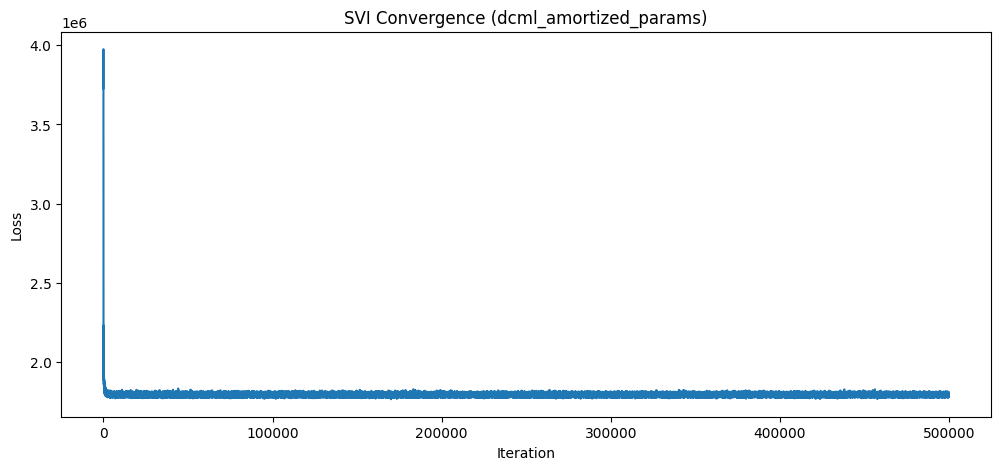

In [20]:
dcml_params, (alpha_h_history, alpha_phi_history) = infer_amortized_posteriors(npcs, len(dcml_chordtypes), dcml_obs,
                                                                              nsteps=500000, lr=0.05, plot_loss=True,
                                                                              save_as="dcml_amortized_params", collect_history=True
                                                                              )

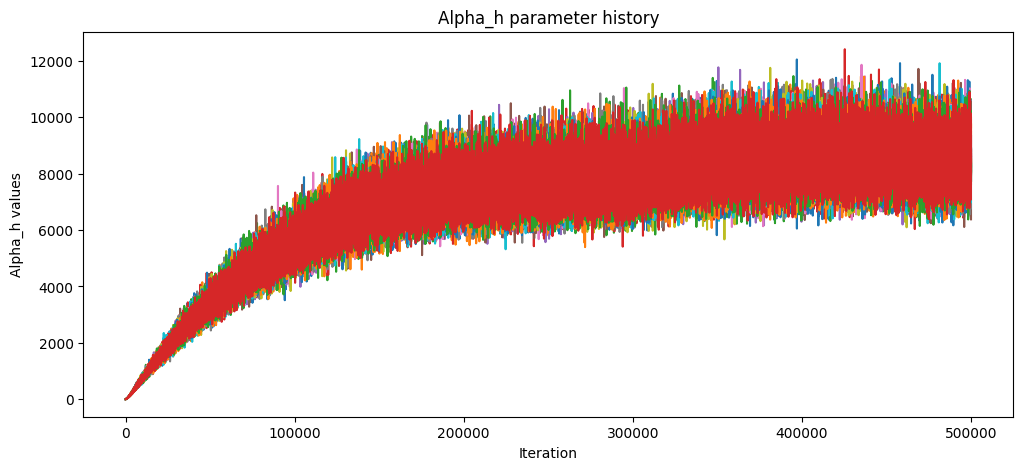

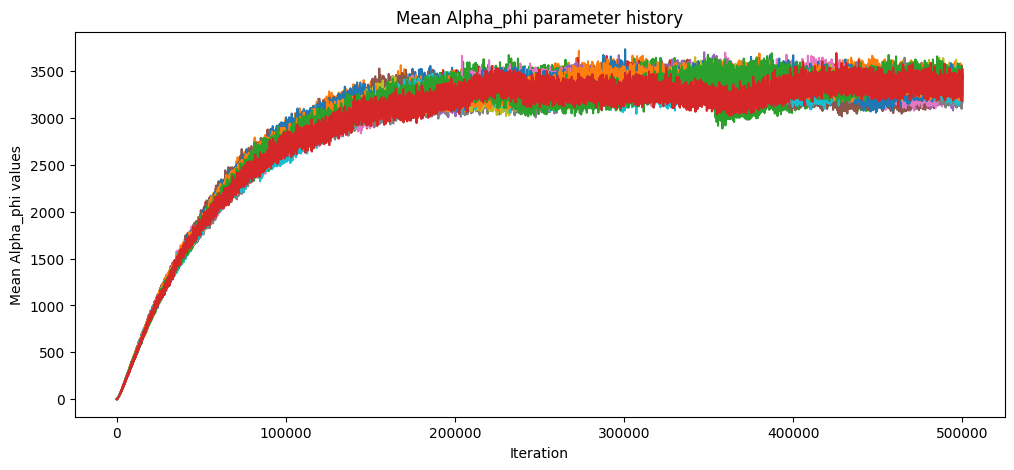

In [21]:
# Plot the parameter histories
plot_param_histories(alpha_h_history, alpha_phi_history)

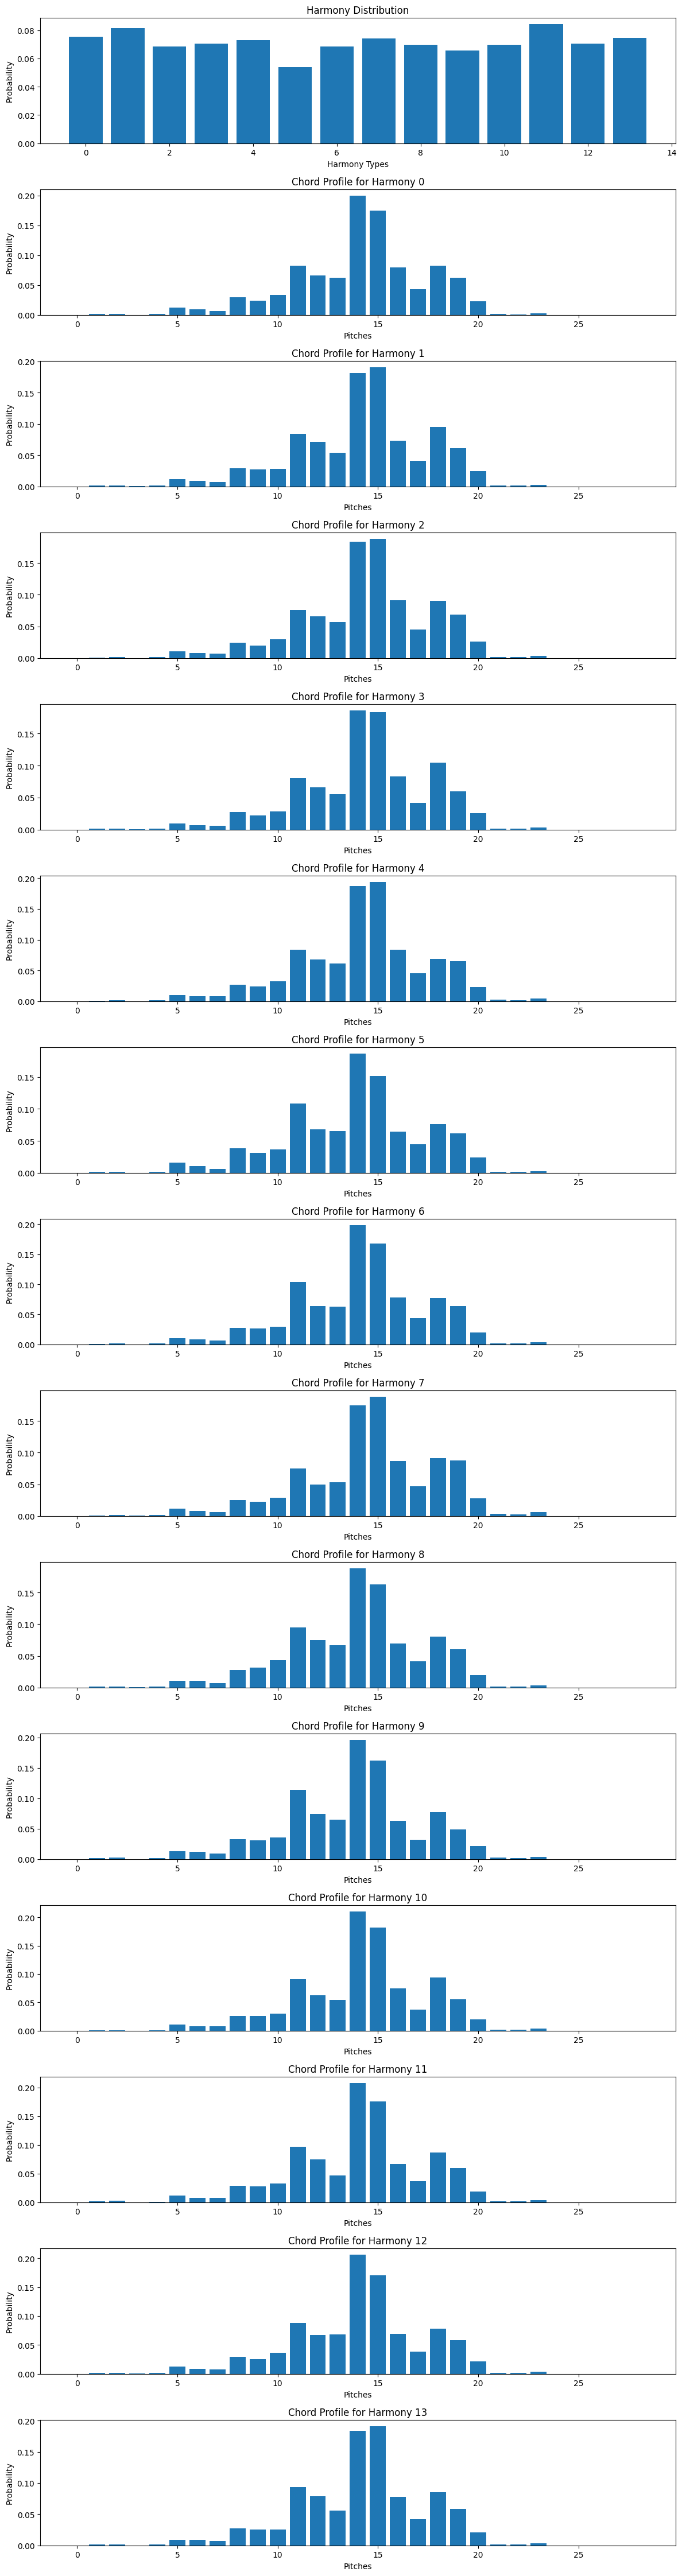

In [22]:
plot_amortized_inference_results(dcml_params, len(dcml_chordtypes), npcs, save_as="dcml_amortized_params")